In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
from __future__ import absolute_import, division, print_function
%matplotlib inline

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

In [5]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
    mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [6]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [7]:
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_service': None, '_model_dir': '/tmp/mnist_convnet_model', '_task_type': 'worker', '_num_worker_replicas': 1, '_session_config': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_master': '', '_num_ps_replicas': 0, '_task_id': 0, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a190faa20>, '_is_chief': True, '_tf_random_seed': None}


In [8]:
# Set up logging for predictions
  # Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

In [9]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": train_data},y=train_labels,batch_size=100,num_epochs=None,shuffle=True)
mnist_classifier.train(input_fn=train_input_fn,steps=20000,hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.09977324  0.10265632  0.08616787  0.10287479  0.09919641  0.09860478
   0.11776047  0.09866099  0.10115947  0.09314568]
 [ 0.09790301  0.09798528  0.09617944  0.11053355  0.10051285  0.10005779
   0.11074433  0.09670039  0.09868187  0.09070148]
 [ 0.09631     0.09539823  0.08389396  0.11111299  0.10742763  0.10320388
   0.11948835  0.08988675  0.10557402  0.08770417]
 [ 0.10027853  0.09406533  0.10616951  0.11652714  0.09397205  0.09635302
   0.1082487   0.10411865  0.09170774  0.0885593 ]
 [ 0.10211977  0.09569326  0.09871133  0.09545417  0.10663608  0.09675317
   0.11008061  0.09903038  0.10662352  0.08889768]
 [ 0.09814604  0.10065865  0.09285979  0.10142327  0.09628289  0.0995764
   0.11683363  0.10282665  0.09541956  0.09597313]
 [ 0.10310166  0.10099283  0.08904164  0.10419639  0.1058931   0.09220585
   0.10878201  0.1

INFO:tensorflow:step = 1, loss = 2.31156
INFO:tensorflow:probabilities = [[ 0.09933108  0.08919311  0.09171081  0.11578314  0.10016318  0.09662021
   0.09956846  0.09316853  0.1211577   0.09330384]
 [ 0.09927779  0.11044689  0.08047669  0.09856498  0.1009339   0.10665531
   0.10829454  0.09690005  0.10987717  0.08857267]
 [ 0.09677581  0.10292986  0.09876301  0.1102437   0.09865509  0.0945349
   0.11038249  0.09412584  0.09950834  0.09408104]
 [ 0.09438758  0.10467421  0.09080395  0.10650279  0.10140145  0.09552673
   0.09853345  0.09835163  0.11154488  0.09827336]
 [ 0.08935369  0.09694342  0.09346295  0.10443024  0.09917518  0.10039726
   0.11382136  0.10229668  0.10548915  0.09463011]
 [ 0.09371879  0.0949406   0.09470151  0.10940947  0.10133239  0.10025303
   0.10380633  0.10349733  0.10962098  0.08871949]
 [ 0.08614565  0.10394998  0.09855783  0.10765098  0.11411079  0.08915267
   0.11059006  0.09548973  0.10673741  0.08761489]
 [ 0.10393872  0.09179108  0.08774597  0.10262559  0.

INFO:tensorflow:global_step/sec: 4.96168
INFO:tensorflow:probabilities = [[ 0.08950876  0.09841177  0.09068765  0.10463758  0.1067823   0.10279994
   0.11201562  0.09628502  0.10852192  0.09034937]
 [ 0.09511406  0.0924151   0.08788978  0.12313072  0.103039    0.09313693
   0.12403034  0.10255351  0.10010051  0.07859004]
 [ 0.1089731   0.09178612  0.09876968  0.11039703  0.11047553  0.09074381
   0.10270582  0.09483328  0.10028967  0.09102594]
 [ 0.09112437  0.09487503  0.08688186  0.09792453  0.11654443  0.099934
   0.10521763  0.09828606  0.10872091  0.1004912 ]
 [ 0.09765021  0.09634336  0.08998405  0.11035065  0.10762379  0.09363765
   0.11107445  0.09449041  0.10414057  0.09470485]
 [ 0.08861171  0.09884181  0.09615888  0.10716167  0.09457023  0.10661636
   0.10615598  0.10059848  0.10373629  0.0975486 ]
 [ 0.09764136  0.09323057  0.10177653  0.10785156  0.10204003  0.09769304
   0.10875081  0.10093432  0.09707607  0.09300575]
 [ 0.09698201  0.1110214   0.09283992  0.107261    0.1

INFO:tensorflow:step = 101, loss = 2.28824 (20.140 sec)
INFO:tensorflow:probabilities = [[ 0.09306281  0.10292934  0.09845449  0.09994923  0.10568638  0.10288905
   0.1079684   0.09480422  0.11018018  0.08407593]
 [ 0.09995157  0.10649152  0.08366351  0.11042663  0.10004339  0.09628958
   0.10639702  0.09391041  0.10251551  0.10031085]
 [ 0.0966169   0.09426304  0.08628985  0.09835589  0.11435542  0.09554774
   0.11313529  0.10205526  0.10508733  0.09429335]
 [ 0.10286112  0.09694723  0.09898894  0.11691558  0.10075448  0.09462798
   0.09724642  0.09537148  0.10252373  0.09376299]
 [ 0.08685496  0.10316388  0.11570573  0.10736656  0.10014052  0.09653103
   0.09926467  0.09395972  0.10443021  0.09258269]
 [ 0.10638175  0.10366193  0.09389979  0.10763428  0.10154913  0.09788992
   0.10860057  0.09456433  0.09955337  0.08626495]
 [ 0.09445721  0.09826848  0.09559073  0.11712309  0.10106236  0.09066515
   0.11017117  0.09950025  0.10092897  0.09223254]
 [ 0.09515769  0.09620169  0.08722843

INFO:tensorflow:global_step/sec: 5.00675
INFO:tensorflow:probabilities = [[ 0.09819402  0.09688304  0.09440715  0.10748532  0.1046932   0.09937125
   0.11546946  0.09137853  0.10163863  0.09047935]
 [ 0.09978241  0.10290358  0.09628326  0.09880792  0.10037778  0.10004856
   0.103434    0.10466542  0.09207456  0.10162245]
 [ 0.10192763  0.09794439  0.10101487  0.11049006  0.0957641   0.09618529
   0.10540005  0.09863532  0.09644756  0.09619077]
 [ 0.10450043  0.08730938  0.09078376  0.11631442  0.1118505   0.09727344
   0.09882374  0.09543009  0.10683622  0.09087799]
 [ 0.10162127  0.08725748  0.09419318  0.11960811  0.10371105  0.09259024
   0.11349417  0.08672015  0.09445857  0.10634571]
 [ 0.09804639  0.1062999   0.07874306  0.09293082  0.09341972  0.10344744
   0.1432298   0.09976292  0.09520204  0.08891787]
 [ 0.10949352  0.10470235  0.08522347  0.12337033  0.09868118  0.09448587
   0.10303414  0.09084267  0.09663495  0.09353149]
 [ 0.10162537  0.0898958   0.09556036  0.11005121  0

INFO:tensorflow:step = 201, loss = 2.29586 (19.972 sec)
INFO:tensorflow:probabilities = [[ 0.09780443  0.09142999  0.09384508  0.11096986  0.1001562   0.09770173
   0.10591473  0.09912162  0.11014005  0.09291629]
 [ 0.09959934  0.10203803  0.09760563  0.09851963  0.1025936   0.09496675
   0.11170467  0.09922039  0.09780867  0.09594329]
 [ 0.09819134  0.09538092  0.08340313  0.11328559  0.0949466   0.10424656
   0.12826043  0.09054505  0.10973663  0.0820038 ]
 [ 0.08939452  0.09056198  0.10928673  0.10852868  0.10279498  0.09582876
   0.11313522  0.09590809  0.10087048  0.09369054]
 [ 0.09139663  0.09011643  0.10068216  0.11206788  0.09875837  0.09766071
   0.1094973   0.10468506  0.09765882  0.09747659]
 [ 0.10367718  0.10573664  0.09837753  0.10587447  0.09486519  0.0922097
   0.10673992  0.09303946  0.1086895   0.09079032]
 [ 0.1029196   0.09480724  0.09257589  0.10497902  0.10182683  0.09398511
   0.11473938  0.09052203  0.10536518  0.0982798 ]
 [ 0.09978376  0.09388191  0.08914808 

INFO:tensorflow:global_step/sec: 5.10759
INFO:tensorflow:probabilities = [[ 0.12132839  0.09422906  0.0828874   0.10299501  0.10114769  0.104656
   0.11219195  0.09155003  0.09628862  0.09272584]
 [ 0.09503767  0.09417223  0.09579726  0.10568302  0.09914128  0.09810868
   0.10882606  0.09462903  0.10366794  0.10493691]
 [ 0.10576614  0.09156446  0.08732589  0.11317047  0.10065533  0.09487474
   0.10949883  0.0926121   0.1031884   0.10134365]
 [ 0.10110854  0.09025331  0.09592057  0.11024744  0.11795709  0.09919175
   0.10530564  0.09591389  0.09783961  0.08626218]
 [ 0.09834283  0.09327672  0.0954581   0.10463466  0.09622602  0.10039125
   0.11144693  0.09790932  0.11357269  0.08874147]
 [ 0.09722736  0.09741022  0.09744167  0.10696121  0.09996138  0.09682705
   0.11500411  0.10199935  0.09602857  0.09113911]
 [ 0.08513992  0.09397461  0.09197131  0.09888661  0.10893523  0.10163059
   0.10404311  0.10573407  0.11263897  0.09704553]
 [ 0.09354326  0.09864438  0.10164508  0.11132548  0.1

INFO:tensorflow:step = 301, loss = 2.26503 (19.582 sec)
INFO:tensorflow:probabilities = [[ 0.10943249  0.09421372  0.10309198  0.10232861  0.10028065  0.10526451
   0.09545133  0.09977087  0.0914955   0.0986703 ]
 [ 0.11081554  0.09126113  0.10038357  0.11010316  0.09816732  0.089609
   0.10430448  0.09488646  0.09545184  0.10501748]
 [ 0.09576369  0.10124169  0.08139828  0.10824344  0.10731403  0.10689528
   0.09704382  0.09190231  0.10221731  0.10798013]
 [ 0.10452902  0.09207711  0.08536108  0.11318579  0.09969889  0.09952283
   0.11837299  0.07923701  0.11602224  0.09199303]
 [ 0.08978035  0.10232522  0.10483246  0.10659046  0.10248398  0.09284387
   0.1045745   0.10169391  0.09631436  0.09856086]
 [ 0.09148498  0.10704065  0.08143985  0.11275687  0.10825986  0.10015567
   0.10895373  0.08796685  0.10682622  0.09511536]
 [ 0.09767473  0.09539452  0.09741423  0.11365978  0.11097     0.0965747
   0.10867886  0.08632778  0.11245889  0.08084647]
 [ 0.09439721  0.09567607  0.09865591  0

INFO:tensorflow:global_step/sec: 5.05869
INFO:tensorflow:probabilities = [[ 0.09786175  0.09457669  0.09017803  0.1082233   0.09833698  0.09322111
   0.10804535  0.10356479  0.10500169  0.10099029]
 [ 0.09890417  0.09336914  0.0971956   0.10964639  0.09040309  0.09769776
   0.12071021  0.10502423  0.09420396  0.09284554]
 [ 0.09859762  0.0807903   0.09268296  0.09590235  0.0987778   0.1037671
   0.11725025  0.08784153  0.12401304  0.10037702]
 [ 0.09918608  0.09602778  0.09270478  0.09889579  0.11076901  0.09704036
   0.0989505   0.09583219  0.1055636   0.10502996]
 [ 0.09809908  0.09037289  0.10585247  0.11449561  0.10600614  0.09329788
   0.10924463  0.09045209  0.10612041  0.08605883]
 [ 0.10581599  0.08911945  0.10373741  0.10108066  0.08160882  0.10230178
   0.12440969  0.09964179  0.10632483  0.08595961]
 [ 0.0954194   0.10495159  0.09273547  0.11313329  0.0920281   0.10190553
   0.11244893  0.09498534  0.10348048  0.08891191]
 [ 0.09207127  0.0872665   0.08174892  0.11137876  0.

INFO:tensorflow:step = 401, loss = 2.23927 (19.767 sec)
INFO:tensorflow:probabilities = [[ 0.10004932  0.0969884   0.09638104  0.09634691  0.10544719  0.09430282
   0.10095952  0.1096765   0.10783511  0.09201325]
 [ 0.10944708  0.09039527  0.08943892  0.13603958  0.0889379   0.09668843
   0.10486487  0.08675887  0.12590481  0.07152434]
 [ 0.09509004  0.08956097  0.09508454  0.12024499  0.10398562  0.09101006
   0.10385091  0.08948157  0.1251265   0.08656485]
 [ 0.0980126   0.09044307  0.09241653  0.10449406  0.10087626  0.08444472
   0.11812747  0.10630734  0.11160192  0.09327608]
 [ 0.10113843  0.09715814  0.09164963  0.10112964  0.10299186  0.09716
   0.10411924  0.09904973  0.11029507  0.09530832]
 [ 0.109103    0.09505191  0.10074022  0.11630978  0.09837218  0.08754064
   0.11201885  0.07717243  0.10939615  0.09429478]
 [ 0.1050011   0.0910571   0.08286246  0.11673102  0.09973505  0.09668379
   0.11095349  0.09464946  0.12374399  0.07858256]
 [ 0.1030686   0.09465306  0.08916167  0

INFO:tensorflow:global_step/sec: 5.07881
INFO:tensorflow:probabilities = [[ 0.11967006  0.08058704  0.09925138  0.11445949  0.10488134  0.09684923
   0.10361883  0.08731092  0.11503417  0.07833753]
 [ 0.09708543  0.10999303  0.09861327  0.09979896  0.09846894  0.09607875
   0.10579649  0.09649913  0.09990709  0.09775893]
 [ 0.09115778  0.09284671  0.09383967  0.10477494  0.10049608  0.09131435
   0.11803297  0.09395202  0.11347844  0.10010701]
 [ 0.10481438  0.0762841   0.09122051  0.11662609  0.1040163   0.08956955
   0.12023368  0.09534394  0.1118077   0.09008376]
 [ 0.09487479  0.09745719  0.09050594  0.12714663  0.09409556  0.08382648
   0.10023393  0.09800997  0.12875111  0.08509845]
 [ 0.10924656  0.09604481  0.09676358  0.09923121  0.08818419  0.09907184
   0.12366922  0.0916583   0.09597075  0.10015961]
 [ 0.13142456  0.08041728  0.08363668  0.10707451  0.10098686  0.10106441
   0.12113605  0.08259503  0.09023467  0.10142992]
 [ 0.09594638  0.11291797  0.10018107  0.10749212  0

INFO:tensorflow:step = 501, loss = 2.22625 (19.689 sec)
INFO:tensorflow:probabilities = [[ 0.08738276  0.10038247  0.10333677  0.10865583  0.10005675  0.09750824
   0.11413199  0.09749141  0.09565816  0.09539557]
 [ 0.12835038  0.09764466  0.09912602  0.11492256  0.09038763  0.10144926
   0.10522573  0.07313292  0.09566425  0.09409661]
 [ 0.10556853  0.0872967   0.10479069  0.12377597  0.10092793  0.10193687
   0.10061138  0.09364203  0.09040231  0.09104753]
 [ 0.08348315  0.10025562  0.11097102  0.10771763  0.10247076  0.0985437
   0.09997991  0.09986509  0.10487812  0.09183509]
 [ 0.10453146  0.09681254  0.09435815  0.10476857  0.09426617  0.09595675
   0.11821979  0.09884395  0.09988867  0.09235396]
 [ 0.11422174  0.0837597   0.09930483  0.09142046  0.09903639  0.08835305
   0.13034061  0.09217136  0.09885558  0.10253622]
 [ 0.10381765  0.09595334  0.09121732  0.11134911  0.09422624  0.0923644
   0.10635797  0.10255972  0.10645171  0.09570251]
 [ 0.12686494  0.08086999  0.10172437  

INFO:tensorflow:global_step/sec: 5.04605
INFO:tensorflow:probabilities = [[ 0.11262147  0.09447135  0.1052842   0.10472357  0.08974212  0.10117074
   0.11648241  0.0878033   0.10560936  0.08209152]
 [ 0.0834032   0.08189461  0.11792344  0.09947815  0.10044294  0.10183477
   0.12492576  0.10721246  0.089338    0.0935467 ]
 [ 0.09845579  0.09640873  0.10279691  0.11606625  0.09315725  0.09511911
   0.13205263  0.08055802  0.09613054  0.08925481]
 [ 0.11986455  0.08298029  0.09951401  0.11806904  0.09690724  0.10986199
   0.1020112   0.0895543   0.09164828  0.08958907]
 [ 0.098398    0.08742525  0.08610921  0.12608875  0.09573145  0.09752124
   0.09495202  0.09818578  0.12118953  0.09439874]
 [ 0.14737657  0.07666236  0.08939391  0.10190123  0.10154929  0.10481773
   0.11340403  0.08223662  0.09678902  0.08586913]
 [ 0.09755605  0.09459443  0.10381634  0.11156845  0.0927422   0.08878206
   0.09714639  0.10002939  0.11839435  0.09537031]
 [ 0.09966571  0.08357459  0.10100817  0.10669481  0

INFO:tensorflow:step = 601, loss = 2.19891 (19.819 sec)
INFO:tensorflow:probabilities = [[ 0.09772766  0.07662497  0.0962095   0.09390146  0.1115839   0.09828969
   0.1207934   0.10143956  0.10060216  0.1028277 ]
 [ 0.13986927  0.07894643  0.08998591  0.13804929  0.07896651  0.09755368
   0.11384442  0.07638788  0.10216954  0.08422708]
 [ 0.09409896  0.09308505  0.09604986  0.10376254  0.10288772  0.08560219
   0.1120837   0.10114279  0.11335249  0.09793465]
 [ 0.09470855  0.07836424  0.1112624   0.10926864  0.09651353  0.09769318
   0.12155523  0.08532072  0.11248743  0.09282603]
 [ 0.09598687  0.10583953  0.09645979  0.10733396  0.09407818  0.09562622
   0.10240377  0.08949714  0.11167502  0.10109961]
 [ 0.09254841  0.10759442  0.10787115  0.0993818   0.10405678  0.09623422
   0.10092363  0.09781005  0.0950496   0.09852999]
 [ 0.10867146  0.09517369  0.08914748  0.11614148  0.10309488  0.08651222
   0.10217428  0.10482318  0.10931685  0.08494446]
 [ 0.08883708  0.08449883  0.13431983

INFO:tensorflow:global_step/sec: 4.82613
INFO:tensorflow:probabilities = [[ 0.10180659  0.09381203  0.09835538  0.11651623  0.09618169  0.09617955
   0.10343487  0.10201402  0.10341455  0.08828513]
 [ 0.13576594  0.07717918  0.09180735  0.13144581  0.0845026   0.12307353
   0.09553581  0.07600953  0.10253789  0.08214236]
 [ 0.09887946  0.08463225  0.08389575  0.10539318  0.09855203  0.08761385
   0.12338209  0.12005478  0.10504352  0.09255307]
 [ 0.10333177  0.06594145  0.11135927  0.11411659  0.09670417  0.10283646
   0.10504396  0.0824317   0.11210947  0.10612521]
 [ 0.12605353  0.0773991   0.10437592  0.11077949  0.09470993  0.10619965
   0.10769515  0.11016839  0.07863115  0.0839877 ]
 [ 0.11280948  0.07596767  0.09392049  0.10188042  0.08980276  0.09831127
   0.11449601  0.10973244  0.12264495  0.08043446]
 [ 0.10386043  0.07797559  0.07940532  0.09450189  0.11332573  0.1058656
   0.10971614  0.09291651  0.12436201  0.09807075]
 [ 0.10648923  0.08547229  0.10003506  0.12840673  0.

INFO:tensorflow:step = 701, loss = 2.17872 (20.720 sec)
INFO:tensorflow:probabilities = [[ 0.09752952  0.09275633  0.09135973  0.09730917  0.09377884  0.1050786
   0.08555388  0.10013795  0.13623223  0.10026377]
 [ 0.09712846  0.09279066  0.09762333  0.1118857   0.10136168  0.08616652
   0.09047366  0.10834947  0.10778257  0.10643798]
 [ 0.09411263  0.08720917  0.08656096  0.0999291   0.07697379  0.10490929
   0.10340431  0.1190473   0.12464461  0.10320885]
 [ 0.11585779  0.08638452  0.0824187   0.09337249  0.10024902  0.08595251
   0.09785862  0.11723551  0.11876921  0.1019017 ]
 [ 0.09431396  0.098021    0.09576305  0.10336207  0.11099868  0.08544836
   0.11246837  0.09434656  0.10297912  0.1022989 ]
 [ 0.11556321  0.07482341  0.10758792  0.13546033  0.08672673  0.07493664
   0.10613573  0.08848811  0.10387367  0.10640423]
 [ 0.07842539  0.08706375  0.09836327  0.11143098  0.11029158  0.09438347
   0.11588273  0.09367383  0.10156083  0.10892422]
 [ 0.08998808  0.08345049  0.11057777 

INFO:tensorflow:global_step/sec: 5.27067
INFO:tensorflow:probabilities = [[ 0.07374621  0.09979784  0.09741671  0.11239602  0.09302621  0.08612446
   0.11111374  0.09863129  0.1189961   0.10875142]
 [ 0.0827444   0.0949261   0.09058368  0.10628489  0.09945098  0.0978088
   0.10009354  0.10206711  0.11456752  0.11147303]
 [ 0.09107887  0.07708606  0.09222674  0.10012103  0.11024828  0.09013914
   0.10334396  0.11980713  0.10591745  0.11003137]
 [ 0.07649751  0.08500336  0.08819536  0.09332459  0.09976687  0.08363163
   0.1136907   0.11999111  0.12272979  0.11716912]
 [ 0.10301395  0.07898784  0.08948717  0.10233144  0.09413596  0.09087154
   0.11337982  0.09969628  0.12143566  0.10666034]
 [ 0.08521042  0.11397777  0.09802166  0.10978009  0.08983972  0.07304107
   0.10675932  0.11074492  0.11505476  0.09757017]
 [ 0.09288871  0.09192005  0.0835579   0.11582797  0.0934075   0.1054003
   0.10538869  0.10711878  0.11572409  0.08876607]
 [ 0.09419666  0.0948447   0.09941258  0.10401692  0.1

INFO:tensorflow:step = 801, loss = 2.14102 (18.972 sec)
INFO:tensorflow:probabilities = [[ 0.10936161  0.09162136  0.09152762  0.11893322  0.09136929  0.09042897
   0.09911494  0.10905825  0.1025721   0.09601264]
 [ 0.09938804  0.07818026  0.1002564   0.12180646  0.09878311  0.11634881
   0.10827064  0.08868986  0.08522665  0.10304984]
 [ 0.1010811   0.10211004  0.08873629  0.09602127  0.10518076  0.10336132
   0.13685881  0.08659307  0.09713059  0.08292677]
 [ 0.07948332  0.0835219   0.09651243  0.11273193  0.11874696  0.09300574
   0.10462042  0.10054819  0.10684558  0.1039836 ]
 [ 0.09276787  0.07635036  0.09685644  0.12128785  0.09217294  0.108403
   0.11372833  0.09586174  0.10266187  0.09990959]
 [ 0.10762931  0.08580182  0.08431702  0.13572419  0.08675869  0.1069087
   0.09721804  0.1105268   0.11025976  0.07485566]
 [ 0.07458611  0.0948957   0.09627709  0.11634574  0.09150847  0.08573669
   0.10110527  0.11670925  0.12337669  0.09945894]
 [ 0.15304215  0.06969503  0.12326013  0

INFO:tensorflow:global_step/sec: 5.27252
INFO:tensorflow:probabilities = [[ 0.08643097  0.07876223  0.09452242  0.09937204  0.11488099  0.12151974
   0.10830924  0.08017205  0.11209219  0.1039381 ]
 [ 0.1257979   0.06998383  0.11565354  0.12176985  0.0912287   0.09230412
   0.11411112  0.08439039  0.10549952  0.07926112]
 [ 0.09814824  0.12136231  0.11057866  0.10881533  0.0831031   0.08130904
   0.10619861  0.09646776  0.0950048   0.09901212]
 [ 0.12439378  0.07369428  0.09557378  0.12270645  0.08584237  0.1124192
   0.0795162   0.09106395  0.12647437  0.08831562]
 [ 0.10320421  0.05991299  0.08378785  0.08922371  0.12793468  0.09017409
   0.16039164  0.08556977  0.12375575  0.07604534]
 [ 0.13902751  0.07069549  0.07021505  0.1248781   0.10736181  0.08731134
   0.11296792  0.08150543  0.10889551  0.09714176]
 [ 0.11436675  0.07103375  0.08577897  0.11408335  0.09472839  0.08786247
   0.10181591  0.13510184  0.10675902  0.08846948]
 [ 0.08607907  0.0761447   0.10170931  0.08951801  0.

INFO:tensorflow:step = 901, loss = 2.12765 (18.967 sec)
INFO:tensorflow:probabilities = [[ 0.11283722  0.08262547  0.09211542  0.11545659  0.09808511  0.0833772
   0.07747338  0.12173985  0.11645842  0.09983128]
 [ 0.11794689  0.0985175   0.07989769  0.10962228  0.09302986  0.08757028
   0.10169689  0.10613789  0.10817749  0.0974033 ]
 [ 0.07695279  0.10940231  0.11532605  0.10379992  0.07640617  0.0952259
   0.11558936  0.10832568  0.11543225  0.08353958]
 [ 0.1085398   0.06909885  0.09282136  0.09966119  0.08894847  0.11026415
   0.14817719  0.06772843  0.12013682  0.09462376]
 [ 0.09461448  0.06594632  0.11703654  0.18213008  0.0935816   0.07870751
   0.12263123  0.07392834  0.10224876  0.06917518]
 [ 0.10791209  0.06765897  0.11432709  0.16581815  0.0898153   0.08905102
   0.10371889  0.08091985  0.10437501  0.0764037 ]
 [ 0.08002719  0.10769037  0.11495572  0.1239161   0.08775622  0.08768173
   0.10085871  0.09948487  0.11028647  0.08734278]
 [ 0.13928297  0.06952492  0.08953053  

INFO:tensorflow:global_step/sec: 5.22452
INFO:tensorflow:probabilities = [[ 0.15227479  0.04567083  0.08516867  0.14682898  0.09173501  0.09473318
   0.0857595   0.09897167  0.11180759  0.08704979]
 [ 0.09362217  0.09386335  0.09161349  0.09113457  0.11420375  0.08905599
   0.08751948  0.10646124  0.11368453  0.11884143]
 [ 0.08962164  0.07316115  0.09073363  0.0958211   0.10758133  0.10972246
   0.10452601  0.09625072  0.10471503  0.12786692]
 [ 0.10417962  0.10053338  0.07568915  0.07875385  0.12010072  0.11122487
   0.10737649  0.09319462  0.10061386  0.10833342]
 [ 0.10866349  0.06964726  0.11172897  0.13914903  0.11500852  0.09401214
   0.11564376  0.06399814  0.11175393  0.07039475]
 [ 0.10949491  0.060002    0.16789477  0.11853128  0.08693563  0.0853258
   0.12407123  0.06004772  0.1218161   0.06588063]
 [ 0.13321081  0.07661191  0.14081813  0.10817123  0.07827526  0.0787864
   0.11544387  0.09152655  0.09323105  0.08392475]
 [ 0.13241906  0.0904052   0.0879477   0.14873686  0.0

INFO:tensorflow:step = 1001, loss = 2.05981 (19.139 sec)
INFO:tensorflow:probabilities = [[ 0.08767113  0.06177621  0.09349661  0.07655678  0.10919089  0.0789911
   0.09505851  0.12194165  0.13603449  0.1392826 ]
 [ 0.09226886  0.07821265  0.09682318  0.12177411  0.10862237  0.09680837
   0.08119945  0.09309453  0.12325209  0.10794441]
 [ 0.09069443  0.06632694  0.14273144  0.14007807  0.08466394  0.08984235
   0.09648501  0.07108149  0.10824676  0.10984967]
 [ 0.09592108  0.07021856  0.09306155  0.10829229  0.09165683  0.08245835
   0.10138014  0.14331003  0.10684226  0.10685889]
 [ 0.09605587  0.08040813  0.11603819  0.08718644  0.1123028   0.08369628
   0.11986479  0.10826587  0.09757902  0.09860258]
 [ 0.17039779  0.04767404  0.13323484  0.06824236  0.10236815  0.10947266
   0.125231    0.07182758  0.06537281  0.10617873]
 [ 0.15701026  0.07471878  0.09551353  0.13119088  0.08095653  0.09810075
   0.13049355  0.07752884  0.07700582  0.07748116]
 [ 0.06686776  0.14576162  0.09429048

INFO:tensorflow:global_step/sec: 5.27394
INFO:tensorflow:probabilities = [[ 0.12761886  0.09424479  0.09621529  0.0806073   0.11651135  0.12605815
   0.09123868  0.07696799  0.09751137  0.09302624]
 [ 0.10249422  0.07213543  0.07403436  0.11859153  0.07405413  0.0830244
   0.09089386  0.1428674   0.10516595  0.13673872]
 [ 0.40414339  0.03160939  0.0857826   0.09708192  0.0458268   0.08272762
   0.07711981  0.05079008  0.06318095  0.06173742]
 [ 0.09657276  0.05616     0.09437923  0.13294455  0.10736803  0.09970051
   0.10622518  0.11845291  0.07191267  0.11628418]
 [ 0.06573293  0.13148074  0.1062111   0.09353529  0.09284942  0.08434155
   0.09693011  0.11649895  0.10799372  0.10442618]
 [ 0.16179167  0.06578831  0.14429246  0.22210203  0.05558527  0.08779969
   0.09467689  0.04453442  0.07803956  0.04538975]
 [ 0.08060691  0.10043111  0.09608328  0.15545449  0.08867078  0.0765845
   0.11315351  0.09240986  0.101337    0.09526856]
 [ 0.09750887  0.0725728   0.11051102  0.11565278  0.0

INFO:tensorflow:step = 1101, loss = 1.99145 (18.961 sec)
INFO:tensorflow:probabilities = [[ 0.07501925  0.1464739   0.08606429  0.12040408  0.08041684  0.08599909
   0.10739768  0.11322026  0.09987724  0.08512732]
 [ 0.07545329  0.05230284  0.08806907  0.07344964  0.1529756   0.07790667
   0.11231458  0.08856148  0.12644345  0.15252343]
 [ 0.08959372  0.07906178  0.0976261   0.11923525  0.09761262  0.07333429
   0.08094917  0.08566265  0.16600962  0.11091489]
 [ 0.09164037  0.07755537  0.10871065  0.09239502  0.12948813  0.07961751
   0.06763729  0.11855815  0.11216896  0.12222855]
 [ 0.10930635  0.07514706  0.0841672   0.13227697  0.09076955  0.09297352
   0.11603183  0.11973016  0.0842716   0.09532576]
 [ 0.14096656  0.06035896  0.20104361  0.16601707  0.05384011  0.08274933
   0.10864329  0.05356387  0.07418666  0.05863051]
 [ 0.28465521  0.05056949  0.07280113  0.09317285  0.04783791  0.12075172
   0.09269299  0.07679681  0.080295    0.08042686]
 [ 0.12631898  0.05756164  0.1548663

INFO:tensorflow:global_step/sec: 5.25702
INFO:tensorflow:probabilities = [[ 0.08702656  0.06671451  0.09763025  0.06990831  0.12884626  0.09047969
   0.10175719  0.12375348  0.11395792  0.11992587]
 [ 0.07320131  0.07526759  0.09771927  0.08986977  0.09171964  0.07674468
   0.0785266   0.22185047  0.07777373  0.11732694]
 [ 0.0891814   0.04200854  0.10009734  0.11410119  0.10564557  0.09837382
   0.11172397  0.13104607  0.11172813  0.09609401]
 [ 0.05234639  0.10210075  0.10854489  0.13355324  0.09658781  0.0549965
   0.10146838  0.1232957   0.11804246  0.10906383]
 [ 0.09348897  0.08580304  0.10611504  0.12712456  0.09095243  0.08918969
   0.10391722  0.08611119  0.13943025  0.0778676 ]
 [ 0.09493206  0.05941832  0.15762877  0.10601471  0.11250798  0.06056564
   0.17811064  0.08439366  0.06193656  0.08449166]
 [ 0.09865114  0.05578994  0.05951405  0.10711108  0.1317984   0.1162343
   0.12905316  0.09733837  0.0714308   0.13307875]
 [ 0.12222785  0.05783824  0.1011027   0.14008041  0.1

INFO:tensorflow:step = 1201, loss = 1.93161 (19.022 sec)
INFO:tensorflow:probabilities = [[ 0.0842336   0.08672208  0.12579699  0.10327983  0.10600146  0.08632074
   0.19581901  0.04748171  0.08381002  0.08053456]
 [ 0.06978338  0.06625587  0.12106322  0.16881484  0.04617977  0.10101921
   0.15960285  0.0906393   0.12118173  0.05545976]
 [ 0.10436769  0.04628884  0.13079627  0.1427739   0.05542682  0.07493561
   0.22616351  0.07684614  0.05512383  0.08727739]
 [ 0.15468819  0.04212505  0.05572594  0.1613591   0.0748069   0.12873553
   0.05030052  0.08343635  0.11503077  0.13379163]
 [ 0.06868666  0.11954185  0.10013016  0.1390294   0.07437571  0.0823153
   0.12460276  0.09263255  0.11633784  0.08234777]
 [ 0.11941349  0.06038222  0.11460311  0.25522172  0.04673333  0.08028854
   0.08876909  0.09634905  0.07854848  0.05969101]
 [ 0.08353847  0.07354903  0.08192202  0.09329779  0.1125817   0.09836066
   0.0774665   0.14991398  0.09969486  0.12967512]
 [ 0.1913996   0.05232359  0.12775214

INFO:tensorflow:global_step/sec: 5.20283
INFO:tensorflow:probabilities = [[ 0.08756506  0.02837969  0.12325736  0.08776228  0.10439355  0.11963981
   0.18157302  0.08970429  0.04107328  0.13665166]
 [ 0.08609912  0.10104158  0.13387424  0.10399929  0.08548881  0.09875049
   0.1183589   0.05846076  0.13522203  0.07870472]
 [ 0.05813711  0.08550756  0.11212923  0.09668601  0.11283186  0.0754623
   0.20684333  0.05155081  0.10380107  0.09705079]
 [ 0.05075322  0.06061451  0.13282728  0.10954506  0.12618248  0.08407652
   0.11024568  0.09145597  0.10165065  0.13264871]
 [ 0.09970158  0.08972778  0.2224168   0.11845082  0.0703123   0.07670606
   0.06579917  0.05725317  0.1434159   0.05621651]
 [ 0.07038154  0.10579262  0.10744175  0.05138294  0.15685652  0.05922167
   0.14797446  0.0858019   0.10246471  0.1126819 ]
 [ 0.08355793  0.04888264  0.08717283  0.07529682  0.11414989  0.06506724
   0.13706861  0.12200044  0.11675086  0.15005279]
 [ 0.08778957  0.0599632   0.13519607  0.09936913  0.

INFO:tensorflow:step = 1301, loss = 1.83435 (19.221 sec)
INFO:tensorflow:probabilities = [[ 0.02114632  0.0354897   0.39005327  0.1147674   0.10350328  0.0647159
   0.13853301  0.04395559  0.05985124  0.02798427]
 [ 0.0673081   0.11100023  0.06609587  0.10771625  0.07533738  0.10258882
   0.12923463  0.12047379  0.10331487  0.11693011]
 [ 0.03994637  0.08098885  0.05498017  0.0796067   0.13978857  0.06404886
   0.08883034  0.17604069  0.08639525  0.1893741 ]
 [ 0.08402611  0.07881967  0.05821941  0.09674396  0.11290801  0.0714762
   0.04396357  0.19255374  0.09967887  0.16161041]
 [ 0.03559364  0.288582    0.06043927  0.06597818  0.04976584  0.05443338
   0.10336877  0.07678001  0.15968862  0.10537024]
 [ 0.17816631  0.02886934  0.11631683  0.22600131  0.03708548  0.08488998
   0.07086105  0.03744117  0.14854093  0.07182759]
 [ 0.09275252  0.08637957  0.10828969  0.08399267  0.09631687  0.09930439
   0.11320678  0.08795254  0.13233675  0.09946819]
 [ 0.12239213  0.08684611  0.07992797 

INFO:tensorflow:global_step/sec: 5.25561
INFO:tensorflow:probabilities = [[ 0.16227995  0.02390228  0.1258329   0.18195789  0.06666561  0.16256079
   0.08684298  0.06813396  0.06533048  0.05649321]
 [ 0.04719815  0.09312209  0.07630418  0.19801193  0.06269257  0.13214916
   0.10091571  0.05639441  0.16758998  0.0656218 ]
 [ 0.07101077  0.03408298  0.16159044  0.0824273   0.13474867  0.07866521
   0.12161638  0.10167841  0.04486627  0.16931354]
 [ 0.0642722   0.02739562  0.25480703  0.21934399  0.08141738  0.07467043
   0.07749685  0.0471136   0.09400833  0.05947456]
 [ 0.06897597  0.12070719  0.15361403  0.08959088  0.07339863  0.05767022
   0.16389416  0.06457628  0.10641369  0.10115901]
 [ 0.04110395  0.11507168  0.05104569  0.1183958   0.09217193  0.04968439
   0.06842806  0.14575045  0.12254636  0.19580165]
 [ 0.0409548   0.10044715  0.0551648   0.08369017  0.1089576   0.07761
   0.03810715  0.17001201  0.2241793   0.10087708]
 [ 0.04319746  0.06551836  0.08588989  0.10895815  0.15

INFO:tensorflow:step = 1401, loss = 1.66698 (19.028 sec)
INFO:tensorflow:probabilities = [[ 0.07040838  0.07363015  0.04362121  0.10235251  0.07350039  0.08199813
   0.06357294  0.26090044  0.06211577  0.16790003]
 [ 0.0612446   0.05025952  0.17348698  0.07011764  0.16638882  0.02907353
   0.22825786  0.03507819  0.09638129  0.08971161]
 [ 0.05628973  0.12459036  0.09703124  0.05639352  0.09109756  0.10324662
   0.05338452  0.17935404  0.14825805  0.09035441]
 [ 0.04217909  0.05045148  0.03815661  0.06047991  0.05565711  0.07800148
   0.0417087   0.36662331  0.07887836  0.18786398]
 [ 0.04902877  0.10702423  0.11516593  0.16972797  0.06220966  0.08609252
   0.06905323  0.10523893  0.15265971  0.08379902]
 [ 0.02246853  0.18749887  0.08758421  0.16410407  0.05170199  0.05963225
   0.10157545  0.13201949  0.08185517  0.11155985]
 [ 0.18783018  0.03729725  0.2140522   0.17791268  0.03105851  0.07914202
   0.09961699  0.01842887  0.11557774  0.03908357]
 [ 0.04501988  0.07684481  0.0857741

INFO:tensorflow:global_step/sec: 5.20847
INFO:tensorflow:probabilities = [[ 0.34344634  0.03927966  0.09360806  0.10247003  0.02376395  0.0654839
   0.13700937  0.06413581  0.08371696  0.04708602]
 [ 0.49121457  0.00831612  0.09241052  0.08616127  0.01449688  0.04502161
   0.17160904  0.02377757  0.03843817  0.02855419]
 [ 0.7594918   0.00193856  0.01862636  0.03563486  0.03687083  0.03556881
   0.05662255  0.02750274  0.01452438  0.01321916]
 [ 0.05787916  0.04429752  0.09194828  0.14486136  0.06637481  0.15313424
   0.04274031  0.0633803   0.27006572  0.0653182 ]
 [ 0.02507667  0.1948029   0.0799079   0.08537651  0.06693483  0.10498457
   0.06368126  0.09721662  0.21307003  0.06894869]
 [ 0.01493625  0.12299864  0.02403054  0.08924779  0.08598032  0.11254175
   0.02247441  0.24466065  0.13072856  0.15240107]
 [ 0.09381384  0.05887249  0.07538896  0.39483175  0.05145943  0.08441202
   0.04771056  0.08366317  0.07951022  0.03033756]
 [ 0.35590154  0.03947397  0.08970447  0.12087797  0.

INFO:tensorflow:step = 1501, loss = 1.3508 (19.200 sec)
INFO:tensorflow:probabilities = [[ 0.05927005  0.02034077  0.57881129  0.06922741  0.057269    0.02010205
   0.083212    0.0067226   0.08691056  0.01813438]
 [ 0.02172152  0.05352916  0.03167367  0.09641454  0.09906374  0.13320969
   0.03587224  0.21136913  0.14166288  0.17548342]
 [ 0.08171304  0.03238206  0.01794576  0.05084124  0.0508798   0.03428856
   0.02597852  0.47096932  0.04866571  0.18633598]
 [ 0.16814443  0.04822126  0.17201118  0.2427409   0.02550311  0.06099801
   0.06985051  0.04620882  0.11877893  0.04754275]
 [ 0.02013146  0.02670315  0.02348178  0.10639695  0.09516106  0.12909888
   0.05021864  0.31271282  0.05321007  0.18288513]
 [ 0.849765    0.00136497  0.01908234  0.04198375  0.00896599  0.03163878
   0.01684953  0.01082912  0.01563058  0.00389004]
 [ 0.03033047  0.11159179  0.09106716  0.04269396  0.32132119  0.04636232
   0.12074123  0.07808596  0.05936931  0.09843653]
 [ 0.21418157  0.07087353  0.05192077

INFO:tensorflow:global_step/sec: 5.17603
INFO:tensorflow:probabilities = [[ 0.02661232  0.0404803   0.05173116  0.28920391  0.03646649  0.14098524
   0.0747178   0.13123028  0.09257475  0.11599775]
 [ 0.00687423  0.58716631  0.05025826  0.03994509  0.03632331  0.01644095
   0.05535893  0.04735347  0.13152681  0.02875267]
 [ 0.23525494  0.03804531  0.10245543  0.18824032  0.01619159  0.10925359
   0.08958802  0.03209047  0.12894288  0.05993745]
 [ 0.04626263  0.04832694  0.02500765  0.51918608  0.00816871  0.09449151
   0.02664453  0.15108632  0.04870053  0.03212509]
 [ 0.0377696   0.07217931  0.04744765  0.38228256  0.04621636  0.05312784
   0.03151412  0.13055575  0.14042847  0.05847831]
 [ 0.06854069  0.08777299  0.06505606  0.10622284  0.06504311  0.11039283
   0.03828344  0.15186477  0.18438384  0.12243941]
 [ 0.00858368  0.04163225  0.10299771  0.07299771  0.28217846  0.04710238
   0.08274925  0.09514835  0.07665936  0.18995093]
 [ 0.03881869  0.01172249  0.05724477  0.05479057  0

INFO:tensorflow:step = 1601, loss = 1.31538 (19.319 sec)
INFO:tensorflow:probabilities = [[ 0.0206806   0.44333243  0.04882435  0.05768267  0.03557437  0.07211582
   0.04707536  0.08296974  0.10995724  0.08178736]
 [ 0.13072425  0.02565528  0.02736941  0.091798    0.02613393  0.39651304
   0.00995296  0.06917699  0.18868916  0.03398697]
 [ 0.00484851  0.08090717  0.07000653  0.03209637  0.33166751  0.04574617
   0.13853745  0.04685336  0.08107709  0.16825987]
 [ 0.06751853  0.02637183  0.09728637  0.1207328   0.08686204  0.18525173
   0.25038299  0.06984434  0.05517916  0.04057026]
 [ 0.03740611  0.01330117  0.04141755  0.53973067  0.01702961  0.11488324
   0.0190977   0.07606754  0.0940072   0.04705923]
 [ 0.1016382   0.01909109  0.21053673  0.07005485  0.07811714  0.09281966
   0.21238926  0.04298226  0.05769192  0.11467882]
 [ 0.02398771  0.13297032  0.0997306   0.22484034  0.06073491  0.08396051
   0.09337376  0.02823257  0.16960733  0.08256191]
 [ 0.05913178  0.01182883  0.6775165

INFO:tensorflow:global_step/sec: 5.276
INFO:tensorflow:probabilities = [[ 0.01582269  0.39749911  0.05610766  0.07599106  0.03941429  0.0606041
   0.08666851  0.06373972  0.15023616  0.05391667]
 [ 0.02117721  0.16404255  0.15266268  0.23754199  0.07047197  0.04185977
   0.1157634   0.06365392  0.07713669  0.0556898 ]
 [ 0.19415015  0.0230437   0.45525897  0.04245621  0.0187779   0.07769662
   0.07556157  0.02924152  0.02735883  0.05645466]
 [ 0.03117226  0.19763149  0.03698378  0.05771773  0.05293783  0.05074213
   0.03772929  0.04726863  0.35087463  0.13694224]
 [ 0.00622849  0.20439066  0.02907925  0.02106756  0.24580282  0.02741633
   0.0521469   0.09669451  0.11812025  0.19905333]
 [ 0.01350762  0.01663771  0.06018985  0.09731173  0.1264405   0.05547643
   0.05482688  0.12741685  0.05690852  0.39128393]
 [ 0.02326644  0.01161294  0.00417037  0.01857252  0.0843398   0.01805252
   0.0156958   0.70098788  0.03449005  0.08881169]
 [ 0.02183701  0.08008375  0.16905923  0.11041296  0.06

INFO:tensorflow:step = 1701, loss = 1.00275 (18.954 sec)
INFO:tensorflow:probabilities = [[ 0.00906076  0.0132798   0.03709838  0.0554494   0.46607485  0.04481076
   0.07861043  0.0644992   0.06503262  0.16608386]
 [ 0.03106454  0.03566064  0.10993435  0.46544921  0.00462777  0.03731058
   0.01947996  0.02544484  0.23070431  0.04032373]
 [ 0.27528811  0.04768231  0.12945455  0.09596118  0.02738985  0.18017326
   0.04358173  0.04475608  0.06253696  0.09317596]
 [ 0.01164746  0.5755679   0.0174005   0.03644157  0.02147796  0.05431674
   0.04244236  0.00629746  0.21799657  0.01641144]
 [ 0.01039959  0.01511634  0.00939042  0.00562205  0.37239259  0.06353258
   0.04270037  0.0522866   0.06211262  0.36644676]
 [ 0.00945779  0.01616189  0.74008191  0.06636798  0.00991972  0.00553917
   0.11654259  0.00388252  0.01180326  0.02024313]
 [ 0.01625352  0.27419311  0.0571267   0.08342575  0.08110625  0.07931886
   0.10464607  0.09918585  0.0992709   0.10547297]
 [ 0.04262442  0.02647116  0.0117707

INFO:tensorflow:global_step/sec: 5.29186
INFO:tensorflow:probabilities = [[ 0.04385272  0.0324192   0.52529806  0.04918403  0.01340882  0.03742816
   0.03188906  0.002053    0.24145658  0.02301031]
 [ 0.00466453  0.54102659  0.04428492  0.08251537  0.02726132  0.03808619
   0.05249929  0.07284218  0.09501541  0.04180415]
 [ 0.03261427  0.00244112  0.07310614  0.00541737  0.03481432  0.01060818
   0.80646169  0.00501237  0.00998585  0.01953872]
 [ 0.03940613  0.01088742  0.05268006  0.39745858  0.06778339  0.15145232
   0.04167752  0.04318063  0.06087166  0.13460223]
 [ 0.00466956  0.00684959  0.00203655  0.00930031  0.15474412  0.01044209
   0.02159965  0.09006018  0.01944208  0.68085581]
 [ 0.02386606  0.00392028  0.0500229   0.05970534  0.0375939   0.02997152
   0.02964946  0.60746598  0.0458625   0.1119421 ]
 [ 0.00752705  0.04403905  0.33001357  0.56134766  0.00094259  0.01566014
   0.02464244  0.00666462  0.00701161  0.00215133]
 [ 0.92864889  0.00011565  0.00964393  0.00641267  0

INFO:tensorflow:step = 1801, loss = 0.978526 (18.896 sec)
INFO:tensorflow:probabilities = [[ 0.00924498  0.27322668  0.01834314  0.03183606  0.04902335  0.03366031
   0.04152673  0.06536284  0.22918643  0.24858946]
 [ 0.05383434  0.09674162  0.04699902  0.04689286  0.34755629  0.07338923
   0.1216552   0.04155857  0.08160133  0.08977155]
 [ 0.01216687  0.00547546  0.00109035  0.0020151   0.14392629  0.03236321
   0.00291034  0.38613236  0.03195339  0.38196665]
 [ 0.82129818  0.00013475  0.02222907  0.01970736  0.01595495  0.08230349
   0.01421862  0.00841991  0.00866111  0.00707269]
 [ 0.15624721  0.01378033  0.10300849  0.1138728   0.0210069   0.07747333
   0.02877117  0.10020345  0.31251669  0.07311959]
 [ 0.55197763  0.00035954  0.06511497  0.03420755  0.00927639  0.23196325
   0.05190004  0.00217773  0.01529546  0.03772732]
 [ 0.01098106  0.00264269  0.04585967  0.02339228  0.09225534  0.01286122
   0.74547952  0.00338763  0.04048117  0.02265953]
 [ 0.00624886  0.16239519  0.080410

INFO:tensorflow:global_step/sec: 5.27
INFO:tensorflow:probabilities = [[ 0.89718413  0.00021398  0.00764045  0.03010748  0.00093975  0.03763381
   0.00297079  0.01020778  0.00953478  0.00356705]
 [ 0.00238706  0.07140678  0.09662021  0.06698658  0.07543764  0.04212021
   0.02742317  0.06781016  0.43412718  0.11568105]
 [ 0.01272379  0.01351419  0.08224727  0.61955994  0.00493068  0.1771457
   0.01107852  0.00698837  0.06440306  0.00740848]
 [ 0.01020627  0.364676    0.0923947   0.13686608  0.04368637  0.02923075
   0.04461432  0.09700802  0.11722213  0.06409541]
 [ 0.94167864  0.00004453  0.00193466  0.003399    0.00065062  0.04649274
   0.00405657  0.00028841  0.00120523  0.00024948]
 [ 0.03867392  0.00948433  0.27189779  0.30716422  0.00381751  0.06885594
   0.00359266  0.06364468  0.21876609  0.01410289]
 [ 0.06618402  0.01263825  0.26582745  0.36299768  0.00110302  0.17521426
   0.07647227  0.00806473  0.02904307  0.00245524]
 [ 0.00811425  0.0732844   0.00485624  0.00254384  0.017

INFO:tensorflow:step = 1901, loss = 0.922592 (18.975 sec)
INFO:tensorflow:probabilities = [[ 0.00941534  0.00054367  0.25289756  0.00791722  0.05746512  0.00499043
   0.65517581  0.00341695  0.00502952  0.00314825]
 [ 0.00353985  0.02693885  0.01110109  0.04868826  0.03044143  0.02902175
   0.02142293  0.32231146  0.274106    0.23242846]
 [ 0.00233394  0.35093728  0.01700953  0.20367241  0.0222128   0.01570254
   0.00315143  0.02550324  0.3402296   0.01924727]
 [ 0.00994105  0.01212292  0.00244696  0.01088816  0.06128307  0.04176234
   0.00319992  0.63183194  0.05335421  0.17316937]
 [ 0.01046342  0.00285082  0.00206198  0.00825774  0.14266552  0.03216039
   0.01999719  0.13504685  0.02892122  0.61757487]
 [ 0.00283525  0.71350229  0.02979524  0.03463852  0.00904271  0.00979282
   0.02015419  0.04844327  0.0901306   0.04166511]
 [ 0.00043787  0.2969709   0.00929565  0.08656412  0.03045744  0.02070917
   0.01503152  0.14115727  0.29958779  0.09978828]
 [ 0.00539123  0.07466885  0.017912

INFO:tensorflow:global_step/sec: 5.2749
INFO:tensorflow:probabilities = [[ 0.00285298  0.00146065  0.00137656  0.03697889  0.00166147  0.01312899
   0.00288997  0.90538311  0.00452592  0.02974145]
 [ 0.90431404  0.00015395  0.00679966  0.01665941  0.00040884  0.04513374
   0.01346857  0.00238412  0.00798965  0.00268805]
 [ 0.00598249  0.66438526  0.04238964  0.04634742  0.0157043   0.01838567
   0.05267354  0.02672033  0.08379368  0.04361771]
 [ 0.00172548  0.00015706  0.99013078  0.00270845  0.00054725  0.00031598
   0.0024188   0.00000907  0.00192866  0.00005842]
 [ 0.00465504  0.04040682  0.15115608  0.23246416  0.01994594  0.02456641
   0.00624571  0.19625969  0.30242094  0.02187919]
 [ 0.0128342   0.26743895  0.13681056  0.01693349  0.02338862  0.06332669
   0.01387686  0.01448737  0.43817922  0.01272405]
 [ 0.00295828  0.0056072   0.01140872  0.01241749  0.11066408  0.01778298
   0.02149722  0.0900504   0.10115533  0.62645835]
 [ 0.05335691  0.00063886  0.00855067  0.71991688  0.

INFO:tensorflow:step = 2001, loss = 0.931601 (18.958 sec)
INFO:tensorflow:probabilities = [[ 0.03059688  0.0187521   0.02359321  0.58746552  0.02712428  0.0905715
   0.00621701  0.01255768  0.1711686   0.03195325]
 [ 0.00894664  0.01870847  0.02804728  0.77625352  0.00370063  0.04284939
   0.02188325  0.05183628  0.04141884  0.00635573]
 [ 0.0048532   0.00490752  0.10956816  0.06411845  0.12584367  0.02332747
   0.41937119  0.02615805  0.14507905  0.07677325]
 [ 0.00184138  0.79844224  0.01532839  0.01991274  0.00454645  0.01957829
   0.04534917  0.0157475   0.06673101  0.01252278]
 [ 0.00178257  0.14623092  0.24606344  0.08373153  0.09264673  0.00873885
   0.30794954  0.00426993  0.02752434  0.08106219]
 [ 0.04881341  0.06550802  0.03203944  0.06011105  0.21120439  0.10732394
   0.30005237  0.00567893  0.08888872  0.08037972]
 [ 0.04764313  0.00458524  0.00417386  0.07334226  0.04899442  0.7069118
   0.01452962  0.00399591  0.06965858  0.02616514]
 [ 0.43977201  0.00116886  0.03331989

INFO:tensorflow:global_step/sec: 5.28543
INFO:tensorflow:probabilities = [[ 0.98353982  0.00000071  0.00023925  0.00639755  0.00003365  0.00272692
   0.00004964  0.00026912  0.00666344  0.00007989]
 [ 0.00795336  0.03415784  0.0053995   0.01993589  0.01021733  0.03323958
   0.00203195  0.01135872  0.85657352  0.01913236]
 [ 0.00812149  0.04752548  0.02651273  0.02707513  0.42480177  0.08412477
   0.06237411  0.0183841   0.18287522  0.11820522]
 [ 0.91120034  0.00004341  0.0023041   0.00502761  0.00007896  0.07199763
   0.00133378  0.00376714  0.00332347  0.00092348]
 [ 0.01886974  0.04092503  0.03296833  0.70467329  0.00289265  0.10548351
   0.02073667  0.02333078  0.04462685  0.00549314]
 [ 0.00136193  0.81025815  0.02384654  0.0175454   0.00814677  0.01139172
   0.01655192  0.00700938  0.09580038  0.0080878 ]
 [ 0.94822037  0.00001837  0.02195142  0.00481645  0.00003041  0.0161729
   0.00174059  0.00227967  0.00465626  0.00011351]
 [ 0.00593624  0.03742466  0.07890462  0.12034724  0.

INFO:tensorflow:step = 2101, loss = 0.637393 (18.920 sec)
INFO:tensorflow:probabilities = [[ 0.02198636  0.00001673  0.00003906  0.00124852  0.52785003  0.02924328
   0.00801036  0.05761758  0.04551066  0.30847734]
 [ 0.00107274  0.04860127  0.02150801  0.03513845  0.40376356  0.02910902
   0.03709153  0.09024674  0.19517285  0.13829584]
 [ 0.00189536  0.00283097  0.00129652  0.02717764  0.06242592  0.02593854
   0.00165918  0.15894005  0.06475037  0.65308553]
 [ 0.00301892  0.00057248  0.07901903  0.89232963  0.00102636  0.01036145
   0.00314467  0.0018135   0.00848044  0.0002335 ]
 [ 0.88517362  0.00015844  0.00601865  0.0081531   0.00619755  0.04349194
   0.00211055  0.028162    0.00758941  0.01294476]
 [ 0.84611607  0.00000059  0.05218631  0.01394579  0.00046106  0.07252174
   0.00343     0.00095766  0.00765948  0.00272136]
 [ 0.00875426  0.00290149  0.01416272  0.60547823  0.00441657  0.11049242
   0.0033535   0.02307947  0.21686275  0.01049866]
 [ 0.04960551  0.05852681  0.076345

INFO:tensorflow:global_step/sec: 5.24196
INFO:tensorflow:probabilities = [[ 0.01190317  0.0170592   0.00250555  0.01096183  0.00159814  0.69799781
   0.00142799  0.00074288  0.25464642  0.00115707]
 [ 0.00005162  0.95552343  0.0013321   0.0032052   0.00028492  0.00106049
   0.00133143  0.01466548  0.01872779  0.00381753]
 [ 0.87867367  0.00004925  0.03189527  0.01180525  0.00198751  0.03987104
   0.01404763  0.01327922  0.00599852  0.00239256]
 [ 0.00244832  0.00932998  0.01043869  0.01110506  0.00104713  0.13783571
   0.01972955  0.00096578  0.80239439  0.00470542]
 [ 0.00691809  0.54877132  0.06182403  0.06801487  0.01861116  0.03038216
   0.05355972  0.02115424  0.13473591  0.05602853]
 [ 0.00106603  0.00271309  0.01290592  0.17070939  0.00613394  0.00232584
   0.00124518  0.71732265  0.05849086  0.02708708]
 [ 0.00020644  0.00071518  0.00049098  0.00223309  0.57884431  0.00342694
   0.00448008  0.02517421  0.01770081  0.36672795]
 [ 0.05511952  0.00919059  0.06025436  0.32646957  0

INFO:tensorflow:step = 2201, loss = 0.943213 (19.077 sec)
INFO:tensorflow:probabilities = [[ 0.01185104  0.76825786  0.02632946  0.04677811  0.0089564   0.03084649
   0.01928882  0.02574255  0.04193448  0.02001489]
 [ 0.0019691   0.00244458  0.04074183  0.00504406  0.0648917   0.0074848
   0.85759866  0.00215734  0.00757779  0.01009023]
 [ 0.01549085  0.01923667  0.02121963  0.01379655  0.29329827  0.32590875
   0.04919764  0.10593233  0.0684889   0.08743044]
 [ 0.26789552  0.00060284  0.08640659  0.16509728  0.00826394  0.25895652
   0.07237535  0.0077505   0.12196288  0.01068854]
 [ 0.00489134  0.14907216  0.30250233  0.17428096  0.00629561  0.02592285
   0.00246935  0.07055909  0.25240055  0.01160581]
 [ 0.00481138  0.01078515  0.00173037  0.01541782  0.01602481  0.05109352
   0.00460734  0.02206483  0.77582091  0.09764391]
 [ 0.00693002  0.00059287  0.39237434  0.00110374  0.01747087  0.01317161
   0.56478333  0.0000663   0.00267294  0.00083397]
 [ 0.00083744  0.0005356   0.0055921

INFO:tensorflow:global_step/sec: 5.21766
INFO:tensorflow:probabilities = [[ 0.00069272  0.92570651  0.00627428  0.0100981   0.00221435  0.00779592
   0.01630946  0.00347474  0.02325529  0.00417861]
 [ 0.00297008  0.00001974  0.01047197  0.00323933  0.34767634  0.01029159
   0.01630274  0.03724405  0.00741635  0.56436777]
 [ 0.03160989  0.02853222  0.02768471  0.02377373  0.01751632  0.17996834
   0.06153726  0.05901354  0.39900392  0.17136011]
 [ 0.00315381  0.00007094  0.9763267   0.00450546  0.00190437  0.00031077
   0.00913418  0.00008449  0.00375525  0.00075396]
 [ 0.00198781  0.77486795  0.01965519  0.03839005  0.0098772   0.02015252
   0.01839979  0.04458163  0.0437347   0.02835318]
 [ 0.00579115  0.0037002   0.09252671  0.031927    0.24749063  0.10372458
   0.03642267  0.07018714  0.04248189  0.36574796]
 [ 0.04081091  0.01058514  0.02682919  0.33310351  0.01122702  0.22351432
   0.18919377  0.00409636  0.14351062  0.01712918]
 [ 0.0000438   0.00342865  0.00017436  0.0015034   0

INFO:tensorflow:step = 2301, loss = 0.550703 (19.169 sec)
INFO:tensorflow:probabilities = [[ 0.00032357  0.00169551  0.22276859  0.00091949  0.12820019  0.00077574
   0.60422724  0.00277867  0.00811868  0.03019237]
 [ 0.01147822  0.03812332  0.02464186  0.10649049  0.00011798  0.00996691
   0.00172837  0.04087066  0.76471233  0.00186988]
 [ 0.00041089  0.00147085  0.97175491  0.00454071  0.00076491  0.00050356
   0.01622518  0.00010486  0.00361707  0.0006071 ]
 [ 0.00186225  0.75389528  0.05052671  0.02226058  0.03286567  0.01868995
   0.01054471  0.01430904  0.07012025  0.02492557]
 [ 0.55005205  0.00062605  0.04424874  0.00590107  0.07714386  0.02514198
   0.21257453  0.00511393  0.05277773  0.02642002]
 [ 0.15458924  0.00130207  0.06600324  0.13645715  0.01220479  0.2317456
   0.10586897  0.00331947  0.28503665  0.00347288]
 [ 0.00048082  0.00062423  0.00009596  0.00074112  0.00059739  0.00190515
   0.00002933  0.93692541  0.00627942  0.05232128]
 [ 0.03008737  0.04750153  0.0661401

INFO:tensorflow:global_step/sec: 5.25285
INFO:tensorflow:probabilities = [[ 0.03229836  0.03185127  0.02313896  0.76285565  0.00108004  0.09826265
   0.01710787  0.00813792  0.02118253  0.00408477]
 [ 0.01220968  0.0015421   0.02133746  0.40011132  0.02241668  0.14676027
   0.00339722  0.01673547  0.3491112   0.02637866]
 [ 0.22880152  0.00001148  0.13182336  0.00096539  0.00071833  0.00512748
   0.62998837  0.00081247  0.00102044  0.00073113]
 [ 0.00778022  0.55051917  0.03800155  0.05166663  0.05390327  0.05899601
   0.00998337  0.00990544  0.20378411  0.01546023]
 [ 0.023659    0.08878762  0.01043771  0.05649784  0.03447358  0.10904612
   0.09749826  0.02746141  0.20770067  0.34443769]
 [ 0.00188391  0.00008005  0.00001768  0.00122487  0.3809137   0.00711172
   0.00248533  0.1881329   0.01190385  0.40624595]
 [ 0.00471138  0.00141707  0.0658568   0.02495814  0.11913349  0.11967861
   0.01793914  0.42990813  0.04744126  0.16895595]
 [ 0.00210346  0.00003016  0.06869233  0.00137709  0

INFO:tensorflow:step = 2401, loss = 0.721626 (19.035 sec)
INFO:tensorflow:probabilities = [[ 0.02766998  0.0000267   0.01534587  0.00028814  0.015485    0.00277172
   0.93627077  0.00053027  0.00065468  0.00095689]
 [ 0.01689682  0.00042072  0.03702741  0.00262031  0.0117294   0.00319362
   0.91931713  0.00079529  0.00203497  0.00596431]
 [ 0.00020901  0.00020901  0.00001642  0.0004153   0.00342918  0.00381156
   0.00006099  0.96654028  0.00185331  0.02345487]
 [ 0.00074817  0.02109738  0.01101808  0.00138737  0.82024789  0.00604853
   0.07559343  0.00299414  0.03946997  0.02139509]
 [ 0.00006511  0.00651005  0.00097738  0.00191457  0.41551149  0.00367493
   0.00423222  0.06419841  0.0654651   0.43745074]
 [ 0.00318295  0.00020624  0.00011347  0.00187501  0.81956047  0.01340985
   0.00520844  0.01985274  0.02278742  0.11380345]
 [ 0.02579175  0.01034539  0.00433984  0.00990664  0.00008623  0.81207734
   0.00046502  0.01507071  0.12023786  0.00167923]
 [ 0.99801397  0.          0.000133

INFO:tensorflow:global_step/sec: 5.28872
INFO:tensorflow:probabilities = [[ 0.0258996   0.02208754  0.57034117  0.25204614  0.00066858  0.03098674
   0.01344291  0.02847145  0.05197345  0.00408239]
 [ 0.10320734  0.00374909  0.00811435  0.02515371  0.06377333  0.40350696
   0.02123635  0.0196412   0.29230046  0.05931722]
 [ 0.02878148  0.00023738  0.00178664  0.00281984  0.05118521  0.05224078
   0.0083686   0.54959983  0.00747006  0.29751015]
 [ 0.99657768  0.0000002   0.00024505  0.00036788  0.00001549  0.00137429
   0.00072141  0.00020266  0.00024814  0.00024731]
 [ 0.88667727  0.00000347  0.00057921  0.0032323   0.00016564  0.10431568
   0.00083166  0.00015113  0.00371565  0.00032801]
 [ 0.21647377  0.00208269  0.63208181  0.06065965  0.00242671  0.06160261
   0.01761617  0.00098139  0.00532609  0.00074906]
 [ 0.06100273  0.00028387  0.10527015  0.04084679  0.00187862  0.71915907
   0.06650958  0.000014    0.00452278  0.00051247]
 [ 0.00337467  0.23444815  0.06161876  0.02241739  0

INFO:tensorflow:step = 2501, loss = 0.828227 (18.908 sec)
INFO:tensorflow:probabilities = [[ 0.00018777  0.00038165  0.01165776  0.00012119  0.33838341  0.00008605
   0.64172685  0.00009383  0.0013952   0.00596633]
 [ 0.02340833  0.00075514  0.01088813  0.02604148  0.03059755  0.00354369
   0.00219691  0.09051601  0.40605292  0.40599987]
 [ 0.8077423   0.00000189  0.00833746  0.00883433  0.00086832  0.16114746
   0.01030194  0.00039856  0.00162365  0.00074399]
 [ 0.00473975  0.34036091  0.01483705  0.08836353  0.02789821  0.06336968
   0.07035737  0.05714237  0.26963466  0.06329645]
 [ 0.01188893  0.01990303  0.01366005  0.60364699  0.00167912  0.2053379
   0.00229623  0.05666284  0.07814686  0.00677801]
 [ 0.84772468  0.0002685   0.01491046  0.05084609  0.00068254  0.036679
   0.00525068  0.02202568  0.00987657  0.0117358 ]
 [ 0.01052202  0.00170464  0.04731772  0.10470519  0.00219506  0.17087243
   0.01957804  0.00257734  0.63718241  0.00334508]
 [ 0.00000728  0.00006459  0.00000401 

INFO:tensorflow:global_step/sec: 5.29253
INFO:tensorflow:probabilities = [[ 0.028114    0.00068518  0.00089669  0.00406233  0.01520204  0.02543132
   0.00079384  0.23881856  0.58664608  0.09935004]
 [ 0.00026134  0.00004166  0.98966974  0.00102516  0.00023757  0.00029104
   0.00732297  0.00002363  0.00104984  0.00007693]
 [ 0.00339635  0.21733512  0.01223549  0.00476191  0.11488432  0.03422231
   0.04105669  0.0854072   0.14448576  0.34221488]
 [ 0.00023553  0.92731279  0.02857504  0.00502606  0.00243493  0.00330923
   0.00229898  0.00164331  0.0263755   0.0027886 ]
 [ 0.00156284  0.00016711  0.00097643  0.00006371  0.88735813  0.00730217
   0.00825324  0.01768431  0.00331303  0.07331911]
 [ 0.00085912  0.04229179  0.00362482  0.02267504  0.08298418  0.02615244
   0.00097399  0.28314498  0.18544649  0.3518472 ]
 [ 0.00077053  0.00551811  0.00052654  0.00649295  0.14888461  0.01349606
   0.00237606  0.1260895   0.08130223  0.61454338]
 [ 0.01667371  0.00330487  0.63497734  0.09010328  0

INFO:tensorflow:step = 2601, loss = 0.45946 (18.894 sec)
INFO:tensorflow:probabilities = [[ 0.27460262  0.00236701  0.00218092  0.14214075  0.00073468  0.44308442
   0.0234529   0.04018013  0.05693148  0.01432503]
 [ 0.00067385  0.00097808  0.93012255  0.05155269  0.00028159  0.00080767
   0.01263146  0.00033008  0.00241132  0.00021061]
 [ 0.00003009  0.00000111  0.99468851  0.00022745  0.00002228  0.00002699
   0.00470362  0.00000542  0.00026463  0.00002977]
 [ 0.00000915  0.0000304   0.00000025  0.00012187  0.00015038  0.00025905
   0.00001384  0.98363125  0.00080924  0.01497465]
 [ 0.00124826  0.00768023  0.00049129  0.00568674  0.01746886  0.01674613
   0.00112075  0.66338134  0.02568855  0.26048791]
 [ 0.00639981  0.00005273  0.00535213  0.00894782  0.00631876  0.03414035
   0.00043365  0.07645301  0.83439976  0.02750199]
 [ 0.00008348  0.00006853  0.99376148  0.00136822  0.0001412   0.00020973
   0.00385418  0.00001112  0.0004638   0.0000382 ]
 [ 0.00001879  0.00001251  0.9922869

INFO:tensorflow:global_step/sec: 5.27183
INFO:tensorflow:probabilities = [[ 0.99716824  0.          0.00002343  0.00000254  0.00000026  0.00270347
   0.0000089   0.00000213  0.00008498  0.00000604]
 [ 0.00004343  0.00001615  0.00544808  0.00102948  0.91847557  0.00071614
   0.00819562  0.00040809  0.01812956  0.04753787]
 [ 0.00437354  0.00025208  0.02657027  0.8651337   0.00043343  0.06117553
   0.00069209  0.00096195  0.03941984  0.00098772]
 [ 0.02096553  0.00145661  0.01445924  0.1539944   0.04434911  0.25330374
   0.00341875  0.16662997  0.23287363  0.108549  ]
 [ 0.00582094  0.00020044  0.94533557  0.01360259  0.00006536  0.01910331
   0.01414633  0.00002387  0.00156723  0.00013444]
 [ 0.00132438  0.00011829  0.00005042  0.00177538  0.00416009  0.00176202
   0.00023973  0.97207427  0.00313651  0.01535894]
 [ 0.00373537  0.00028786  0.14809601  0.83431065  0.00015439  0.00253155
   0.00008121  0.00069505  0.00608297  0.00402496]
 [ 0.00004097  0.00002141  0.00003254  0.00242153  0

INFO:tensorflow:step = 2701, loss = 0.451903 (18.969 sec)
INFO:tensorflow:probabilities = [[ 0.00129652  0.02603795  0.24863079  0.45981988  0.00345105  0.00115976
   0.00816041  0.12276229  0.05594393  0.0727374 ]
 [ 0.00005367  0.01654099  0.00011516  0.00237274  0.2825622   0.02132091
   0.00143073  0.06317947  0.06703488  0.54538929]
 [ 0.00335897  0.00000564  0.0037405   0.00045172  0.83630455  0.00095368
   0.04230708  0.00030815  0.00036331  0.11220647]
 [ 0.00011345  0.98493713  0.00068099  0.00396277  0.00008111  0.0004235
   0.00358234  0.00082402  0.00348557  0.00190914]
 [ 0.99283081  0.00000008  0.00035679  0.00027369  0.00000026  0.00542842
   0.00008092  0.00002716  0.00099538  0.00000659]
 [ 0.03209533  0.00000042  0.05450909  0.00008662  0.00028636  0.00050117
   0.91107041  0.00003003  0.00115011  0.00027051]
 [ 0.00069675  0.00603871  0.64288914  0.30313188  0.00010974  0.00358754
   0.00303428  0.00110054  0.03857739  0.00083406]
 [ 0.00029628  0.00008276  0.0002959

INFO:tensorflow:global_step/sec: 5.26712
INFO:tensorflow:probabilities = [[ 0.02234446  0.00218787  0.00330607  0.00436142  0.04867104  0.41209373
   0.1276231   0.00409286  0.26593548  0.10938396]
 [ 0.00630962  0.25636333  0.15241829  0.08886297  0.00091835  0.0106131
   0.00074061  0.01180419  0.46658331  0.00538617]
 [ 0.0096491   0.49492434  0.01209294  0.04679123  0.02240272  0.22833678
   0.06502737  0.0061855   0.07747223  0.0371179 ]
 [ 0.00017556  0.00000129  0.00303478  0.00000839  0.00015716  0.00013338
   0.99587643  0.00000022  0.00058236  0.00003031]
 [ 0.92511493  0.00008626  0.00153544  0.00476222  0.00035227  0.02218132
   0.03050828  0.00046582  0.01154607  0.00344743]
 [ 0.00107692  0.00785683  0.01025943  0.0049167   0.27866945  0.00473374
   0.01605167  0.17340474  0.12609038  0.37694016]
 [ 0.00476571  0.00018928  0.02624732  0.2756176   0.00039876  0.51405829
   0.09173276  0.00013852  0.08632176  0.00052996]
 [ 0.00024725  0.00752778  0.00124845  0.0111921   0.

INFO:tensorflow:step = 2801, loss = 0.627755 (18.985 sec)
INFO:tensorflow:probabilities = [[ 0.00018477  0.00002057  0.00000316  0.00010368  0.00016299  0.00084262
   0.00001296  0.94364089  0.000615    0.0544133 ]
 [ 0.0237018   0.00000047  0.01131864  0.00012503  0.00043255  0.00274907
   0.96081656  0.00000207  0.00081689  0.0000369 ]
 [ 0.00786622  0.00274201  0.00846073  0.00552088  0.02508945  0.7500872
   0.00640346  0.01063698  0.14146298  0.04173017]
 [ 0.00027434  0.93814278  0.00508633  0.01480693  0.00112409  0.00254635
   0.00700624  0.00605889  0.01227859  0.01267546]
 [ 0.00241804  0.00142699  0.00003224  0.01336295  0.00588615  0.95175695
   0.00121962  0.00178617  0.01373116  0.00837986]
 [ 0.00015707  0.92042339  0.0106152   0.00792498  0.00237228  0.00238441
   0.01150491  0.00217401  0.03694922  0.00549449]
 [ 0.0019214   0.00139053  0.12359584  0.00421376  0.69706982  0.00451285
   0.12521321  0.00360243  0.00155287  0.03692731]
 [ 0.0000323   0.0000444   0.0002194

INFO:tensorflow:global_step/sec: 5.28742
INFO:tensorflow:probabilities = [[ 0.0004186   0.00002458  0.03430448  0.95848095  0.00000051  0.00346482
   0.00034411  0.00002284  0.00293759  0.00000147]
 [ 0.00017222  0.00515341  0.00270036  0.00572907  0.00009984  0.00103781
   0.00014023  0.94356269  0.01831805  0.02308643]
 [ 0.00976725  0.00033469  0.00021868  0.04906473  0.0005758   0.90463382
   0.00375529  0.00010436  0.03026489  0.00128034]
 [ 0.00113614  0.15176442  0.07646177  0.16818084  0.00169727  0.00439327
   0.00164569  0.36936608  0.17453811  0.05081641]
 [ 0.00004268  0.00109423  0.00018665  0.00035798  0.00043745  0.00113397
   0.00011177  0.95620579  0.00256095  0.03786837]
 [ 0.03647321  0.00004321  0.37650624  0.0141417   0.00651488  0.01468403
   0.54222524  0.0015606   0.00675701  0.00109396]
 [ 0.00006217  0.01605905  0.89051634  0.0812985   0.0000044   0.00100332
   0.00024116  0.00005754  0.01074189  0.00001565]
 [ 0.00171742  0.00069388  0.00136037  0.01240678  0

INFO:tensorflow:step = 2901, loss = 0.602971 (18.913 sec)
INFO:tensorflow:probabilities = [[ 0.92315835  0.00000588  0.00203097  0.01831231  0.00005186  0.01061954
   0.02669553  0.00030808  0.01695418  0.00186332]
 [ 0.0000261   0.00048531  0.00003492  0.00029232  0.29113466  0.00567904
   0.00075307  0.02480395  0.00955709  0.66723359]
 [ 0.99886346  0.          0.00008033  0.00008968  0.00000002  0.00073399
   0.0000119   0.0000145   0.00019141  0.0000147 ]
 [ 0.91517383  0.0000188   0.0036672   0.00601632  0.00044942  0.03731923
   0.0016572   0.01596845  0.00914144  0.01058818]
 [ 0.01382365  0.00317323  0.18287612  0.00287905  0.02883889  0.51053625
   0.24371234  0.0003635   0.01181719  0.00197988]
 [ 0.00125073  0.57791877  0.01625358  0.06267191  0.00792051  0.03316791
   0.00805082  0.04939596  0.06148033  0.18188937]
 [ 0.00001107  0.00015223  0.00006725  0.00096876  0.00060866  0.00047995
   0.00005688  0.98372573  0.00077061  0.01315881]
 [ 0.00006423  0.00000506  0.992060

INFO:tensorflow:global_step/sec: 5.28899
INFO:tensorflow:probabilities = [[ 0.03390348  0.00011584  0.00024859  0.00170024  0.0000258   0.91085488
   0.00002928  0.00048956  0.0525215   0.00011086]
 [ 0.00118183  0.00000938  0.0003384   0.78465194  0.00000494  0.20757763
   0.00000606  0.00054394  0.00540271  0.0002832 ]
 [ 0.00072972  0.00015763  0.5582065   0.00354952  0.4048562   0.00819003
   0.0069767   0.00001788  0.00084476  0.01647106]
 [ 0.00005953  0.00000051  0.00041047  0.00006029  0.98831791  0.00040765
   0.00130899  0.00025512  0.00036386  0.00881579]
 [ 0.01900112  0.02721061  0.11463822  0.77383941  0.00008502  0.02406044
   0.01486909  0.00729909  0.01824377  0.0007532 ]
 [ 0.00066915  0.00009217  0.30083397  0.00058731  0.0029365   0.00717361
   0.68566757  0.00000223  0.00198386  0.00005363]
 [ 0.00292144  0.85441899  0.0260451   0.0354096   0.00391907  0.01148329
   0.01123251  0.01524222  0.02933421  0.0099935 ]
 [ 0.00050281  0.92774183  0.00606433  0.01423683  0

INFO:tensorflow:step = 3001, loss = 0.565322 (18.908 sec)
INFO:tensorflow:probabilities = [[ 0.00022044  0.01328483  0.01513367  0.08567242  0.00240381  0.00235378
   0.00035251  0.75693578  0.09279313  0.0308496 ]
 [ 0.00001702  0.00000062  0.99588484  0.00007044  0.00007016  0.00000464
   0.00390576  0.00000079  0.00003257  0.00001323]
 [ 0.00516864  0.0011094   0.0013223   0.00042158  0.00555879  0.1972366
   0.00213473  0.00169918  0.77936053  0.0059882 ]
 [ 0.11265954  0.00000376  0.00035856  0.17321466  0.00323874  0.64480442
   0.00093217  0.00173542  0.05590132  0.00715142]
 [ 0.50742924  0.00003133  0.00280413  0.00646618  0.00420654  0.10938767
   0.31148574  0.00033915  0.05176727  0.00608273]
 [ 0.00434298  0.21726897  0.12556733  0.04466602  0.0101026   0.00651031
   0.01359427  0.3018997   0.17151774  0.10453   ]
 [ 0.00284993  0.36764711  0.2207001   0.17684571  0.07360697  0.02682543
   0.00474401  0.00788377  0.11294148  0.00595552]
 [ 0.998869    0.00000001  0.0002047

INFO:tensorflow:global_step/sec: 5.2891
INFO:tensorflow:probabilities = [[ 0.00001695  0.00000674  0.00006101  0.00013757  0.04191863  0.00014838
   0.00013139  0.00545613  0.00143689  0.95068634]
 [ 0.00008449  0.00000454  0.0012013   0.00005178  0.95889795  0.00020772
   0.00353286  0.00039647  0.00424862  0.0313743 ]
 [ 0.00213549  0.01385733  0.03542836  0.740655    0.00626599  0.03955493
   0.08760829  0.0043489   0.06557257  0.00457319]
 [ 0.00022746  0.00012968  0.00033022  0.60969245  0.00044012  0.33742064
   0.00016745  0.01610517  0.0296871   0.00579974]
 [ 0.0013369   0.00010446  0.96354473  0.0005985   0.00104956  0.00011556
   0.03222544  0.00001958  0.00010508  0.00090016]
 [ 0.89664364  0.00005298  0.00374235  0.01528735  0.00018455  0.06791401
   0.00228663  0.00429936  0.00878182  0.00080731]
 [ 0.9925558   0.          0.00000682  0.00005285  0.00000001  0.00718107
   0.00001886  0.00001196  0.00017251  0.00000016]
 [ 0.02081938  0.00017212  0.80931216  0.08829695  0.

INFO:tensorflow:step = 3101, loss = 0.459298 (18.906 sec)
INFO:tensorflow:Saving checkpoints for 3120 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00017102  0.00001549  0.00202718  0.00012297  0.95552051  0.00168133
   0.00807807  0.00088818  0.02132201  0.01017328]
 [ 0.01222568  0.00057355  0.00040132  0.0445109   0.00023929  0.92053461
   0.00001963  0.00285722  0.01633816  0.00229965]
 [ 0.00095572  0.91567701  0.00841091  0.01259752  0.00135121  0.00751012
   0.00383817  0.00896511  0.03251724  0.00817701]
 [ 0.28479034  0.00003151  0.70225143  0.00260617  0.00049655  0.00776086
   0.00128541  0.00002143  0.00056137  0.00019487]
 [ 0.03818456  0.00592266  0.00580625  0.09245067  0.03698614  0.6689539
   0.05228063  0.01252579  0.02045409  0.06643531]
 [ 0.00023528  0.00055561  0.97619331  0.01375967  0.00022064  0.00093784
   0.00531953  0.00028024  0.00215477  0.00034301]
 [ 0.00005559  0.00093338  0.87364244  0.00460732  0.00014996  0.00141154
 

INFO:tensorflow:global_step/sec: 5.09785
INFO:tensorflow:probabilities = [[ 0.00086773  0.0000103   0.95365143  0.00046966  0.00046385  0.00002347
   0.04354972  0.00000204  0.00093646  0.00002535]
 [ 0.0001579   0.00069189  0.00009087  0.00098152  0.00096787  0.00200949
   0.00002956  0.96156019  0.00319864  0.030312  ]
 [ 0.00033206  0.28066823  0.0285122   0.07830651  0.00055867  0.00162794
   0.00070773  0.56716114  0.0317341   0.01039139]
 [ 0.99694878  0.          0.00033105  0.00012753  0.00000002  0.00239554
   0.00001443  0.0000092   0.00017155  0.00000194]
 [ 0.002158    0.01550634  0.15706451  0.00788225  0.17909285  0.01192211
   0.01072031  0.03991801  0.54158145  0.03415424]
 [ 0.00811006  0.00004139  0.00010226  0.02722389  0.02241401  0.0686287
   0.00155057  0.07007977  0.08498198  0.71686745]
 [ 0.00060297  0.00001115  0.00046835  0.9938193   0.00000126  0.004123
   0.00000266  0.00008665  0.00085404  0.00003072]
 [ 0.12469904  0.00015273  0.00057397  0.09191846  0.00

INFO:tensorflow:step = 3201, loss = 0.382607 (19.615 sec)
INFO:tensorflow:probabilities = [[ 0.02631021  0.00507684  0.00203991  0.00188347  0.00606275  0.1737728
   0.00073116  0.00769139  0.7659412   0.01049025]
 [ 0.00104244  0.0000113   0.01130161  0.0001841   0.00501855  0.00046452
   0.98086941  0.00002778  0.00073245  0.00034781]
 [ 0.00009851  0.21009274  0.00700518  0.05607615  0.00022184  0.01223533
   0.00061515  0.00520914  0.70154965  0.00689635]
 [ 0.00021992  0.00062533  0.00175363  0.00310172  0.02153824  0.01420864
   0.95460862  0.00019773  0.0024066   0.00133969]
 [ 0.00008774  0.00070734  0.9674558   0.00322012  0.00160686  0.00017453
   0.0205474   0.0000461   0.00557885  0.00057537]
 [ 0.00032356  0.00077945  0.01998825  0.92484564  0.00007883  0.04352523
   0.00013686  0.00066026  0.00934133  0.00032058]
 [ 0.0006318   0.00000003  0.05782127  0.00003516  0.00031804  0.00012235
   0.94073951  0.00014926  0.0001715   0.00001107]
 [ 0.00030896  0.91330272  0.0013630

INFO:tensorflow:global_step/sec: 5.26587
INFO:tensorflow:probabilities = [[ 0.00550549  0.00047929  0.0020328   0.66203558  0.00128481  0.17299859
   0.01088132  0.00288147  0.13375294  0.00814767]
 [ 0.00072475  0.00276335  0.9098078   0.05273426  0.00042201  0.01187796
   0.01400799  0.00001759  0.00760539  0.00003906]
 [ 0.0048564   0.00000305  0.00070545  0.07716098  0.00002715  0.00367078
   0.00008849  0.90624279  0.00443574  0.00280911]
 [ 0.02290743  0.00021118  0.00421196  0.14341126  0.00018333  0.58480638
   0.00063697  0.00038119  0.24217843  0.00107181]
 [ 0.00001754  0.00000147  0.98511457  0.00891552  0.00078216  0.00000578
   0.00492565  0.0000294   0.00006068  0.00014713]
 [ 0.00718822  0.00029389  0.82751197  0.00268014  0.09250937  0.00041058
   0.03735008  0.00574247  0.00542822  0.02088503]
 [ 0.01015003  0.01983255  0.00634424  0.01033443  0.39350259  0.26059565
   0.0291639   0.02286945  0.06983028  0.17737691]
 [ 0.00084872  0.00064302  0.12311473  0.24318601  0

INFO:tensorflow:step = 3301, loss = 0.543219 (18.992 sec)
INFO:tensorflow:probabilities = [[ 0.00096445  0.13031128  0.3543044   0.43661326  0.00003049  0.00276116
   0.00103443  0.00010285  0.07363211  0.00024558]
 [ 0.00002205  0.00986507  0.00015756  0.00233321  0.2795794   0.00568041
   0.00017959  0.02641513  0.00720647  0.6685611 ]
 [ 0.00006246  0.00016502  0.00450729  0.00212652  0.01061104  0.0002255
   0.00059325  0.89730906  0.01547774  0.06892204]
 [ 0.00054945  0.00017822  0.00247439  0.8057586   0.00007202  0.05319989
   0.00006329  0.00119151  0.12755235  0.00896026]
 [ 0.00054265  0.07112145  0.00135163  0.10236579  0.03863539  0.03899553
   0.00102074  0.05884073  0.09980407  0.58732194]
 [ 0.97259337  0.00000706  0.0052456   0.00207861  0.00000224  0.00810673
   0.00084819  0.00032158  0.00951448  0.00128215]
 [ 0.00011239  0.73052955  0.0098867   0.10604458  0.02776613  0.00259815
   0.00457292  0.00512209  0.04664651  0.06672103]
 [ 0.00001026  0.0000096   0.0000177

INFO:tensorflow:global_step/sec: 5.27105
INFO:tensorflow:probabilities = [[ 0.00007109  0.00213923  0.00006977  0.00180543  0.22829543  0.00669555
   0.0006034   0.24614593  0.00599978  0.50817448]
 [ 0.00005585  0.9660424   0.00392313  0.00731296  0.00453503  0.00057263
   0.001682    0.00612781  0.00658263  0.00316551]
 [ 0.00008978  0.98052019  0.00153912  0.00108891  0.00060376  0.00101175
   0.00215697  0.00072485  0.01129542  0.00096929]
 [ 0.00124561  0.00565096  0.0019991   0.00507838  0.02651891  0.00783597
   0.91195816  0.00083426  0.01567473  0.02320387]
 [ 0.00198455  0.01932406  0.00035607  0.00633028  0.00595921  0.15062471
   0.00025183  0.0030342   0.68997395  0.1221611 ]
 [ 0.00003294  0.00000433  0.00000223  0.00000144  0.83884025  0.00073921
   0.00822266  0.00017882  0.00133219  0.15064597]
 [ 0.00524198  0.01763356  0.0300732   0.00144572  0.21418718  0.02618853
   0.05528613  0.02677495  0.18286727  0.44030139]
 [ 0.0001687   0.00066223  0.00003208  0.07229221  0

INFO:tensorflow:step = 3401, loss = 0.412455 (18.971 sec)
INFO:tensorflow:probabilities = [[ 0.03096742  0.00003268  0.09519209  0.00439976  0.00166996  0.06806988
   0.6911512   0.00010253  0.10755956  0.00085488]
 [ 0.00005051  0.00000093  0.00003498  0.00025428  0.95473343  0.00106977
   0.00143752  0.00209849  0.00138856  0.0389314 ]
 [ 0.00003265  0.00009125  0.94636565  0.00161556  0.00079733  0.00002471
   0.0483718   0.00000019  0.00268686  0.0000139 ]
 [ 0.17285444  0.00000324  0.01779709  0.0000211   0.00009266  0.00602997
   0.80267924  0.00000117  0.00051764  0.00000351]
 [ 0.00237299  0.00000048  0.98764634  0.00675523  0.00003319  0.0005497
   0.00240398  0.00001177  0.00019102  0.00003525]
 [ 0.07639623  0.00318315  0.50100839  0.13360885  0.02565254  0.03594192
   0.02111735  0.09725779  0.00531601  0.10051787]
 [ 0.00003575  0.00306355  0.02730124  0.00135584  0.13214988  0.00069839
   0.82590741  0.00104178  0.00290416  0.00554199]
 [ 0.0480191   0.00211289  0.6664569

INFO:tensorflow:global_step/sec: 5.24719
INFO:tensorflow:probabilities = [[ 0.00018536  0.00049148  0.93648875  0.04199195  0.00001192  0.00062034
   0.00007132  0.01832846  0.00161874  0.00019168]
 [ 0.00173657  0.00000205  0.00000208  0.00053228  0.36174789  0.04050585
   0.00098622  0.343225    0.00131967  0.24994239]
 [ 0.00011556  0.04611962  0.00625504  0.003099    0.04324381  0.00482441
   0.88673484  0.00050737  0.0043515   0.00474894]
 [ 0.00029621  0.0016069   0.00088128  0.52943188  0.00390997  0.10858335
   0.00018789  0.02078291  0.0613227   0.27299693]
 [ 0.00003187  0.00000074  0.00286534  0.00027913  0.97216684  0.00142092
   0.00740444  0.00165248  0.00783026  0.00634784]
 [ 0.02029473  0.00474715  0.00690985  0.16152005  0.00076068  0.06210365
   0.00067417  0.59418195  0.01425241  0.13455531]
 [ 0.00064291  0.00000028  0.02482058  0.00018618  0.00239277  0.00124957
   0.97057813  0.00006014  0.00005429  0.00001518]
 [ 0.00214479  0.00028697  0.00432031  0.98910439  0

INFO:tensorflow:step = 3501, loss = 0.463447 (19.058 sec)
INFO:tensorflow:probabilities = [[ 0.96344173  0.00000002  0.00000599  0.00005476  0.0000002   0.03636998
   0.00001328  0.00002064  0.00009231  0.00000111]
 [ 0.00001478  0.00027286  0.9956494   0.00024799  0.0005777   0.00000562
   0.00294076  0.00000065  0.00023972  0.00005045]
 [ 0.00115404  0.00000255  0.66214031  0.00067317  0.00351974  0.00022549
   0.33191028  0.00000666  0.00036298  0.00000469]
 [ 0.00021567  0.00153586  0.0044342   0.00019106  0.84339845  0.00178817
   0.03249785  0.02258932  0.02036849  0.0729809 ]
 [ 0.0799085   0.0015902   0.01561901  0.06930894  0.00745619  0.76711863
   0.0168979   0.002692    0.03157858  0.00783002]
 [ 0.00123947  0.00072965  0.72130257  0.0164519   0.12385279  0.00712317
   0.05169712  0.00016277  0.0104166   0.067024  ]
 [ 0.00113321  0.88486081  0.00941718  0.01601521  0.00332448  0.01666567
   0.03266299  0.00417396  0.02254795  0.00919855]
 [ 0.00096282  0.52196485  0.029942

INFO:tensorflow:global_step/sec: 5.2702
INFO:tensorflow:probabilities = [[ 0.87610108  0.00007714  0.01853082  0.02598638  0.00039755  0.04750866
   0.02590553  0.00055714  0.00465466  0.00028107]
 [ 0.00908619  0.00017874  0.00014855  0.00425052  0.0541728   0.01161955
   0.00095859  0.43584338  0.01129195  0.47244975]
 [ 0.00502953  0.62522018  0.01582804  0.04024705  0.01977529  0.02909931
   0.00600293  0.00574431  0.23765287  0.01540041]
 [ 0.00002033  0.00102754  0.00091587  0.01537373  0.00026212  0.00184419
   0.00000505  0.8942138   0.0409629   0.04537436]
 [ 0.00003997  0.00000004  0.00132892  0.00001731  0.00447974  0.0001583
   0.99298877  0.00000222  0.0004886   0.00049631]
 [ 0.00082863  0.00132485  0.00174636  0.00733836  0.00001463  0.04164738
   0.00039197  0.00019232  0.94637519  0.00014039]
 [ 0.9845717   0.00000003  0.00063087  0.00011235  0.00000244  0.01259841
   0.00145198  0.0000262   0.00059324  0.00001278]
 [ 0.00294403  0.00083921  0.00004334  0.00077496  0.0

INFO:tensorflow:step = 3601, loss = 0.559918 (18.974 sec)
INFO:tensorflow:probabilities = [[ 0.00548653  0.00288915  0.00299225  0.06716765  0.00005719  0.05389631
   0.00022318  0.000191    0.86683959  0.00025706]
 [ 0.00003933  0.00002144  0.99834585  0.00112774  0.00000589  0.00000828
   0.00031919  0.0000009   0.00012401  0.00000738]
 [ 0.00001883  0.00002809  0.00014027  0.00066969  0.000015    0.0000458
   0.0000024   0.9971323   0.00100154  0.00094593]
 [ 0.00318644  0.00589025  0.00278315  0.00416366  0.03122143  0.85208249
   0.00747551  0.00850033  0.06334729  0.02134943]
 [ 0.00180169  0.05824096  0.02598383  0.10729598  0.01056286  0.32916024
   0.07257377  0.00627653  0.36714098  0.0209632 ]
 [ 0.00019904  0.0287013   0.00703768  0.02120984  0.05294162  0.00791366
   0.00450654  0.03111536  0.04710641  0.79926854]
 [ 0.00094303  0.00101782  0.06657026  0.16382028  0.07557672  0.14399751
   0.03424539  0.01075695  0.48318446  0.01988761]
 [ 0.01194367  0.07000601  0.0226981

INFO:tensorflow:global_step/sec: 5.27862
INFO:tensorflow:probabilities = [[ 0.00001368  0.00000247  0.99432844  0.00061336  0.00011884  0.00000532
   0.00481924  0.00001066  0.0000379   0.00005022]
 [ 0.00022403  0.00027058  0.00041965  0.0085997   0.44733146  0.00137594
   0.00387838  0.00519568  0.0050852   0.52761936]
 [ 0.0038332   0.00155085  0.86236155  0.05959096  0.01263914  0.00150039
   0.01922268  0.00303953  0.0051899   0.03107186]
 [ 0.00541854  0.00100875  0.00007102  0.00062787  0.0057273   0.94269699
   0.00047829  0.00071233  0.0417344   0.00152463]
 [ 0.0000681   0.00000021  0.06775137  0.00007437  0.78641969  0.00004125
   0.14318147  0.0009406   0.0002098   0.00131311]
 [ 0.1054474   0.00000149  0.03453205  0.32530633  0.00000295  0.51360905
   0.00242074  0.00024679  0.0184178   0.00001543]
 [ 0.00264855  0.00207007  0.00354454  0.00396133  0.00004696  0.00382945
   0.00003642  0.00660158  0.97104251  0.00621857]
 [ 0.00036679  0.00000898  0.03340437  0.0019774   0

INFO:tensorflow:step = 3701, loss = 0.419138 (18.944 sec)
INFO:tensorflow:probabilities = [[ 0.98919523  0.          0.00026359  0.00035094  0.00000001  0.00892548
   0.00000693  0.00112705  0.00012403  0.00000674]
 [ 0.00022258  0.87241691  0.00668091  0.02262341  0.00484781  0.00716146
   0.00324828  0.03728678  0.01590699  0.02960481]
 [ 0.00014694  0.00000248  0.00059597  0.00007705  0.97289079  0.00040362
   0.00711505  0.00041344  0.00041979  0.0179348 ]
 [ 0.03563454  0.01317654  0.01010705  0.05843931  0.00348729  0.03589358
   0.0190669   0.00074301  0.82039762  0.00305421]
 [ 0.06898528  0.14795844  0.03929951  0.01908773  0.06669478  0.09170135
   0.07365513  0.01615079  0.31075919  0.1657078 ]
 [ 0.00003464  0.00158335  0.99066144  0.00702276  0.00000046  0.00004807
   0.00032695  0.00000251  0.0003193   0.00000044]
 [ 0.00057872  0.00015008  0.00017926  0.005402    0.02186611  0.0095768
   0.00007853  0.10072988  0.02437578  0.8370629 ]
 [ 0.08713318  0.00082603  0.0047341

INFO:tensorflow:global_step/sec: 5.29052
INFO:tensorflow:probabilities = [[ 0.00166553  0.00650177  0.00381318  0.04816715  0.00019801  0.03167653
   0.00024582  0.00706907  0.89144933  0.00921361]
 [ 0.17647378  0.00001367  0.02603443  0.73318905  0.00036972  0.04552963
   0.00717087  0.00024923  0.00967222  0.00129735]
 [ 0.0067403   0.02452213  0.35132557  0.04767381  0.00093824  0.00387562
   0.0139342   0.00199739  0.54762518  0.00136759]
 [ 0.00006822  0.09413573  0.00017204  0.01179664  0.05252473  0.00733212
   0.00087441  0.06253474  0.02352933  0.74703205]
 [ 0.9997701   0.00000001  0.00003409  0.00000438  0.          0.00010255
   0.00005708  0.00000851  0.00002292  0.00000034]
 [ 0.0001386   0.03027605  0.006443    0.01548715  0.42534718  0.01245457
   0.01684055  0.01474033  0.09742892  0.38084355]
 [ 0.00147007  0.00000435  0.25179142  0.00096997  0.04285742  0.0011122
   0.67780572  0.00986107  0.00367428  0.01045343]
 [ 0.00139256  0.00007624  0.00139008  0.94063568  0.

INFO:tensorflow:step = 3801, loss = 0.504266 (18.902 sec)
INFO:tensorflow:probabilities = [[ 0.98390239  0.          0.0004773   0.00015599  0.00000056  0.01478558
   0.00020808  0.00002987  0.00043424  0.00000608]
 [ 0.00217529  0.0005431   0.00187102  0.00005593  0.00588075  0.00029725
   0.98867458  0.00002863  0.00035376  0.00011969]
 [ 0.00000051  0.00008392  0.00024375  0.00234533  0.96997046  0.00035453
   0.00058215  0.00047173  0.00238978  0.02355783]
 [ 0.00047775  0.00000044  0.99558395  0.00124087  0.00000088  0.00001471
   0.00066777  0.00001796  0.00198815  0.00000755]
 [ 0.0000969   0.00001619  0.00049397  0.03763406  0.66952199  0.02978361
   0.00093869  0.23347984  0.00051344  0.02752136]
 [ 0.99263155  0.          0.00000149  0.00049547  0.0000001   0.00683819
   0.00000177  0.00001817  0.00001089  0.00000231]
 [ 0.86995941  0.00000067  0.00003258  0.00026867  0.00000045  0.12872937
   0.00059274  0.00002079  0.00037411  0.00002127]
 [ 0.01119273  0.00000054  0.936489

INFO:tensorflow:global_step/sec: 5.26881
INFO:tensorflow:probabilities = [[ 0.00069951  0.00000009  0.00000028  0.00035638  0.00020137  0.00407114
   0.00000247  0.88460475  0.00014914  0.10991475]
 [ 0.00348914  0.00000039  0.00008559  0.01060355  0.00006582  0.91157824
   0.00028941  0.00001012  0.07343671  0.000441  ]
 [ 0.00332492  0.00013288  0.00009546  0.01340784  0.00059205  0.95337117
   0.00282154  0.0003013   0.02456625  0.00138672]
 [ 0.99564075  0.00000002  0.00135943  0.00035371  0.00000062  0.00123697
   0.00134977  0.00000048  0.00005612  0.0000021 ]
 [ 0.00139032  0.01941873  0.88265079  0.05212712  0.0000529   0.00284884
   0.02233193  0.00018698  0.01892911  0.00006334]
 [ 0.00088879  0.00184882  0.51212925  0.06388429  0.00241118  0.00359006
   0.39995888  0.00004789  0.01450391  0.00073695]
 [ 0.00002888  0.00261343  0.00003638  0.0019962   0.19135505  0.00723831
   0.00071751  0.00300666  0.03630065  0.75670695]
 [ 0.5085066   0.00027096  0.11544856  0.12623897  0

INFO:tensorflow:step = 3901, loss = 0.446606 (18.979 sec)
INFO:tensorflow:probabilities = [[ 0.00000154  0.00006144  0.00000191  0.00019481  0.20837246  0.00014338
   0.0001094   0.00740584  0.00185562  0.78185368]
 [ 0.00108972  0.00000028  0.00029464  0.02569348  0.00022013  0.15745272
   0.000008    0.09465849  0.65244883  0.06813369]
 [ 0.00001875  0.00001778  0.02815155  0.00007366  0.01038247  0.00019646
   0.96002012  0.0000077   0.00108093  0.00005054]
 [ 0.00001725  0.98329055  0.00050598  0.00095725  0.00155921  0.00023067
   0.00038209  0.00106114  0.00469955  0.00729634]
 [ 0.00188078  0.00608497  0.00137314  0.06729753  0.00718724  0.074228
   0.00042655  0.35374871  0.03111671  0.45665628]
 [ 0.00006736  0.08948684  0.03816637  0.02516098  0.00999123  0.00354262
   0.00213905  0.50863492  0.08224788  0.24056265]
 [ 0.94519907  0.00016997  0.00281956  0.00974119  0.00017629  0.02569817
   0.00519526  0.00218425  0.0078833   0.00093281]
 [ 0.01250368  0.00141489  0.00081524

INFO:tensorflow:global_step/sec: 5.23124
INFO:tensorflow:probabilities = [[ 0.00071525  0.00111214  0.76919931  0.22312713  0.00003427  0.00011434
   0.0020615   0.00072195  0.00284289  0.00007123]
 [ 0.00006625  0.98404318  0.00069917  0.00631408  0.00032066  0.00082459
   0.00156883  0.00230328  0.00291593  0.00094409]
 [ 0.15641899  0.00023089  0.01329126  0.20090124  0.00283986  0.50128496
   0.08636573  0.00359555  0.03165022  0.00342134]
 [ 0.00193186  0.00569075  0.0397501   0.00164718  0.50029594  0.04260075
   0.34271711  0.00138344  0.00931364  0.05466922]
 [ 0.0071469   0.00002182  0.00008719  0.00668029  0.0172331   0.51508826
   0.00062092  0.04592812  0.03631664  0.37087679]
 [ 0.00040127  0.00194373  0.00010227  0.00744029  0.00142514  0.87813294
   0.00099513  0.00001751  0.10914292  0.00039887]
 [ 0.00021244  0.00000186  0.00464009  0.0000063   0.00579013  0.0000474
   0.98919362  0.00000425  0.00009593  0.00000803]
 [ 0.00408501  0.00000434  0.99434906  0.00082637  0.

INFO:tensorflow:step = 4001, loss = 0.561058 (19.116 sec)
INFO:tensorflow:Saving checkpoints for 4011 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00001005  0.98145467  0.00272422  0.00239453  0.0002154   0.0004844
   0.00291898  0.00492677  0.00339086  0.00148013]
 [ 0.0122846   0.00075712  0.06990077  0.01626174  0.14774218  0.00956656
   0.63488877  0.04736281  0.02916099  0.03207457]
 [ 0.04355868  0.00025718  0.08762658  0.00304173  0.03000301  0.47906011
   0.06547591  0.00007642  0.25523156  0.03566879]
 [ 0.00008488  0.00000716  0.00009877  0.00000549  0.95346284  0.00067077
   0.0132263   0.00418912  0.002       0.0262546 ]
 [ 0.00018397  0.00194203  0.00052154  0.00100063  0.24965961  0.00384862
   0.00186004  0.02226533  0.01327896  0.70543933]
 [ 0.00000034  0.          0.          0.00000889  0.00000027  0.00000419
   0.00000001  0.99992299  0.00000136  0.0000619 ]
 [ 0.00052776  0.00981549  0.0015479   0.04455055  0.04541105  0.0049909
  

INFO:tensorflow:global_step/sec: 0.0803197
INFO:tensorflow:probabilities = [[ 0.00025765  0.05256223  0.82159746  0.01115812  0.0161211   0.00117998
   0.07380232  0.00090843  0.02029465  0.00211816]
 [ 0.00004111  0.00001469  0.00001979  0.00175807  0.03412745  0.00036358
   0.00005056  0.17981331  0.02160317  0.76220828]
 [ 0.00015798  0.95090091  0.00825017  0.01093474  0.00133735  0.00270141
   0.01266778  0.00185069  0.00860069  0.0025983 ]
 [ 0.00000465  0.00577726  0.00009816  0.00032302  0.36808637  0.00037034
   0.0003654   0.03799322  0.07005018  0.51693135]
 [ 0.09050507  0.00006019  0.03139901  0.00141422  0.09382259  0.61690557
   0.06621388  0.00465028  0.04102997  0.05399923]
 [ 0.00016796  0.00165158  0.00029946  0.00063708  0.049665    0.0029971
   0.00011633  0.01115396  0.00840448  0.92490703]
 [ 0.00000816  0.00011042  0.00000862  0.00052082  0.00004575  0.00048973
   0.00000075  0.9902451   0.0009761   0.00759454]
 [ 0.00005621  0.2486051   0.00056637  0.08413386  

INFO:tensorflow:step = 4101, loss = 0.391256 (1245.027 sec)
INFO:tensorflow:probabilities = [[ 0.00002795  0.00013394  0.00001327  0.00372051  0.04607365  0.00088837
   0.00000955  0.04281692  0.0043274   0.90198845]
 [ 0.00025802  0.00009192  0.00046197  0.00012259  0.13667594  0.00062802
   0.00088432  0.00612165  0.01217092  0.84258467]
 [ 0.02923059  0.00917509  0.00610183  0.00118557  0.04280036  0.05486265
   0.81824446  0.00000134  0.03795194  0.00044621]
 [ 0.00335628  0.00002616  0.00028707  0.92431581  0.00061699  0.06062041
   0.00007585  0.00054619  0.00877593  0.00137921]
 [ 0.06001235  0.00000035  0.00003759  0.12740223  0.00041636  0.02747983
   0.00038705  0.17333511  0.00596502  0.60496408]
 [ 0.0014847   0.57814431  0.15656736  0.0251054   0.02053112  0.00099696
   0.00721927  0.00215298  0.19728109  0.01051684]
 [ 0.00046494  0.00001986  0.00000348  0.00128883  0.00036934  0.06666188
   0.00001696  0.05461467  0.82998616  0.04657392]
 [ 0.00055711  0.00000133  0.0000

INFO:tensorflow:global_step/sec: 5.19366
INFO:tensorflow:probabilities = [[ 0.00000496  0.00000055  0.00000041  0.00017901  0.00000474  0.00015416
   0.00000006  0.99510986  0.00008396  0.00446227]
 [ 0.0000248   0.00008493  0.00000739  0.00043787  0.00002047  0.00015945
   0.00000142  0.97097462  0.00468093  0.02360818]
 [ 0.0000027   0.00000016  0.99892765  0.00103733  0.00000003  0.00000281
   0.0000004   0.00000994  0.00001461  0.00000445]
 [ 0.000289    0.95520073  0.00952792  0.0056802   0.00177457  0.00088493
   0.00133889  0.00067875  0.02356404  0.00106097]
 [ 0.00016548  0.00000546  0.00012815  0.00018034  0.85604417  0.01287664
   0.0101865   0.00294759  0.00728491  0.11018071]
 [ 0.02036263  0.00000065  0.09807365  0.00610332  0.0011448   0.00528281
   0.86513585  0.0021041   0.00153622  0.00025604]
 [ 0.0003591   0.04640751  0.00859359  0.00618166  0.7440353   0.02784221
   0.03713929  0.00681623  0.05900492  0.06362017]
 [ 0.01576193  0.0038448   0.07503488  0.02599646  0

INFO:tensorflow:step = 4201, loss = 0.488965 (19.252 sec)
INFO:tensorflow:probabilities = [[ 0.0000353   0.00000075  0.000002    0.00040213  0.00001587  0.00014308
   0.00000189  0.99706715  0.0000374   0.00229451]
 [ 0.00054761  0.00002907  0.00545119  0.00601549  0.00008243  0.008742
   0.00487467  0.00000818  0.97423989  0.00000946]
 [ 0.02300796  0.00000331  0.27790764  0.00107109  0.0027522   0.01713905
   0.01035778  0.63403451  0.02579246  0.00793401]
 [ 0.00013465  0.97460836  0.00166335  0.00344161  0.00026774  0.00189313
   0.00152527  0.00130132  0.01352242  0.00164229]
 [ 0.00085985  0.03017212  0.00068806  0.0107328   0.2223015   0.06107278
   0.00067654  0.0099171   0.11944389  0.54413539]
 [ 0.00080551  0.00687292  0.00156628  0.00042102  0.00644191  0.00442042
   0.00111845  0.02580288  0.85240752  0.10014306]
 [ 0.0036329   0.57489783  0.07805653  0.17063515  0.0006153   0.00143563
   0.0118896   0.00974115  0.13462062  0.01447538]
 [ 0.00012906  0.00069796  0.00000435

INFO:tensorflow:global_step/sec: 5.3138
INFO:tensorflow:probabilities = [[ 0.02577715  0.0018676   0.80818027  0.13736744  0.00000748  0.00806322
   0.00206389  0.00002864  0.01661565  0.00002868]
 [ 0.01143775  0.00004609  0.00099747  0.00018318  0.00104011  0.00284146
   0.98325056  0.0000028   0.00018533  0.00001517]
 [ 0.00040233  0.00008206  0.00014125  0.00045487  0.34160689  0.0128303
   0.00013204  0.02677617  0.09499952  0.52257454]
 [ 0.00028595  0.00002641  0.0005966   0.0001297   0.96087998  0.00062431
   0.00379604  0.0004042   0.00028251  0.0329744 ]
 [ 0.11079535  0.00000328  0.00003514  0.20694746  0.00001537  0.67881155
   0.00041994  0.00013106  0.00260714  0.00023363]
 [ 0.99859422  0.          0.00000857  0.00000132  0.0000004   0.00009984
   0.00079388  0.00047     0.00000302  0.00002872]
 [ 0.00001467  0.00000329  0.00022758  0.99481863  0.00000228  0.00478497
   0.00000567  0.00000092  0.00014007  0.00000188]
 [ 0.00077934  0.00005677  0.00399541  0.00015328  0.0

INFO:tensorflow:step = 4301, loss = 0.322289 (18.821 sec)
INFO:tensorflow:probabilities = [[ 0.00014854  0.00010709  0.00339401  0.00727066  0.00344017  0.00877522
   0.00015327  0.00070499  0.96842366  0.00758236]
 [ 0.00000892  0.00003331  0.00006438  0.000071    0.99332023  0.00046584
   0.00276662  0.00001679  0.00017813  0.00307475]
 [ 0.0006497   0.00000521  0.75583529  0.00023625  0.21865125  0.0005647
   0.01279364  0.00110373  0.00010289  0.01005728]
 [ 0.00405669  0.00029186  0.00038003  0.00046578  0.00264195  0.95760417
   0.00134505  0.00688591  0.0233579   0.00297056]
 [ 0.00000931  0.00004885  0.00037652  0.00006737  0.97905046  0.00006843
   0.00926553  0.00007881  0.00011629  0.01091851]
 [ 0.00091115  0.01091751  0.00624595  0.0039603   0.20810443  0.00480715
   0.00365819  0.02648623  0.07762592  0.65728325]
 [ 0.00000188  0.00000065  0.00000287  0.0009235   0.00000024  0.00000702
   0.00000002  0.99865073  0.00001126  0.00040191]
 [ 0.00418034  0.01621833  0.1696518

INFO:tensorflow:global_step/sec: 5.0938
INFO:tensorflow:probabilities = [[ 0.00414835  0.04870277  0.71895617  0.10488336  0.0018258   0.00368628
   0.00272907  0.05254896  0.02805214  0.03446712]
 [ 0.00101632  0.04371958  0.15643722  0.07229459  0.02723954  0.00186444
   0.0016574   0.31435895  0.13057435  0.25083762]
 [ 0.0388836   0.00018523  0.22472724  0.22657399  0.05681373  0.00938391
   0.34465349  0.00020402  0.06770676  0.03086802]
 [ 0.00007581  0.97780573  0.00057016  0.00773509  0.0000598   0.0022413
   0.00046329  0.00677794  0.00128802  0.00298286]
 [ 0.00002244  0.00144212  0.29667491  0.00589849  0.02297162  0.00004686
   0.65572852  0.00236019  0.01133891  0.00351581]
 [ 0.00201697  0.0000081   0.4437159   0.00034479  0.01219371  0.00003573
   0.54012376  0.00010612  0.00116173  0.00029309]
 [ 0.00032156  0.00000967  0.00227831  0.00009331  0.0036229   0.00014918
   0.99186474  0.00011942  0.00095014  0.00059068]
 [ 0.00198494  0.00014264  0.24703544  0.22700183  0.0

INFO:tensorflow:step = 4401, loss = 0.46616 (19.629 sec)
INFO:tensorflow:probabilities = [[ 0.00109697  0.00007805  0.00006222  0.00014401  0.03874685  0.00138247
   0.00006549  0.12024627  0.06070282  0.77747488]
 [ 0.00015643  0.0496955   0.16426355  0.06187241  0.32047132  0.02050978
   0.22551742  0.00007174  0.13283785  0.02460404]
 [ 0.00059402  0.00011819  0.00506097  0.0000353   0.00442526  0.00020449
   0.98678428  0.0000141   0.00187753  0.00088585]
 [ 0.00000087  0.00001007  0.00003626  0.00005423  0.00014151  0.00000095
   0.00000043  0.99543399  0.00022693  0.00409479]
 [ 0.00569509  0.00000248  0.00044234  0.04132612  0.00047866  0.39675447
   0.00109414  0.00007361  0.52894443  0.02518867]
 [ 0.96000499  0.0002917   0.00061995  0.01911392  0.00001984  0.00847927
   0.00080902  0.00021153  0.00986428  0.00058545]
 [ 0.00013856  0.0000104   0.00388414  0.00041488  0.02495382  0.0001298
   0.00021853  0.02364062  0.00055649  0.94605285]
 [ 0.00093395  0.01059849  0.00851571

INFO:tensorflow:global_step/sec: 5.32807
INFO:tensorflow:probabilities = [[ 0.99844605  0.          0.00006533  0.00000526  0.00000047  0.00120638
   0.00019547  0.0000075   0.00002802  0.00004556]
 [ 0.00027103  0.00000069  0.00000408  0.00061355  0.00279796  0.01546014
   0.00005598  0.77826363  0.00023857  0.20229435]
 [ 0.00178654  0.00000151  0.00020316  0.75917554  0.07753108  0.0240334
   0.00096328  0.06637999  0.00219221  0.06773332]
 [ 0.0180933   0.00041988  0.00026731  0.00018038  0.00019172  0.80752558
   0.00379779  0.00004344  0.16914788  0.00033274]
 [ 0.00002112  0.00006367  0.00172289  0.00019409  0.98251939  0.00011445
   0.00438693  0.00026428  0.00155035  0.00916293]
 [ 0.00004327  0.97327006  0.00111611  0.00580612  0.00092403  0.00625507
   0.0019383   0.00157753  0.00742601  0.00164345]
 [ 0.00156658  0.00332229  0.0090985   0.93624824  0.000053    0.02188691
   0.00118923  0.02027186  0.00382466  0.00253871]
 [ 0.00016458  0.34484243  0.00127703  0.04511896  0.

INFO:tensorflow:step = 4501, loss = 0.602386 (18.769 sec)
INFO:tensorflow:probabilities = [[ 0.00000175  0.99842334  0.00015346  0.00004552  0.00000665  0.00003029
   0.00081278  0.00000791  0.00050806  0.00001011]
 [ 0.0000015   0.00000143  0.00006637  0.00000567  0.99625874  0.00001624
   0.00220058  0.00004002  0.00082109  0.00058839]
 [ 0.0114062   0.00024228  0.77352762  0.04810171  0.00000491  0.01419214
   0.00031357  0.00011931  0.15207335  0.00001882]
 [ 0.54541951  0.00083932  0.01235661  0.00243389  0.00381788  0.37344724
   0.04162427  0.00084662  0.01678637  0.00242833]
 [ 0.00049165  0.00090769  0.21714476  0.74169308  0.00112981  0.01559324
   0.00082458  0.00133091  0.01858318  0.00230105]
 [ 0.0003659   0.00012395  0.0030611   0.82478321  0.00091022  0.06379676
   0.00168805  0.01530185  0.07171113  0.01825786]
 [ 0.00000262  0.00008066  0.99826592  0.00134821  0.00003395  0.00002648
   0.00005253  0.00000076  0.00018562  0.00000332]
 [ 0.00330966  0.00000946  0.005564

INFO:tensorflow:global_step/sec: 5.32767
INFO:tensorflow:probabilities = [[ 0.00840302  0.0000087   0.02407315  0.59368825  0.00072629  0.05077768
   0.00030965  0.07014473  0.19133386  0.06053467]
 [ 0.01235858  0.00007227  0.0057122   0.00057368  0.00912921  0.00496674
   0.939412    0.00027068  0.02571118  0.00179356]
 [ 0.90739977  0.00001362  0.00542991  0.0027784   0.00016968  0.03142209
   0.01778924  0.00131085  0.03288448  0.00080195]
 [ 0.00001625  0.0000337   0.00001563  0.00003183  0.95411634  0.00017505
   0.00081053  0.00040917  0.00039268  0.04399877]
 [ 0.00005033  0.00017224  0.00717324  0.98922849  0.00002759  0.0024622
   0.00042002  0.00002497  0.00039411  0.00004686]
 [ 0.00004354  0.95106488  0.03552184  0.00409944  0.00143415  0.00008725
   0.00324984  0.0002743   0.00397347  0.00025125]
 [ 0.00001372  0.73679692  0.02801372  0.18822947  0.00042007  0.00117721
   0.00185332  0.01097258  0.01988387  0.01263911]
 [ 0.00254129  0.03565824  0.00045891  0.03043571  0.

INFO:tensorflow:step = 4601, loss = 0.24595 (18.770 sec)
INFO:tensorflow:probabilities = [[ 0.00012574  0.00000059  0.002166    0.00245339  0.00561884  0.00025087
   0.00001644  0.05764969  0.0162126   0.91550583]
 [ 0.00000018  0.0000041   0.00000025  0.00000428  0.95957011  0.00014191
   0.00000861  0.0009947   0.00228549  0.03699035]
 [ 0.00068941  0.00033506  0.00007736  0.0002755   0.25468984  0.00100028
   0.00226185  0.0021957   0.00517179  0.73330319]
 [ 0.00040656  0.91693705  0.01129564  0.01591735  0.00237955  0.00483728
   0.00758631  0.01499141  0.01312221  0.0125267 ]
 [ 0.85102975  0.00074162  0.01482508  0.04616766  0.00014027  0.01905457
   0.0232188   0.00499119  0.03821157  0.00161939]
 [ 0.83546597  0.00006838  0.00325723  0.00096796  0.00070551  0.01555397
   0.13659079  0.00018428  0.00686464  0.00034115]
 [ 0.00079154  0.00001191  0.0019235   0.27717701  0.00001489  0.2604551
   0.00006125  0.00117559  0.45695171  0.00143752]
 [ 0.00008     0.95722884  0.01553015

INFO:tensorflow:global_step/sec: 5.05004
INFO:tensorflow:probabilities = [[ 0.00002023  0.00029622  0.22040176  0.01987231  0.64881635  0.00068017
   0.0023705   0.00459904  0.00150739  0.10143602]
 [ 0.00013998  0.95547062  0.00242742  0.00708941  0.00116776  0.00417342
   0.00782831  0.00290954  0.01540961  0.00338396]
 [ 0.00000859  0.00000276  0.00002811  0.00003591  0.95423269  0.0000633
   0.00015667  0.00013004  0.00047778  0.0448641 ]
 [ 0.00028619  0.00811639  0.00055507  0.00722024  0.24810728  0.03340315
   0.00060904  0.01251019  0.23052113  0.4586713 ]
 [ 0.0001399   0.00000008  0.00088291  0.00010504  0.00170918  0.00003163
   0.99695468  0.00001128  0.00014598  0.00001918]
 [ 0.00139663  0.00126965  0.00032006  0.04726925  0.00015068  0.91514093
   0.00005677  0.0006      0.03312729  0.00066875]
 [ 0.0000165   0.00018846  0.00001253  0.00126203  0.00445347  0.00092428
   0.00000911  0.06137469  0.00438252  0.92737645]
 [ 0.02051924  0.00001811  0.00248261  0.0656382   0.

INFO:tensorflow:step = 4701, loss = 0.304597 (19.807 sec)
INFO:tensorflow:probabilities = [[ 0.00014     0.00004417  0.97238469  0.01905945  0.00001601  0.00002175
   0.00121795  0.00000161  0.00708989  0.00002454]
 [ 0.00148582  0.00117618  0.03262254  0.00082968  0.00222287  0.0013938
   0.95671988  0.00007348  0.00292382  0.00055199]
 [ 0.00065264  0.00004648  0.00081159  0.90321887  0.00006727  0.06744199
   0.00014161  0.00342006  0.01594372  0.00825583]
 [ 0.00118333  0.06276797  0.07109629  0.0217168   0.19432186  0.00208878
   0.54784566  0.00796894  0.02825708  0.0627533 ]
 [ 0.0006845   0.00001611  0.00748381  0.93384111  0.00002025  0.04867695
   0.00878672  0.00002061  0.00046407  0.00000596]
 [ 0.00000323  0.00000002  0.00000648  0.00000156  0.99821186  0.00008064
   0.00093034  0.00001036  0.00048077  0.00027476]
 [ 0.00100131  0.74159223  0.01732541  0.01395514  0.00516505  0.05906695
   0.06669746  0.00136284  0.09065188  0.00318169]
 [ 0.99568719  0.00000081  0.0002156

INFO:tensorflow:global_step/sec: 5.18076
INFO:tensorflow:probabilities = [[ 0.00027945  0.00950868  0.0759837   0.00384661  0.00401045  0.00366669
   0.01073743  0.00056856  0.86200351  0.02939485]
 [ 0.99937338  0.          0.00000622  0.00014171  0.          0.00047385
   0.00000031  0.00000032  0.00000401  0.00000022]
 [ 0.00000166  0.00001565  0.00001893  0.00039631  0.7586689   0.00076205
   0.00031294  0.00302084  0.00231118  0.23449172]
 [ 0.00041862  0.00000154  0.00061938  0.00131425  0.0000179   0.00678837
   0.00000737  0.00058421  0.99013078  0.00011752]
 [ 0.00037683  0.00083674  0.00047899  0.96022344  0.0001968   0.0364904
   0.00044001  0.00021033  0.00055648  0.00018995]
 [ 0.00009146  0.00003946  0.00148128  0.07023141  0.00008438  0.89546496
   0.01696807  0.00001719  0.01556963  0.00005216]
 [ 0.00005119  0.00001556  0.00000933  0.00089311  0.00005889  0.00113231
   0.0000029   0.97355372  0.00019476  0.02408823]
 [ 0.00328474  0.00354342  0.00577362  0.00036591  0.

INFO:tensorflow:step = 4801, loss = 0.359384 (19.296 sec)
INFO:tensorflow:probabilities = [[ 0.00817855  0.00000329  0.01485872  0.00046502  0.00009014  0.02126695
   0.9531936   0.00000514  0.00189627  0.00004227]
 [ 0.00000376  0.00000052  0.00176572  0.00011225  0.00187273  0.00001976
   0.00001176  0.00129348  0.00065297  0.99426705]
 [ 0.99095273  0.          0.00042676  0.00025403  0.          0.00791456
   0.00021225  0.00000314  0.0002349   0.00000175]
 [ 0.00857694  0.00008621  0.00019311  0.01197121  0.00220313  0.25116572
   0.00437606  0.00024658  0.7181347   0.0030464 ]
 [ 0.00078882  0.00000904  0.00000222  0.00003367  0.00005885  0.99692816
   0.00002455  0.00005863  0.00158406  0.00051196]
 [ 0.59725976  0.0000022   0.03438832  0.00123139  0.00338975  0.0149627
   0.2956453   0.01098189  0.00348813  0.03865054]
 [ 0.00263382  0.82596141  0.01045944  0.00968841  0.03154555  0.00576628
   0.00787107  0.00464297  0.08669521  0.01473587]
 [ 0.98675817  0.00000006  0.0000216

INFO:tensorflow:global_step/sec: 5.16622
INFO:tensorflow:probabilities = [[ 0.00048272  0.00000043  0.00775859  0.00002046  0.00055432  0.00149319
   0.9895252   0.00001245  0.00012767  0.00002499]
 [ 0.00005363  0.00000026  0.99973935  0.00006157  0.00000076  0.00000206
   0.00007897  0.00000215  0.00005092  0.00001033]
 [ 0.02584512  0.00001937  0.00051679  0.00014664  0.00020162  0.95333886
   0.00253252  0.00013743  0.01705197  0.00020957]
 [ 0.16481683  0.00000487  0.00055327  0.00084125  0.10276192  0.04882772
   0.00419703  0.08314448  0.08507843  0.50977421]
 [ 0.00070718  0.89200002  0.00536067  0.03213156  0.00278723  0.00275671
   0.00331604  0.02508779  0.02045786  0.01539498]
 [ 0.00047133  0.00238741  0.00394682  0.00017496  0.73103815  0.00207802
   0.22078493  0.0000861   0.03779656  0.0012358 ]
 [ 0.00900129  0.04538044  0.00236544  0.04404957  0.0008809   0.5117389
   0.00146526  0.05175791  0.32165492  0.01170546]
 [ 0.00004457  0.00000381  0.00000432  0.00166689  0.

INFO:tensorflow:step = 4901, loss = 0.444243 (19.357 sec)
INFO:tensorflow:probabilities = [[ 0.00015712  0.81903517  0.02388875  0.08329709  0.00212012  0.01678585
   0.01319867  0.00625142  0.03209155  0.00317429]
 [ 0.00086431  0.06819891  0.79852057  0.01092818  0.00286522  0.00066639
   0.0493928   0.00039     0.06627848  0.00189519]
 [ 0.00145172  0.00567466  0.00515091  0.0034593   0.00009482  0.88008893
   0.07016759  0.00000814  0.03389271  0.0000112 ]
 [ 0.01920393  0.00000914  0.00081662  0.00008029  0.00002133  0.00088062
   0.96376485  0.00001137  0.01518814  0.00002368]
 [ 0.00150938  0.00006339  0.00717101  0.00274107  0.00000825  0.00645786
   0.0031699   0.00000251  0.97864348  0.00023313]
 [ 0.0000196   0.00290132  0.86479354  0.10697974  0.00000619  0.00166707
   0.02292586  0.00000039  0.00070618  0.00000006]
 [ 0.00184836  0.003323    0.08345196  0.0014965   0.2851893   0.02666204
   0.45893458  0.00584393  0.06794716  0.0653032 ]
 [ 0.00012945  0.95407772  0.006349

INFO:tensorflow:global_step/sec: 5.26836
INFO:tensorflow:probabilities = [[ 0.00006348  0.94340861  0.00239039  0.00440798  0.0002717   0.00028396
   0.00038014  0.00741321  0.03809004  0.00329051]
 [ 0.00147179  0.00156359  0.00068785  0.07381692  0.00014085  0.9129284
   0.00011864  0.00086549  0.0043713   0.0040351 ]
 [ 0.00016853  0.00163165  0.0084658   0.01430908  0.00006376  0.00215244
   0.0002416   0.00716644  0.96398413  0.0018166 ]
 [ 0.00057855  0.00059365  0.0126734   0.31575713  0.00210491  0.12223974
   0.00091228  0.13517164  0.32990775  0.08006091]
 [ 0.00019099  0.00253738  0.00372477  0.00037772  0.00514656  0.01151656
   0.97594202  0.00000089  0.0005593   0.00000388]
 [ 0.0000007   0.974177    0.00235991  0.00389154  0.00001422  0.00126603
   0.00063403  0.00016771  0.01723451  0.00025431]
 [ 0.00011792  0.7978515   0.01648575  0.11570778  0.00283247  0.00922099
   0.00716993  0.01582308  0.01894339  0.01584726]
 [ 0.00004185  0.96928746  0.0024199   0.00682927  0.

INFO:tensorflow:step = 5001, loss = 0.239154 (18.980 sec)
INFO:tensorflow:probabilities = [[ 0.00651452  0.00000037  0.00017208  0.00005266  0.00004392  0.98464286
   0.00014481  0.00001701  0.00813577  0.00027594]
 [ 0.01023622  0.01256349  0.83004516  0.03337348  0.00001247  0.01774707
   0.00161288  0.00094664  0.09334745  0.00011517]
 [ 0.00166558  0.81340802  0.01000428  0.01182998  0.00479459  0.01343528
   0.00163015  0.00310963  0.13828927  0.00183321]
 [ 0.00012431  0.00002524  0.0001321   0.0004884   0.24770965  0.01804012
   0.00414794  0.00677045  0.00637719  0.71618468]
 [ 0.99540836  0.          0.00008235  0.00005193  0.00000004  0.00407904
   0.00025451  0.00000006  0.00012232  0.00000131]
 [ 0.00044154  0.83157831  0.02075385  0.02564079  0.01715026  0.00899416
   0.01211042  0.02753305  0.04874068  0.00705693]
 [ 0.00043131  0.0814826   0.01053623  0.00034976  0.0010248   0.0015593
   0.89864594  0.00000617  0.00586367  0.00010034]
 [ 0.00059543  0.00105134  0.0211879

INFO:tensorflow:global_step/sec: 5.25296
INFO:tensorflow:probabilities = [[ 0.00026213  0.00017131  0.00060105  0.00036985  0.00070843  0.00398928
   0.98638886  0.00000121  0.00723903  0.0002688 ]
 [ 0.99184364  0.00000039  0.00118694  0.00291329  0.00000007  0.00271088
   0.00021042  0.00004239  0.00103931  0.00005256]
 [ 0.09168031  0.00000533  0.01746508  0.00364276  0.00148392  0.02317761
   0.79929423  0.00019285  0.06283148  0.00022656]
 [ 0.00002955  0.00028986  0.98471874  0.00206336  0.00000025  0.00006051
   0.01243687  0.00000017  0.00040047  0.00000014]
 [ 0.00290368  0.00002007  0.00150418  0.00241051  0.00061745  0.04587007
   0.00727626  0.00138085  0.89410657  0.04391032]
 [ 0.00040475  0.00025597  0.00003876  0.00035482  0.52511114  0.00294656
   0.0003861   0.09445128  0.00818368  0.36786702]
 [ 0.01506279  0.00131755  0.00937591  0.69347352  0.00003911  0.22588761
   0.0118267   0.00044928  0.04229782  0.00026966]
 [ 0.00007889  0.00004042  0.00058187  0.00005315  0

INFO:tensorflow:step = 5101, loss = 0.306681 (19.036 sec)
INFO:tensorflow:probabilities = [[ 0.00000501  0.00000052  0.00000758  0.00000083  0.98688984  0.00007938
   0.00195606  0.00044872  0.00170232  0.00890976]
 [ 0.00124905  0.63093078  0.01273959  0.01597166  0.01332984  0.02086885
   0.25049523  0.00035164  0.05092366  0.00313971]
 [ 0.01690567  0.00000022  0.91459006  0.00647751  0.00014672  0.01185891
   0.03294517  0.00000075  0.01707073  0.00000432]
 [ 0.0154779   0.00006232  0.19768412  0.00240302  0.62308168  0.00778679
   0.13211402  0.00260693  0.01233969  0.00644352]
 [ 0.00006609  0.00168374  0.00071988  0.00174969  0.89654243  0.00074876
   0.00706961  0.00362706  0.00319866  0.08459411]
 [ 0.00006077  0.00009697  0.95324302  0.01044374  0.00450887  0.00008597
   0.02963631  0.0000267   0.00098133  0.00091641]
 [ 0.00107978  0.00086865  0.00140113  0.63291872  0.00159734  0.02564326
   0.00030405  0.2976332   0.00517436  0.03337954]
 [ 0.00100187  0.13955605  0.032491

INFO:tensorflow:global_step/sec: 5.33245
INFO:tensorflow:probabilities = [[ 0.00000901  0.00000875  0.00091109  0.00000398  0.00609488  0.00010415
   0.99250847  0.00000449  0.00027859  0.00007658]
 [ 0.00171121  0.00000042  0.00217504  0.57556581  0.00000004  0.0099351
   0.00000006  0.40608248  0.00401618  0.0005136 ]
 [ 0.99698788  0.          0.00044732  0.00012681  0.00000004  0.00225109
   0.00014254  0.00000037  0.00004076  0.00000324]
 [ 0.000364    0.86510444  0.00558436  0.05804102  0.00290053  0.0088027
   0.00111494  0.01514253  0.02623562  0.01670972]
 [ 0.99731028  0.00000001  0.00096461  0.00003048  0.          0.00161072
   0.00004768  0.0000008   0.00002551  0.00000998]
 [ 0.00410121  0.00018111  0.91807485  0.03441001  0.00000047  0.00701167
   0.00010671  0.00459196  0.03142744  0.0000946 ]
 [ 0.00023458  0.16725238  0.00800801  0.02244349  0.07534393  0.02175052
   0.64309978  0.00063406  0.0557194   0.00551385]
 [ 0.00000077  0.00000112  0.0000003   0.00004547  0.0

INFO:tensorflow:step = 5201, loss = 0.434307 (18.754 sec)
INFO:tensorflow:probabilities = [[ 0.00085582  0.83237147  0.03873096  0.03226721  0.00200664  0.01342131
   0.00194185  0.00122124  0.07690134  0.00028216]
 [ 0.00002888  0.00000048  0.00026843  0.00063956  0.00006187  0.00185717
   0.00022735  0.00004612  0.99657589  0.00029432]
 [ 0.99875438  0.          0.00007521  0.00000113  0.          0.00094655
   0.00008678  0.00000004  0.00013586  0.00000002]
 [ 0.00006919  0.00004673  0.00001462  0.00036653  0.63612968  0.01279828
   0.00015434  0.02706561  0.05547367  0.26788139]
 [ 0.29438108  0.00000017  0.00013855  0.00440246  0.00004344  0.68078268
   0.00707627  0.00005314  0.01260731  0.00051487]
 [ 0.9975552   0.          0.00001232  0.0002455   0.0000001   0.00216163
   0.00001349  0.00000293  0.00000665  0.00000217]
 [ 0.000115    0.00010025  0.99006349  0.00709647  0.00012346  0.00012565
   0.00096104  0.00000086  0.00138007  0.00003374]
 [ 0.00179494  0.03513854  0.006426

INFO:tensorflow:global_step/sec: 5.21719
INFO:tensorflow:probabilities = [[ 0.9800092   0.00000026  0.01166636  0.00067953  0.00000019  0.00050969
   0.00684312  0.00024892  0.00004023  0.00000251]
 [ 0.00000131  0.00009201  0.99921107  0.0004855   0.00001415  0.00001819
   0.00004396  0.00000021  0.000133    0.00000056]
 [ 0.00000982  0.00000095  0.00000841  0.00006392  0.00000119  0.00001747
   0.00000003  0.99564004  0.00002646  0.00423167]
 [ 0.01151341  0.00000163  0.08706318  0.0001238   0.00136189  0.00028957
   0.89843357  0.00002046  0.00112761  0.0000649 ]
 [ 0.00070073  0.00143889  0.00076386  0.04413242  0.01108785  0.15571839
   0.00024618  0.04476159  0.05127517  0.68987495]
 [ 0.00068178  0.00057514  0.21128015  0.70656055  0.00000239  0.00046633
   0.00016899  0.00010147  0.07996356  0.00019957]
 [ 0.00000144  0.00047786  0.00002878  0.00006114  0.74358362  0.00031178
   0.00009342  0.01127686  0.00605087  0.23811415]
 [ 0.00375911  0.00017204  0.02585244  0.96209013  0

INFO:tensorflow:step = 5301, loss = 0.260202 (19.167 sec)
INFO:tensorflow:probabilities = [[ 0.00160559  0.00040237  0.00049234  0.00048608  0.00035715  0.02701154
   0.00055652  0.0001268   0.96882343  0.00013827]
 [ 0.00012191  0.01837628  0.00165757  0.00134732  0.00118258  0.00672142
   0.00023423  0.68525022  0.02300413  0.26210433]
 [ 0.0012589   0.00728414  0.88491458  0.00132901  0.0068857   0.01301148
   0.06685106  0.00865661  0.0070286   0.00277993]
 [ 0.00026519  0.00340723  0.39497775  0.00203934  0.41826779  0.01461354
   0.14425869  0.00531742  0.00280984  0.01404317]
 [ 0.00025585  0.00000042  0.00000443  0.00065785  0.00002631  0.99140805
   0.00015149  0.0000017   0.00735281  0.00014091]
 [ 0.00031937  0.00082659  0.00006417  0.00057287  0.78586006  0.07050145
   0.00188909  0.01180538  0.02496017  0.10320082]
 [ 0.00000094  0.00002707  0.00022689  0.00002548  0.99516922  0.00002047
   0.00041346  0.00000478  0.00017541  0.00393625]
 [ 0.00470946  0.00004258  0.002804

INFO:tensorflow:global_step/sec: 5.33618
INFO:tensorflow:probabilities = [[ 0.00375876  0.03684296  0.05809387  0.08379328  0.00024823  0.02370115
   0.0002106   0.00506561  0.78698999  0.00129559]
 [ 0.00958289  0.00049596  0.00017555  0.00396977  0.12175002  0.00688425
   0.0003652   0.13668478  0.00199271  0.71809894]
 [ 0.00241434  0.82815415  0.01596922  0.05188665  0.0078911   0.02105089
   0.01543338  0.01439292  0.02145858  0.02134887]
 [ 0.00003803  0.00007915  0.000035    0.00003928  0.00000308  0.00011549
   0.00000137  0.99117988  0.00164072  0.00686807]
 [ 0.9993819   0.          0.00000028  0.00000788  0.          0.00059982
   0.00000813  0.          0.00000183  0.00000002]
 [ 0.00000427  0.99738485  0.00039602  0.00073856  0.000086    0.00001269
   0.00026704  0.00032408  0.00065401  0.0001325 ]
 [ 0.00017938  0.00009642  0.13540865  0.15353315  0.00095577  0.00558485
   0.00655146  0.00001241  0.69622397  0.0014539 ]
 [ 0.00002478  0.00000431  0.0000101   0.00007547  0

INFO:tensorflow:step = 5401, loss = 0.339558 (18.750 sec)
INFO:tensorflow:probabilities = [[ 0.95265561  0.00004032  0.00154348  0.00253361  0.00001009  0.01166875
   0.01414165  0.00014119  0.01693652  0.00032883]
 [ 0.00082199  0.00041989  0.00502663  0.00132456  0.00004843  0.00108093
   0.00017829  0.00019432  0.98767775  0.00322726]
 [ 0.9229998   0.00000001  0.0115018   0.00293286  0.00000031  0.05633434
   0.00036461  0.00009761  0.00503283  0.00073581]
 [ 0.00003878  0.00000858  0.00152694  0.00006562  0.02887751  0.00032533
   0.00016084  0.00322544  0.00421401  0.96155691]
 [ 0.0028868   0.02840371  0.00246831  0.02734758  0.05983713  0.13289249
   0.20633551  0.00027132  0.53261983  0.00693733]
 [ 0.00008722  0.0000013   0.00054382  0.97456193  0.00000001  0.00074187
   0.00000034  0.008797    0.01514021  0.00012622]
 [ 0.00024298  0.0000084   0.00002666  0.00056522  0.00088043  0.00031572
   0.00012378  0.98615164  0.00021234  0.0114729 ]
 [ 0.00000806  0.00079461  0.985436

INFO:tensorflow:global_step/sec: 5.32833
INFO:tensorflow:probabilities = [[ 0.00008945  0.00000004  0.00000036  0.00007736  0.00000092  0.99866736
   0.00000368  0.00000111  0.00114477  0.00001504]
 [ 0.02059575  0.00000331  0.00006831  0.01669518  0.00002157  0.9573108
   0.0002352   0.00010074  0.00428667  0.00068251]
 [ 0.00000085  0.00009494  0.00151432  0.00919181  0.96470511  0.00115773
   0.00207329  0.00203677  0.00379286  0.01543229]
 [ 0.00016068  0.14668432  0.00027957  0.00386707  0.40366793  0.01600936
   0.02055975  0.00160135  0.18994652  0.21722348]
 [ 0.00082915  0.0016717   0.00174066  0.00077947  0.01542196  0.00506207
   0.96356511  0.00001067  0.01075666  0.00016244]
 [ 0.00000738  0.          0.0000001   0.0000113   0.00000084  0.00002741
   0.00000004  0.99984407  0.00001027  0.00009854]
 [ 0.00180742  0.30632597  0.00273149  0.58772326  0.00035568  0.03393302
   0.00129879  0.00914005  0.0481385   0.00854586]
 [ 0.01397988  0.00008481  0.88889784  0.07418898  0.

INFO:tensorflow:step = 5501, loss = 0.418021 (18.758 sec)
INFO:tensorflow:probabilities = [[ 0.00302819  0.          0.00634906  0.93828642  0.00000007  0.01136726
   0.00000096  0.00000383  0.04095801  0.00000629]
 [ 0.00000145  0.00000013  0.00459229  0.00000017  0.00063816  0.00003822
   0.99467045  0.00000001  0.00005896  0.0000002 ]
 [ 0.00037886  0.00000756  0.00058713  0.00001421  0.96906561  0.00045183
   0.02694196  0.00007706  0.00126269  0.00121306]
 [ 0.00013467  0.0000255   0.00124284  0.1460633   0.00170351  0.01474712
   0.00019063  0.02512036  0.70449513  0.10627703]
 [ 0.00062767  0.00000005  0.02575983  0.0000684   0.00008287  0.0008606
   0.97246754  0.00000972  0.000114    0.00000939]
 [ 0.00539933  0.00003496  0.00257228  0.16718453  0.01453116  0.59922761
   0.02700114  0.00135414  0.12608211  0.0566127 ]
 [ 0.99198133  0.00000001  0.00021888  0.00006864  0.00000016  0.00757817
   0.0000151   0.00008129  0.00004279  0.00001367]
 [ 0.01624449  0.00000122  0.0000061

INFO:tensorflow:global_step/sec: 5.33678
INFO:tensorflow:probabilities = [[ 0.00000057  0.99752516  0.00093662  0.00083039  0.00003922  0.00002561
   0.00023857  0.00007126  0.00030656  0.00002615]
 [ 0.89909631  0.00007574  0.01318076  0.00601264  0.00019787  0.01663957
   0.02197121  0.00027797  0.04107254  0.00147553]
 [ 0.00000035  0.00000013  0.00000577  0.00013708  0.00000039  0.00000054
   0.00000005  0.99962854  0.0000066   0.00022057]
 [ 0.00332322  0.00007811  0.00075022  0.44141498  0.00024057  0.52319837
   0.00011222  0.00339001  0.01481776  0.01267459]
 [ 0.01989563  0.00000004  0.00001123  0.71276408  0.00000754  0.25614497
   0.00000049  0.0074588   0.00284269  0.00087449]
 [ 0.00039375  0.00195399  0.0006526   0.0106273   0.00035271  0.00354609
   0.00019023  0.00007442  0.97697771  0.0052312 ]
 [ 0.00165697  0.00900512  0.02196659  0.00331794  0.00340034  0.00269098
   0.00097402  0.89784652  0.00931     0.04983155]
 [ 0.00277332  0.00000457  0.00008174  0.3104879   0

INFO:tensorflow:step = 5601, loss = 0.452177 (18.738 sec)
INFO:tensorflow:probabilities = [[ 0.02299848  0.00002955  0.00191586  0.00019295  0.00265471  0.00405213
   0.96764374  0.00015097  0.00014242  0.00021922]
 [ 0.00005409  0.0000053   0.00377844  0.00000254  0.00498579  0.00008769
   0.99093646  0.00000102  0.0001311   0.00001759]
 [ 0.98809797  0.00000003  0.00125725  0.00002125  0.00002617  0.0012623
   0.0031556   0.00564026  0.00002467  0.00051446]
 [ 0.00004594  0.00017624  0.0001807   0.00424411  0.08231292  0.00614497
   0.00027497  0.40418711  0.42402843  0.07840461]
 [ 0.00055831  0.02410077  0.03574658  0.06626923  0.01026681  0.00286219
   0.001311    0.03721456  0.74910456  0.07256593]
 [ 0.00007382  0.00000065  0.00309544  0.00005435  0.00398677  0.00003785
   0.99255145  0.00001674  0.00015547  0.00002757]
 [ 0.00143588  0.00007562  0.00004121  0.00109466  0.02611898  0.00903052
   0.0000371   0.69775075  0.00348203  0.26093325]
 [ 0.00024091  0.00080419  0.9825003

INFO:tensorflow:global_step/sec: 5.34304
INFO:tensorflow:probabilities = [[ 0.00077599  0.00005175  0.00063121  0.00001754  0.00183628  0.0090009
   0.00195549  0.00055307  0.98177743  0.00340025]
 [ 0.0000013   0.99547428  0.00017884  0.00022873  0.00005596  0.00002256
   0.00040869  0.00001313  0.00357654  0.00003991]
 [ 0.24117634  0.00000234  0.72113556  0.00174634  0.00000004  0.00016265
   0.00001647  0.03525916  0.00043923  0.00006177]
 [ 0.00000632  0.0001385   0.00113531  0.0008119   0.94791949  0.00016722
   0.00109788  0.00066999  0.00149144  0.04656188]
 [ 0.00002778  0.98014122  0.00077519  0.00067405  0.00011547  0.00005419
   0.00008725  0.00066713  0.01599019  0.00146754]
 [ 0.00264068  0.000089    0.73424107  0.00110008  0.00000271  0.00209233
   0.000059    0.00014897  0.25951055  0.00011564]
 [ 0.00071403  0.00045059  0.00200789  0.00584327  0.00532223  0.0065577
   0.0001805   0.0115329   0.63401991  0.33337098]
 [ 0.00003062  0.00059136  0.00149737  0.0030045   0.0

INFO:tensorflow:step = 5701, loss = 0.252758 (18.716 sec)
INFO:tensorflow:probabilities = [[ 0.9059056   0.00000036  0.00041606  0.0027518   0.00000812  0.0445365
   0.0033045   0.03777722  0.00524341  0.00005647]
 [ 0.00000081  0.00008206  0.00000644  0.00002087  0.99067712  0.00001569
   0.00032815  0.00039904  0.00204707  0.00642275]
 [ 0.00007733  0.98743081  0.00243776  0.00308795  0.00026718  0.00075687
   0.00098881  0.00172535  0.00276411  0.00046376]
 [ 0.00000079  0.00007522  0.00469954  0.98727047  0.00001589  0.00193173
   0.0000107   0.00007029  0.00591653  0.00000883]
 [ 0.96723503  0.00000043  0.00492047  0.02226504  0.00000006  0.00241624
   0.00002054  0.00145595  0.00145242  0.00023375]
 [ 0.00937178  0.0118307   0.03466629  0.00362105  0.3900575   0.04920644
   0.06726161  0.17403384  0.01301139  0.24693935]
 [ 0.00002336  0.00085992  0.02326125  0.00080713  0.00431303  0.00361965
   0.95572799  0.00000181  0.01126528  0.00012066]
 [ 0.00013505  0.00007845  0.0000777

INFO:tensorflow:global_step/sec: 5.35045
INFO:tensorflow:probabilities = [[ 0.99908137  0.          0.00001118  0.00000014  0.          0.000823
   0.00006038  0.0000001   0.00002385  0.00000003]
 [ 0.99197865  0.          0.000023    0.00027958  0.00000002  0.00764348
   0.00002361  0.00000053  0.00005034  0.00000086]
 [ 0.00003692  0.00077936  0.00450724  0.28582233  0.04736634  0.01526859
   0.00083569  0.0149142   0.50430101  0.12616831]
 [ 0.00138226  0.56623203  0.01395824  0.022251    0.00348269  0.00851127
   0.00988199  0.00494541  0.36394477  0.00541035]
 [ 0.00022322  0.92067403  0.01894103  0.00463314  0.00143388  0.00031948
   0.00088813  0.00119044  0.05093734  0.00075937]
 [ 0.98154378  0.00000661  0.00287479  0.00012542  0.0000842   0.00942203
   0.00513     0.0000846   0.00064873  0.00007975]
 [ 0.00000077  0.00008179  0.00001382  0.00000276  0.99737132  0.00003364
   0.00053051  0.00014759  0.00053292  0.00128501]
 [ 0.00068609  0.88028592  0.01810917  0.02001824  0.0

INFO:tensorflow:step = 5801, loss = 0.402702 (18.690 sec)
INFO:tensorflow:probabilities = [[ 0.00224852  0.00030373  0.00020674  0.00654052  0.00243076  0.9853735
   0.0007507   0.00046559  0.00139245  0.00028741]
 [ 0.00001601  0.00011141  0.04162453  0.92312217  0.00000021  0.00075171
   0.00000029  0.00917439  0.02477626  0.00042298]
 [ 0.00048341  0.00010511  0.00004615  0.00068886  0.00045782  0.00323169
   0.00001245  0.97508508  0.003803    0.01608659]
 [ 0.00001267  0.00000508  0.00010707  0.00021066  0.00000774  0.00004924
   0.00000065  0.99582148  0.00024588  0.00353948]
 [ 0.01480005  0.00330694  0.0101725   0.00762074  0.01093112  0.01430839
   0.89381582  0.00058835  0.03980609  0.00465005]
 [ 0.00000169  0.00000127  0.00002162  0.00190161  0.00000023  0.0000008
   0.00000004  0.99767047  0.00002305  0.00037934]
 [ 0.00005655  0.00000019  0.00010488  0.00002881  0.00002092  0.98685813
   0.00104357  0.00000012  0.01185997  0.00002678]
 [ 0.00000465  0.00000117  0.00009063

INFO:tensorflow:global_step/sec: 5.31769
INFO:tensorflow:probabilities = [[ 0.10408869  0.00000913  0.87125051  0.01523587  0.00004446  0.00563916
   0.00248471  0.00001566  0.00111874  0.00011313]
 [ 0.02173579  0.00837048  0.0284254   0.32899407  0.00557624  0.18880139
   0.01007448  0.28576037  0.02889599  0.09336582]
 [ 0.99818712  0.          0.00002827  0.00064007  0.          0.00091977
   0.00000113  0.00012284  0.00010056  0.00000026]
 [ 0.00026591  0.95032275  0.01404365  0.00332362  0.00315182  0.00154109
   0.00527439  0.00158009  0.01812291  0.00237379]
 [ 0.00012675  0.00872637  0.01174472  0.00013387  0.00064403  0.00035288
   0.97674882  0.00000424  0.00149513  0.00002316]
 [ 0.00002874  0.0000025   0.0000119   0.97850525  0.0000018   0.00204263
   0.00000001  0.00937326  0.00681242  0.00322142]
 [ 0.00004962  0.0013932   0.00034034  0.00936184  0.00041052  0.96817476
   0.0001052   0.00045901  0.01638067  0.00332489]
 [ 0.0003452   0.00007554  0.00007012  0.0032232   0

INFO:tensorflow:step = 5901, loss = 0.335142 (18.806 sec)
INFO:tensorflow:probabilities = [[ 0.00000055  0.00000896  0.00000218  0.00008178  0.00429248  0.00002195
   0.00000471  0.00440247  0.00089855  0.99028641]
 [ 0.00000477  0.000018    0.00001517  0.00000919  0.99653757  0.00053076
   0.00061142  0.00016138  0.00054861  0.00156313]
 [ 0.00012533  0.96642971  0.00370895  0.00763417  0.00036368  0.00040443
   0.00040821  0.00586067  0.01274562  0.00231922]
 [ 0.00000003  0.00000001  0.00000003  0.00000172  0.9994868   0.00000186
   0.00000144  0.00008833  0.00003145  0.00038839]
 [ 0.00001714  0.00027867  0.00001224  0.00268606  0.00482042  0.00135412
   0.00000866  0.01756542  0.00279362  0.97046363]
 [ 0.02316518  0.00007719  0.00006858  0.00117477  0.00715699  0.96484441
   0.0009746   0.00079076  0.00049341  0.00125417]
 [ 0.99999225  0.          0.00000156  0.00000104  0.          0.00000386
   0.0000001   0.00000003  0.00000111  0.00000003]
 [ 0.00017177  0.03127395  0.155556

INFO:tensorflow:global_step/sec: 5.33319
INFO:tensorflow:probabilities = [[ 0.00015151  0.00002628  0.00008288  0.0017348   0.00353074  0.00769162
   0.00012982  0.83815044  0.00785739  0.14064458]
 [ 0.00017529  0.00000781  0.00003724  0.00030256  0.03716183  0.00107613
   0.00006147  0.05764689  0.00415644  0.89937431]
 [ 0.00001052  0.00000279  0.99930227  0.00059295  0.00000053  0.00000763
   0.00005923  0.00000069  0.00002315  0.00000023]
 [ 0.00052405  0.0000003   0.00000262  0.00022394  0.0003728   0.00135455
   0.00000974  0.9466759   0.00025082  0.05058521]
 [ 0.9987154   0.          0.00004438  0.00003718  0.00000001  0.00105928
   0.00008194  0.00000169  0.00004536  0.00001479]
 [ 0.0002054   0.00005677  0.9545278   0.03625554  0.00000771  0.0031585
   0.00484173  0.00002223  0.00092141  0.00000288]
 [ 0.00002596  0.00008336  0.03002351  0.00018197  0.01943325  0.00197707
   0.94041151  0.00004503  0.007407    0.00041136]
 [ 0.00024368  0.00008618  0.00013918  0.05664332  0.

INFO:tensorflow:step = 6001, loss = 0.210809 (18.751 sec)
INFO:tensorflow:probabilities = [[ 0.00004591  0.00008126  0.97519296  0.0192325   0.00000007  0.00150183
   0.00004379  0.00000031  0.00390117  0.00000013]
 [ 0.01327445  0.00005501  0.00071065  0.00115656  0.00043823  0.64988017
   0.00146802  0.00010607  0.33138496  0.00152577]
 [ 0.00035038  0.00039001  0.0017003   0.54108679  0.02481523  0.00994949
   0.01003059  0.0179328   0.38900286  0.00474155]
 [ 0.00020121  0.02297862  0.0174506   0.0205012   0.00001464  0.00029986
   0.00000671  0.88601273  0.04327037  0.00926417]
 [ 0.00004035  0.00000127  0.00008732  0.00008178  0.00000977  0.00017079
   0.0000395   0.0000042   0.99924326  0.00032171]
 [ 0.00004819  0.98806739  0.00218623  0.00179723  0.0000595   0.00014326
   0.00314862  0.00040771  0.0037504   0.00039141]
 [ 0.00000001  0.          0.00000004  0.00000311  0.99581844  0.00000266
   0.0000014   0.00000436  0.00001302  0.00415702]
 [ 0.00036263  0.00033284  0.006280

INFO:tensorflow:global_step/sec: 5.32761
INFO:tensorflow:probabilities = [[ 0.00000033  0.          0.00000023  0.00001219  0.00000012  0.00000094
   0.          0.99972159  0.00000004  0.00026456]
 [ 0.00002512  0.97566676  0.00355449  0.00077319  0.00155711  0.00002319
   0.00033357  0.00007518  0.01743437  0.00055707]
 [ 0.00000027  0.00000007  0.00000275  0.00000091  0.99878556  0.00001069
   0.00003755  0.00012235  0.0001569   0.00088295]
 [ 0.00010817  0.29622641  0.0009156   0.00409803  0.00315538  0.00413104
   0.00179125  0.00193896  0.64084017  0.04679494]
 [ 0.96551913  0.00000003  0.00014149  0.00064746  0.00000392  0.03343206
   0.00012147  0.00004853  0.00002307  0.00006276]
 [ 0.99739826  0.00000021  0.00012774  0.00022652  0.0000002   0.0018358
   0.00012171  0.00002014  0.00024159  0.00002785]
 [ 0.00011794  0.00381522  0.91703862  0.00246063  0.06139425  0.00017215
   0.00225025  0.00484822  0.00030511  0.00759763]
 [ 0.00000492  0.00000004  0.00000049  0.00013145  0.

INFO:tensorflow:step = 6101, loss = 0.339849 (18.774 sec)
INFO:tensorflow:probabilities = [[ 0.00088493  0.00000001  0.00002203  0.00974234  0.00000253  0.98847896
   0.00000637  0.00000301  0.0007972   0.00006266]
 [ 0.00004906  0.00000057  0.00062076  0.90801227  0.00000039  0.01753042
   0.00000872  0.00122538  0.07236523  0.00018711]
 [ 0.00000025  0.0000003   0.0000026   0.0000177   0.99954468  0.00000229
   0.00012816  0.00000118  0.00002739  0.0002755 ]
 [ 0.00049796  0.00001229  0.00086243  0.84896219  0.00000033  0.13830698
   0.00000283  0.00961748  0.0012966   0.00044101]
 [ 0.00072744  0.82970852  0.00548544  0.02297723  0.00180591  0.07174966
   0.00615476  0.00173862  0.05589546  0.00375694]
 [ 0.00000236  0.99794489  0.00026966  0.00029401  0.00001639  0.00005899
   0.00013176  0.00020403  0.00097551  0.00010234]
 [ 0.0001609   0.0000164   0.00002404  0.00457061  0.05403392  0.00783603
   0.00022214  0.15369618  0.00225351  0.77718627]
 [ 0.76767951  0.00018132  0.007313

INFO:tensorflow:global_step/sec: 5.32437
INFO:tensorflow:probabilities = [[ 0.00000045  0.0000038   0.00000411  0.00000157  0.9887656   0.00000514
   0.00029814  0.00004803  0.00024551  0.01062766]
 [ 0.00000306  0.00043544  0.94682282  0.02329963  0.00000193  0.00026779
   0.00047647  0.00022987  0.02846081  0.00000217]
 [ 0.00038413  0.0011465   0.00134703  0.00728582  0.8786782   0.01997158
   0.02616648  0.00424511  0.03282766  0.0279476 ]
 [ 0.0005447   0.00025273  0.01928433  0.00004747  0.03426575  0.00060076
   0.94065267  0.00036457  0.00117032  0.00281661]
 [ 0.00583536  0.00000018  0.00000557  0.00029331  0.00023832  0.00487129
   0.00000689  0.97306812  0.00012905  0.01555194]
 [ 0.00001161  0.00000537  0.99761128  0.00026754  0.00000009  0.00003917
   0.000159    0.00000001  0.00190592  0.00000011]
 [ 0.00035097  0.85392791  0.10977253  0.01046901  0.00589893  0.00009084
   0.00187809  0.00424381  0.01137938  0.00198858]
 [ 0.00000007  0.00008126  0.00207058  0.00434563  0

INFO:tensorflow:step = 6201, loss = 0.216267 (18.777 sec)
INFO:tensorflow:probabilities = [[ 0.00351117  0.80295444  0.02724784  0.04332861  0.00769561  0.02138132
   0.0233804   0.01607159  0.03985233  0.01457677]
 [ 0.00001752  0.00004467  0.98079222  0.00023421  0.00098679  0.00021066
   0.00679201  0.00002327  0.01071849  0.00018022]
 [ 0.991678    0.00000023  0.00087817  0.00018252  0.0000035   0.0041322
   0.00095835  0.00018941  0.00178913  0.00018852]
 [ 0.00000024  0.0000145   0.99994481  0.00002423  0.00000001  0.00000066
   0.00001408  0.00000008  0.00000148  0.        ]
 [ 0.00003156  0.00030272  0.00123345  0.00294896  0.04208557  0.00014808
   0.00028129  0.13239509  0.01585221  0.80472106]
 [ 0.00067794  0.00002908  0.28555322  0.70671594  0.00000567  0.0004109
   0.000067    0.00272746  0.00357633  0.00023652]
 [ 0.81891996  0.00000004  0.00021435  0.00003839  0.00014437  0.00056733
   0.17966396  0.00000833  0.00042804  0.00001528]
 [ 0.0025487   0.0000036   0.00000278

INFO:tensorflow:global_step/sec: 5.33258
INFO:tensorflow:probabilities = [[ 0.02845719  0.03508354  0.02671431  0.04433265  0.03437402  0.10771931
   0.69070876  0.00085668  0.02799631  0.00375722]
 [ 0.00128968  0.00001343  0.00048521  0.00369123  0.00113258  0.00085811
   0.0002931   0.00016251  0.94541162  0.04666249]
 [ 0.11836489  0.0000329   0.00286339  0.22826123  0.00000512  0.44626939
   0.00016993  0.00503789  0.19797778  0.00101738]
 [ 0.07489257  0.00002068  0.00063597  0.21766753  0.00099716  0.6486758
   0.04026258  0.00439225  0.0110842   0.00137127]
 [ 0.00011035  0.00001004  0.99963689  0.00011243  0.          0.00001787
   0.00009909  0.          0.0000132   0.        ]
 [ 0.99087501  0.00001035  0.0023062   0.00074613  0.00000099  0.00412322
   0.00021806  0.00043876  0.00118336  0.00009805]
 [ 0.00018411  0.0016547   0.11854485  0.02784495  0.33399341  0.00679472
   0.47802472  0.01446167  0.01366191  0.00483496]
 [ 0.00110237  0.7612468   0.01331638  0.02252322  0.

INFO:tensorflow:step = 6301, loss = 0.343031 (18.753 sec)
INFO:tensorflow:probabilities = [[ 0.00032509  0.08371706  0.16989462  0.2704877   0.07557499  0.00083833
   0.0047798   0.26187792  0.02651482  0.10598968]
 [ 0.99567944  0.0000003   0.0002113   0.00004942  0.00001804  0.00088891
   0.00187312  0.00001617  0.00088601  0.00037737]
 [ 0.00022939  0.00006925  0.00065914  0.99726945  0.00000675  0.00099305
   0.00001683  0.00000488  0.00063507  0.00011615]
 [ 0.02374681  0.00000446  0.00828813  0.8743611   0.00000009  0.08886827
   0.00014245  0.00352294  0.00102423  0.00004157]
 [ 0.00001416  0.99571192  0.00031599  0.00163451  0.00032815  0.00001594
   0.00006282  0.000171    0.00157386  0.00017174]
 [ 0.00033762  0.00895053  0.00516185  0.01841692  0.01409501  0.00245785
   0.00024264  0.65589333  0.03236686  0.26207745]
 [ 0.00001288  0.00000883  0.00000465  0.00017409  0.00003379  0.00012427
   0.00000011  0.92840666  0.00014227  0.0710924 ]
 [ 0.00000747  0.00010684  0.992766

INFO:tensorflow:global_step/sec: 5.32241
INFO:tensorflow:probabilities = [[ 0.00400839  0.00000146  0.98735666  0.00267412  0.00036045  0.0027282
   0.00056584  0.00016098  0.00115432  0.00098961]
 [ 0.00003355  0.06360625  0.00560943  0.87585831  0.00027635  0.00255134
   0.00004591  0.010863    0.03077897  0.01037695]
 [ 0.00000048  0.00000114  0.00058747  0.00002605  0.06279521  0.00000514
   0.93596536  0.00000278  0.00014025  0.00047609]
 [ 0.00209672  0.00000243  0.00147311  0.99235547  0.00000034  0.00342088
   0.00002478  0.00000066  0.0006228   0.00000282]
 [ 0.00017343  0.94292516  0.01244303  0.01744652  0.0002441   0.0001367
   0.00012982  0.01422841  0.00960188  0.00267098]
 [ 0.00000079  0.00000714  0.00000209  0.00009707  0.00000274  0.00000313
   0.00000003  0.99931991  0.00002524  0.00054178]
 [ 0.00000806  0.02004602  0.49801818  0.24820033  0.06108784  0.00024701
   0.00164975  0.03289147  0.02496917  0.1128822 ]
 [ 0.00093489  0.00005568  0.00039579  0.03519265  0.0

INFO:tensorflow:step = 6401, loss = 0.399323 (18.787 sec)
INFO:tensorflow:probabilities = [[ 0.00005139  0.01592468  0.02761852  0.00054214  0.0267513   0.0019856
   0.92315722  0.00007394  0.00379299  0.00010212]
 [ 0.00015904  0.98960376  0.00368261  0.00139269  0.00021937  0.00010268
   0.00135432  0.00060403  0.00264111  0.00024043]
 [ 0.000029    0.00006953  0.99088049  0.00302761  0.00095337  0.00014648
   0.00006136  0.00004513  0.00383531  0.00095167]
 [ 0.00004825  0.98510045  0.00019431  0.00120415  0.0001975   0.00075015
   0.00009369  0.00130357  0.00967775  0.00143023]
 [ 0.00000707  0.00000048  0.00000889  0.0002003   0.00000037  0.00002166
   0.00000011  0.99940097  0.00000363  0.00035655]
 [ 0.00013715  0.00000141  0.00066704  0.00001647  0.0011988   0.00001838
   0.99781275  0.0000005   0.00014105  0.00000648]
 [ 0.00065095  0.0000003   0.00003166  0.01256081  0.00002345  0.78561229
   0.00000279  0.00257638  0.19561227  0.00292905]
 [ 0.00052337  0.00037871  0.0351047

INFO:tensorflow:global_step/sec: 5.33701
INFO:tensorflow:probabilities = [[ 0.00001078  0.00000083  0.00002989  0.99989235  0.          0.00004638
   0.00000005  0.00000231  0.00001453  0.00000285]
 [ 0.00009815  0.00017902  0.00000679  0.00286013  0.0002014   0.00061242
   0.00000051  0.61869884  0.00087301  0.37646976]
 [ 0.00001249  0.97831398  0.00226537  0.00036018  0.00040406  0.00003358
   0.00013321  0.00052752  0.01711209  0.00083751]
 [ 0.00011504  0.00018332  0.00004331  0.00024547  0.1108734   0.00045581
   0.00005157  0.01323573  0.00165473  0.87314159]
 [ 0.00143646  0.00001471  0.00004745  0.9835788   0.00000037  0.01130726
   0.00000107  0.00312935  0.00014296  0.00034163]
 [ 0.00405143  0.01323158  0.00827287  0.00047103  0.16665158  0.01949233
   0.78580147  0.00001533  0.00171928  0.00029317]
 [ 0.00149034  0.00000213  0.00010812  0.00009474  0.00006687  0.00024566
   0.99789667  0.00000049  0.00006529  0.00002967]
 [ 0.0000321   0.00000021  0.00000041  0.00017299  0

INFO:tensorflow:step = 6501, loss = 0.25583 (18.737 sec)
INFO:tensorflow:probabilities = [[ 0.0000014   0.00010928  0.93149275  0.06664844  0.          0.00003861
   0.00000567  0.00000145  0.00170236  0.00000001]
 [ 0.00000028  0.00000005  0.00000018  0.00000483  0.00000014  0.00000176
   0.          0.99985516  0.00000212  0.00013542]
 [ 0.0001576   0.00001138  0.00001368  0.00042292  0.00183765  0.00272743
   0.00000789  0.93972409  0.00040016  0.05469717]
 [ 0.00264206  0.00000213  0.81567842  0.04540395  0.00000056  0.00040464
   0.00000222  0.00145103  0.13420205  0.00021294]
 [ 0.00037191  0.00000746  0.00104418  0.00034804  0.96263891  0.00416888
   0.00660024  0.0009874   0.0096033   0.01422955]
 [ 0.00026862  0.95757622  0.00499346  0.0104138   0.00257952  0.00053212
   0.00312914  0.0055218   0.01337312  0.00161222]
 [ 0.0044999   0.00087073  0.26656029  0.01082002  0.00167599  0.3840515
   0.21208842  0.00001875  0.11927161  0.00014284]
 [ 0.00570764  0.0002313   0.00014258

INFO:tensorflow:global_step/sec: 5.30067
INFO:tensorflow:probabilities = [[ 0.00265359  0.00223332  0.0122264   0.01609023  0.85110724  0.01592257
   0.0686785   0.00418684  0.00147514  0.0254261 ]
 [ 0.01816134  0.09648247  0.16287039  0.03916878  0.00070538  0.03006738
   0.01150831  0.00003332  0.64060903  0.00039362]
 [ 0.00372954  0.0000527   0.53336054  0.0020969   0.34970999  0.00108841
   0.08393946  0.00112713  0.007148    0.01774731]
 [ 0.00001149  0.03038943  0.00117441  0.02300114  0.16759218  0.00939828
   0.00588146  0.00173597  0.07174524  0.68907046]
 [ 0.0002066   0.00075329  0.29333016  0.01477205  0.00000101  0.00001668
   0.00000089  0.68595231  0.00089205  0.00407501]
 [ 0.00377819  0.03771616  0.54228991  0.35437322  0.00029963  0.02372709
   0.03200074  0.00162055  0.00382314  0.00037132]
 [ 0.03688107  0.00001171  0.0095481   0.00001674  0.00516281  0.00257221
   0.94447798  0.00010847  0.00055333  0.00066753]
 [ 0.00001154  0.965002    0.02334877  0.00752469  0

INFO:tensorflow:step = 6601, loss = 0.473389 (18.865 sec)
INFO:tensorflow:probabilities = [[ 0.01852748  0.0000062   0.01501499  0.00069665  0.69754869  0.01986798
   0.20383689  0.00019733  0.02089084  0.02341305]
 [ 0.00040867  0.17418301  0.00520635  0.00605228  0.0067553   0.00318663
   0.59942079  0.0000363   0.20384693  0.0009038 ]
 [ 0.00022697  0.00116028  0.0022724   0.76983833  0.00591376  0.08699501
   0.00135291  0.00054216  0.11220847  0.01948958]
 [ 0.00009797  0.00005217  0.00861412  0.99034029  0.00000024  0.00066224
   0.00002986  0.00002963  0.00017146  0.00000204]
 [ 0.00001246  0.00000194  0.00000496  0.00033302  0.00192044  0.0007454
   0.00001017  0.91693658  0.00022492  0.07981003]
 [ 0.00044857  0.00000022  0.00152925  0.34313339  0.00000226  0.00617812
   0.00000063  0.00241951  0.64371973  0.00256834]
 [ 0.00074433  0.0001524   0.00705358  0.00103237  0.00150824  0.00014201
   0.98893636  0.00000713  0.00035363  0.00006995]
 [ 0.99959284  0.          0.0000100

INFO:tensorflow:global_step/sec: 5.34419
INFO:tensorflow:probabilities = [[ 0.00000316  0.0000509   0.00000312  0.00001375  0.98413754  0.00010909
   0.00009176  0.00010863  0.00007636  0.01540571]
 [ 0.00011826  0.85298496  0.0207994   0.00265397  0.00206039  0.00026738
   0.00091181  0.00112749  0.11883064  0.00024567]
 [ 0.9881286   0.00000476  0.0007164   0.00035158  0.00000786  0.00473559
   0.00486372  0.00004224  0.00100921  0.00013995]
 [ 0.00001108  0.0001633   0.00014403  0.00025217  0.00001495  0.00035861
   0.0000284   0.00002938  0.9958331   0.00316499]
 [ 0.00085287  0.00001338  0.00243076  0.000979    0.00002506  0.00010866
   0.0000581   0.00120039  0.99154413  0.00278767]
 [ 0.000035    0.00000153  0.02646569  0.00005011  0.92056996  0.00010875
   0.02858372  0.00001098  0.00013891  0.02403526]
 [ 0.99983025  0.          0.00000162  0.00000055  0.00000001  0.00011297
   0.00005182  0.00000157  0.00000092  0.00000022]
 [ 0.00006841  0.00000157  0.00005521  0.00122306  0

INFO:tensorflow:step = 6701, loss = 0.343548 (18.712 sec)
INFO:tensorflow:probabilities = [[ 0.00000916  0.00331006  0.00001709  0.00263001  0.00678783  0.00083985
   0.00001235  0.20723261  0.00552452  0.77363652]
 [ 0.0000409   0.0004071   0.90536582  0.00581574  0.00181317  0.00005039
   0.0007039   0.08021969  0.00092055  0.00466268]
 [ 0.00007077  0.97581643  0.00417889  0.00782077  0.00036513  0.00066665
   0.00115795  0.00319624  0.00599606  0.00073109]
 [ 0.99112391  0.00000011  0.00056726  0.00001413  0.00000126  0.00099173
   0.00617108  0.00006525  0.00103468  0.00003048]
 [ 0.99671882  0.          0.00001575  0.00000828  0.00000001  0.0031664
   0.00008658  0.00000136  0.00000251  0.00000035]
 [ 0.00269388  0.00004224  0.00003843  0.28986543  0.00001386  0.6925391
   0.00001693  0.0005144   0.00661807  0.00765758]
 [ 0.23132899  0.00007065  0.69647002  0.00336722  0.00137004  0.0012965
   0.03386538  0.0000957   0.0313693   0.00076623]
 [ 0.00000964  0.00000015  0.00000496 

INFO:tensorflow:global_step/sec: 5.32477
INFO:tensorflow:probabilities = [[ 0.00000543  0.0000076   0.00003276  0.00001704  0.99766052  0.0005464
   0.0009373   0.00006707  0.00003481  0.00069097]
 [ 0.00822213  0.00038572  0.00235375  0.00134527  0.00245159  0.06820066
   0.56995583  0.00000536  0.34658235  0.00049736]
 [ 0.00003628  0.00000194  0.00054446  0.0000078   0.0103715   0.00044811
   0.98820716  0.00000182  0.00034678  0.00003412]
 [ 0.00002645  0.99326682  0.00216327  0.00196138  0.00003012  0.0001637
   0.00031804  0.00022174  0.00179022  0.00005811]
 [ 0.00021595  0.00011801  0.00029843  0.00518192  0.00006503  0.00132918
   0.00000355  0.46810824  0.09657316  0.42810658]
 [ 0.00032861  0.00005335  0.00009621  0.00009185  0.12379652  0.00057997
   0.00020689  0.00498924  0.0126749   0.85718238]
 [ 0.00002721  0.00000528  0.00030522  0.00169787  0.00094601  0.00094666
   0.00003159  0.00022362  0.97828329  0.01753314]
 [ 0.0000009   0.9896847   0.00630486  0.00123449  0.0

INFO:tensorflow:step = 6801, loss = 0.250326 (18.781 sec)
INFO:tensorflow:probabilities = [[ 0.00000043  0.00000237  0.99988616  0.00008878  0.00000009  0.00000004
   0.00001247  0.00000058  0.00000907  0.00000001]
 [ 0.00000928  0.00000066  0.00001429  0.00000693  0.99568295  0.00018881
   0.00024563  0.00047302  0.00077677  0.00260165]
 [ 0.00090954  0.00009838  0.00427074  0.00076101  0.00036356  0.01694915
   0.00013573  0.00179371  0.97223872  0.00247941]
 [ 0.00003196  0.0000475   0.00047746  0.00002195  0.0009211   0.00009304
   0.99836236  0.0000009   0.00003991  0.00000376]
 [ 0.00109997  0.00030238  0.96742302  0.01444942  0.00000058  0.00193637
   0.00034108  0.00001605  0.01443065  0.00000036]
 [ 0.0024766   0.0001588   0.00061884  0.00295017  0.00131695  0.90422565
   0.00873285  0.00004691  0.07484315  0.00463018]
 [ 0.01810225  0.00006254  0.59168738  0.02242422  0.00001679  0.00109504
   0.00005347  0.00962426  0.32772514  0.02920885]
 [ 0.00000001  0.00000005  0.999975

INFO:tensorflow:global_step/sec: 5.26815
INFO:tensorflow:probabilities = [[ 0.00002846  0.00030821  0.89259636  0.08481055  0.00003433  0.0007356
   0.01031736  0.00000952  0.01115522  0.00000437]
 [ 0.0000741   0.00026607  0.09680621  0.02591625  0.00000623  0.00033379
   0.00010137  0.00114091  0.87449992  0.00085514]
 [ 0.00303441  0.00353306  0.00065472  0.00789715  0.00407901  0.25056136
   0.00097346  0.08152088  0.60454863  0.04319741]
 [ 0.00000898  0.0000015   0.00685616  0.0013596   0.96958333  0.00000802
   0.00381947  0.00005912  0.00036711  0.01793665]
 [ 0.00000001  0.00000703  0.00000535  0.00020568  0.00000003  0.00000059
   0.          0.99964857  0.00003203  0.00010078]
 [ 0.0000307   0.00024395  0.04002554  0.00097683  0.79270422  0.00168441
   0.00816585  0.00861595  0.00270314  0.14484939]
 [ 0.00039086  0.16499707  0.00146211  0.04855403  0.03010359  0.06011946
   0.00188519  0.01557315  0.15343422  0.52348036]
 [ 0.00000244  0.00000019  0.00002286  0.00008564  0.

INFO:tensorflow:step = 6901, loss = 0.390168 (18.983 sec)
INFO:tensorflow:probabilities = [[ 0.00175678  0.00002266  0.0034122   0.0002939   0.03209497  0.0011716
   0.9560554   0.00021805  0.00274218  0.00223213]
 [ 0.00034227  0.00000003  0.00087158  0.00014131  0.00001495  0.00175384
   0.00000738  0.00001155  0.99677914  0.00007797]
 [ 0.00000067  0.00000278  0.01276881  0.00000192  0.95728719  0.0000058
   0.02973842  0.00000127  0.00009398  0.00009917]
 [ 0.0036734   0.0005093   0.00005257  0.02995399  0.0220978   0.04161168
   0.00008965  0.66769868  0.03758769  0.19672537]
 [ 0.00033727  0.95567453  0.01244584  0.00343828  0.000316    0.00188161
   0.00631697  0.00286663  0.01564233  0.00108069]
 [ 0.0045577   0.00000201  0.00006058  0.0015112   0.00012122  0.00042755
   0.00000595  0.71949637  0.0002515   0.27356601]
 [ 0.00002804  0.99045664  0.00231094  0.00214805  0.00013866  0.00021773
   0.00051454  0.00063995  0.00272182  0.00082368]
 [ 0.00002245  0.00000096  0.0000798 

INFO:tensorflow:global_step/sec: 5.30494
INFO:tensorflow:probabilities = [[ 0.91559726  0.00000175  0.00931094  0.00066209  0.00012393  0.0700114
   0.00379715  0.00008297  0.00032145  0.00009109]
 [ 0.00078613  0.00007863  0.27132434  0.00088125  0.00010353  0.00124234
   0.00011496  0.67683822  0.01569195  0.03293865]
 [ 0.00105763  0.00004397  0.00058544  0.00006684  0.21483679  0.00247141
   0.00091196  0.0078412   0.03001177  0.74217296]
 [ 0.00546594  0.00091562  0.00478721  0.00895261  0.08992959  0.48437104
   0.37417561  0.00021532  0.02314773  0.00803934]
 [ 0.99619031  0.00000005  0.00009297  0.00003573  0.00000315  0.00055612
   0.00257315  0.00000867  0.00048615  0.00005364]
 [ 0.00000532  0.00000094  0.00029622  0.00000524  0.00415822  0.00021298
   0.9944616   0.00000004  0.0008576   0.00000173]
 [ 0.00004835  0.00000112  0.00151376  0.00086315  0.93714553  0.00214015
   0.00332502  0.0068378   0.00366583  0.04445931]
 [ 0.00027373  0.00002856  0.00023677  0.0195683   0.

INFO:tensorflow:step = 7001, loss = 0.311397 (18.848 sec)
INFO:tensorflow:probabilities = [[ 0.00187064  0.00000017  0.00043799  0.00000214  0.96010762  0.00079441
   0.00983345  0.00591486  0.00109615  0.01994263]
 [ 0.01848598  0.00000603  0.00022194  0.00005404  0.82681352  0.11951688
   0.01000122  0.0006248   0.00391339  0.02036224]
 [ 0.00037455  0.00005544  0.00002715  0.00076469  0.64467865  0.00831836
   0.00078989  0.01848403  0.00185826  0.32464895]
 [ 0.00008452  0.00000039  0.00106518  0.00002063  0.95701349  0.00006276
   0.04061346  0.00008085  0.00048762  0.0005711 ]
 [ 0.00011833  0.00000718  0.00022908  0.00065585  0.00001481  0.00005607
   0.00000065  0.9285686   0.00127586  0.06907363]
 [ 0.00337795  0.00066189  0.58150977  0.14795776  0.00000252  0.00311451
   0.00008399  0.00000085  0.26328182  0.00000895]
 [ 0.00001086  0.984519    0.00676706  0.00204655  0.00119905  0.00012604
   0.0004394   0.00227227  0.00224435  0.00037531]
 [ 0.00004484  0.00002817  0.000224

INFO:tensorflow:global_step/sec: 5.33066
INFO:tensorflow:probabilities = [[ 0.00775679  0.00261032  0.72751826  0.23180839  0.00080553  0.00242623
   0.0227499   0.00003964  0.00135433  0.00293067]
 [ 0.00015003  0.00000004  0.0001539   0.00000064  0.00000341  0.00000306
   0.99968624  0.          0.00000257  0.00000015]
 [ 0.00011793  0.00000211  0.00212521  0.00005864  0.02292298  0.00007608
   0.00046136  0.00277876  0.00367416  0.96778286]
 [ 0.0000526   0.74977726  0.01169328  0.08020377  0.00783412  0.03579323
   0.01501853  0.00331614  0.09549504  0.00081601]
 [ 0.00000149  0.00143004  0.00028651  0.00290034  0.84937495  0.00024263
   0.00036524  0.00076505  0.00068322  0.14395046]
 [ 0.00038883  0.00136406  0.00275259  0.04391465  0.00148285  0.00652524
   0.00002217  0.01246231  0.92505014  0.00603724]
 [ 0.97895688  0.          0.00000334  0.00001948  0.00000001  0.02091973
   0.00000052  0.00007018  0.0000101   0.00001972]
 [ 0.00001111  0.99059922  0.00005872  0.00396542  0

INFO:tensorflow:step = 7101, loss = 0.289323 (18.760 sec)
INFO:tensorflow:Saving checkpoints for 7130 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00000174  0.93471611  0.0004291   0.01029943  0.03178839  0.00518097
   0.00090665  0.00157011  0.01129632  0.00381121]
 [ 0.00006241  0.00168023  0.00044506  0.000299    0.72421354  0.01903466
   0.00166375  0.04207001  0.02251105  0.18802029]
 [ 0.00003085  0.00951663  0.10293565  0.13179375  0.00007377  0.19471939
   0.00160119  0.00008906  0.55898178  0.00025795]
 [ 0.00000269  0.00000106  0.00982047  0.0002513   0.41651022  0.00000655
   0.57278681  0.00041333  0.00005002  0.00015765]
 [ 0.0000002   0.00000125  0.00000048  0.00194671  0.00012065  0.00025163
   0.0000002   0.84846824  0.00006842  0.14914225]
 [ 0.0010328   0.00017143  0.94246358  0.0403859   0.00118004  0.00099659
   0.00008213  0.00405751  0.00626469  0.0033653 ]
 [ 0.95923895  0.00000642  0.00189755  0.00025249  0.00002451  0.01809127


INFO:tensorflow:global_step/sec: 5.12934
INFO:tensorflow:probabilities = [[ 0.00000216  0.00000119  0.00000604  0.00050975  0.00156769  0.00039285
   0.00000622  0.00771444  0.00051872  0.98928088]
 [ 0.00000202  0.00000117  0.0007715   0.00009818  0.98825061  0.00001882
   0.00023699  0.00009314  0.00008494  0.0104427 ]
 [ 0.97023642  0.00000037  0.00010057  0.00022682  0.00000617  0.01394031
   0.01521129  0.00003433  0.00018148  0.00006238]
 [ 0.00254986  0.00032799  0.00013406  0.00020423  0.00010268  0.99219018
   0.00018997  0.00027091  0.0039865   0.00004361]
 [ 0.00000006  0.00000077  0.99916136  0.00082073  0.          0.0000002
   0.00000036  0.00000034  0.00001612  0.        ]
 [ 0.00089292  0.00330233  0.00072097  0.89672446  0.00024573  0.08901008
   0.00459204  0.00001209  0.00432757  0.00017178]
 [ 0.00000402  0.00002501  0.99891436  0.00093458  0.00000054  0.00000177
   0.00009292  0.0000015   0.00002533  0.00000004]
 [ 0.0008686   0.00247078  0.00077702  0.00169395  0.

INFO:tensorflow:step = 7201, loss = 0.226889 (19.495 sec)
INFO:tensorflow:probabilities = [[ 0.00007393  0.00003382  0.00000735  0.00252263  0.00035354  0.00361816
   0.00000227  0.91482663  0.00032081  0.0782408 ]
 [ 0.00006868  0.0001523   0.5536195   0.00045708  0.0770309   0.00542811
   0.3592273   0.00007152  0.00266696  0.0012775 ]
 [ 0.00000404  0.00002406  0.00001287  0.00098647  0.00000041  0.00000288
   0.00000007  0.99612868  0.00029293  0.00254763]
 [ 0.00015181  0.00004041  0.00005804  0.08905745  0.0000586   0.8968184
   0.00004987  0.00007137  0.01285336  0.00084074]
 [ 0.00038715  0.00000312  0.00067144  0.00463361  0.00001447  0.00053592
   0.00000569  0.00005017  0.98943222  0.00426627]
 [ 0.00068602  0.00229925  0.00042317  0.76324993  0.00000611  0.05099717
   0.00000705  0.15845537  0.00763379  0.01624228]
 [ 0.00000055  0.0000002   0.99983752  0.00015567  0.00000034  0.00000035
   0.00000127  0.00000007  0.00000349  0.00000055]
 [ 0.00003417  0.9882499   0.0010727

INFO:tensorflow:global_step/sec: 4.83793
INFO:tensorflow:probabilities = [[ 0.00010341  0.96809947  0.00100407  0.00345918  0.00159143  0.00034851
   0.00028124  0.00356758  0.01950068  0.0020444 ]
 [ 0.00000472  0.00000616  0.00006873  0.02268349  0.00000665  0.00005833
   0.00000074  0.97413439  0.00006813  0.00296877]
 [ 0.97645801  0.00000018  0.01742044  0.00005521  0.00000865  0.00060526
   0.0014069   0.0002748   0.00277727  0.00099339]
 [ 0.0000003   0.00000895  0.00013914  0.0000781   0.97410053  0.00008049
   0.00008294  0.00025887  0.00148758  0.02376308]
 [ 0.95020419  0.00001009  0.00034618  0.01751065  0.00000446  0.02846664
   0.00018583  0.00144533  0.00065596  0.00117072]
 [ 0.00004112  0.95483071  0.00479669  0.00994533  0.00575796  0.00136132
   0.00125411  0.00285869  0.01088846  0.00826564]
 [ 0.00100187  0.0000063   0.00002438  0.06819405  0.00009961  0.91989034
   0.00003947  0.00183598  0.00409137  0.00481656]
 [ 0.00000015  0.          0.00000001  0.00000537  0

INFO:tensorflow:step = 7301, loss = 0.223826 (20.673 sec)
INFO:tensorflow:probabilities = [[ 0.00015705  0.00000014  0.00343881  0.00017243  0.00640764  0.00033495
   0.00025519  0.00162137  0.00165398  0.98595852]
 [ 0.9999094   0.          0.00000027  0.00000093  0.          0.00008907
   0.00000007  0.00000004  0.0000002   0.00000004]
 [ 0.00201513  0.00006001  0.0003462   0.00013584  0.30780792  0.00024105
   0.00125503  0.00247941  0.14359532  0.54206419]
 [ 0.00000263  0.00000723  0.00004224  0.99798942  0.00000036  0.00166266
   0.00000017  0.0000004   0.00026891  0.00002598]
 [ 0.00026009  0.00000931  0.00001455  0.00054564  0.00010568  0.00074962
   0.00000137  0.9761104   0.00078626  0.02141713]
 [ 0.00001146  0.00001629  0.00001692  0.0021377   0.03150392  0.00095652
   0.00010232  0.00292442  0.00350547  0.95882493]
 [ 0.00044332  0.00082912  0.01855004  0.00006349  0.00413217  0.00124137
   0.97344613  0.00004344  0.00075856  0.00049228]
 [ 0.00028473  0.00000004  0.000202

INFO:tensorflow:global_step/sec: 5.21466
INFO:tensorflow:probabilities = [[ 0.00000549  0.00003587  0.00231502  0.94285887  0.00004492  0.00148809
   0.00000345  0.00016312  0.04810873  0.00497643]
 [ 0.00058044  0.00001049  0.00130405  0.92688185  0.00000057  0.00686142
   0.00000082  0.00004489  0.06394676  0.00036874]
 [ 0.00001313  0.00004668  0.00047562  0.0012788   0.00000153  0.00005044
   0.00000081  0.9958306   0.00019188  0.00211057]
 [ 0.99976772  0.          0.00002321  0.00000942  0.00000002  0.00003559
   0.00001589  0.00009745  0.00001504  0.00003568]
 [ 0.005228    0.18797757  0.00972812  0.02934018  0.00200816  0.02464285
   0.67066056  0.0002079   0.06939662  0.00081004]
 [ 0.00000444  0.00642988  0.02697686  0.8895337   0.01136638  0.00205485
   0.00002058  0.00132304  0.02577963  0.03651058]
 [ 0.00000411  0.99067843  0.00008192  0.00471822  0.00014745  0.0000771
   0.00007851  0.0007991   0.0007525   0.00266269]
 [ 0.00003118  0.00206531  0.00026698  0.00662004  0.

INFO:tensorflow:step = 7401, loss = 0.194789 (19.175 sec)
INFO:tensorflow:probabilities = [[ 0.00057502  0.00022025  0.01112488  0.00004866  0.0123707   0.00054208
   0.97443128  0.00000619  0.00029234  0.00038857]
 [ 0.0000054   0.00005226  0.00001911  0.00000152  0.99561751  0.00003914
   0.00086342  0.00004245  0.00052004  0.00283912]
 [ 0.00017247  0.00001176  0.00000937  0.00040475  0.05003674  0.00027998
   0.00001258  0.06219119  0.00540065  0.88148057]
 [ 0.00003187  0.96508151  0.00565562  0.00132471  0.00687596  0.00032454
   0.00034835  0.00249797  0.01544243  0.00241706]
 [ 0.00000803  0.00000569  0.00065637  0.00000043  0.00048862  0.00002194
   0.99881089  0.00000016  0.00000615  0.00000172]
 [ 0.0135256   0.00002591  0.0022281   0.00238188  0.00449329  0.90716684
   0.00391716  0.00183742  0.05264688  0.0117769 ]
 [ 0.00153956  0.00016268  0.00006605  0.00001724  0.0000063   0.02640436
   0.00743943  0.00000337  0.96429449  0.00006655]
 [ 0.00018945  0.95124215  0.004760

INFO:tensorflow:global_step/sec: 5.31729
INFO:tensorflow:probabilities = [[ 0.0000001   0.00000959  0.00002388  0.00034773  0.00000065  0.00000102
   0.00000008  0.99915051  0.0001143   0.00035216]
 [ 0.00000227  0.00000208  0.0000141   0.00296501  0.00000045  0.00001103
   0.00000008  0.99654901  0.00003017  0.00042584]
 [ 0.00004196  0.98028851  0.00312355  0.00735696  0.00019471  0.00073337
   0.00235097  0.00144044  0.0040539   0.00041559]
 [ 0.09987947  0.0001159   0.00174076  0.02950253  0.00001055  0.86378533
   0.0012043   0.00059407  0.0029419   0.00022511]
 [ 0.00003381  0.00000014  0.97769952  0.0174413   0.00009864  0.00002867
   0.00464134  0.00000049  0.0000552   0.00000097]
 [ 0.00012128  0.95251542  0.00225013  0.01150541  0.00102887  0.00057694
   0.00134775  0.00503468  0.00796324  0.01765633]
 [ 0.0002987   0.31346738  0.26841497  0.14790171  0.06046868  0.0008002
   0.00199707  0.12750459  0.05343846  0.02570822]
 [ 0.00000292  0.00000389  0.00103165  0.00000105  0.

INFO:tensorflow:step = 7501, loss = 0.25027 (18.810 sec)
INFO:tensorflow:probabilities = [[ 0.0000007   0.00000247  0.00006097  0.00009105  0.05439091  0.00003115
   0.00000285  0.00056167  0.0009852   0.94387299]
 [ 0.0007148   0.03928939  0.03118377  0.12058313  0.00199611  0.02003143
   0.0002517   0.06668477  0.50330281  0.21596214]
 [ 0.00000018  0.00000005  0.00000031  0.00000409  0.00000008  0.00000034
   0.          0.99783903  0.00000611  0.00214994]
 [ 0.00001758  0.9863717   0.00143966  0.00448142  0.00016727  0.00051612
   0.00018333  0.00305247  0.00304809  0.00072234]
 [ 0.00017502  0.07109695  0.0037725   0.35310376  0.00367873  0.00310664
   0.00027824  0.04660259  0.22653647  0.29164913]
 [ 0.00000523  0.96715361  0.00050908  0.00080297  0.00075068  0.00225218
   0.00413902  0.0000286   0.02417277  0.00018579]
 [ 0.00011604  0.01120615  0.00051604  0.02224028  0.25544417  0.01695108
   0.00385347  0.00582821  0.05020675  0.63363785]
 [ 0.00043578  0.9152987   0.0463814

INFO:tensorflow:global_step/sec: 5.34467
INFO:tensorflow:probabilities = [[ 0.00066342  0.00005102  0.00332602  0.99423873  0.0000011   0.00023863
   0.00000119  0.00099112  0.00019943  0.00028937]
 [ 0.00141004  0.00027093  0.0006535   0.00046515  0.00015725  0.00581846
   0.00034833  0.00027128  0.98770791  0.00289719]
 [ 0.00000154  0.00031678  0.00011075  0.01229711  0.00931885  0.02389618
   0.00002466  0.002523    0.01628648  0.93522453]
 [ 0.97827679  0.00002103  0.0003533   0.00037549  0.00002313  0.0031118
   0.0173705   0.00006617  0.00031027  0.0000915 ]
 [ 0.00553822  0.00003469  0.00006266  0.00028098  0.02464     0.00250863
   0.00011427  0.12559538  0.00451614  0.83670896]
 [ 0.98637563  0.00000001  0.00017443  0.00000972  0.00000039  0.01259387
   0.00078498  0.00001016  0.00004862  0.00000216]
 [ 0.00005352  0.00000024  0.00000154  0.00218609  0.00006947  0.0007321
   0.00000201  0.98900896  0.00016333  0.0077827 ]
 [ 0.02060928  0.00005368  0.92253023  0.0324962   0.0

INFO:tensorflow:step = 7601, loss = 0.182748 (18.705 sec)
INFO:tensorflow:probabilities = [[ 0.97330725  0.00000005  0.00006987  0.00009891  0.00000015  0.0253785
   0.00004324  0.00096109  0.0000684   0.00007259]
 [ 0.00189454  0.00052954  0.01892055  0.23705645  0.00005287  0.39344549
   0.34380817  0.00005935  0.00422248  0.00001052]
 [ 0.00087499  0.00027013  0.00241579  0.00031337  0.00000051  0.00046242
   0.00002552  0.00048807  0.99352115  0.00162807]
 [ 0.00000622  0.00058577  0.00007773  0.01218708  0.01253303  0.00599384
   0.00004148  0.09966043  0.01905889  0.84985554]
 [ 0.00001052  0.99082762  0.0025029   0.00291815  0.00023288  0.00001963
   0.00085775  0.00018818  0.00213663  0.00030578]
 [ 0.00004911  0.00002854  0.99029875  0.00202334  0.00000002  0.00000764
   0.00000009  0.00143472  0.00612847  0.00002934]
 [ 0.00364906  0.0010531   0.00361704  0.00038047  0.00050372  0.01592864
   0.9740243   0.00000252  0.00083816  0.00000293]
 [ 0.00075892  0.0007701   0.0004259

INFO:tensorflow:global_step/sec: 5.34983
INFO:tensorflow:probabilities = [[ 0.00015254  0.00005206  0.00017426  0.00108507  0.10636885  0.00423948
   0.00042247  0.00496818  0.00881735  0.87371969]
 [ 0.99850488  0.00000018  0.00029776  0.00001186  0.00002036  0.00034931
   0.00036895  0.00000775  0.00038044  0.00005854]
 [ 0.00015868  0.34783098  0.00040489  0.00689913  0.13240607  0.04116764
   0.00213254  0.0099619   0.14801148  0.31102663]
 [ 0.00473767  0.0000017   0.48206297  0.00014164  0.00773349  0.00494893
   0.00125751  0.02011055  0.00013578  0.47886974]
 [ 0.00223104  0.00033523  0.05196714  0.00110574  0.57863784  0.03475216
   0.27362159  0.00262832  0.00722819  0.04749266]
 [ 0.00416712  0.00046697  0.00060025  0.01242152  0.00024     0.96580184
   0.01161631  0.00021294  0.00414422  0.00032895]
 [ 0.00255785  0.00381616  0.00032317  0.0031376   0.76906258  0.08395594
   0.00266543  0.02385089  0.01884807  0.09178225]
 [ 0.00000312  0.00001843  0.00000436  0.00358162  0

INFO:tensorflow:step = 7701, loss = 0.353949 (18.692 sec)
INFO:tensorflow:probabilities = [[ 0.00000341  0.00000001  0.00000205  0.00002699  0.00496564  0.00006062
   0.00000218  0.00164658  0.0001585   0.99313402]
 [ 0.00004184  0.00000043  0.00019351  0.00641041  0.00003915  0.98463321
   0.00006174  0.00000438  0.00786034  0.00075492]
 [ 0.00009152  0.00024558  0.00545581  0.01308747  0.00900937  0.01144859
   0.00017978  0.00299798  0.80047184  0.157012  ]
 [ 0.00001759  0.99098504  0.00034825  0.00203312  0.00021985  0.00029033
   0.00006979  0.00325897  0.00199561  0.00078138]
 [ 0.00328527  0.0000043   0.00002349  0.00016715  0.00007907  0.99273103
   0.00001581  0.00060992  0.00196618  0.00111782]
 [ 0.00128085  0.00865004  0.01487879  0.09566925  0.00005244  0.01088317
   0.00060237  0.00100408  0.86530244  0.0016765 ]
 [ 0.00001748  0.0000883   0.99865121  0.00101799  0.00000341  0.00000994
   0.00001237  0.00012435  0.00004372  0.00003122]
 [ 0.00000022  0.00000851  0.000059

INFO:tensorflow:global_step/sec: 5.30361
INFO:tensorflow:probabilities = [[ 0.02511458  0.00210567  0.0071445   0.13876674  0.00003434  0.53227365
   0.00037657  0.00124032  0.2875188   0.00542476]
 [ 0.00003074  0.1287785   0.00065383  0.0490515   0.00325893  0.00408337
   0.00017165  0.09747351  0.10088595  0.61561197]
 [ 0.00450119  0.00207141  0.77664226  0.12528431  0.00109978  0.00193021
   0.0005457   0.00005866  0.08532213  0.00254431]
 [ 0.0000501   0.00016519  0.9939335   0.00220909  0.00007854  0.00000494
   0.00268135  0.0000882   0.0007104   0.00007863]
 [ 0.00000446  0.00000003  0.00002096  0.00020307  0.00000007  0.00000229
   0.00000001  0.99923658  0.0000021   0.00053052]
 [ 0.03078555  0.00019734  0.02265089  0.00574563  0.05950453  0.00581089
   0.86164433  0.00060584  0.01013463  0.00292033]
 [ 0.99827075  0.00000004  0.00020924  0.00030957  0.00000714  0.00050582
   0.00001192  0.00004675  0.00009316  0.00054568]
 [ 0.00221528  0.00007501  0.4630776   0.00265048  0

INFO:tensorflow:step = 7801, loss = 0.271443 (18.857 sec)
INFO:tensorflow:probabilities = [[ 0.00062652  0.9719134   0.00182312  0.00240718  0.00096776  0.00173281
   0.00697873  0.00261706  0.00892925  0.0020042 ]
 [ 0.97687703  0.00000003  0.00014644  0.00368625  0.00000037  0.01388386
   0.00000243  0.00193923  0.00026356  0.00320091]
 [ 0.99269283  0.00000001  0.00009365  0.00001321  0.00000005  0.0051671
   0.0000253   0.00017921  0.00081816  0.00101053]
 [ 0.00010815  0.04408611  0.02870988  0.56377292  0.00046949  0.29970959
   0.00795358  0.00017726  0.05479806  0.00021491]
 [ 0.00002709  0.00022721  0.00033718  0.01005321  0.0008388   0.00088018
   0.00000955  0.13518457  0.00577819  0.84666401]
 [ 0.00013809  0.0034745   0.00304171  0.00882039  0.0935007   0.00427009
   0.00071237  0.00751459  0.02117301  0.85735452]
 [ 0.00622606  0.00000115  0.00010428  0.00115963  0.07526907  0.00228869
   0.00012433  0.12918606  0.00166676  0.78397393]
 [ 0.00004568  0.9307043   0.0084304

INFO:tensorflow:global_step/sec: 5.33406
INFO:tensorflow:probabilities = [[ 0.00000007  0.00000012  0.00000004  0.00000297  0.00000082  0.00000539
   0.          0.99966681  0.00000056  0.00032323]
 [ 0.00000116  0.00000462  0.49900591  0.00674301  0.00000001  0.00002083
   0.00000006  0.00000557  0.49420506  0.00001375]
 [ 0.00018108  0.00504816  0.03880764  0.00138091  0.09259771  0.00130254
   0.85211176  0.00276346  0.00234902  0.00345762]
 [ 0.00005804  0.00000182  0.27569702  0.36219773  0.00000122  0.01563925
   0.000021    0.00000413  0.34635851  0.00002128]
 [ 0.99628937  0.          0.0011378   0.00001679  0.00000002  0.00201848
   0.00046881  0.00000044  0.00006844  0.00000003]
 [ 0.00077691  0.00186836  0.00368022  0.9653455   0.00000679  0.01355794
   0.00089302  0.00019297  0.01352673  0.00015145]
 [ 0.00000842  0.00008724  0.00002317  0.00070895  0.00002351  0.00004102
   0.00000021  0.97339261  0.00027301  0.02544184]
 [ 0.00006542  0.00000039  0.00000024  0.00162582  0

INFO:tensorflow:step = 7901, loss = 0.163138 (18.747 sec)
INFO:tensorflow:probabilities = [[ 0.60698497  0.00081383  0.05068505  0.05540115  0.00110007  0.09924617
   0.02736115  0.00195963  0.13605647  0.02039157]
 [ 0.00009493  0.04034705  0.00242787  0.01040076  0.00052983  0.00178482
   0.00009861  0.90451199  0.01055128  0.02925285]
 [ 0.00065351  0.0000233   0.00336025  0.91384017  0.00000026  0.00186963
   0.00000089  0.00002192  0.08003145  0.00019863]
 [ 0.00000132  0.00339776  0.00783296  0.9745748   0.0000293   0.00024093
   0.00000105  0.00794525  0.00175985  0.00421679]
 [ 0.00000037  0.00001847  0.00001553  0.0000483   0.9857738   0.00007154
   0.00018017  0.00249586  0.00157832  0.00981766]
 [ 0.00217679  0.00000219  0.00059861  0.94467485  0.000001    0.00522925
   0.0000005   0.00003621  0.0465414   0.000739  ]
 [ 0.99959141  0.          0.00003831  0.0000007   0.00000001  0.00035499
   0.00001281  0.00000043  0.00000122  0.0000001 ]
 [ 0.00000424  0.00005311  0.000341

INFO:tensorflow:global_step/sec: 5.33141
INFO:tensorflow:probabilities = [[ 0.00000169  0.00000012  0.00000038  0.00008318  0.0000079   0.00001818
   0.0000001   0.9976902   0.00000598  0.00219222]
 [ 0.00178893  0.00000389  0.00214695  0.97129905  0.00000001  0.02430749
   0.00000913  0.0000015   0.0004429   0.00000015]
 [ 0.00001057  0.00000503  0.00177215  0.02155957  0.18663321  0.00238329
   0.00068364  0.00742041  0.0220305   0.75750154]
 [ 0.00000593  0.00000778  0.00001558  0.00003526  0.02695687  0.00015245
   0.00000233  0.00208287  0.00063561  0.97010541]
 [ 0.00001765  0.00000727  0.9947232   0.00467024  0.00008     0.00000618
   0.0004749   0.00000127  0.00001596  0.0000033 ]
 [ 0.00007972  0.0000001   0.00452348  0.00000083  0.0002523   0.0000146
   0.99511802  0.00000014  0.00000894  0.00000187]
 [ 0.9915731   0.00000357  0.00049932  0.00078609  0.00000135  0.00321319
   0.00276314  0.00000027  0.00115903  0.00000104]
 [ 0.00332929  0.0000001   0.00007436  0.99094349  0.

INFO:tensorflow:step = 8001, loss = 0.178387 (18.757 sec)
INFO:tensorflow:probabilities = [[ 0.00015105  0.00043698  0.00096858  0.01298317  0.00054621  0.5703516
   0.01461689  0.00046943  0.39862913  0.00084701]
 [ 0.99950254  0.00000005  0.00004653  0.00022947  0.00000001  0.00014507
   0.00002782  0.00000306  0.00004202  0.00000336]
 [ 0.00000195  0.99484468  0.00083128  0.00103662  0.00001238  0.00001075
   0.00004944  0.00009715  0.00301499  0.00010068]
 [ 0.00052343  0.00069861  0.00451323  0.09234516  0.00000513  0.04183215
   0.00003891  0.00008732  0.8598966   0.00005944]
 [ 0.00088476  0.9561817   0.01408187  0.01012718  0.00186583  0.00107796
   0.00344701  0.00315347  0.00797875  0.00120138]
 [ 0.00000295  0.00001069  0.00010456  0.00148247  0.03279613  0.00042483
   0.00000929  0.0672344   0.05091947  0.8470152 ]
 [ 0.00000018  0.00000019  0.00010164  0.99879152  0.          0.00003359
   0.          0.00000117  0.00107113  0.00000054]
 [ 0.00000002  0.00000015  0.0000001

INFO:tensorflow:global_step/sec: 5.33225
INFO:tensorflow:probabilities = [[ 0.00000826  0.0011665   0.0111064   0.00148828  0.00001695  0.00003849
   0.00014838  0.0000066   0.98573095  0.00028914]
 [ 0.00013091  0.01202105  0.00333154  0.07320613  0.07990922  0.01098181
   0.00056937  0.07192893  0.03267331  0.71524769]
 [ 0.00001417  0.00000003  0.00071779  0.00000065  0.00009543  0.00010818
   0.99898928  0.00000001  0.00007428  0.00000023]
 [ 0.00000012  0.00000011  0.00002106  0.00000126  0.99801409  0.00000983
   0.00020899  0.00000068  0.00105977  0.00068397]
 [ 0.00000082  0.00001475  0.00001049  0.00037839  0.99142903  0.00035869
   0.00005856  0.00069245  0.00022598  0.00683085]
 [ 0.00019438  0.01201367  0.00145384  0.00034685  0.00005725  0.00176217
   0.00003252  0.00022963  0.98325473  0.00065493]
 [ 0.99991012  0.          0.00000392  0.00000096  0.          0.00007496
   0.00000028  0.00000011  0.00000958  0.0000001 ]
 [ 0.00006529  0.98995203  0.00105414  0.00238465  0

INFO:tensorflow:step = 8101, loss = 0.118073 (18.753 sec)
INFO:tensorflow:probabilities = [[ 0.00413472  0.00008192  0.00198691  0.00026165  0.00001464  0.03865774
   0.00003315  0.00001555  0.95476049  0.00005319]
 [ 0.00000973  0.00000019  0.00003094  0.99950933  0.          0.00038085
   0.          0.00000519  0.00006277  0.00000092]
 [ 0.00000251  0.00005023  0.00001058  0.00005011  0.89639759  0.00114425
   0.00002447  0.00976902  0.00401171  0.08853951]
 [ 0.00002048  0.04873035  0.00269555  0.00025479  0.66114271  0.00506304
   0.00351916  0.02005585  0.23843986  0.02007811]
 [ 0.00005489  0.00000106  0.00004182  0.00000311  0.99271566  0.00043661
   0.00075224  0.00005573  0.00057453  0.00536433]
 [ 0.00000696  0.00002495  0.0000203   0.000007    0.99364096  0.00010527
   0.00050406  0.00011358  0.00195709  0.00361978]
 [ 0.00006604  0.00001687  0.00016067  0.00009146  0.96281505  0.00026037
   0.00025237  0.00039212  0.00525683  0.0306882 ]
 [ 0.00000227  0.00000006  0.000037

INFO:tensorflow:global_step/sec: 5.33911
INFO:tensorflow:probabilities = [[ 0.9991954   0.00000001  0.0004169   0.00029174  0.          0.00002895
   0.00000102  0.00003144  0.00001591  0.00001861]
 [ 0.00002464  0.00074135  0.00068105  0.01212938  0.06487467  0.01207217
   0.00006498  0.19847745  0.01745847  0.69347584]
 [ 0.00000384  0.00098139  0.97420222  0.02388168  0.00004105  0.00005246
   0.00026354  0.00027577  0.00020753  0.00009049]
 [ 0.00074523  0.0000156   0.00002852  0.00001302  0.00003606  0.00117346
   0.0001928   0.00002082  0.99752921  0.00024527]
 [ 0.43573183  0.00000214  0.03879977  0.00195975  0.00022815  0.00129362
   0.00040593  0.12988649  0.00060891  0.39108342]
 [ 0.00007589  0.00000089  0.00197127  0.00000045  0.00007172  0.00024811
   0.99752051  0.0000001   0.00011087  0.00000024]
 [ 0.01030539  0.00023049  0.0031024   0.00004161  0.11248493  0.00419127
   0.38334548  0.00006112  0.48594174  0.00029555]
 [ 0.00020496  0.00000055  0.00017113  0.9993574   0

INFO:tensorflow:step = 8201, loss = 0.155453 (18.731 sec)
INFO:tensorflow:probabilities = [[ 0.00604073  0.00000212  0.00009674  0.00437849  0.00000671  0.00450685
   0.00002777  0.9790253   0.00041961  0.00549578]
 [ 0.00374549  0.00000017  0.01107222  0.0010258   0.00050862  0.00049809
   0.00001226  0.05509446  0.00054837  0.92749447]
 [ 0.00888769  0.05650162  0.51612908  0.07852289  0.00037029  0.00198241
   0.00121657  0.27291432  0.00808859  0.05538651]
 [ 0.00001468  0.00001806  0.00002805  0.01548247  0.00141902  0.00128023
   0.00000036  0.05690408  0.00395663  0.92089635]
 [ 0.00000105  0.00000036  0.00034504  0.00051943  0.98877978  0.00012051
   0.00018893  0.00002634  0.00093648  0.00908201]
 [ 0.99990213  0.          0.00003941  0.00000038  0.          0.00001589
   0.00002898  0.00000005  0.000013    0.00000006]
 [ 0.00027566  0.00007516  0.00175093  0.00123231  0.34135777  0.00384948
   0.0009105   0.0139835   0.00005633  0.63650835]
 [ 0.99949849  0.          0.000058

INFO:tensorflow:global_step/sec: 5.33046
INFO:tensorflow:probabilities = [[ 0.00011851  0.00001754  0.99747592  0.00077363  0.00000001  0.0000048
   0.0011339   0.00000002  0.00047568  0.        ]
 [ 0.00004845  0.97197264  0.00176974  0.00934937  0.00023697  0.00380326
   0.00263054  0.00045753  0.00836887  0.00136267]
 [ 0.00000149  0.00032402  0.99564999  0.00359758  0.00001392  0.00005574
   0.00003587  0.00015725  0.00012578  0.00003841]
 [ 0.00615697  0.04483447  0.09276917  0.10394862  0.00025224  0.04563582
   0.01492654  0.01310278  0.6736275   0.00474582]
 [ 0.00002902  0.98231596  0.00296099  0.00230313  0.00064143  0.00008426
   0.00200059  0.00043011  0.00861134  0.00062313]
 [ 0.00000058  0.00000211  0.99974722  0.00019471  0.          0.00000001
   0.0000001   0.00000001  0.00005513  0.        ]
 [ 0.00009335  0.00012264  0.00042829  0.00167294  0.31606075  0.001893
   0.00128089  0.01022286  0.00080395  0.66742134]
 [ 0.00018779  0.00000726  0.01417641  0.00001826  0.00

INFO:tensorflow:step = 8301, loss = 0.165794 (18.760 sec)
INFO:tensorflow:probabilities = [[ 0.0000009   0.0000054   0.99960083  0.00026658  0.00000035  0.00000031
   0.00000154  0.00008398  0.00000764  0.00003245]
 [ 0.00000017  0.00000014  0.00005381  0.00001645  0.99639422  0.00023472
   0.00012683  0.00001469  0.00015383  0.00300523]
 [ 0.00257205  0.00000022  0.00676621  0.0000392   0.00097385  0.00279748
   0.98534167  0.00000453  0.00011448  0.00139036]
 [ 0.00002178  0.97245085  0.00065301  0.00530482  0.0003259   0.00167123
   0.00015725  0.00207305  0.01450143  0.00284074]
 [ 0.00801496  0.0106654   0.03193503  0.25831249  0.0000988   0.64138192
   0.00880854  0.00103444  0.03941231  0.00033611]
 [ 0.00004345  0.000936    0.01076703  0.95929438  0.00007885  0.00695992
   0.00016303  0.00001699  0.02172731  0.00001311]
 [ 0.00000027  0.00000146  0.00023822  0.0002131   0.03213704  0.00001796
   0.00000385  0.00021698  0.00125478  0.9659164 ]
 [ 0.00000697  0.00003812  0.000010

INFO:tensorflow:global_step/sec: 5.3439
INFO:tensorflow:probabilities = [[ 0.91872633  0.00001187  0.00439755  0.00045875  0.00311867  0.00217537
   0.03803237  0.02951139  0.00068939  0.00287824]
 [ 0.00000083  0.00000024  0.99987853  0.00006353  0.00000001  0.00000333
   0.00000018  0.00000424  0.00004717  0.00000178]
 [ 0.0004511   0.00003999  0.00024783  0.00020417  0.01139103  0.00246863
   0.97633797  0.00000726  0.00805166  0.00080038]
 [ 0.99922669  0.0000001   0.00022698  0.00002993  0.00000015  0.00034922
   0.00006459  0.00000727  0.00009206  0.00000299]
 [ 0.00008596  0.00000494  0.00000381  0.00883048  0.00076689  0.98413104
   0.00001714  0.00007001  0.00163938  0.00445039]
 [ 0.00167161  0.00019896  0.00144809  0.00062311  0.01733825  0.09143772
   0.00123367  0.00089917  0.83321416  0.05193522]
 [ 0.00000451  0.0000353   0.00009526  0.00049174  0.01582814  0.00027677
   0.00000624  0.01263318  0.00220956  0.96841919]
 [ 0.00059784  0.00000031  0.00000948  0.00075063  0.

INFO:tensorflow:step = 8401, loss = 0.250521 (18.712 sec)
INFO:tensorflow:probabilities = [[ 0.00038688  0.00000432  0.29517102  0.15753333  0.0000345   0.00230643
   0.00000968  0.03477114  0.50294077  0.0068419 ]
 [ 0.00015136  0.00000067  0.00018004  0.00000393  0.00045287  0.97152418
   0.00695247  0.00000078  0.01997621  0.00075742]
 [ 0.00009986  0.9861064   0.00374474  0.00202357  0.00058706  0.00015011
   0.00060095  0.00091955  0.00546603  0.00030176]
 [ 0.00050348  0.96279538  0.0053135   0.00295986  0.00102826  0.0015735
   0.00236257  0.01353827  0.00773203  0.00219332]
 [ 0.00000006  0.00000168  0.00000113  0.00144096  0.00112754  0.00001987
   0.0000002   0.00840705  0.00042186  0.98857957]
 [ 0.00000188  0.00000565  0.00003652  0.99905044  0.00000221  0.00018805
   0.00000147  0.00002006  0.000628    0.00006586]
 [ 0.0000562   0.00002299  0.00007738  0.00066689  0.02121276  0.00056178
   0.00002606  0.01636514  0.00215068  0.95886016]
 [ 0.00000569  0.00133453  0.0138307

INFO:tensorflow:global_step/sec: 5.30079
INFO:tensorflow:probabilities = [[ 0.00014371  0.00008493  0.00000763  0.00013475  0.0000146   0.99736905
   0.00003968  0.00001137  0.00215105  0.00004329]
 [ 0.00000798  0.99731523  0.00108651  0.00043475  0.00000557  0.0000264
   0.00025952  0.00006188  0.00079258  0.0000096 ]
 [ 0.0000622   0.96091068  0.02045155  0.00161145  0.00037086  0.00006421
   0.00024915  0.00126525  0.01396867  0.00104589]
 [ 0.00000356  0.99770856  0.00111183  0.00021857  0.00000645  0.00000426
   0.00024324  0.00002998  0.00066425  0.00000932]
 [ 0.          0.00001713  0.99987054  0.00011183  0.          0.00000002
   0.00000046  0.          0.00000005  0.        ]
 [ 0.24934003  0.00010732  0.00414526  0.01286279  0.00727879  0.22819401
   0.00529832  0.33235747  0.02456247  0.13585356]
 [ 0.00010167  0.98812938  0.0032395   0.00227815  0.00020606  0.00072643
   0.00058806  0.00220957  0.00210742  0.00041373]
 [ 0.99452078  0.00000001  0.00040452  0.00007213  0.

INFO:tensorflow:step = 8501, loss = 0.23189 (18.865 sec)
INFO:tensorflow:probabilities = [[ 0.00000006  0.00000891  0.99941766  0.00049938  0.00000002  0.00000034
   0.00007282  0.00000051  0.0000003   0.        ]
 [ 0.04716552  0.00001197  0.00040499  0.00011754  0.00020429  0.03846532
   0.90688431  0.00000077  0.00673609  0.00000925]
 [ 0.00219665  0.00996882  0.01843459  0.01719768  0.06483169  0.05308195
   0.00554324  0.05220931  0.06223534  0.71430069]
 [ 0.00016169  0.00055024  0.96659923  0.00357099  0.00000115  0.00011161
   0.00000216  0.00002301  0.02889005  0.00008993]
 [ 0.00000667  0.00049933  0.00751005  0.04761527  0.73645133  0.00043038
   0.00135134  0.0131476   0.02318672  0.16980131]
 [ 0.00000022  0.0000108   0.000201    0.00251601  0.96635866  0.00031229
   0.00002314  0.00006012  0.00154694  0.0289708 ]
 [ 0.00000005  0.00000244  0.9992379   0.00075126  0.00000023  0.00000004
   0.00000576  0.00000001  0.00000231  0.00000006]
 [ 0.95487702  0.00000043  0.0009964

INFO:tensorflow:global_step/sec: 5.32825
INFO:tensorflow:probabilities = [[ 0.99946898  0.00000001  0.00005286  0.00035001  0.00000003  0.00004999
   0.00003596  0.00000073  0.00003597  0.00000555]
 [ 0.00000342  0.00000013  0.00000028  0.00002722  0.00001721  0.00001058
   0.00000002  0.99467117  0.00002342  0.00524654]
 [ 0.00021565  0.0000553   0.00004025  0.00447906  0.02043205  0.91798717
   0.00050168  0.00029857  0.01434829  0.04164206]
 [ 0.0067963   0.0000865   0.05436655  0.12643245  0.00009873  0.01033281
   0.00009344  0.25878334  0.12979753  0.41321233]
 [ 0.00011825  0.00000109  0.00089121  0.00043807  0.00001003  0.00166037
   0.00000615  0.00000771  0.9967069   0.00016028]
 [ 0.00000078  0.00000044  0.99920517  0.00031677  0.00000405  0.00000221
   0.00032019  0.00006477  0.00008543  0.00000023]
 [ 0.00006671  0.00081091  0.00056897  0.04889254  0.51114482  0.00870103
   0.00050222  0.04583816  0.01609579  0.36737889]
 [ 0.00030568  0.00001338  0.00030717  0.00676231  0

INFO:tensorflow:step = 8601, loss = 0.227462 (18.769 sec)
INFO:tensorflow:probabilities = [[ 0.0037996   0.00007766  0.00828137  0.00316406  0.43820167  0.00183032
   0.01327388  0.00547657  0.00538153  0.52051336]
 [ 0.00025718  0.00279668  0.00111547  0.0002148   0.00014101  0.0003747
   0.00003675  0.00044321  0.99284524  0.00177494]
 [ 0.00001079  0.00004445  0.00015417  0.99822074  0.00000367  0.00148826
   0.00001611  0.00001178  0.00004399  0.00000601]
 [ 0.00039313  0.96377301  0.00574191  0.00632912  0.0008745   0.00099931
   0.00327602  0.00382244  0.01389357  0.00089702]
 [ 0.00153232  0.95080096  0.00881239  0.00370801  0.00254805  0.00248511
   0.00688895  0.00589899  0.01482587  0.00249942]
 [ 0.00000008  0.          0.00000001  0.0000026   0.00000003  0.00000019
   0.          0.99916947  0.00000015  0.00082741]
 [ 0.00005766  0.00081934  0.00015478  0.00616552  0.02758154  0.00756534
   0.00006135  0.00870236  0.00918727  0.93970484]
 [ 0.00000529  0.00002149  0.0000094

INFO:tensorflow:global_step/sec: 5.34309
INFO:tensorflow:probabilities = [[ 0.00000018  0.00000064  0.99985945  0.00006177  0.00000003  0.00000007
   0.0000776   0.          0.00000022  0.        ]
 [ 0.00025408  0.00000172  0.00017335  0.00002748  0.00157484  0.00152216
   0.99583578  0.00000016  0.00059439  0.00001619]
 [ 0.00006553  0.99147862  0.00208396  0.00086041  0.00002733  0.00015356
   0.00054882  0.00194343  0.00268209  0.00015628]
 [ 0.00020195  0.00147764  0.00273851  0.15702406  0.02683718  0.0352581
   0.00143853  0.00377161  0.71098965  0.06026275]
 [ 0.00203869  0.00003556  0.00381926  0.00028387  0.02427021  0.03765891
   0.93038946  0.00015227  0.00046478  0.00088696]
 [ 0.9993856   0.00000001  0.00001052  0.00010099  0.00000003  0.00040752
   0.00000696  0.00003729  0.00002129  0.00002983]
 [ 0.00000907  0.00005859  0.00003607  0.00087316  0.01766581  0.00020948
   0.00000578  0.00559629  0.00057514  0.9749707 ]
 [ 0.0023758   0.00005032  0.00038868  0.00088361  0.

INFO:tensorflow:step = 8701, loss = 0.106272 (18.714 sec)
INFO:tensorflow:probabilities = [[ 0.00013808  0.00000003  0.00000009  0.00001953  0.00131147  0.00063056
   0.00000048  0.95265561  0.00003173  0.04521236]
 [ 0.0000249   0.00000363  0.0007582   0.00083314  0.00007759  0.00117459
   0.00011394  0.0000017   0.99683005  0.00018234]
 [ 0.00000202  0.00000759  0.00020376  0.99894601  0.00000005  0.00068821
   0.00000005  0.00003444  0.00011498  0.00000297]
 [ 0.00000037  0.00000028  0.00018091  0.00015478  0.99161547  0.00001816
   0.00006499  0.00008342  0.00042148  0.00746021]
 [ 0.00002039  0.00000043  0.00000495  0.00001175  0.00280392  0.0000155
   0.00000239  0.01576691  0.00032292  0.98105091]
 [ 0.00000185  0.00868495  0.00125222  0.51317078  0.03992788  0.06721045
   0.00558662  0.00295126  0.36082891  0.00038512]
 [ 0.00000006  0.00000001  0.00000023  0.00000849  0.00269499  0.00003465
   0.00000009  0.01687833  0.00028703  0.9800961 ]
 [ 0.0000016   0.00000358  0.0000001

INFO:tensorflow:global_step/sec: 5.33749
INFO:tensorflow:probabilities = [[ 0.00043312  0.00018419  0.00076274  0.00153468  0.00093389  0.0041894
   0.98371947  0.00000443  0.00783235  0.00040573]
 [ 0.00026809  0.99138135  0.00183317  0.00183512  0.00064058  0.00029033
   0.00031019  0.00164181  0.00132434  0.00047495]
 [ 0.9416002   0.00004027  0.00189536  0.00246393  0.00009159  0.0111356
   0.03120445  0.00005774  0.01132522  0.00018567]
 [ 0.0001244   0.01016148  0.00877521  0.0133226   0.02983174  0.00496086
   0.09501961  0.00001122  0.83648282  0.00131003]
 [ 0.00047368  0.          0.00001234  0.00000229  0.00000009  0.98875415
   0.00020223  0.00000001  0.01054913  0.00000604]
 [ 0.00063981  0.00002493  0.00008683  0.00125855  0.00192254  0.74686968
   0.22494859  0.00000011  0.0242277   0.00002127]
 [ 0.00000023  0.00001728  0.000585    0.00001316  0.01803936  0.00003954
   0.98121923  0.00000163  0.00007933  0.00000536]
 [ 0.00184555  0.00001146  0.00109196  0.00107026  0.8

INFO:tensorflow:step = 8801, loss = 0.302055 (18.736 sec)
INFO:tensorflow:probabilities = [[ 0.00000112  0.00020755  0.00041523  0.99410349  0.00016012  0.00078623
   0.00000516  0.00030487  0.0028025   0.00121368]
 [ 0.00000868  0.95922643  0.00048499  0.00988064  0.00024695  0.00041853
   0.00034985  0.00182059  0.02692592  0.00063753]
 [ 0.00001113  0.99434942  0.0002202   0.00062176  0.00002868  0.00031626
   0.00018833  0.00003693  0.00413747  0.00008992]
 [ 0.00000056  0.00003655  0.00101053  0.00000875  0.00695659  0.0000288
   0.99167836  0.00000002  0.00027668  0.00000311]
 [ 0.00046222  0.00095323  0.00491036  0.00163796  0.04038481  0.00900587
   0.93965751  0.00000496  0.00295406  0.00002898]
 [ 0.00000186  0.00000012  0.00013423  0.0000076   0.99577159  0.00000586
   0.00092113  0.00015764  0.00006671  0.00293317]
 [ 0.0146765   0.07939444  0.01079071  0.00769206  0.08376842  0.69675142
   0.05467261  0.04064722  0.00897918  0.0026275 ]
 [ 0.99390513  0.00000009  0.0007453

INFO:tensorflow:global_step/sec: 5.32535
INFO:tensorflow:probabilities = [[ 0.00213566  0.00000095  0.00011912  0.00003161  0.00009621  0.00127122
   0.99601978  0.00000001  0.0003245   0.00000091]
 [ 0.00590874  0.00005795  0.07636493  0.0242605   0.00224637  0.01530414
   0.02080332  0.00001242  0.84374619  0.01129551]
 [ 0.00007963  0.0000172   0.00032486  0.00009687  0.90736091  0.0008876
   0.00077963  0.00123451  0.00072358  0.08849521]
 [ 0.0000083   0.01004922  0.00126741  0.97877467  0.00010478  0.00554769
   0.00000855  0.00139983  0.00211224  0.00072731]
 [ 0.00000011  0.00000008  0.00000058  0.0000981   0.00000347  0.00000239
   0.          0.99958652  0.0000029   0.00030589]
 [ 0.00002172  0.00003959  0.00009021  0.00119397  0.01602872  0.00017969
   0.00001477  0.00427347  0.00773418  0.97042376]
 [ 0.99552381  0.          0.00077385  0.00001046  0.00000252  0.00301364
   0.00038686  0.00024403  0.000005    0.00004001]
 [ 0.0000068   0.00000032  0.00006181  0.00000002  0.

INFO:tensorflow:step = 8901, loss = 0.296559 (18.779 sec)
INFO:tensorflow:probabilities = [[ 0.00012016  0.95654368  0.00167036  0.01438527  0.00061242  0.00140045
   0.00089175  0.00497808  0.01598716  0.00341056]
 [ 0.00001032  0.00000083  0.00000125  0.00002016  0.82150638  0.00152176
   0.00002299  0.00433727  0.00053033  0.1720487 ]
 [ 0.1002044   0.01524792  0.05209558  0.01518687  0.0058643   0.02488337
   0.63294911  0.00195692  0.1488872   0.00272428]
 [ 0.00030746  0.00001098  0.00076328  0.89484918  0.00000045  0.09995591
   0.00000057  0.00004895  0.0037219   0.00034133]
 [ 0.00000012  0.00000001  0.00000147  0.00024884  0.00000024  0.00000964
   0.          0.99933583  0.00001842  0.00038549]
 [ 0.00006433  0.00000585  0.00000206  0.00001098  0.00020158  0.0002261
   0.00000034  0.98991394  0.00051328  0.00906147]
 [ 0.00014732  0.00000099  0.00758011  0.00016195  0.88633192  0.00512207
   0.0987989   0.00003509  0.00152495  0.00029674]
 [ 0.00004417  0.00000014  0.0000158

INFO:tensorflow:global_step/sec: 5.32419
INFO:tensorflow:probabilities = [[ 0.00000196  0.00000645  0.00000422  0.00014363  0.00306606  0.00068018
   0.00000112  0.00495309  0.00146006  0.98968315]
 [ 0.99554908  0.00000015  0.00091362  0.00025767  0.0000001   0.0029731
   0.00020524  0.00003336  0.00006302  0.00000461]
 [ 0.00497095  0.00303949  0.01888532  0.21712281  0.00184217  0.69022709
   0.05063435  0.00944717  0.00227698  0.00155371]
 [ 0.00000131  0.00001354  0.00000178  0.00010895  0.00000992  0.0000418
   0.00000015  0.9853093   0.00005428  0.014459  ]
 [ 0.00001456  0.00019216  0.00014634  0.00049853  0.00054218  0.00394122
   0.00075144  0.00000096  0.99383438  0.00007825]
 [ 0.0000001   0.00000001  0.00000061  0.00000379  0.99943465  0.00000174
   0.00011558  0.00004999  0.00009336  0.00030011]
 [ 0.00003566  0.00003092  0.99784172  0.00020606  0.00104445  0.00002939
   0.00045743  0.00011517  0.0000147   0.00022444]
 [ 0.00130199  0.98059732  0.00217413  0.00288524  0.0

INFO:tensorflow:step = 9001, loss = 0.220771 (18.781 sec)
INFO:tensorflow:probabilities = [[ 0.00001427  0.00152373  0.99285865  0.00335192  0.00024358  0.00014197
   0.00138432  0.00005023  0.00037082  0.00006047]
 [ 0.00060628  0.97672266  0.00269029  0.00082538  0.00018179  0.00009359
   0.00125298  0.00011377  0.01746363  0.00004964]
 [ 0.00027492  0.10135999  0.00422143  0.05209823  0.0071764   0.00195018
   0.00038391  0.16538769  0.03746555  0.62968177]
 [ 0.0318292   0.001789    0.05925665  0.01084742  0.00107348  0.87503731
   0.00642882  0.00061135  0.01211823  0.00100869]
 [ 0.00265735  0.51977885  0.05543613  0.07285917  0.00405531  0.00381298
   0.00373603  0.23880658  0.0273345   0.07152317]
 [ 0.99864417  0.00000008  0.00052703  0.00017525  0.00000002  0.000361
   0.00000766  0.00000906  0.00025427  0.00002161]
 [ 0.00003239  0.00007708  0.00013146  0.00188035  0.00111372  0.00035068
   0.00000261  0.44291681  0.00879048  0.5447045 ]
 [ 0.99456835  0.          0.00000145

INFO:tensorflow:global_step/sec: 5.28249
INFO:tensorflow:probabilities = [[ 0.00008496  0.9757151   0.00145431  0.01400942  0.00005197  0.00077885
   0.0005741   0.00124144  0.00557354  0.00051633]
 [ 0.00000514  0.98288834  0.0018241   0.00969572  0.00020925  0.00126692
   0.00049667  0.00099089  0.00176611  0.00085674]
 [ 0.00000019  0.00000108  0.99998343  0.00001467  0.          0.00000007
   0.00000024  0.00000002  0.00000028  0.        ]
 [ 0.00004117  0.00034324  0.08079133  0.91661847  0.00002677  0.00128051
   0.00001861  0.000239    0.0005473   0.00009365]
 [ 0.00050591  0.00005737  0.00084041  0.00711585  0.00007926  0.00169926
   0.00012544  0.00001492  0.98719364  0.00236787]
 [ 0.00000999  0.00000085  0.00000097  0.00001883  0.71936989  0.01247014
   0.00003518  0.00345861  0.01131314  0.25332242]
 [ 0.00297253  0.00003579  0.00108776  0.79464108  0.00131669  0.09005386
   0.00006352  0.00093141  0.03742604  0.07147135]
 [ 0.00176457  0.00001156  0.00182177  0.00007124  0

INFO:tensorflow:step = 9101, loss = 0.140491 (18.929 sec)
INFO:tensorflow:probabilities = [[ 0.3232736   0.0046552   0.00301331  0.0006547   0.0004326   0.55184782
   0.00224353  0.01340681  0.09655647  0.00391605]
 [ 0.00011572  0.00000004  0.0004778   0.99940169  0.          0.00000361
   0.          0.00000095  0.00000006  0.        ]
 [ 0.00040386  0.00000066  0.00110394  0.00000343  0.93910933  0.00035596
   0.00626397  0.00092469  0.00295567  0.04887839]
 [ 0.00000353  0.00000001  0.00000018  0.00000231  0.00000462  0.0000115
   0.00000001  0.99216002  0.0000187   0.00779916]
 [ 0.00000021  0.00000008  0.00000757  0.00008116  0.00000035  0.0000036
   0.          0.99973458  0.0000987   0.00007373]
 [ 0.00105513  0.78539342  0.00817234  0.01555061  0.00913281  0.04355597
   0.03378547  0.00096527  0.10113137  0.00125768]
 [ 0.0004771   0.00425799  0.00566877  0.00008195  0.00371185  0.00071239
   0.98069811  0.00000833  0.00417346  0.00021019]
 [ 0.00046165  0.00025215  0.00380491

INFO:tensorflow:global_step/sec: 5.32815
INFO:tensorflow:probabilities = [[ 0.00000015  0.00000015  0.00000031  0.00007506  0.87034702  0.00005566
   0.0000054   0.00024618  0.00068968  0.12858051]
 [ 0.00000019  0.00000772  0.9997856   0.0001741   0.00000692  0.00000475
   0.00000184  0.00001222  0.00000447  0.0000022 ]
 [ 0.00174016  0.00203672  0.00045031  0.00954295  0.00111072  0.20516245
   0.00016769  0.00033085  0.77529693  0.00416127]
 [ 0.00001387  0.00001838  0.00250261  0.99576014  0.00000015  0.00072011
   0.00000129  0.00000949  0.00096954  0.00000438]
 [ 0.99499089  0.00000034  0.0000783   0.00096185  0.00000034  0.00295142
   0.0000417   0.00008799  0.00071366  0.00017349]
 [ 0.00001274  0.00011182  0.00041743  0.00125747  0.97113627  0.00280901
   0.00142661  0.00023761  0.00081973  0.02177127]
 [ 0.0057605   0.1346453   0.02801718  0.63085759  0.00007376  0.01142049
   0.00026117  0.1379164   0.01321108  0.03783651]
 [ 0.00000647  0.          0.99949276  0.00003491  0

INFO:tensorflow:step = 9201, loss = 0.194942 (18.769 sec)
INFO:tensorflow:probabilities = [[ 0.00046545  0.00001139  0.00001225  0.0019549   0.00082372  0.00745088
   0.00001605  0.95110863  0.00047533  0.03768134]
 [ 0.00000274  0.00000009  0.00000688  0.00004146  0.00000005  0.00000473
   0.00000001  0.99908996  0.00000419  0.00084999]
 [ 0.03786045  0.00000656  0.00807583  0.00316803  0.04652914  0.04766308
   0.11328797  0.00180343  0.06148451  0.68012094]
 [ 0.00004873  0.98043722  0.0027685   0.00375548  0.00030264  0.00030631
   0.00004091  0.00199167  0.00967941  0.00066898]
 [ 0.00000035  0.00000003  0.99997807  0.00000519  0.00000058  0.00000011
   0.00001345  0.          0.00000219  0.00000001]
 [ 0.00000931  0.00013175  0.00001569  0.00893759  0.01253681  0.00136886
   0.00001185  0.94223022  0.00226528  0.03249265]
 [ 0.00005903  0.0000007   0.00003698  0.99806291  0.0000004   0.00176603
   0.00000043  0.00000773  0.00000456  0.00006127]
 [ 0.02546167  0.00000198  0.000051

INFO:tensorflow:global_step/sec: 5.30276
INFO:tensorflow:probabilities = [[ 0.00003703  0.00378736  0.00060028  0.93483895  0.01236888  0.01537343
   0.00010374  0.00178606  0.01882152  0.01228267]
 [ 0.01744276  0.00000067  0.00000634  0.00381739  0.00085166  0.09880635
   0.00014185  0.8548156   0.00089424  0.02322319]
 [ 0.00513781  0.00062816  0.00438795  0.04082896  0.0001996   0.86429119
   0.0348601   0.00001583  0.04912066  0.0005297 ]
 [ 0.99994123  0.          0.00000051  0.00000062  0.          0.00004508
   0.00000041  0.          0.00001214  0.00000002]
 [ 0.00326696  0.00906105  0.28833267  0.42785433  0.00046061  0.01459674
   0.00586292  0.00009818  0.25039962  0.00006697]
 [ 0.964369    0.00003431  0.0033601   0.01250526  0.00000645  0.01230376
   0.00069945  0.00032568  0.00578881  0.00060721]
 [ 0.0000158   0.00000129  0.00002849  0.00004132  0.70085597  0.00024794
   0.00008806  0.23317283  0.00041249  0.06513582]
 [ 0.00917065  0.02236963  0.00250181  0.00079278  0

INFO:tensorflow:step = 9301, loss = 0.305208 (18.858 sec)
INFO:tensorflow:probabilities = [[ 0.00000126  0.00001901  0.00003613  0.00106872  0.15412872  0.0007773
   0.00001221  0.00088993  0.00154004  0.84152669]
 [ 0.00063268  0.00000016  0.00135656  0.000066    0.00000249  0.00085245
   0.0000025   0.94955146  0.00030419  0.04723163]
 [ 0.00000749  0.02497553  0.0019777   0.24354218  0.00016317  0.02803603
   0.00023811  0.00092534  0.69741446  0.00271999]
 [ 0.00002897  0.12014873  0.00082938  0.00550212  0.37531531  0.01399813
   0.00846048  0.00041936  0.19305985  0.28223759]
 [ 0.0000427   0.98215127  0.00024708  0.00139138  0.00139608  0.00251139
   0.00150664  0.00245862  0.00611401  0.00218082]
 [ 0.00000079  0.00000098  0.0002763   0.99959773  0.00000028  0.00006623
   0.00000001  0.0000057   0.00004474  0.00000726]
 [ 0.00000032  0.00648738  0.9921428   0.00120284  0.00000009  0.00000639
   0.00008415  0.00001071  0.00006522  0.00000007]
 [ 0.00683273  0.00003161  0.0000411

INFO:tensorflow:global_step/sec: 5.33686
INFO:tensorflow:probabilities = [[ 0.00000866  0.00000011  0.00050651  0.00001208  0.00000196  0.00119825
   0.00001426  0.00000014  0.99818593  0.0000721 ]
 [ 0.00010859  0.95903039  0.00378734  0.01073552  0.00191303  0.00570874
   0.00227717  0.00209384  0.01223521  0.00211023]
 [ 0.00150134  0.00000145  0.00232738  0.00000369  0.00008206  0.00138783
   0.99447942  0.00000022  0.00021453  0.00000206]
 [ 0.00007259  0.97420889  0.0061361   0.00066449  0.00099742  0.00001047
   0.00139545  0.0000462   0.01630878  0.00015968]
 [ 0.0121973   0.00034866  0.00051041  0.00072074  0.00621509  0.94488662
   0.02235781  0.00310587  0.00920424  0.00045337]
 [ 0.00000864  0.00000113  0.00042082  0.0000669   0.0000002   0.00000106
   0.00000225  0.00000029  0.99948764  0.00001112]
 [ 0.00000896  0.00000003  0.00000125  0.00006599  0.00013599  0.00031148
   0.0000001   0.99489391  0.00049447  0.00408782]
 [ 0.00009837  0.98701942  0.00034505  0.0003327   0

INFO:tensorflow:step = 9401, loss = 0.119126 (18.737 sec)
INFO:tensorflow:probabilities = [[ 0.0000196   0.00213168  0.00076854  0.0013367   0.2851719   0.0007067
   0.00143147  0.00350407  0.00736693  0.69756234]
 [ 0.00001801  0.00021562  0.00238227  0.00077236  0.223203    0.0004497
   0.000199    0.02184222  0.09733964  0.65357816]
 [ 0.00343004  0.00008149  0.00005561  0.00452112  0.1308735   0.03099783
   0.00416152  0.57593238  0.00579787  0.24414861]
 [ 0.0000405   0.00000561  0.00023029  0.00215587  0.00007309  0.0087004
   0.00000947  0.00000171  0.98847139  0.00031164]
 [ 0.00000103  0.00000003  0.00000065  0.00007346  0.00000018  0.00000127
   0.          0.99965346  0.00000176  0.00026816]
 [ 0.00005641  0.0578957   0.00080029  0.00313053  0.52858257  0.03317718
   0.00157711  0.00891314  0.06659723  0.2992698 ]
 [ 0.99991882  0.          0.00001075  0.00001383  0.00000125  0.0000276
   0.00002157  0.00000034  0.0000028   0.000003  ]
 [ 0.00011911  0.0004057   0.00689307  

INFO:tensorflow:global_step/sec: 5.34142
INFO:tensorflow:probabilities = [[ 0.0014776   0.00007739  0.00044891  0.00000763  0.00002085  0.01653423
   0.98090965  0.00000011  0.00052298  0.00000053]
 [ 0.87251693  0.00001366  0.00035721  0.00003164  0.00002844  0.03585735
   0.08912187  0.00000569  0.00202538  0.00004196]
 [ 0.00068153  0.00025247  0.00017886  0.20597456  0.00030138  0.16690376
   0.00002581  0.08506864  0.43281513  0.10779784]
 [ 0.00000899  0.00035936  0.95162296  0.00636536  0.00006186  0.00016892
   0.01470331  0.00000083  0.02670248  0.00000594]
 [ 0.00000018  0.00000002  0.00000537  0.99941623  0.00000001  0.00024837
   0.00000001  0.00031829  0.000005    0.00000649]
 [ 0.00000043  0.00000025  0.00027091  0.00000006  0.00007085  0.00000454
   0.99957031  0.          0.00008247  0.00000011]
 [ 0.00000169  0.00000119  0.0001228   0.00002282  0.98879772  0.00001556
   0.00014281  0.0001019   0.00012064  0.01067292]
 [ 0.00124394  0.00688974  0.00607668  0.00005812  0

INFO:tensorflow:step = 9501, loss = 0.279049 (18.722 sec)
INFO:tensorflow:probabilities = [[ 0.00099263  0.00000449  0.00013735  0.02542146  0.00005196  0.93951803
   0.0000096   0.00010112  0.02638773  0.00737563]
 [ 0.00045724  0.00182729  0.00346404  0.00774791  0.00055925  0.0062315
   0.0004664   0.00044499  0.97794819  0.00085312]
 [ 0.00001289  0.00021865  0.00018161  0.00041913  0.00791899  0.0003042
   0.00002134  0.17518988  0.00792386  0.80780947]
 [ 0.00000799  0.00000274  0.0000141   0.00021843  0.59449941  0.00095817
   0.00003175  0.00743703  0.00055203  0.39627832]
 [ 0.00000938  0.00000548  0.00437933  0.00000346  0.01932421  0.00068869
   0.97534299  0.00000167  0.00023279  0.00001212]
 [ 0.00002816  0.00022731  0.0002252   0.74359286  0.00012779  0.01460567
   0.00000402  0.0244706   0.04052986  0.17618853]
 [ 0.00028071  0.98835862  0.0018869   0.00157712  0.00025183  0.00024607
   0.00111747  0.00161647  0.00411398  0.00055076]
 [ 0.00007007  0.00002494  0.00012209

INFO:tensorflow:global_step/sec: 5.34525
INFO:tensorflow:probabilities = [[ 0.00304782  0.00000597  0.93389362  0.00018013  0.0544766   0.00010281
   0.00784324  0.00000869  0.00017249  0.00026872]
 [ 0.00001374  0.98986721  0.00167788  0.00375285  0.00004272  0.00012099
   0.00027981  0.00067167  0.00344371  0.00012942]
 [ 0.0013656   0.00004125  0.00014282  0.00055039  0.13293347  0.00335407
   0.00041591  0.09706846  0.06990306  0.69422501]
 [ 0.00000307  0.00000088  0.00001787  0.00007189  0.00000739  0.00001024
   0.00000022  0.99768031  0.00001686  0.00219136]
 [ 0.00177708  0.00034321  0.00050017  0.01446096  0.01150176  0.67879826
   0.00091463  0.00824336  0.05426437  0.22919619]
 [ 0.0000524   0.0000033   0.00008298  0.96447057  0.00000011  0.00058046
   0.00000038  0.00000201  0.03472565  0.00008218]
 [ 0.00005179  0.0009111   0.00167555  0.99261755  0.00000198  0.00336154
   0.00000337  0.00023877  0.00099089  0.00014746]
 [ 0.00043413  0.00013432  0.00038275  0.7296955   0

INFO:tensorflow:step = 9601, loss = 0.214065 (18.708 sec)
INFO:tensorflow:probabilities = [[ 0.99967933  0.00000003  0.00001922  0.00004516  0.          0.00020729
   0.00004514  0.00000013  0.00000286  0.00000078]
 [ 0.99589819  0.          0.00045425  0.00001043  0.00000007  0.00001472
   0.00361586  0.00000013  0.00000432  0.00000192]
 [ 0.00181061  0.00000011  0.00000152  0.00022656  0.00136878  0.00028011
   0.00000031  0.8005634   0.00001217  0.19573648]
 [ 0.02195716  0.00001375  0.05165144  0.00237482  0.00133148  0.00184055
   0.00020365  0.09036452  0.00110363  0.82915908]
 [ 0.99885309  0.          0.00002264  0.00000031  0.00000014  0.00013717
   0.00098547  0.          0.00000117  0.00000003]
 [ 0.00000208  0.00000774  0.00008023  0.00054756  0.00308425  0.00008632
   0.00000349  0.0042459   0.00227275  0.98966974]
 [ 0.0000866   0.99188459  0.00119105  0.00018957  0.00015511  0.00010664
   0.00027948  0.00023584  0.00582292  0.00004817]
 [ 0.00026749  0.00000182  0.000020

INFO:tensorflow:global_step/sec: 5.35615
INFO:tensorflow:probabilities = [[ 0.0000054   0.00000002  0.00000088  0.00001558  0.00000686  0.00001485
   0.          0.99609983  0.00001199  0.00384458]
 [ 0.00019482  0.09276962  0.01467325  0.20930949  0.05620055  0.02605952
   0.00332448  0.01127747  0.50337166  0.08281916]
 [ 0.0003228   0.00080414  0.00046478  0.00770804  0.00002898  0.00600923
   0.00001905  0.00007199  0.98348385  0.00108713]
 [ 0.00004434  0.97141719  0.00065705  0.00923842  0.00013004  0.00173746
   0.00035827  0.0028213   0.01235116  0.0012447 ]
 [ 0.00006511  0.00063095  0.00081312  0.00046507  0.00561737  0.00368536
   0.98302561  0.00002048  0.00554972  0.00012719]
 [ 0.00109955  0.00000459  0.13552141  0.7198559   0.00000714  0.00235802
   0.00000508  0.00359719  0.11327553  0.02427557]
 [ 0.00018428  0.00035932  0.00001401  0.00051639  0.00448368  0.00183053
   0.00000224  0.90567976  0.01066908  0.07626072]
 [ 0.00001916  0.00408955  0.00001877  0.01121051  0

INFO:tensorflow:step = 9701, loss = 0.256324 (18.672 sec)
INFO:tensorflow:probabilities = [[ 0.00000798  0.00003233  0.0003048   0.9882974   0.0000002   0.00991436
   0.00000017  0.000058    0.00125498  0.00012982]
 [ 0.00000089  0.99710637  0.00074217  0.00046772  0.00001519  0.00004943
   0.00006107  0.00056314  0.00083809  0.00015585]
 [ 0.99944586  0.00000001  0.00009063  0.00004571  0.00000007  0.00016644
   0.00020646  0.00000119  0.00003261  0.00001106]
 [ 0.00027214  0.00308822  0.00308152  0.00907316  0.000532    0.00351089
   0.00004305  0.00080484  0.95014328  0.0294509 ]
 [ 0.60018629  0.00000005  0.00065377  0.00000386  0.00000065  0.03760428
   0.36065841  0.00000081  0.00088995  0.00000188]
 [ 0.02660156  0.01111551  0.00955353  0.43477154  0.00389138  0.21395761
   0.23778391  0.00030356  0.05982389  0.00219755]
 [ 0.00000526  0.00047084  0.00001687  0.00397408  0.30034843  0.00148824
   0.00010665  0.0077769   0.00514318  0.68066961]
 [ 0.00000004  0.00000003  0.999961

INFO:tensorflow:global_step/sec: 5.29975
INFO:tensorflow:probabilities = [[ 0.00003063  0.0002995   0.00014232  0.0000066   0.00051655  0.00000966
   0.99877721  0.00000007  0.00021569  0.00000169]
 [ 0.99789101  0.00000001  0.00003412  0.00018606  0.00000013  0.00063279
   0.00000008  0.00110827  0.00000444  0.00014316]
 [ 0.00033537  0.00038654  0.00728647  0.00881456  0.00000841  0.00027204
   0.00000225  0.97860593  0.00002054  0.00426799]
 [ 0.00036564  0.00008383  0.00150845  0.0006885   0.02664845  0.00021629
   0.00016997  0.02640512  0.00188421  0.94202954]
 [ 0.00004566  0.00000166  0.00012543  0.00020485  0.05230058  0.00016302
   0.00004505  0.01005245  0.00204245  0.9350189 ]
 [ 0.99895871  0.          0.00004798  0.00001031  0.00000046  0.00004368
   0.00010377  0.00000176  0.00083151  0.00000182]
 [ 0.00158037  0.00000825  0.0198981   0.02523808  0.00000616  0.0110196
   0.00331354  0.00000534  0.93874526  0.00018533]
 [ 0.96363264  0.00000148  0.01068977  0.00029282  0.

INFO:tensorflow:step = 9801, loss = 0.116302 (18.868 sec)
INFO:tensorflow:probabilities = [[ 0.00005714  0.00000025  0.00001845  0.00239653  0.00000486  0.99467248
   0.00000291  0.00000028  0.0028022   0.00004493]
 [ 0.00069934  0.00000011  0.00068874  0.00000089  0.00002592  0.00044165
   0.9980545   0.00000005  0.000087    0.00000177]
 [ 0.00122173  0.00000033  0.00284648  0.00006245  0.00244929  0.00034324
   0.99294406  0.00001774  0.00006698  0.00004755]
 [ 0.00011569  0.30672178  0.36511025  0.03756559  0.06308222  0.01223112
   0.05246384  0.00864587  0.11305242  0.04101123]
 [ 0.00304862  0.00028926  0.00024281  0.00363562  0.00072888  0.01033735
   0.97607523  0.00000358  0.00553341  0.00010516]
 [ 0.99730754  0.          0.00000495  0.0000019   0.00000003  0.00195436
   0.00001044  0.00065714  0.00000873  0.00005503]
 [ 0.00000026  0.00000078  0.99974149  0.00009937  0.00006001  0.00000107
   0.00003982  0.00001382  0.00003611  0.0000073 ]
 [ 0.00168924  0.17637897  0.011385

INFO:tensorflow:global_step/sec: 5.19325
INFO:tensorflow:probabilities = [[ 0.00000402  0.000064    0.01473728  0.0008134   0.84167147  0.0001427
   0.14132886  0.00095973  0.00011158  0.00016694]
 [ 0.00005038  0.0001698   0.00263259  0.00707716  0.09837813  0.00268681
   0.00030704  0.00650694  0.01491289  0.86727822]
 [ 0.01308307  0.00382518  0.00106529  0.79501933  0.00013653  0.16920583
   0.00003583  0.00258601  0.00961653  0.00542656]
 [ 0.00019255  0.00001704  0.00023917  0.00055564  0.00262174  0.71144915
   0.26376554  0.00000018  0.02082652  0.00033244]
 [ 0.00000476  0.00009363  0.00084978  0.99864417  0.00000009  0.00031566
   0.00000044  0.0000136   0.00007712  0.00000078]
 [ 0.00053325  0.00001533  0.00017076  0.0112588   0.00011102  0.94762301
   0.00026136  0.00007164  0.03391797  0.00603692]
 [ 0.0002942   0.00034855  0.0000978   0.00115454  0.00375454  0.00161275
   0.00001693  0.88650084  0.00042117  0.10579875]
 [ 0.00000042  0.00000006  0.00036863  0.00000442  0.

INFO:tensorflow:step = 9901, loss = 0.279767 (19.258 sec)
INFO:tensorflow:probabilities = [[ 0.00003465  0.00000036  0.00011883  0.01167606  0.00009464  0.97520375
   0.00007075  0.00000219  0.00899687  0.00380195]
 [ 0.00000007  0.00000299  0.00000152  0.00008648  0.00000004  0.00000071
   0.          0.99976259  0.00000084  0.00014464]
 [ 0.0054841   0.00001022  0.00144336  0.46104065  0.00422531  0.10520019
   0.00002781  0.01807147  0.07155216  0.33294478]
 [ 0.00182487  0.03512425  0.24646327  0.21689729  0.01152225  0.01046271
   0.15675734  0.0002921   0.32014021  0.00051571]
 [ 0.00006347  0.00000191  0.00011613  0.00550208  0.00179722  0.95430249
   0.02825687  0.00000076  0.0070668   0.00289219]
 [ 0.00004773  0.00009762  0.001416    0.00771593  0.10154938  0.00477107
   0.00081971  0.00246865  0.01317822  0.86793572]
 [ 0.00550293  0.00984214  0.00191847  0.00134953  0.00140049  0.95946676
   0.00322845  0.00823502  0.0075154   0.00154075]
 [ 0.0038646   0.00215064  0.013926

INFO:tensorflow:global_step/sec: 4.99813
INFO:tensorflow:probabilities = [[ 0.00002881  0.0000001   0.00000198  0.00006018  0.00000019  0.00001378
   0.00000004  0.99488914  0.00000476  0.00500095]
 [ 0.00013939  0.00000037  0.00011006  0.0000539   0.00000549  0.00012513
   0.00006814  0.00000093  0.99808311  0.00141349]
 [ 0.00000943  0.00022366  0.0028091   0.00558401  0.17052598  0.00182242
   0.00027483  0.00215823  0.00620725  0.81038511]
 [ 0.00005328  0.00017122  0.00007795  0.00273699  0.00191337  0.00103414
   0.00001108  0.03084891  0.0522317   0.91092134]
 [ 0.00017867  0.00027682  0.00083214  0.00034731  0.00086724  0.00084057
   0.00029809  0.00009854  0.99452788  0.00173268]
 [ 0.00004706  0.00015465  0.99534851  0.00370467  0.00005175  0.00000832
   0.00001417  0.00043358  0.00007173  0.00016554]
 [ 0.00015819  0.57315183  0.0136561   0.00460694  0.00053037  0.00859977
   0.00063871  0.02416594  0.34801528  0.02647679]
 [ 0.0000013   0.00011374  0.0010956   0.00427788  0

INFO:tensorflow:step = 10001, loss = 0.185489 (20.005 sec)
INFO:tensorflow:probabilities = [[ 0.00002565  0.99258077  0.00283172  0.00017771  0.00014133  0.00005671
   0.00046037  0.00060262  0.00300908  0.000114  ]
 [ 0.00014723  0.00000025  0.0000395   0.0000021   0.00000948  0.00084793
   0.99868029  0.          0.00027293  0.00000033]
 [ 0.00081267  0.00000453  0.98078996  0.01774479  0.00008133  0.00018751
   0.00013814  0.00002825  0.00008635  0.00012639]
 [ 0.00000009  0.00000078  0.00000021  0.00001336  0.00000023  0.00000042
   0.          0.9994716   0.00000713  0.0005063 ]
 [ 0.00206443  0.00000851  0.00091928  0.0000758   0.00309208  0.00021241
   0.00014099  0.04769462  0.00152936  0.94426262]
 [ 0.00000001  0.00000015  0.00000021  0.00000405  0.98804605  0.0000114
   0.00000113  0.00092894  0.00000758  0.01100048]
 [ 0.00027126  0.97193247  0.0024263   0.01049836  0.00017856  0.00067001
   0.00050322  0.00650854  0.00502169  0.00198959]
 [ 0.0000433   0.00000552  0.000148

INFO:tensorflow:global_step/sec: 5.32621
INFO:tensorflow:probabilities = [[ 0.00276649  0.23069815  0.00909217  0.00298091  0.00008106  0.10312465
   0.00089839  0.00035081  0.64999551  0.00001182]
 [ 0.00000002  0.00000114  0.00000041  0.00062615  0.00000024  0.00000305
   0.          0.99911314  0.00000158  0.00025422]
 [ 0.00088097  0.00095434  0.00295565  0.00049392  0.93442863  0.00198247
   0.04846859  0.00051418  0.00688316  0.00243809]
 [ 0.00000027  0.00000007  0.00000617  0.00001313  0.99943227  0.0000522
   0.00006242  0.00000339  0.0000197   0.00041042]
 [ 0.00000054  0.00001456  0.00002726  0.99976212  0.00000024  0.00001527
   0.00000033  0.0000032   0.00017143  0.00000512]
 [ 0.0003218   0.00000985  0.00001245  0.0033785   0.00010751  0.96698898
   0.00007538  0.00005684  0.02468875  0.00436004]
 [ 0.00051077  0.00000175  0.00070102  0.00017238  0.05245695  0.00032902
   0.00067009  0.00784288  0.00817278  0.9291423 ]
 [ 0.00270448  0.00000255  0.99020433  0.00499105  0.

INFO:tensorflow:step = 10101, loss = 0.311887 (18.775 sec)
INFO:tensorflow:probabilities = [[ 0.01366124  0.03717922  0.013978    0.0619245   0.01043038  0.75959522
   0.00478516  0.02664103  0.05379511  0.01801005]
 [ 0.01466828  0.00000696  0.00205895  0.9768225   0.00000005  0.00556674
   0.00000346  0.00000784  0.0008195   0.00004571]
 [ 0.00010934  0.00000412  0.00179722  0.00645751  0.00000012  0.00005858
   0.0000001   0.99044341  0.00002477  0.00110481]
 [ 0.00003409  0.00001216  0.00003745  0.92447931  0.00122751  0.03404514
   0.00000528  0.00008061  0.01721368  0.0228648 ]
 [ 0.01098446  0.00053101  0.94105059  0.03474515  0.00007585  0.0022852
   0.00142818  0.00727919  0.00154989  0.00007035]
 [ 0.00024665  0.0000559   0.02614579  0.01145781  0.1113662   0.22748539
   0.0012      0.00861468  0.00232368  0.61110395]
 [ 0.00006248  0.00012524  0.00103247  0.99322009  0.00000253  0.00532513
   0.00000852  0.00000381  0.0002135   0.00000624]
 [ 0.00177207  0.00000891  0.001412

INFO:tensorflow:global_step/sec: 5.32993
INFO:tensorflow:probabilities = [[ 0.00000878  0.00001099  0.98823464  0.0083716   0.00033388  0.00002749
   0.00289262  0.00000024  0.00011857  0.00000113]
 [ 0.00007918  0.97181904  0.0116873   0.00312855  0.00103766  0.00016767
   0.00175166  0.0002931   0.00991131  0.00012454]
 [ 0.00001773  0.76913637  0.02027638  0.09074281  0.01586007  0.01672114
   0.00123915  0.00198201  0.08116896  0.00285527]
 [ 0.00253658  0.00008758  0.00135012  0.0007601   0.00237721  0.00101179
   0.99054563  0.00001087  0.00126638  0.00005376]
 [ 0.00043632  0.95507556  0.00408584  0.00921039  0.00236524  0.00263159
   0.00992637  0.00277149  0.01170156  0.00179574]
 [ 0.00000242  0.00005089  0.00434072  0.00231826  0.97522825  0.00003438
   0.00037282  0.00363615  0.00149183  0.01252432]
 [ 0.00079358  0.00219828  0.00134831  0.00081915  0.00014374  0.00565029
   0.00171298  0.00012652  0.9869622   0.00024498]
 [ 0.00168214  0.00002829  0.00810688  0.00032573  0

INFO:tensorflow:step = 10201, loss = 0.169165 (18.762 sec)
INFO:tensorflow:probabilities = [[ 0.00020267  0.00001259  0.00219173  0.00008447  0.97472352  0.0009318
   0.00623056  0.00081683  0.00289751  0.01190847]
 [ 0.00220136  0.07896183  0.03446409  0.1087265   0.00034948  0.02262274
   0.00436759  0.00075118  0.74595189  0.00160334]
 [ 0.94400239  0.00000533  0.01390554  0.00018886  0.00737824  0.01405543
   0.0090071   0.00777891  0.00051484  0.00316327]
 [ 0.00000429  0.00000278  0.00026893  0.00057803  0.79873276  0.00574737
   0.00007214  0.00015065  0.00128677  0.19315632]
 [ 0.00000236  0.00025694  0.0069911   0.95962948  0.00000044  0.02693604
   0.00004174  0.00000596  0.00613452  0.00000143]
 [ 0.00010791  0.00001416  0.00001524  0.02029499  0.27855682  0.01569916
   0.00007732  0.36366034  0.00009746  0.32147667]
 [ 0.00036063  0.00002854  0.07297075  0.00007712  0.01029627  0.00183998
   0.91436315  0.00003138  0.00002543  0.0000067 ]
 [ 0.00106278  0.00583015  0.005174

INFO:tensorflow:global_step/sec: 5.34704
INFO:tensorflow:probabilities = [[ 0.00015367  0.0000019   0.99906808  0.00066079  0.00000015  0.00000709
   0.0000065   0.00001572  0.00008266  0.00000349]
 [ 0.00002626  0.00002235  0.00008263  0.0048187   0.03214196  0.00625763
   0.00001533  0.03619089  0.00265585  0.91778851]
 [ 0.00001648  0.00000156  0.00001354  0.99251682  0.00000005  0.00659483
   0.00000044  0.          0.00085601  0.00000023]
 [ 0.00545974  0.00206685  0.00450226  0.00359519  0.000288    0.00694987
   0.00406199  0.00015679  0.97234058  0.00057876]
 [ 0.00000092  0.          0.00000005  0.00005431  0.00000056  0.99993348
   0.0000006   0.          0.00000838  0.00000164]
 [ 0.00008091  0.98573041  0.00153926  0.0004556   0.00003346  0.0000694
   0.00127208  0.00021823  0.01053095  0.00006967]
 [ 0.00001032  0.00000036  0.00376497  0.00000968  0.0000413   0.00002562
   0.99607217  0.00000051  0.00007402  0.00000097]
 [ 0.00380814  0.00000004  0.00000273  0.00005689  0.

INFO:tensorflow:step = 10301, loss = 0.221723 (18.703 sec)
INFO:tensorflow:Saving checkpoints for 10302 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00042111  0.00027146  0.00029779  0.00964661  0.00020936  0.98710412
   0.0002379   0.00006741  0.00126631  0.0004779 ]
 [ 0.01174292  0.00013008  0.00312195  0.00066035  0.06797273  0.0013787
   0.00532054  0.22808234  0.0018875   0.67970288]
 [ 0.00001755  0.00089592  0.00001534  0.00015041  0.94199294  0.01406069
   0.00007232  0.00106068  0.01370299  0.02803121]
 [ 0.00000873  0.00000036  0.00036363  0.00001208  0.9981882   0.00012446
   0.00034808  0.00019856  0.00008756  0.00066836]
 [ 0.00270705  0.00026448  0.0002806   0.0004078   0.00192599  0.00447334
   0.98738456  0.00000179  0.00249646  0.00005794]
 [ 0.00048441  0.00087138  0.00047216  0.05023645  0.00080361  0.00180528
   0.00000934  0.68628705  0.00289761  0.25613278]
 [ 0.00293974  0.00000406  0.00011045  0.01273062  0.00001435  0.95946604

INFO:tensorflow:global_step/sec: 5.11878
INFO:tensorflow:probabilities = [[ 0.00000528  0.0000001   0.00000371  0.00000872  0.99195743  0.0003319
   0.00033043  0.00019293  0.0001162   0.00705324]
 [ 0.00000482  0.99332279  0.00210062  0.00002268  0.00003351  0.00001274
   0.00026232  0.00012779  0.00409076  0.00002184]
 [ 0.00169611  0.94027489  0.00593808  0.01153157  0.00144901  0.00478993
   0.00819736  0.00604348  0.01629099  0.00378844]
 [ 0.00002522  0.00007854  0.99810445  0.00176097  0.00000004  0.00000442
   0.00001368  0.0000023   0.0000102   0.00000011]
 [ 0.00120932  0.00013523  0.00205848  0.00014767  0.00023912  0.00059917
   0.00010214  0.00024715  0.98878503  0.00647678]
 [ 0.00001226  0.00000465  0.00002124  0.00001578  0.00000073  0.0000301
   0.00000067  0.00000033  0.99986827  0.00004597]
 [ 0.00000601  0.99506855  0.0004337   0.00015457  0.00002541  0.00003912
   0.0004735   0.00002397  0.00376221  0.00001293]
 [ 0.00002198  0.00000036  0.00000098  0.00005417  0.0

INFO:tensorflow:step = 10401, loss = 0.229314 (19.536 sec)
INFO:tensorflow:probabilities = [[ 0.00015296  0.14072345  0.00469632  0.00171416  0.00151064  0.00183035
   0.83227706  0.0000421   0.01691429  0.00013857]
 [ 0.00000943  0.00000914  0.00004979  0.00306792  0.00000093  0.00002934
   0.00000003  0.99529946  0.00002108  0.00151298]
 [ 0.99978131  0.          0.0000323   0.00000754  0.00000005  0.0000739
   0.00001844  0.00001607  0.00003454  0.00003594]
 [ 0.00000199  0.00001494  0.00562465  0.9932006   0.0000002   0.00005159
   0.00000029  0.00000069  0.00110218  0.00000284]
 [ 0.00010595  0.00000034  0.00009957  0.00045721  0.00001048  0.9969784
   0.00208118  0.00000079  0.00018282  0.00008314]
 [ 0.00000038  0.00136015  0.99694198  0.00112296  0.00020154  0.00001107
   0.00014996  0.00001621  0.00019491  0.00000081]
 [ 0.90706933  0.00006599  0.00416469  0.00869324  0.00000519  0.04187681
   0.00060224  0.00031     0.03685888  0.00035356]
 [ 0.00014853  0.99081826  0.0005967

INFO:tensorflow:global_step/sec: 5.34287
INFO:tensorflow:probabilities = [[ 0.0023964   0.0000013   0.04279796  0.00024015  0.8332637   0.02188494
   0.07580184  0.00061866  0.00313487  0.01986013]
 [ 0.00000002  0.00000004  0.00000016  0.00000007  0.99969184  0.00000023
   0.00001189  0.00000066  0.0000094   0.00028579]
 [ 0.9990356   0.          0.00000209  0.00000045  0.          0.00094645
   0.00000045  0.00000001  0.00001499  0.00000005]
 [ 0.00000089  0.00000554  0.92830563  0.00009055  0.07107879  0.00000519
   0.00049668  0.00000063  0.00000568  0.00001037]
 [ 0.99956781  0.00000002  0.00005336  0.00000311  0.00000006  0.00001215
   0.00005457  0.0000005   0.00029782  0.00001067]
 [ 0.00000393  0.9981187   0.00023931  0.00013248  0.00000959  0.00004151
   0.00056996  0.00007621  0.00078144  0.00002678]
 [ 0.00006657  0.00000251  0.1355639   0.00270827  0.84793037  0.00004566
   0.00051129  0.00035152  0.00031009  0.01250987]
 [ 0.00003424  0.00007028  0.01537051  0.00000546  0

INFO:tensorflow:step = 10501, loss = 0.180556 (18.716 sec)
INFO:tensorflow:probabilities = [[ 0.00023939  0.00001564  0.00086881  0.9938916   0.00000002  0.00480801
   0.0000191   0.00000309  0.00015329  0.00000112]
 [ 0.00284022  0.00000187  0.00202465  0.00002441  0.00005886  0.00012598
   0.9948414   0.00000077  0.00007656  0.00000541]
 [ 0.00000041  0.          0.00000021  0.00000527  0.00000044  0.0000005
   0.          0.9997924   0.00000149  0.00019931]
 [ 0.00090096  0.00001127  0.00002499  0.00426095  0.00002788  0.99376822
   0.0000437   0.00003392  0.00085089  0.00007729]
 [ 0.00000373  0.00033646  0.00005132  0.00038819  0.00000652  0.00007672
   0.00000021  0.9983651   0.00017811  0.0005936 ]
 [ 0.00011736  0.00050432  0.00237603  0.00026432  0.74010485  0.00165267
   0.00711996  0.00124582  0.02434422  0.22227043]
 [ 0.00000051  0.99795026  0.00003954  0.00027712  0.00009594  0.00001991
   0.00005552  0.00010945  0.0011139   0.00033799]
 [ 0.00000338  0.00000155  0.000368

INFO:tensorflow:global_step/sec: 5.28111
INFO:tensorflow:probabilities = [[ 0.01242778  0.01566859  0.83020395  0.02086097  0.00000565  0.0042
   0.00112098  0.00038424  0.1148345   0.0002933 ]
 [ 0.00026354  0.0000005   0.00013712  0.00000177  0.00000835  0.0000558
   0.99941409  0.00000002  0.00011825  0.00000049]
 [ 0.00001184  0.00001107  0.00009743  0.00009606  0.00007876  0.0022515
   0.00000447  0.00000275  0.99662364  0.00082249]
 [ 0.00006546  0.97954613  0.00328504  0.00077174  0.00027223  0.00220699
   0.00093683  0.00245562  0.0094145   0.0010455 ]
 [ 0.01297223  0.0000055   0.0002163   0.09500626  0.00000574  0.89111036
   0.00043881  0.00000734  0.00020391  0.0000335 ]
 [ 0.90254676  0.00001683  0.01270224  0.0006346   0.00134614  0.01439203
   0.04825764  0.00155468  0.01338848  0.00516075]
 [ 0.00000154  0.00000013  0.00000039  0.00006167  0.          0.00000399
   0.          0.99913788  0.00000034  0.00079403]
 [ 0.00000608  0.00000003  0.00000011  0.00000299  0.00000

INFO:tensorflow:step = 10601, loss = 0.162719 (18.936 sec)
INFO:tensorflow:probabilities = [[ 0.00000163  0.00003142  0.00001911  0.00047194  0.80560732  0.00003239
   0.00015497  0.00113216  0.06219473  0.13035433]
 [ 0.00000379  0.00000063  0.000043    0.00000162  0.00014189  0.00110896
   0.99813324  0.00000001  0.00056385  0.00000311]
 [ 0.00092614  0.0000358   0.9931497   0.00052017  0.00000928  0.00003855
   0.00520887  0.00000507  0.00010531  0.00000109]
 [ 0.00025276  0.00000186  0.00012658  0.05660945  0.00486486  0.88757735
   0.0000634   0.00157269  0.00442223  0.04450874]
 [ 0.00097121  0.00027244  0.00019078  0.00207491  0.25997162  0.01851977
   0.00106158  0.04891025  0.00614039  0.66188711]
 [ 0.00042533  0.00013775  0.00275273  0.00002154  0.00579032  0.00075433
   0.99009889  0.00000024  0.0000178   0.00000108]
 [ 0.0000025   0.00007024  0.01813951  0.98153853  0.00000045  0.00011097
   0.00000063  0.00010331  0.00002782  0.00000602]
 [ 0.99987555  0.          0.00002

INFO:tensorflow:global_step/sec: 5.33597
INFO:tensorflow:probabilities = [[ 0.00208889  0.00014515  0.02063696  0.00143326  0.20922251  0.00044823
   0.0082733   0.16208296  0.00294397  0.59272474]
 [ 0.00022968  0.98624718  0.00129183  0.0017722   0.00007607  0.00077853
   0.00101982  0.00345364  0.00454362  0.00058736]
 [ 0.98063928  0.00000085  0.00011821  0.00003199  0.00000128  0.01811202
   0.0010392   0.00000463  0.00004822  0.0000043 ]
 [ 0.00000349  0.00000006  0.00001     0.00000027  0.00004088  0.00000474
   0.99973994  0.          0.00020006  0.00000047]
 [ 0.19615999  0.00000468  0.00037812  0.00042701  0.00000004  0.79595828
   0.00001433  0.00013852  0.00691826  0.00000093]
 [ 0.00000321  0.00000111  0.00001666  0.00001586  0.00000031  0.000003
   0.00000001  0.99884039  0.00001903  0.00110046]
 [ 0.98727626  0.00000249  0.00407891  0.00039907  0.00000023  0.00726752
   0.00005762  0.00038147  0.00035386  0.00018257]
 [ 0.00002823  0.97244114  0.00102426  0.00025788  0.0

INFO:tensorflow:step = 10701, loss = 0.172926 (18.741 sec)
INFO:tensorflow:probabilities = [[ 0.00000912  0.00128687  0.01216414  0.00002511  0.02206501  0.00007429
   0.9642027   0.00000844  0.00010228  0.00006193]
 [ 0.00000492  0.00000339  0.00010637  0.00005778  0.65593308  0.00006935
   0.00017763  0.00050339  0.00008143  0.34306267]
 [ 0.03821753  0.0000221   0.00023979  0.01364699  0.03729669  0.0515326
   0.00115814  0.56862968  0.00638093  0.28287554]
 [ 0.00001084  0.00000313  0.00000404  0.00036142  0.0000007   0.0000368
   0.00000047  0.99907899  0.0000181   0.00048545]
 [ 0.99911684  0.00000001  0.00038961  0.00010563  0.00000002  0.0003067
   0.00001845  0.00002737  0.00002963  0.0000057 ]
 [ 0.00000005  0.          0.00003492  0.00000607  0.99937904  0.00000237
   0.00007953  0.00000249  0.00002436  0.00047116]
 [ 0.02082887  0.00015637  0.00844684  0.00162702  0.10791621  0.00203962
   0.00548455  0.0128261   0.01064412  0.83003026]
 [ 0.00000045  0.00001776  0.99754721

INFO:tensorflow:global_step/sec: 5.35134
INFO:tensorflow:probabilities = [[ 0.00191165  0.00000284  0.00010739  0.75142908  0.00019065  0.24008802
   0.00491656  0.00029912  0.0010508   0.00000391]
 [ 0.00012063  0.00631481  0.00402217  0.00068401  0.13828218  0.00171884
   0.00110634  0.03859625  0.01117095  0.79798377]
 [ 0.0399131   0.0000199   0.59568906  0.09117015  0.00096437  0.00073925
   0.00110523  0.00224085  0.23846896  0.02968921]
 [ 0.00010252  0.00000294  0.00150997  0.00000307  0.00071203  0.00015905
   0.99750513  0.00000009  0.00000403  0.00000126]
 [ 0.00079732  0.00000547  0.00167842  0.00002978  0.00835965  0.00021359
   0.98692721  0.00000897  0.00162086  0.00035875]
 [ 0.99910682  0.00000002  0.00012787  0.00012315  0.00000023  0.00056255
   0.00006184  0.0000058   0.0000019   0.00000973]
 [ 0.99996781  0.          0.00001123  0.0000002   0.          0.00000388
   0.00001148  0.00000013  0.00000276  0.0000026 ]
 [ 0.00000477  0.00001238  0.00322405  0.99445021  0

INFO:tensorflow:step = 10801, loss = 0.320255 (18.687 sec)
INFO:tensorflow:probabilities = [[ 0.00135108  0.00004551  0.00017048  0.0000271   0.00005757  0.00103152
   0.99715459  0.00000004  0.00015792  0.00000424]
 [ 0.00011449  0.00000075  0.99880672  0.00008332  0.00000922  0.00000293
   0.00012263  0.00000557  0.00084307  0.00001133]
 [ 0.9987675   0.          0.00007869  0.00002959  0.          0.0011052
   0.00000018  0.00001717  0.00000015  0.00000163]
 [ 0.00218535  0.00351257  0.00722069  0.03910085  0.00175188  0.00449445
   0.00006318  0.00808     0.74880457  0.18478659]
 [ 0.99987316  0.          0.00000152  0.00000043  0.          0.00011834
   0.00000007  0.          0.0000065   0.00000001]
 [ 0.0036704   0.02004397  0.005272    0.09204846  0.00048167  0.83659929
   0.02226672  0.00016302  0.01901034  0.00044409]
 [ 0.00003249  0.00045236  0.00029759  0.00025923  0.89380533  0.00807636
   0.00011194  0.00466375  0.01956427  0.07273665]
 [ 0.00033539  0.0014426   0.000212

INFO:tensorflow:global_step/sec: 5.14975
INFO:tensorflow:probabilities = [[ 0.00022123  0.00000453  0.00000978  0.00808973  0.00814005  0.00103583
   0.00000382  0.0569863   0.00132414  0.92418456]
 [ 0.0001691   0.00861069  0.00154127  0.00624775  0.00078416  0.00175669
   0.0000908   0.00051045  0.97327131  0.00701779]
 [ 0.0001183   0.00000496  0.99437392  0.00347868  0.          0.00002057
   0.00000091  0.00000363  0.00199537  0.00000366]
 [ 0.00718697  0.00015698  0.00265204  0.0136353   0.00002901  0.965128
   0.00479055  0.00000529  0.00640244  0.00001345]
 [ 0.99558544  0.00000001  0.00000564  0.00184999  0.          0.00208715
   0.00000002  0.00039252  0.00000343  0.00007577]
 [ 0.          0.00000344  0.999879    0.00010898  0.00000003  0.00000045
   0.00000003  0.00000016  0.0000078   0.00000022]
 [ 0.00654673  0.0003892   0.00048957  0.02182141  0.00044304  0.88513899
   0.03362096  0.00012272  0.04992117  0.00150627]
 [ 0.00001713  0.00000264  0.00003898  0.00227747  0.0

INFO:tensorflow:step = 10901, loss = 0.131709 (19.419 sec)
INFO:tensorflow:probabilities = [[ 0.00030032  0.01933041  0.73623264  0.06182684  0.0032998   0.00429443
   0.0093518   0.00009346  0.16372114  0.00154913]
 [ 0.00024877  0.98843038  0.0005155   0.00032913  0.00002196  0.00011193
   0.00011535  0.00017889  0.0099757   0.00007234]
 [ 0.0000188   0.10372423  0.77974874  0.10583112  0.00018491  0.0006417
   0.00203541  0.00305426  0.00468311  0.00007778]
 [ 0.00067106  0.00000021  0.00010938  0.00000987  0.00062386  0.00003578
   0.00000261  0.01832762  0.00041133  0.97980827]
 [ 0.99902034  0.          0.00005043  0.00000084  0.00000011  0.00049641
   0.00042054  0.00000116  0.00000981  0.00000036]
 [ 0.0000004   0.00000015  0.0000058   0.00025765  0.00268805  0.00009377
   0.00000088  0.00215621  0.0009335   0.99386358]
 [ 0.          0.          0.9999944   0.00000535  0.00000002  0.00000001
   0.00000006  0.          0.00000012  0.        ]
 [ 0.00000244  0.00000016  0.000002

INFO:tensorflow:global_step/sec: 4.54577
INFO:tensorflow:probabilities = [[ 0.01781826  0.00009494  0.07089631  0.00018771  0.09582081  0.00695814
   0.01756402  0.00028504  0.7252323   0.06514253]
 [ 0.00005854  0.00002127  0.00000746  0.00041435  0.00315746  0.00090655
   0.00005777  0.00051653  0.862903    0.13195707]
 [ 0.00228166  0.72743523  0.01321371  0.03570951  0.00007048  0.00475102
   0.00181397  0.00026529  0.21398023  0.00047881]
 [ 0.00002022  0.0000023   0.00326322  0.00031712  0.08783332  0.00010581
   0.90831661  0.00012889  0.00000417  0.00000843]
 [ 0.00073811  0.00290242  0.90230995  0.01165311  0.00000031  0.00008794
   0.00013766  0.00000569  0.08216382  0.00000105]
 [ 0.000015    0.00000936  0.00163005  0.00004552  0.05395503  0.00007684
   0.94398242  0.00026367  0.00001992  0.00000228]
 [ 0.00024466  0.0000305   0.00014012  0.00057849  0.00007048  0.00061084
   0.00011663  0.00000121  0.99789065  0.00031646]
 [ 0.00000005  0.          0.00000014  0.00000243  0

INFO:tensorflow:step = 11001, loss = 0.408735 (22.017 sec)
INFO:tensorflow:probabilities = [[ 0.00000438  0.00000005  0.00000686  0.00234688  0.00000104  0.9970271
   0.0000004   0.0000012   0.00060566  0.00000639]
 [ 0.06392907  0.00019992  0.76879513  0.05105476  0.00041827  0.00915752
   0.0035361   0.00054284  0.09498356  0.00738277]
 [ 0.00000019  0.00000005  0.00000178  0.00000161  0.99952841  0.0000086
   0.00002741  0.00000158  0.00003355  0.00039685]
 [ 0.00000002  0.00000001  0.00000015  0.0000002   0.99986911  0.00000609
   0.00009437  0.00000078  0.00001209  0.00001708]
 [ 0.00000147  0.01813208  0.00401106  0.0162175   0.03371539  0.0047194
   0.00015652  0.00209723  0.84109372  0.07985564]
 [ 0.00000058  0.00001984  0.99259937  0.00667237  0.00000016  0.0000011
   0.00001982  0.00023281  0.00045383  0.00000016]
 [ 0.00000775  0.00000007  0.00000004  0.00006327  0.00000002  0.99239081
   0.00000088  0.00000009  0.00753609  0.0000009 ]
 [ 0.00000547  0.99512058  0.00049678 

INFO:tensorflow:global_step/sec: 4.51929
INFO:tensorflow:probabilities = [[ 0.00001871  0.0000004   0.00002574  0.00000654  0.99551708  0.00016277
   0.00166886  0.00021708  0.00101427  0.00136857]
 [ 0.00001976  0.00005216  0.00365896  0.00129954  0.00016917  0.00015932
   0.00013586  0.00001886  0.99250448  0.00198189]
 [ 0.00834642  0.0000014   0.00044145  0.00000535  0.00050318  0.00337233
   0.0017778   0.00014426  0.98282856  0.00257919]
 [ 0.00003351  0.03837288  0.00038848  0.00139736  0.86969715  0.0002596
   0.00193639  0.00505965  0.00259794  0.08025709]
 [ 0.0000002   0.00008499  0.00002571  0.00137443  0.00000179  0.00003793
   0.00000001  0.99567956  0.00067851  0.0021168 ]
 [ 0.00011244  0.00002753  0.00009152  0.00002253  0.00012839  0.00581526
   0.9930889   0.00000024  0.0007035   0.00000979]
 [ 0.0001929   0.00009964  0.00242371  0.94045115  0.00842781  0.03202369
   0.00011796  0.0000775   0.00263607  0.01354956]
 [ 0.00000527  0.00000038  0.00004758  0.00002983  0.

INFO:tensorflow:step = 11101, loss = 0.284612 (22.114 sec)
INFO:tensorflow:probabilities = [[ 0.00007283  0.00371021  0.98242098  0.01249724  0.00000065  0.0002496
   0.0003949   0.00025803  0.00038529  0.00001028]
 [ 0.00027155  0.00218326  0.01156527  0.00494992  0.84374243  0.03032954
   0.01999018  0.00315354  0.03460956  0.04920471]
 [ 0.99733174  0.00000001  0.00184063  0.00000349  0.00000539  0.00024477
   0.00036336  0.00005782  0.00000596  0.00014678]
 [ 0.00023252  0.00088421  0.96610302  0.03018693  0.00015943  0.00066553
   0.00024832  0.00005226  0.00118926  0.00027853]
 [ 0.00187316  0.00000033  0.00029575  0.00000682  0.00352314  0.04247003
   0.95173109  0.00000003  0.00009561  0.00000412]
 [ 0.00020186  0.00014932  0.0029433   0.03666553  0.02963092  0.00564537
   0.0007209   0.01563528  0.21034944  0.69805801]
 [ 0.00000022  0.00000159  0.00000076  0.00011691  0.00795433  0.00004998
   0.00000038  0.02728347  0.00014925  0.96444315]
 [ 0.84451991  0.00005957  0.129144

INFO:tensorflow:global_step/sec: 4.89798
INFO:tensorflow:probabilities = [[ 0.00000947  0.00002173  0.00004292  0.00054852  0.02530459  0.00683549
   0.00004667  0.00768301  0.00313854  0.9563691 ]
 [ 0.00007344  0.98864448  0.00063436  0.00094374  0.00006778  0.0002276
   0.00331242  0.00008165  0.00599731  0.00001737]
 [ 0.00003451  0.00000019  0.00001341  0.00000329  0.00000272  0.99914229
   0.00053632  0.00000007  0.00025579  0.00001141]
 [ 0.00030905  0.00000633  0.00037975  0.94523084  0.00000004  0.05173504
   0.00000045  0.00021259  0.00198945  0.00013649]
 [ 0.0000016   0.00000213  0.00121109  0.99394304  0.00000922  0.00311303
   0.00000203  0.0000001   0.00171536  0.00000229]
 [ 0.98750967  0.00000001  0.00251095  0.00000082  0.          0.00995203
   0.00000452  0.00000026  0.00002117  0.00000066]
 [ 0.00000005  0.          0.          0.00000024  0.00001291  0.0000012
   0.          0.99890971  0.00000008  0.00107575]
 [ 0.00151357  0.95674878  0.01297519  0.00731127  0.0

INFO:tensorflow:step = 11201, loss = 0.171677 (20.413 sec)
INFO:tensorflow:probabilities = [[ 0.00013292  0.99270093  0.00151534  0.00182937  0.00009667  0.00007524
   0.00054334  0.00015828  0.00281166  0.00013615]
 [ 0.00000165  0.00001088  0.00048433  0.00000742  0.00185128  0.00042968
   0.99704677  0.00000005  0.00016652  0.00000128]
 [ 0.00001457  0.00337269  0.00019433  0.00248382  0.01555789  0.00093671
   0.00009468  0.00828772  0.04371485  0.92534268]
 [ 0.00001711  0.99565339  0.00026579  0.00056418  0.00012907  0.0000529
   0.0001525   0.00036646  0.00228829  0.00051021]
 [ 0.00000484  0.9945426   0.00205182  0.00040197  0.00014928  0.00001452
   0.00006331  0.00034149  0.00235242  0.00007782]
 [ 0.00000012  0.00000016  0.00000474  0.00000682  0.00000027  0.00000004
   0.          0.99622101  0.00001734  0.00374956]
 [ 0.00001488  0.00000069  0.00010061  0.99683857  0.          0.003039
   0.00000046  0.00000086  0.00000386  0.00000101]
 [ 0.00026247  0.98153287  0.00073552

INFO:tensorflow:global_step/sec: 4.63062
INFO:tensorflow:probabilities = [[ 0.00001211  0.00000006  0.00000264  0.00002471  0.00000531  0.00019697
   0.00000005  0.99927205  0.00010673  0.00037941]
 [ 0.          0.          0.          0.00000543  0.          0.00000002
   0.          0.9999795   0.00000015  0.00001492]
 [ 0.00207547  0.00104308  0.00036178  0.0010946   0.00835011  0.02788093
   0.00049521  0.00997537  0.89780128  0.0509222 ]
 [ 0.99998581  0.          0.00000201  0.00000094  0.          0.00000909
   0.00000136  0.0000001   0.0000007   0.00000001]
 [ 0.00000181  0.0000077   0.00006451  0.00000005  0.00426253  0.00002027
   0.99361873  0.00000001  0.0020135   0.00001079]
 [ 0.00004468  0.00000147  0.00000773  0.04642762  0.00000092  0.95317507
   0.00005135  0.00000028  0.00023502  0.00005589]
 [ 0.00106979  0.88238108  0.00303397  0.02370981  0.00739998  0.01084848
   0.00454964  0.0086759   0.05258519  0.00574622]
 [ 0.00066465  0.00066902  0.0008833   0.00126484  0

INFO:tensorflow:step = 11301, loss = 0.19129 (21.597 sec)
INFO:tensorflow:probabilities = [[ 0.00000052  0.00000384  0.00003115  0.99932289  0.00000056  0.00061014
   0.00000012  0.00000135  0.00002562  0.00000386]
 [ 0.00068437  0.00031596  0.00458725  0.00739989  0.00035379  0.00088592
   0.00026102  0.00005794  0.9833281   0.00212565]
 [ 0.0000086   0.00009969  0.00010298  0.00445465  0.00030179  0.00017501
   0.00000336  0.50569707  0.00212584  0.48703098]
 [ 0.00000081  0.0000059   0.99959677  0.00014931  0.00000071  0.00000041
   0.00000632  0.00017564  0.00006303  0.00000111]
 [ 0.00002223  0.00009914  0.60819513  0.30691069  0.00000099  0.00006456
   0.00000106  0.08430816  0.00030051  0.0000975 ]
 [ 0.00017095  0.0024417   0.00136317  0.01517051  0.00001101  0.05091171
   0.00001216  0.00152997  0.92737454  0.00101432]
 [ 0.99460971  0.00000001  0.00013191  0.00495172  0.00000007  0.00025864
   0.00002815  0.00000142  0.00001785  0.00000038]
 [ 0.00000016  0.          0.000000

INFO:tensorflow:global_step/sec: 3.31056
INFO:tensorflow:probabilities = [[ 0.00001943  0.87771797  0.00279416  0.02645119  0.00509563  0.00573664
   0.00227689  0.00799355  0.0685979   0.00331659]
 [ 0.97725326  0.00000877  0.00124719  0.00100693  0.00001349  0.01307995
   0.00049959  0.00145519  0.00298163  0.00245406]
 [ 0.00005017  0.00000485  0.00014948  0.00266877  0.67827743  0.00275839
   0.00001885  0.02928555  0.00002381  0.28676271]
 [ 0.00005596  0.00001319  0.00004385  0.00072279  0.00001659  0.00009565
   0.00000033  0.97452492  0.00002324  0.02450342]
 [ 0.00001274  0.00000099  0.99955052  0.00012215  0.00001514  0.00004081
   0.00000263  0.00000572  0.00009207  0.00015726]
 [ 0.00004459  0.99271494  0.00165932  0.00087681  0.00059375  0.00038453
   0.00050307  0.00028555  0.00292129  0.00001622]
 [ 0.00004726  0.00000076  0.00157436  0.00031344  0.00004314  0.00284316
   0.00007358  0.00001745  0.9947632   0.00032371]
 [ 0.00002496  0.00000623  0.00162641  0.00149644  0

INFO:tensorflow:step = 11401, loss = 0.14216 (30.203 sec)
INFO:tensorflow:probabilities = [[ 0.00000008  0.00001212  0.00000681  0.0000121   0.9726451   0.00003493
   0.00001741  0.00152571  0.00110319  0.02464241]
 [ 0.10152792  0.00000253  0.02280373  0.06987459  0.00309751  0.1378721
   0.01729023  0.00018131  0.64242798  0.00492211]
 [ 0.00002078  0.00000012  0.00000957  0.0001277   0.00000002  0.00002511
   0.00000003  0.99956948  0.00000704  0.00024013]
 [ 0.00283157  0.0003686   0.00132991  0.53099138  0.00003706  0.4597241
   0.00019057  0.0001909   0.00247997  0.00185596]
 [ 0.00000102  0.99273539  0.00006355  0.00082349  0.0000025   0.00002042
   0.00011853  0.00000407  0.00622014  0.00001087]
 [ 0.97918516  0.00000001  0.00002269  0.00008845  0.00000001  0.02059433
   0.00000406  0.00003682  0.00001492  0.00005361]
 [ 0.00004293  0.9905386   0.00130676  0.00023609  0.00027005  0.00003854
   0.00013138  0.00096334  0.00633179  0.00014043]
 [ 0.00001304  0.00000068  0.99919993

INFO:tensorflow:global_step/sec: 4.07107
INFO:tensorflow:probabilities = [[ 0.00018771  0.82286483  0.13908958  0.00259454  0.00525048  0.00025343
   0.00749221  0.00009676  0.02214294  0.00002751]
 [ 0.01071138  0.0007167   0.03839128  0.54762369  0.00008043  0.0488665
   0.00001173  0.16606173  0.01336681  0.17416978]
 [ 0.00000001  0.00001595  0.0089322   0.98991883  0.0000094   0.00003269
   0.00000004  0.00017105  0.00049371  0.00042612]
 [ 0.00000546  0.00351055  0.87487191  0.02039595  0.00002672  0.00002629
   0.00083893  0.10012966  0.00018165  0.00001272]
 [ 0.99632168  0.00000043  0.00006465  0.00069271  0.00001347  0.00125359
   0.00016782  0.00004677  0.00140995  0.00002913]
 [ 0.          0.00000005  0.99992621  0.00007128  0.          0.00000016
   0.00000007  0.          0.00000216  0.        ]
 [ 0.00039484  0.9649232   0.00275599  0.00315614  0.00004387  0.00008597
   0.00013505  0.00194534  0.0262006   0.00035911]
 [ 0.0000319   0.00048241  0.00091856  0.00456927  0.

INFO:tensorflow:step = 11501, loss = 0.164694 (24.564 sec)
INFO:tensorflow:probabilities = [[ 0.00026091  0.068881    0.00352088  0.18658662  0.00027602  0.01036467
   0.00024951  0.00004198  0.7248565   0.00496194]
 [ 0.00005592  0.00006647  0.98692107  0.01206023  0.00003962  0.00007999
   0.00015214  0.00000063  0.00061652  0.0000075 ]
 [ 0.00004706  0.00006146  0.00008947  0.00002898  0.98720843  0.00059665
   0.00046611  0.0013125   0.00019151  0.00999783]
 [ 0.00001151  0.00020688  0.00010165  0.00155849  0.0000211   0.00007158
   0.00000012  0.98677629  0.00017228  0.01108011]
 [ 0.00000258  0.99602228  0.00307698  0.00034133  0.00002846  0.00000057
   0.00003254  0.00002986  0.00046106  0.00000434]
 [ 0.00002938  0.00164264  0.00116897  0.98903239  0.00000012  0.00570661
   0.00102309  0.00012359  0.00127286  0.00000031]
 [ 0.00106072  0.63263875  0.00120807  0.00067188  0.00198911  0.00130184
   0.00368263  0.00012527  0.35725519  0.00006657]
 [ 0.000177    0.00004265  0.00005

INFO:tensorflow:global_step/sec: 4.38761
INFO:tensorflow:probabilities = [[ 0.00001475  0.16709906  0.38981873  0.14201306  0.07471791  0.00377709
   0.01131607  0.00000843  0.20980452  0.00143044]
 [ 0.00000146  0.00000148  0.97617823  0.02378695  0.00000305  0.00000165
   0.00000147  0.00000197  0.00002279  0.00000079]
 [ 0.37169522  0.00017118  0.57230955  0.03189996  0.00000126  0.01917644
   0.00310881  0.00110152  0.00051408  0.00002198]
 [ 0.00001295  0.00000043  0.00000043  0.00024557  0.00151672  0.99560392
   0.00027351  0.0000003   0.002325    0.00002107]
 [ 0.00000945  0.99499351  0.00198409  0.00044686  0.00062911  0.00001476
   0.00028768  0.00040167  0.00120645  0.00002647]
 [ 0.00000572  0.00015204  0.00141103  0.01794357  0.00669682  0.00029991
   0.0001659   0.00023403  0.80485207  0.16823894]
 [ 0.000038    0.00000394  0.00000299  0.00016991  0.00002471  0.00103226
   0.00000001  0.8868643   0.00007911  0.11178473]
 [ 0.00000216  0.99641514  0.00077744  0.00018375  0

INFO:tensorflow:step = 11601, loss = 0.146856 (22.799 sec)
INFO:tensorflow:probabilities = [[ 0.00000102  0.          0.00000069  0.00001172  0.          0.00000015
   0.          0.99993229  0.00000061  0.00005358]
 [ 0.00000135  0.00000036  0.00001578  0.00000529  0.99655557  0.0000428
   0.00002202  0.00015234  0.00024169  0.00296294]
 [ 0.00001404  0.00003148  0.0000718   0.002559    0.00005522  0.00143743
   0.00000346  0.98678976  0.00020883  0.00882902]
 [ 0.00000178  0.00000008  0.00000309  0.00006755  0.00000087  0.000009
   0.00000039  0.99969387  0.00000067  0.00022277]
 [ 0.00000007  0.00000233  0.00000206  0.00003771  0.00000023  0.00000034
   0.          0.99956518  0.00000492  0.00038712]
 [ 0.00000305  0.00000001  0.00000783  0.95816463  0.00040331  0.0088377
   0.00000028  0.00035434  0.00011969  0.03210913]
 [ 0.99993837  0.          0.00000859  0.00000014  0.          0.00001783
   0.00003073  0.00000017  0.00000034  0.00000387]
 [ 0.99989796  0.          0.00000481 

INFO:tensorflow:global_step/sec: 4.72139
INFO:tensorflow:probabilities = [[ 0.          0.00007765  0.99962413  0.00028976  0.00000001  0.00000346
   0.00000005  0.0000004   0.00000446  0.00000003]
 [ 0.          0.          0.          0.00000084  0.00000004  0.00000008
   0.          0.99993217  0.00000003  0.00006681]
 [ 0.00010942  0.00108381  0.0141147   0.09554016  0.00049215  0.03258658
   0.00014327  0.00042182  0.84710014  0.00840794]
 [ 0.00023284  0.99200553  0.0034408   0.0005514   0.00013719  0.00006853
   0.00071854  0.00014986  0.00267596  0.00001941]
 [ 0.00008457  0.00047724  0.01944519  0.94477636  0.00000645  0.00050584
   0.00000186  0.01450532  0.00148486  0.01871228]
 [ 0.00000865  0.00000724  0.00055842  0.00287126  0.0000012   0.00013699
   0.00000007  0.99342924  0.0001134   0.0028736 ]
 [ 0.03417328  0.00000496  0.03295216  0.90885746  0.00000001  0.00754695
   0.00000128  0.00024289  0.01620853  0.00001243]
 [ 0.00030754  0.00000134  0.00009796  0.60890067  0

INFO:tensorflow:step = 11701, loss = 0.0575386 (21.173 sec)
INFO:tensorflow:probabilities = [[ 0.00002283  0.99625468  0.00022109  0.000098    0.00000318  0.00001703
   0.00010782  0.00001521  0.00325328  0.00000699]
 [ 0.00001127  0.00000515  0.00001104  0.00000175  0.00031351  0.00113261
   0.99832493  0.00000004  0.00018553  0.00001415]
 [ 0.00000156  0.00002431  0.00004187  0.00065407  0.96664411  0.00010817
   0.00005207  0.00196433  0.00031772  0.03019177]
 [ 0.00016674  0.00000041  0.00005146  0.00012497  0.02752017  0.00011359
   0.00001581  0.03464311  0.00555127  0.93181247]
 [ 0.00000003  0.00000075  0.00000777  0.00001441  0.98738676  0.00000524
   0.00000472  0.00029623  0.00012646  0.01215767]
 [ 0.00061768  0.00001739  0.00081275  0.00000584  0.01455128  0.00014667
   0.98377728  0.00000193  0.00005527  0.0000139 ]
 [ 0.00005144  0.00375738  0.00145689  0.00001421  0.97816521  0.00002053
   0.01562703  0.00008688  0.00066798  0.00015244]
 [ 0.00011432  0.0000003   0.0040

INFO:tensorflow:global_step/sec: 4.66046
INFO:tensorflow:probabilities = [[ 0.00002372  0.00000237  0.00040939  0.99662739  0.00000119  0.00285648
   0.00000253  0.00000225  0.00004085  0.00003381]
 [ 0.00202909  0.00001695  0.00000898  0.00000546  0.00000012  0.99504471
   0.00001055  0.00002406  0.00286004  0.00000003]
 [ 0.00575686  0.0076355   0.03841186  0.25967562  0.00121652  0.00477403
   0.00089635  0.00313501  0.65720338  0.02129489]
 [ 0.00000014  0.00000001  0.00000249  0.00004427  0.00146083  0.00013694
   0.00000062  0.00268135  0.00001382  0.99565953]
 [ 0.02101379  0.03735318  0.08121759  0.00880583  0.00009873  0.19619718
   0.0900104   0.0002658   0.56348222  0.00155525]
 [ 0.00353911  0.00016447  0.00009905  0.00009159  0.00011188  0.01843499
   0.97676784  0.00000035  0.00078161  0.00000919]
 [ 0.99982125  0.          0.00000125  0.00000028  0.          0.00017021
   0.00000685  0.          0.00000018  0.00000003]
 [ 0.00002749  0.27024865  0.10527734  0.5025239   0

INFO:tensorflow:step = 11801, loss = 0.387826 (21.459 sec)
INFO:tensorflow:probabilities = [[ 0.00000013  0.00068428  0.99201655  0.00551668  0.00000729  0.00000469
   0.00003409  0.00000028  0.00173583  0.00000023]
 [ 0.00001974  0.99711692  0.00025798  0.00006071  0.00009304  0.00001111
   0.00083292  0.00019982  0.00133454  0.00007334]
 [ 0.33566177  0.0000004   0.00166917  0.00004642  0.00241817  0.00080748
   0.00060833  0.09929106  0.00469651  0.55480063]
 [ 0.00015166  0.00031059  0.00026355  0.11219954  0.00736159  0.38111922
   0.00001814  0.25668386  0.01661006  0.22528179]
 [ 0.00062464  0.00011689  0.0002575   0.01858643  0.00520558  0.20167132
   0.00002872  0.46147156  0.03760727  0.2744301 ]
 [ 0.00142317  0.00008607  0.01198351  0.94138622  0.00003107  0.00432205
   0.00000635  0.00063331  0.01928246  0.02084588]
 [ 0.00009174  0.00000009  0.00069238  0.01990267  0.00000077  0.02587909
   0.00000003  0.00137867  0.95110065  0.00095391]
 [ 0.00148012  0.00074231  0.01328

INFO:tensorflow:global_step/sec: 4.6172
INFO:tensorflow:probabilities = [[ 0.00000004  0.0000179   0.99786109  0.00211788  0.          0.00000188
   0.00000009  0.00000003  0.00000112  0.        ]
 [ 0.00361232  0.0000221   0.52369338  0.00008413  0.00361371  0.00045726
   0.46534631  0.00002209  0.00309952  0.00004912]
 [ 0.00000029  0.000049    0.00001159  0.00003096  0.90708786  0.00004304
   0.0001602   0.00149465  0.0001992   0.0909231 ]
 [ 0.8188476   0.00069363  0.04887865  0.00039489  0.0088546   0.01136174
   0.06633604  0.00039033  0.04387466  0.0003679 ]
 [ 0.00000246  0.00000344  0.00136781  0.99823427  0.00000035  0.00018615
   0.00000007  0.00000972  0.00012674  0.00006897]
 [ 0.00001618  0.00149913  0.00008487  0.00136207  0.09391943  0.00123733
   0.00013808  0.01003315  0.00081351  0.89089626]
 [ 0.0000226   0.00000741  0.00000335  0.00075326  0.0045444   0.98521334
   0.00010798  0.00009671  0.00304268  0.00620825]
 [ 0.99922013  0.0000001   0.00015708  0.00006789  0.

INFO:tensorflow:step = 11901, loss = 0.180578 (21.655 sec)
INFO:tensorflow:probabilities = [[ 0.00002729  0.00002412  0.0001188   0.00024028  0.00011195  0.00184821
   0.00011667  0.00000126  0.99658823  0.00092318]
 [ 0.00004602  0.00046932  0.00120975  0.02057409  0.00000097  0.00003506
   0.00000044  0.97305059  0.00013962  0.00447414]
 [ 0.00001112  0.00000188  0.00014719  0.00020217  0.00000952  0.0000344
   0.00001582  0.0000001   0.99951875  0.00005905]
 [ 0.03732719  0.00000141  0.00007421  0.01190667  0.00005672  0.94694
   0.00016024  0.00130714  0.00153289  0.00069339]
 [ 0.00000002  0.00000957  0.00035065  0.00000065  0.00295708  0.00001307
   0.99655282  0.          0.00011577  0.00000026]
 [ 0.00005802  0.98333275  0.00063008  0.00131607  0.00075828  0.0003524
   0.00058073  0.00037997  0.01256871  0.00002302]
 [ 0.00051564  0.00186595  0.00245159  0.00078951  0.00416603  0.00094596
   0.00027154  0.00550011  0.9212237   0.06226988]
 [ 0.0008848   0.00000126  0.00037769  

INFO:tensorflow:global_step/sec: 4.89967
INFO:tensorflow:probabilities = [[ 0.04763563  0.00001406  0.40255022  0.00137748  0.48897052  0.00032616
   0.01097984  0.00692592  0.030712    0.0105082 ]
 [ 0.00000071  0.          0.00002585  0.00001358  0.00000042  0.00013232
   0.00000007  0.00000073  0.99981338  0.00001304]
 [ 0.0002748   0.37240213  0.00587892  0.44168064  0.01091127  0.09496972
   0.00284631  0.00008979  0.07074272  0.00020384]
 [ 0.01888149  0.00000016  0.0000584   0.00471906  0.00000722  0.97515792
   0.00013774  0.00017304  0.00002651  0.00083851]
 [ 0.9989472   0.00000033  0.00000949  0.00010622  0.00000003  0.00045631
   0.00000157  0.00044415  0.00000423  0.00003052]
 [ 0.99981695  0.          0.00005932  0.00007043  0.00000001  0.00004592
   0.0000052   0.00000172  0.00000023  0.0000002 ]
 [ 0.00085218  0.00000113  0.00052617  0.99435318  0.00000003  0.00268474
   0.00000001  0.00116175  0.00002619  0.00039461]
 [ 0.00014587  0.00000068  0.00008608  0.00045049  0

INFO:tensorflow:step = 12001, loss = 0.0701893 (20.410 sec)
INFO:tensorflow:probabilities = [[ 0.0008818   0.00003297  0.0001243   0.00025231  0.00015735  0.0002433
   0.00000207  0.87893683  0.00006484  0.11930426]
 [ 0.00010377  0.00000195  0.00023662  0.00000256  0.00008007  0.00073837
   0.99778843  0.00000044  0.00104657  0.00000122]
 [ 0.00005418  0.00000022  0.00023094  0.00015063  0.00000216  0.00039068
   0.00000028  0.99142051  0.00292406  0.00482652]
 [ 0.00099196  0.00036423  0.00352912  0.00010889  0.8981353   0.0007627
   0.07248448  0.00113063  0.02034482  0.00214784]
 [ 0.00083219  0.00000376  0.00055999  0.00004801  0.00057997  0.00272062
   0.98049313  0.00000434  0.01469989  0.00005812]
 [ 0.00396591  0.01142983  0.01337111  0.00040599  0.058137    0.00336517
   0.75094986  0.00008052  0.15755551  0.00073903]
 [ 0.00049438  0.00001192  0.01983944  0.22214448  0.00017147  0.05280852
   0.00008544  0.00000803  0.70025903  0.00417726]
 [ 0.00395124  0.00000022  0.002574

INFO:tensorflow:global_step/sec: 4.54319
INFO:tensorflow:probabilities = [[ 0.00282996  0.00349124  0.00249664  0.00697541  0.00008368  0.97617507
   0.00103841  0.00263865  0.00405018  0.00022076]
 [ 0.00006827  0.00000255  0.00394542  0.00001227  0.93938559  0.00000409
   0.05636063  0.00002409  0.00018985  0.00000728]
 [ 0.00000608  0.00000047  0.00011796  0.00019247  0.02960196  0.00013213
   0.00001671  0.0013661   0.00062979  0.9679364 ]
 [ 0.00000205  0.00000094  0.00002786  0.00046516  0.00581731  0.00009009
   0.00000212  0.00468825  0.00048125  0.98842502]
 [ 0.000017    0.12023457  0.08724745  0.19250515  0.00080956  0.04160707
   0.00082953  0.00029388  0.5563271   0.00012863]
 [ 0.00010905  0.0000069   0.00613229  0.74722379  0.00000627  0.00653609
   0.00000161  0.00007728  0.23426628  0.00564033]
 [ 0.00000033  0.00000076  0.00003344  0.00041997  0.01045023  0.00008494
   0.00000132  0.00090116  0.00065418  0.9874537 ]
 [ 0.99999726  0.          0.0000004   0.          0

INFO:tensorflow:step = 12101, loss = 0.151987 (22.013 sec)
INFO:tensorflow:probabilities = [[ 0.00000199  0.          0.00002553  0.00000008  0.9993937   0.00000007
   0.00056947  0.00000468  0.00000246  0.00000212]
 [ 0.98440117  0.00000109  0.00270092  0.00029877  0.00017874  0.00142443
   0.00331817  0.00124065  0.0004889   0.00594721]
 [ 0.00002876  0.00059923  0.88965958  0.04068758  0.03579162  0.00063895
   0.02599294  0.00000794  0.00646307  0.00013027]
 [ 0.00071676  0.00000298  0.99873406  0.00019784  0.00000618  0.00005337
   0.00002719  0.00000587  0.00021746  0.00003835]
 [ 0.00004679  0.95516503  0.00111289  0.01075233  0.00201806  0.00586991
   0.00127062  0.00708667  0.01373194  0.00294572]
 [ 0.00000452  0.99757665  0.00033611  0.00060998  0.00001375  0.00002233
   0.00005029  0.00051093  0.00082906  0.00004632]
 [ 0.          0.          0.          0.          0.99999905  0.00000006
   0.00000024  0.00000007  0.00000003  0.00000055]
 [ 0.00000166  0.00000037  0.00000

INFO:tensorflow:global_step/sec: 3.77284
INFO:tensorflow:probabilities = [[ 0.00002043  0.00000606  0.00055703  0.00000237  0.00118125  0.00002507
   0.99820244  0.00000002  0.00000483  0.00000044]
 [ 0.00371478  0.00005987  0.00298861  0.28105602  0.00817666  0.12826993
   0.00108293  0.01173236  0.49598181  0.06693705]
 [ 0.00000017  0.00000316  0.99990857  0.00008716  0.          0.00000001
   0.00000003  0.00000001  0.0000009   0.        ]
 [ 0.00000025  0.00000438  0.00001101  0.00001116  0.99095905  0.00001222
   0.00003893  0.00015125  0.00056269  0.00824913]
 [ 0.00001201  0.00057077  0.00149047  0.00000199  0.00010302  0.00004381
   0.99771714  0.00000005  0.00006054  0.00000024]
 [ 0.0000128   0.00004082  0.00045512  0.00003231  0.00009853  0.00015265
   0.00001889  0.00002757  0.99703658  0.00212478]
 [ 0.00002845  0.00001485  0.00000984  0.00871746  0.00266399  0.03206623
   0.00006414  0.01779505  0.00158641  0.9370535 ]
 [ 0.00000215  0.99110538  0.00082303  0.0022857   0

INFO:tensorflow:step = 12201, loss = 0.201807 (26.519 sec)
INFO:tensorflow:probabilities = [[ 0.00000147  0.94069761  0.00058678  0.00124875  0.00306975  0.00077034
   0.00007905  0.00486753  0.04061841  0.00806034]
 [ 0.00001104  0.00002717  0.00005664  0.00044318  0.00000311  0.00004069
   0.00000012  0.98258477  0.00019456  0.01663882]
 [ 0.00000842  0.00000001  0.00000003  0.00000761  0.00000098  0.00003243
   0.00000004  0.99973243  0.00000016  0.00021776]
 [ 0.00002226  0.00001747  0.00100797  0.0000124   0.00032169  0.00157824
   0.99576157  0.00000021  0.00127391  0.00000447]
 [ 0.00000003  0.00005688  0.99101549  0.0089267   0.          0.00000001
   0.00000002  0.          0.00000095  0.        ]
 [ 0.00068489  0.00006745  0.00300415  0.0000293   0.00202801  0.00049615
   0.99345845  0.00000384  0.00022119  0.00000653]
 [ 0.00000716  0.0001932   0.00020888  0.00200972  0.00000021  0.00001003
   0.00000001  0.99731976  0.00012774  0.0001234 ]
 [ 0.00001358  0.00000001  0.00001

INFO:tensorflow:global_step/sec: 4.34919
INFO:tensorflow:probabilities = [[ 0.00003117  0.00000018  0.0000012   0.00064306  0.00036587  0.98976141
   0.00004447  0.00015233  0.00022137  0.00877888]
 [ 0.0000298   0.00000022  0.00000422  0.00002374  0.03722496  0.00007046
   0.00000267  0.00488869  0.00024694  0.95750833]
 [ 0.00002028  0.99334633  0.00019707  0.00030281  0.00078951  0.00034225
   0.00304575  0.0000792   0.00177046  0.00010649]
 [ 0.99988902  0.          0.00000163  0.0000011   0.00000038  0.00007219
   0.00000579  0.00002669  0.00000012  0.00000306]
 [ 0.00399364  0.00036285  0.01346312  0.03089009  0.00044693  0.04159019
   0.0005173   0.00021456  0.8790223   0.02949908]
 [ 0.12240371  0.01315892  0.02248678  0.01496333  0.00096463  0.68715161
   0.03461924  0.06394841  0.03721121  0.00309218]
 [ 0.00214901  0.9286235   0.00849297  0.01307353  0.00287667  0.0054492
   0.00832195  0.00863601  0.01927827  0.00309885]
 [ 0.96944672  0.00000002  0.00044929  0.00000781  0.

INFO:tensorflow:step = 12301, loss = 0.207436 (22.979 sec)
INFO:tensorflow:probabilities = [[ 0.00004274  0.00409355  0.00204683  0.00835845  0.04648633  0.00356922
   0.00025331  0.01482076  0.2664589   0.65386993]
 [ 0.00005873  0.0004907   0.00273032  0.00005263  0.00771873  0.00051599
   0.98595166  0.00000443  0.00241507  0.00006175]
 [ 0.96371454  0.00005256  0.0028179   0.00320838  0.00005364  0.00767103
   0.00086199  0.00759376  0.0010702   0.01295611]
 [ 0.00207122  0.0004184   0.05219373  0.05125113  0.01170342  0.07817551
   0.00150661  0.00047441  0.78736281  0.01484284]
 [ 0.00004699  0.01628181  0.00487862  0.03629175  0.00014677  0.00302081
   0.00001386  0.90944934  0.01214404  0.01772593]
 [ 0.98833907  0.00000016  0.00014654  0.00006969  0.00000555  0.00020392
   0.01120905  0.00000135  0.00001501  0.00000977]
 [ 0.00053074  0.00000589  0.00016853  0.00012534  0.02938327  0.00055133
   0.95872009  0.00006235  0.01029287  0.00015954]
 [ 0.00252901  0.00268665  0.00124

INFO:tensorflow:global_step/sec: 4.4578
INFO:tensorflow:probabilities = [[ 0.00000043  0.00000015  0.00004227  0.99963045  0.00000002  0.00030182
   0.          0.00000147  0.00002226  0.00000105]
 [ 0.01591481  0.01046709  0.01668133  0.00510026  0.01085676  0.81542087
   0.07796454  0.00082572  0.04631925  0.00044935]
 [ 0.00003256  0.00370225  0.00101496  0.00033449  0.0000722   0.00025997
   0.00052059  0.00000207  0.9940024   0.00005853]
 [ 0.00023656  0.10375057  0.01225355  0.04521283  0.01038759  0.0125325
   0.01969291  0.00014662  0.79274821  0.00303862]
 [ 0.99988496  0.          0.00001208  0.00000397  0.          0.00004057
   0.00000058  0.00003765  0.0000182   0.00000194]
 [ 0.99955946  0.          0.00018334  0.00003033  0.00000003  0.00012508
   0.00006352  0.00000004  0.00003772  0.00000044]
 [ 0.00002623  0.00001223  0.10230201  0.00063041  0.85264403  0.00106209
   0.00134149  0.00022075  0.00880523  0.03295545]
 [ 0.00027051  0.00009958  0.00277113  0.00802206  0.0

INFO:tensorflow:step = 12401, loss = 0.0984997 (22.434 sec)
INFO:tensorflow:probabilities = [[ 0.00000074  0.00003811  0.0001399   0.00012924  0.99012482  0.00006172
   0.00007651  0.00007298  0.00039592  0.00896007]
 [ 0.99961251  0.00000013  0.00007715  0.00006124  0.00000033  0.00007579
   0.00014241  0.00000173  0.00002793  0.00000072]
 [ 0.          0.          0.          0.00000028  0.99989712  0.00000039
   0.00000065  0.00000205  0.00000256  0.00009685]
 [ 0.00274315  0.0000008   0.00161712  0.0000228   0.21087602  0.00010902
   0.00214004  0.00519538  0.01637011  0.76092553]
 [ 0.00000306  0.8237437   0.07971644  0.02424964  0.01926727  0.00002377
   0.00031003  0.036587    0.01417264  0.00192644]
 [ 0.00375124  0.00315136  0.01296804  0.0021807   0.00005849  0.00079369
   0.0002817   0.00020108  0.97418392  0.00242986]
 [ 0.55941665  0.00021444  0.32610956  0.02836898  0.00069727  0.00267405
   0.01895658  0.00272231  0.05207115  0.00876901]
 [ 0.0008022   0.00021406  0.9614

INFO:tensorflow:global_step/sec: 4.6781
INFO:tensorflow:probabilities = [[ 0.00004768  0.0000311   0.00003677  0.00424227  0.00811668  0.00117973
   0.00000701  0.00896748  0.01511753  0.96225369]
 [ 0.00192275  0.00002687  0.00011493  0.00000519  0.00091899  0.02824819
   0.96798867  0.00000022  0.00076974  0.00000448]
 [ 0.00000668  0.00000544  0.00010579  0.0004092   0.00004161  0.00003636
   0.00000029  0.9941625   0.00001769  0.00521431]
 [ 0.56618321  0.00003317  0.15331659  0.00092534  0.01573084  0.00040918
   0.25517347  0.00003132  0.00766002  0.00053681]
 [ 0.00000648  0.00006592  0.00002932  0.00157164  0.00223829  0.00086023
   0.0000021   0.23717739  0.00098875  0.75705987]
 [ 0.00000023  0.0000467   0.00104791  0.99883586  0.00000051  0.00003084
   0.00000006  0.00001162  0.00002534  0.00000093]
 [ 0.00018501  0.98544705  0.00206478  0.00203331  0.00141425  0.00064192
   0.00166489  0.00162828  0.00399083  0.00092985]
 [ 0.00006554  0.00042242  0.00012415  0.01653781  0.

INFO:tensorflow:step = 12501, loss = 0.141997 (21.374 sec)
INFO:tensorflow:probabilities = [[ 0.0000424   0.00000006  0.00000038  0.00004811  0.00000011  0.99988842
   0.00000768  0.00000002  0.00001261  0.00000011]
 [ 0.00027567  0.0001291   0.00054275  0.00590352  0.69833767  0.02918942
   0.00093447  0.01268672  0.00889133  0.24310933]
 [ 0.0001851   0.00000059  0.0000011   0.0000582   0.00004017  0.00015656
   0.00000068  0.98028952  0.00000463  0.01926338]
 [ 0.00000016  0.0000495   0.99934179  0.00041447  0.00000127  0.00000034
   0.00001307  0.00014349  0.00003577  0.00000008]
 [ 0.00064898  0.0000451   0.00008863  0.00049488  0.00000018  0.99380118
   0.00000133  0.00008922  0.00480965  0.00002088]
 [ 0.0058847   0.00012217  0.01191263  0.00012398  0.18984437  0.01497098
   0.77429324  0.00010055  0.00184268  0.0009047 ]
 [ 0.00086257  0.00000334  0.0003682   0.00000067  0.00004729  0.00004728
   0.99842584  0.          0.00024482  0.00000002]
 [ 0.00142239  0.00127771  0.00055

INFO:tensorflow:global_step/sec: 4.45949
INFO:tensorflow:probabilities = [[ 0.00000049  0.00284761  0.99661452  0.00016605  0.          0.00000148
   0.0000012   0.00000113  0.00036753  0.00000004]
 [ 0.99968636  0.          0.00001999  0.00000141  0.00000011  0.00019168
   0.00006277  0.0000048   0.00000853  0.00002435]
 [ 0.00082973  0.08396688  0.13161445  0.04592425  0.00003345  0.00078757
   0.00003084  0.00631622  0.72869438  0.00180219]
 [ 0.00001786  0.99243063  0.00140644  0.00062962  0.00006796  0.00035841
   0.00174551  0.00011481  0.00318979  0.0000391 ]
 [ 0.00013324  0.00000013  0.00032798  0.00000067  0.00000616  0.00002559
   0.99950576  0.          0.00000026  0.0000001 ]
 [ 0.0000782   0.00001846  0.00008676  0.00053975  0.0000162   0.00007924
   0.00000015  0.95526618  0.00018924  0.0437258 ]
 [ 0.02952722  0.00032292  0.03178906  0.23652983  0.00022212  0.03156668
   0.00045732  0.00252317  0.65472519  0.01233645]
 [ 0.00101403  0.00000074  0.00405182  0.97208065  0

INFO:tensorflow:step = 12601, loss = 0.174783 (22.426 sec)
INFO:tensorflow:probabilities = [[ 0.00064098  0.13079602  0.61719441  0.05875142  0.00222578  0.00175519
   0.0153263   0.16548808  0.00653077  0.00129103]
 [ 0.00002529  0.99355727  0.00242108  0.0013484   0.00021486  0.0000145
   0.00001185  0.00173967  0.00059514  0.00007197]
 [ 0.00001782  0.00000013  0.00063074  0.00006762  0.00000455  0.00044532
   0.00000155  0.00000249  0.99876738  0.00006237]
 [ 0.00002282  0.00000001  0.00005044  0.00001868  0.00481064  0.00011033
   0.00000033  0.00122775  0.0002241   0.99353492]
 [ 0.00000043  0.00424564  0.00019198  0.0243101   0.20915018  0.00978598
   0.00002762  0.0047474   0.02724681  0.72029382]
 [ 0.00000448  0.00000005  0.99896085  0.00067545  0.00000228  0.00000769
   0.00006956  0.          0.00027808  0.0000015 ]
 [ 0.00038306  0.00001445  0.0423454   0.00111625  0.00004609  0.00005927
   0.00159401  0.00000016  0.95430762  0.00013365]
 [ 0.02226885  0.00081808  0.004962

INFO:tensorflow:global_step/sec: 4.38059
INFO:tensorflow:probabilities = [[ 0.00005442  0.00005611  0.99029386  0.00597922  0.00054933  0.00035292
   0.00136705  0.00001773  0.00129619  0.00003316]
 [ 0.00000714  0.00000219  0.00000094  0.00006949  0.00021489  0.00002858
   0.00000004  0.98285693  0.00000756  0.01681225]
 [ 0.0418832   0.00003034  0.00041047  0.0010644   0.00111774  0.8450352
   0.098598    0.00000553  0.01161622  0.00023891]
 [ 0.          0.00004776  0.99989986  0.00005215  0.          0.
   0.00000003  0.00000005  0.00000015  0.        ]
 [ 0.          0.00000003  0.00000642  0.99999189  0.          0.00000097
   0.          0.00000006  0.00000061  0.00000002]
 [ 0.00000531  0.99678552  0.00144255  0.00055005  0.00009592  0.00000872
   0.00012459  0.00039812  0.00048226  0.00010714]
 [ 0.00005915  0.00001487  0.00008909  0.00166384  0.0215634   0.00772571
   0.00005768  0.05377715  0.00546077  0.90958828]
 [ 0.00000091  0.00002273  0.00052079  0.99915016  0.00000259

INFO:tensorflow:step = 12701, loss = 0.17231 (22.823 sec)
INFO:tensorflow:probabilities = [[ 0.00001059  0.00016498  0.00024372  0.00126847  0.00000259  0.00006747
   0.0000002   0.98807621  0.00016294  0.01000286]
 [ 0.00000066  0.00000002  0.00000004  0.00001874  0.00020877  0.00003069
   0.00000003  0.01640588  0.00007184  0.98326337]
 [ 0.00229042  0.00025646  0.0042826   0.00051031  0.12318018  0.00216777
   0.00484074  0.00614189  0.00333179  0.8529979 ]
 [ 0.00006449  0.00019569  0.99866366  0.0008085   0.00000123  0.00001447
   0.00000018  0.00021203  0.00002501  0.00001458]
 [ 0.00302165  0.00000435  0.00002227  0.00007025  0.00016263  0.00112215
   0.00001423  0.96261454  0.00005999  0.03290794]
 [ 0.00000112  0.00000034  0.00001963  0.00001351  0.00000003  0.00000032
   0.          0.99880636  0.00000936  0.00114923]
 [ 0.00000551  0.00011724  0.00005808  0.00007627  0.94032127  0.00004434
   0.00028231  0.0005359   0.00616278  0.05239616]
 [ 0.00012675  0.97832525  0.002966

INFO:tensorflow:global_step/sec: 4.51245
INFO:tensorflow:probabilities = [[ 0.00000829  0.0000155   0.00525561  0.00723122  0.00153099  0.00006881
   0.0000043   0.06270084  0.00162658  0.9215579 ]
 [ 0.00000561  0.00130067  0.00581387  0.00159823  0.00055297  0.00015442
   0.00006822  0.98611832  0.00155968  0.00282796]
 [ 0.00000003  0.00000052  0.0000001   0.00000288  0.9902609   0.0000061
   0.00000377  0.00169094  0.00001343  0.0080213 ]
 [ 0.99851137  0.00000084  0.00022668  0.0000894   0.00000137  0.00027973
   0.00065298  0.00000427  0.00021904  0.00001432]
 [ 0.00000025  0.00013614  0.98569423  0.01414389  0.          0.00002254
   0.00000059  0.00000077  0.00000146  0.00000002]
 [ 0.00031615  0.14208323  0.00034142  0.01541848  0.00533427  0.00472266
   0.00001812  0.67656583  0.05930478  0.09589507]
 [ 0.00013522  0.0000008   0.00000492  0.00001964  0.00008032  0.99714452
   0.0000497   0.0001218   0.00237496  0.00006802]
 [ 0.00319333  0.00530112  0.02420629  0.08032821  0.

INFO:tensorflow:step = 12801, loss = 0.274724 (22.177 sec)
INFO:tensorflow:probabilities = [[ 0.00018166  0.00001055  0.99512178  0.00455492  0.          0.00002224
   0.0000007   0.00004221  0.00006461  0.00000141]
 [ 0.98722702  0.00000242  0.00159587  0.00004597  0.00001739  0.00308087
   0.00763601  0.00002893  0.00024779  0.00011761]
 [ 0.00010014  0.00142159  0.24921538  0.74744618  0.00000061  0.0006756
   0.00000218  0.00009575  0.00103708  0.00000542]
 [ 0.00078774  0.96364766  0.00330807  0.0058722   0.00098182  0.00424303
   0.0022892   0.0044601   0.01223125  0.00217893]
 [ 0.00028983  0.96616089  0.00292968  0.00325811  0.00154433  0.0031515
   0.00431025  0.00196313  0.01461518  0.00177702]
 [ 0.00000294  0.00000045  0.0000863   0.00000067  0.00002711  0.00017232
   0.99918145  0.          0.00052842  0.0000003 ]
 [ 0.00024487  0.00122286  0.00104076  0.27133197  0.01025059  0.02650938
   0.00002702  0.00130281  0.08953416  0.5985356 ]
 [ 0.00001193  0.00000003  0.0000006

INFO:tensorflow:global_step/sec: 3.36241
INFO:tensorflow:probabilities = [[ 0.00000383  0.00000275  0.00004881  0.00010117  0.00002758  0.00063539
   0.00000962  0.0000243   0.99887663  0.00026995]
 [ 0.99845135  0.00000011  0.0000976   0.00003546  0.          0.00139877
   0.00000558  0.00000425  0.00000392  0.00000282]
 [ 0.00007917  0.00007745  0.99297088  0.00654381  0.00000162  0.00004607
   0.00003739  0.00008475  0.00014624  0.00001247]
 [ 0.00017843  0.00000049  0.00107306  0.80427635  0.00000008  0.19411492
   0.00000064  0.00000006  0.00035467  0.00000119]
 [ 0.00000096  0.00001661  0.00000058  0.00004623  0.98549521  0.00053005
   0.00000189  0.00980944  0.00007493  0.00402418]
 [ 0.00000141  0.99603587  0.00018921  0.00049391  0.0005054   0.00006877
   0.00044632  0.00024316  0.00160917  0.00040679]
 [ 0.00000192  0.00000001  0.00000002  0.00050925  0.00000999  0.9984951
   0.00000034  0.00000039  0.00085214  0.00013081]
 [ 0.00002834  0.01367167  0.12677541  0.0975192   0.

INFO:tensorflow:step = 12901, loss = 0.175092 (29.729 sec)
INFO:tensorflow:probabilities = [[ 0.00007045  0.00556118  0.15287577  0.4212265   0.000088    0.00130281
   0.00038071  0.00006867  0.41826609  0.00015973]
 [ 0.00000042  0.00023305  0.00025866  0.03596144  0.00000047  0.00000642
   0.          0.95021033  0.01290871  0.00042061]
 [ 0.00092809  0.00000058  0.0000072   0.00242408  0.00005517  0.97887176
   0.00003006  0.00001419  0.01672016  0.00094869]
 [ 0.97371292  0.00000021  0.00008505  0.00056519  0.00000009  0.02404216
   0.00134785  0.00013792  0.00009747  0.00001105]
 [ 0.99516147  0.00000001  0.00074195  0.00000131  0.00002766  0.0000177
   0.00401121  0.00000012  0.00003568  0.00000303]
 [ 0.00009678  0.00000678  0.00001728  0.00203137  0.0001716   0.00166196
   0.00000038  0.92919189  0.00014765  0.06667433]
 [ 0.00118966  0.00307298  0.04915464  0.00452245  0.00003475  0.00016607
   0.0000107   0.91539907  0.00015138  0.02629828]
 [ 0.0011134   0.0000018   0.000117

INFO:tensorflow:Saving checkpoints for 12998 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 3.72191
INFO:tensorflow:probabilities = [[ 0.00000112  0.00000036  0.00074858  0.99903971  0.00000002  0.00003724
   0.00000018  0.00000017  0.00017222  0.00000031]
 [ 0.00001065  0.00000424  0.00005827  0.00030687  0.0008721   0.00001236
   0.00000032  0.03122269  0.00367863  0.96383393]
 [ 0.00001653  0.00000074  0.00000504  0.00145218  0.00000031  0.9984346
   0.00000199  0.00000004  0.00008049  0.00000803]
 [ 0.34628609  0.00028002  0.14565705  0.01491028  0.0200886   0.40233946
   0.00320659  0.01421741  0.0057907   0.04722377]
 [ 0.00006167  0.00000042  0.98216474  0.0147612   0.00186748  0.00002522
   0.00041585  0.00000145  0.00065096  0.00005097]
 [ 0.00039746  0.00068798  0.00121139  0.05696487  0.00002823  0.8115232
   0.00176052  0.00000609  0.12721735  0.00020298]
 [ 0.0000052   0.00098713  0.00084575  0.00071177  0.31640255  0.00078385
   0.00037807  0.0

INFO:tensorflow:step = 13001, loss = 0.143145 (26.865 sec)
INFO:tensorflow:probabilities = [[ 0.00000358  0.00075826  0.00253148  0.12167063  0.0010627   0.00200056
   0.00000553  0.00117437  0.86836737  0.00242549]
 [ 0.00000497  0.00000182  0.0074345   0.00086084  0.11299615  0.59249663
   0.00026062  0.00005647  0.00302894  0.28285903]
 [ 0.00001505  0.0005371   0.99739552  0.00139371  0.00004657  0.00000592
   0.00056679  0.00000603  0.00003298  0.00000031]
 [ 0.99843889  0.          0.0000384   0.00000996  0.          0.00146533
   0.00000027  0.00001509  0.00000613  0.00002587]
 [ 0.0002126   0.96120334  0.02847368  0.00259029  0.00151301  0.00003936
   0.00035322  0.00234899  0.00311331  0.00015212]
 [ 0.0000021   0.00000067  0.00000164  0.00010856  0.00926847  0.00037404
   0.00000044  0.0048274   0.00021288  0.98520374]
 [ 0.00000368  0.00000001  0.00000005  0.00002851  0.00000008  0.99990618
   0.00000077  0.00000003  0.00006061  0.0000002 ]
 [ 0.00034498  0.00006501  0.98677

INFO:tensorflow:global_step/sec: 4.44281
INFO:tensorflow:probabilities = [[ 0.99964857  0.00000001  0.00000588  0.00000146  0.00000034  0.00000541
   0.00032806  0.0000002   0.00000891  0.00000127]
 [ 0.06625233  0.00000076  0.00663509  0.0001839   0.02131773  0.12746535
   0.45586842  0.00000764  0.32115746  0.00111129]
 [ 0.00000089  0.00005349  0.99961412  0.00029692  0.00000002  0.00000053
   0.00000025  0.0000266   0.00000719  0.        ]
 [ 0.19817631  0.00000444  0.00481704  0.18611002  0.00063755  0.27784342
   0.00975287  0.0000711   0.31101692  0.01157029]
 [ 0.00010849  0.00001408  0.00005644  0.00109587  0.00003385  0.00046914
   0.00000033  0.97748578  0.00005213  0.02068381]
 [ 0.00037661  0.00007624  0.00215107  0.98628706  0.00000091  0.01007633
   0.00000163  0.00039651  0.0002221   0.00041158]
 [ 0.98867214  0.00000002  0.00000475  0.00022909  0.          0.01106574
   0.00000614  0.00000548  0.00000647  0.00001026]
 [ 0.00000204  0.00005947  0.00142787  0.99641776  0

INFO:tensorflow:step = 13101, loss = 0.228985 (22.508 sec)
INFO:tensorflow:probabilities = [[ 0.00000006  0.00101769  0.01322262  0.97814047  0.00000403  0.00017236
   0.00000014  0.0001418   0.00729966  0.00000129]
 [ 0.00018772  0.00004694  0.00703038  0.09606391  0.00639238  0.81647706
   0.00152809  0.00019065  0.06993825  0.00214464]
 [ 0.98796999  0.00004507  0.00361683  0.00167476  0.00009514  0.000996
   0.00307275  0.0009844   0.00127685  0.00026816]
 [ 0.00000066  0.97628117  0.00011496  0.0010943   0.00007239  0.00037126
   0.00003175  0.00002529  0.02115937  0.00084884]
 [ 0.98001307  0.00000089  0.00006261  0.0008575   0.00000358  0.01370723
   0.00189589  0.00000953  0.0034091   0.00004056]
 [ 0.00018311  0.00002783  0.0000082   0.00000564  0.00005542  0.96099216
   0.00367801  0.00000109  0.03504604  0.00000259]
 [ 0.00000019  0.00004301  0.00058317  0.99892849  0.00000005  0.00002162
   0.00000001  0.00014376  0.00020668  0.00007299]
 [ 0.0000014   0.00000001  0.0000010

INFO:tensorflow:global_step/sec: 4.58554
INFO:tensorflow:probabilities = [[ 0.00000111  0.00000093  0.00023623  0.00003453  0.96870071  0.00004445
   0.00214081  0.00007785  0.00138884  0.02737453]
 [ 0.00003167  0.00431254  0.97826058  0.01672361  0.00000001  0.0000375
   0.00000261  0.00000284  0.00062853  0.00000013]
 [ 0.00000569  0.00000248  0.00013561  0.99961722  0.00000014  0.0001743
   0.00000009  0.00000227  0.00004235  0.00001983]
 [ 0.00457445  0.00083462  0.0031919   0.00017638  0.00236168  0.01191906
   0.97689259  0.00000552  0.0000417   0.00000204]
 [ 0.00000542  0.00000001  0.00000003  0.0000027   0.00001297  0.00014143
   0.          0.99828452  0.00000043  0.00155244]
 [ 0.00181287  0.00392959  0.0026032   0.01808983  0.00143541  0.93346047
   0.0094477   0.00064948  0.02826893  0.00030247]
 [ 0.00000036  0.00352558  0.00023872  0.01006866  0.93545121  0.00054975
   0.00007825  0.00263586  0.02657774  0.02087405]
 [ 0.00000148  0.00070156  0.96928644  0.02974262  0.0

INFO:tensorflow:step = 13201, loss = 0.334488 (21.808 sec)
INFO:tensorflow:probabilities = [[ 0.00000365  0.00000885  0.00613671  0.99327058  0.00000009  0.00001545
   0.00000092  0.00000059  0.00056164  0.0000015 ]
 [ 0.00207972  0.07464311  0.27514368  0.01258261  0.37300423  0.01992055
   0.13861363  0.01904474  0.06975628  0.01521148]
 [ 0.0006255   0.00414518  0.00055558  0.93203813  0.00018867  0.05606324
   0.00017134  0.00212983  0.00174744  0.00233512]
 [ 0.92761153  0.00000049  0.00157958  0.00010916  0.00000047  0.05598171
   0.00012557  0.0001196   0.0144179   0.00005398]
 [ 0.0012313   0.00007344  0.00209748  0.00058243  0.00124349  0.00047262
   0.9936651   0.00000233  0.00059765  0.00003426]
 [ 0.00019553  0.00078016  0.00001498  0.00397723  0.00084573  0.02358846
   0.000006    0.4606168   0.00017565  0.50979942]
 [ 0.00003872  0.99684119  0.0002982   0.00052356  0.00020195  0.00005677
   0.00022741  0.00092532  0.00055533  0.0003315 ]
 [ 0.00000061  0.00001251  0.00011

INFO:tensorflow:global_step/sec: 4.121
INFO:tensorflow:probabilities = [[ 0.00006329  0.00000066  0.00003072  0.00032969  0.00011231  0.99769813
   0.00111311  0.00000012  0.00062836  0.00002354]
 [ 0.00012607  0.00666191  0.96305913  0.0250697   0.00000055  0.00024029
   0.00000402  0.00180233  0.00298384  0.00005216]
 [ 0.00000101  0.00000106  0.00000073  0.00014856  0.03245232  0.00189964
   0.00000289  0.01141968  0.00019824  0.9538759 ]
 [ 0.00065227  0.00004991  0.00950341  0.00018554  0.96536273  0.00046122
   0.00454831  0.00432251  0.00062192  0.01429218]
 [ 0.00008324  0.97476441  0.00063841  0.00852473  0.00002197  0.0001519
   0.00022662  0.00030428  0.01512863  0.00015579]
 [ 0.00249344  0.00007684  0.00006986  0.65449381  0.00002379  0.30440548
   0.00015693  0.00166762  0.00423393  0.03237825]
 [ 0.00000008  0.00000424  0.00000075  0.00001529  0.1157506   0.00013355
   0.0000282   0.00005387  0.00091794  0.88309538]
 [ 0.00000502  0.00000166  0.0001242   0.00027438  0.00

INFO:tensorflow:step = 13301, loss = 0.155985 (24.280 sec)
INFO:tensorflow:probabilities = [[ 0.00029788  0.00001501  0.00008511  0.00420777  0.00000018  0.00087925
   0.00000014  0.00002409  0.9942345   0.00025614]
 [ 0.00001329  0.00000071  0.00017324  0.00000021  0.00025127  0.00003621
   0.99950838  0.0000001   0.00000452  0.00001211]
 [ 0.99554777  0.00000002  0.00349369  0.00013016  0.00000005  0.00057409
   0.00005925  0.00001509  0.00010456  0.00007541]
 [ 0.00000347  0.00000024  0.99848193  0.0010054   0.00004325  0.00001955
   0.00000532  0.00000225  0.00015994  0.00027856]
 [ 0.00000192  0.00168705  0.0185781   0.00342053  0.00319165  0.00017722
   0.00013002  0.9689762   0.00107929  0.00275814]
 [ 0.0000079   0.00122184  0.00023941  0.00526922  0.00000498  0.00004715
   0.0000001   0.99101895  0.00043112  0.00175924]
 [ 0.01222294  0.00004454  0.01268507  0.00029335  0.01040567  0.00108918
   0.00018798  0.03018865  0.00189302  0.93098956]
 [ 0.00000205  0.00012859  0.00014

INFO:tensorflow:global_step/sec: 4.03281
INFO:tensorflow:probabilities = [[ 0.00224342  0.00001487  0.4618544   0.00057525  0.01155007  0.00045696
   0.00515716  0.00067119  0.02179233  0.49568436]
 [ 0.00000007  0.00000094  0.00000164  0.0000331   0.00000009  0.00000014
   0.          0.99994242  0.00000606  0.00001549]
 [ 0.00019324  0.00000097  0.00061767  0.00545557  0.00006007  0.01398839
   0.00003143  0.00000205  0.97782749  0.00182308]
 [ 0.0000005   0.00000014  0.00434405  0.75204039  0.00000058  0.00168976
   0.00000004  0.23816872  0.00013557  0.00362032]
 [ 0.01268528  0.00272104  0.00892516  0.62913007  0.00005185  0.30356693
   0.00584916  0.00030271  0.03569336  0.00107445]
 [ 0.0004319   0.00000057  0.00023697  0.00001051  0.97026652  0.00127774
   0.02099222  0.0014912   0.00006445  0.00522793]
 [ 0.00007181  0.00000012  0.00020312  0.99935097  0.          0.00012124
   0.          0.00001555  0.00020737  0.00002974]
 [ 0.00003506  0.00000224  0.00000685  0.00004026  0

INFO:tensorflow:step = 13401, loss = 0.224352 (24.785 sec)
INFO:tensorflow:probabilities = [[ 0.00000115  0.00012685  0.00012129  0.0003391   0.02299501  0.0000745
   0.00000874  0.00236422  0.00501336  0.9689557 ]
 [ 0.00024964  0.02515021  0.00013536  0.00049111  0.00272231  0.00220636
   0.96329963  0.00000171  0.00572644  0.00001721]
 [ 0.          0.00001944  0.99930632  0.00054273  0.00000511  0.00000059
   0.00000431  0.          0.0001215   0.00000005]
 [ 0.99995744  0.          0.00000042  0.0000005   0.          0.00003665
   0.00000399  0.00000023  0.00000062  0.00000005]
 [ 0.00011191  0.00002122  0.00298836  0.0005219   0.00326127  0.00092146
   0.00002593  0.19429642  0.0006298   0.79722172]
 [ 0.0000012   0.00000006  0.00000269  0.00000252  0.95221603  0.00032399
   0.00005184  0.00018336  0.00007996  0.04713843]
 [ 0.00049     0.00002596  0.0000682   0.00000611  0.00000917  0.0170734
   0.00000749  0.00001354  0.98224336  0.00006275]
 [ 0.00007901  0.00812268  0.0044702

INFO:tensorflow:global_step/sec: 3.59011
INFO:tensorflow:probabilities = [[ 0.00131061  0.78620553  0.01697627  0.0389755   0.00709866  0.02296975
   0.0072232   0.00697693  0.10256989  0.00969355]
 [ 0.00000008  0.00001889  0.99948812  0.00004188  0.00000056  0.00000006
   0.00006676  0.          0.00038364  0.00000001]
 [ 0.00000081  0.00000018  0.00018956  0.99980193  0.          0.00000749
   0.          0.00000002  0.00000011  0.00000003]
 [ 0.94052023  0.00000327  0.00038221  0.00235993  0.0000009   0.00437935
   0.0000711   0.00006667  0.05199525  0.00022116]
 [ 0.0001008   0.00501165  0.00161505  0.01141418  0.00937086  0.00306083
   0.00029952  0.00090648  0.96143681  0.00678384]
 [ 0.00000079  0.0000153   0.00445453  0.0040712   0.00122986  0.00002914
   0.0000015   0.98138523  0.00313583  0.00567674]
 [ 0.00050389  0.00098376  0.01369376  0.08332903  0.00002475  0.00895518
   0.00083828  0.00001987  0.89159966  0.00005191]
 [ 0.00000444  0.00000009  0.00000198  0.00003523  0

INFO:tensorflow:step = 13501, loss = 0.165706 (27.855 sec)
INFO:tensorflow:probabilities = [[ 0.00004422  0.00005091  0.00077121  0.00048402  0.00001337  0.00016998
   0.00000358  0.00002226  0.9969759   0.00146452]
 [ 0.00658519  0.00000238  0.00006091  0.00000757  0.00296747  0.00092062
   0.00004847  0.0053026   0.00875143  0.97535342]
 [ 0.99940538  0.00000001  0.00006898  0.00005477  0.0000009   0.0003058
   0.0001375   0.00000095  0.00002066  0.00000496]
 [ 0.00304914  0.00025403  0.00336907  0.00120655  0.00208279  0.00548801
   0.9598794   0.00011552  0.02330467  0.00125081]
 [ 0.99979216  0.          0.00002342  0.00000304  0.          0.00017523
   0.00000531  0.0000003   0.0000006   0.00000004]
 [ 0.00018928  0.00004127  0.00044088  0.00538676  0.0001505   0.00836565
   0.0000051   0.01501547  0.95125115  0.01915394]
 [ 0.01975682  0.22972335  0.00502971  0.07493492  0.00067155  0.02190031
   0.16653234  0.00012319  0.47972095  0.00160684]
 [ 0.0316184   0.00064801  0.007916

INFO:tensorflow:global_step/sec: 3.96253
INFO:tensorflow:probabilities = [[ 0.00002431  0.00026822  0.00208352  0.00668259  0.00008453  0.00009806
   0.00000444  0.98958218  0.00049682  0.00067532]
 [ 0.00001751  0.00019499  0.9826864   0.00015974  0.00616111  0.00056532
   0.01003659  0.00002404  0.00013212  0.00002233]
 [ 0.00000053  0.          0.99967396  0.00000419  0.00027838  0.00000014
   0.00000684  0.          0.0000345   0.00000163]
 [ 0.99988925  0.00000001  0.00000559  0.00000943  0.0000001   0.00002145
   0.00005065  0.00000159  0.00001089  0.00001101]
 [ 0.0001604   0.98712838  0.00175073  0.00046554  0.00070691  0.00024599
   0.00295282  0.00028579  0.00622318  0.00008035]
 [ 0.00013544  0.0000249   0.00020129  0.00774391  0.00010041  0.94412845
   0.000106    0.00002881  0.02619217  0.02133862]
 [ 0.00001923  0.00000087  0.99682909  0.00301429  0.00000656  0.00000045
   0.00000539  0.00010587  0.0000073   0.00001096]
 [ 0.00000128  0.00000029  0.00000899  0.00000276  0

INFO:tensorflow:step = 13601, loss = 0.166781 (25.237 sec)
INFO:tensorflow:probabilities = [[ 0.00007317  0.000005    0.00000076  0.00000417  0.000027    0.99870908
   0.00001607  0.00000135  0.00116192  0.00000149]
 [ 0.00002429  0.00011081  0.00001799  0.00020705  0.00003787  0.00004061
   0.00000017  0.98551232  0.00007229  0.0139766 ]
 [ 0.0001591   0.000003    0.00015731  0.00004407  0.74719149  0.00129774
   0.00018449  0.00054056  0.00160649  0.24881586]
 [ 0.00000085  0.00003151  0.99897826  0.00095886  0.00000005  0.00001265
   0.00000495  0.00000009  0.00001276  0.        ]
 [ 0.00000133  0.00001505  0.00016672  0.99940407  0.00000003  0.00040815
   0.0000011   0.00000117  0.00000191  0.00000043]
 [ 0.99876213  0.          0.00050664  0.00001482  0.          0.00069509
   0.00001464  0.00000003  0.00000639  0.00000024]
 [ 0.00008714  0.00044965  0.0010848   0.00028034  0.00002185  0.00005934
   0.0011263   0.00000091  0.99668425  0.00020541]
 [ 0.00085202  0.00003261  0.00011

INFO:tensorflow:global_step/sec: 3.67565
INFO:tensorflow:probabilities = [[ 0.00003214  0.00006722  0.00041635  0.00000147  0.00020068  0.0000763
   0.9990114   0.00000046  0.00019033  0.00000363]
 [ 0.98603386  0.00000001  0.00000476  0.00001649  0.00000018  0.01153994
   0.00002437  0.00004648  0.00232851  0.0000053 ]
 [ 0.69853073  0.00000476  0.00351736  0.00155028  0.00007336  0.18242416
   0.02889925  0.00019747  0.0843113   0.00049134]
 [ 0.99916995  0.00000001  0.00003938  0.00000397  0.00000003  0.00073393
   0.00001699  0.00001406  0.00001901  0.00000279]
 [ 0.00000334  0.00000067  0.00004407  0.00000036  0.00000973  0.00000054
   0.99993873  0.          0.00000248  0.        ]
 [ 0.00001648  0.00042376  0.00224945  0.00005262  0.87666333  0.00008435
   0.11517403  0.00004579  0.00130658  0.00398354]
 [ 0.00000003  0.00017709  0.00137567  0.99220943  0.00001598  0.00007938
   0.00000593  0.00355236  0.00255949  0.0000247 ]
 [ 0.00000383  0.00000174  0.00001634  0.99920064  0.

INFO:tensorflow:step = 13701, loss = 0.215317 (27.203 sec)
INFO:tensorflow:probabilities = [[ 0.09816511  0.0000066   0.00133636  0.0002882   0.00037002  0.03714064
   0.83112776  0.00000215  0.0313133   0.00024994]
 [ 0.00000054  0.00002358  0.00000118  0.00019743  0.00002132  0.00021176
   0.00000009  0.98717159  0.00056243  0.01181005]
 [ 0.0000002   0.00058664  0.0000088   0.00010132  0.00564964  0.00021067
   0.00000405  0.00043263  0.00148008  0.99152595]
 [ 0.00140462  0.00000326  0.00014156  0.00001767  0.00000628  0.01812692
   0.9800244   0.00000007  0.00027428  0.0000008 ]
 [ 0.00047508  0.00000079  0.00030395  0.00011619  0.00004082  0.9980579
   0.00050718  0.00000954  0.00044734  0.00004109]
 [ 0.00001559  0.00056088  0.11189555  0.02490521  0.00000007  0.00000556
   0.          0.85994685  0.00223194  0.00043848]
 [ 0.00043977  0.67165941  0.01560918  0.01668106  0.00000785  0.00138654
   0.0004135   0.00005122  0.29365695  0.00009455]
 [ 0.00002388  0.00008513  0.000705

INFO:tensorflow:global_step/sec: 3.81607
INFO:tensorflow:probabilities = [[ 0.9997713   0.          0.00002969  0.00000121  0.          0.00015081
   0.00004546  0.0000001   0.00000083  0.00000061]
 [ 0.00000013  0.          0.00000003  0.00000047  0.00000003  0.00000035
   0.          0.99953902  0.00000004  0.00045989]
 [ 0.00007512  0.00081031  0.00118286  0.12734656  0.19160981  0.00470658
   0.06016094  0.07647615  0.47532597  0.06230563]
 [ 0.01937297  0.0000743   0.00797487  0.00114371  0.00253902  0.01267866
   0.00037976  0.01027544  0.92195708  0.02360416]
 [ 0.00000458  0.9985078   0.00019124  0.00018307  0.00000622  0.00000609
   0.00003321  0.000536    0.0005184   0.00001346]
 [ 0.00002806  0.00113345  0.00049249  0.99485922  0.00016372  0.00186981
   0.00002055  0.00007661  0.00121141  0.00014473]
 [ 0.00055846  0.00000592  0.00000141  0.00000603  0.00000204  0.99783343
   0.00006474  0.00000103  0.00152351  0.00000345]
 [ 0.00000193  0.00265844  0.99144369  0.00557237  0

INFO:tensorflow:step = 13801, loss = 0.166855 (26.214 sec)
INFO:tensorflow:probabilities = [[ 0.00003189  0.9970867   0.00064867  0.00039524  0.00001076  0.00004659
   0.00006378  0.00154512  0.00012553  0.00004577]
 [ 0.00007996  0.00001707  0.00095612  0.00005027  0.00666682  0.00021632
   0.98710644  0.00000398  0.00477674  0.00012643]
 [ 0.00001112  0.00000724  0.0000395   0.00053813  0.00000084  0.99649787
   0.0028024   0.00000012  0.00007825  0.00002448]
 [ 0.00001932  0.00003455  0.00024484  0.00019626  0.41950545  0.00007692
   0.00067029  0.0285982   0.00464342  0.54601079]
 [ 0.0000335   0.97941488  0.0029405   0.00020821  0.00044094  0.00010765
   0.00117004  0.0001882   0.01526764  0.00022843]
 [ 0.9949066   0.00000002  0.00026107  0.00026752  0.00000005  0.00417745
   0.00000033  0.00006933  0.0000599   0.00025766]
 [ 0.00001467  0.98663259  0.00021104  0.00197232  0.00202717  0.00001945
   0.0008608   0.00525478  0.00237723  0.00062996]
 [ 0.00011602  0.00000001  0.00002

INFO:tensorflow:global_step/sec: 2.9434
INFO:tensorflow:probabilities = [[ 0.00000249  0.00000021  0.00001843  0.00000324  0.00000734  0.00000974
   0.00000001  0.99645811  0.00091428  0.00258611]
 [ 0.00001794  0.00002354  0.96363342  0.00203223  0.00000001  0.00000405
   0.00000052  0.00000037  0.03428718  0.00000078]
 [ 0.00177378  0.00083009  0.00520499  0.00040647  0.00010607  0.0003595
   0.00713518  0.00000153  0.9841314   0.00005098]
 [ 0.00381501  0.92744517  0.0066106   0.00520358  0.00395639  0.00705574
   0.00646484  0.01320627  0.01810388  0.00813858]
 [ 0.00016859  0.00000344  0.00008271  0.03512404  0.00000399  0.9566375
   0.00180362  0.00000001  0.00610853  0.00006765]
 [ 0.00000826  0.99797541  0.00146975  0.0001179   0.00001371  0.0000337
   0.00008613  0.00002159  0.00026996  0.00000352]
 [ 0.00182096  0.00066414  0.0042568   0.00060447  0.97187793  0.00044337
   0.01023487  0.00273357  0.00067928  0.00668461]
 [ 0.00002179  0.00000446  0.00020049  0.05200255  0.000

INFO:tensorflow:step = 13901, loss = 0.141247 (33.975 sec)
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000001  0.00001213  0.00000014  0.99923825  0.00000058
   0.00065409  0.00000118  0.00000838  0.0000852 ]
 [ 0.00001788  0.00000652  0.00000691  0.99776304  0.00000035  0.00217602
   0.00000041  0.00000091  0.00000132  0.00002651]
 [ 0.00001037  0.00002427  0.00000641  0.00084773  0.02342311  0.00017524
   0.00000087  0.0153835   0.00173146  0.95839709]
 [ 0.00000061  0.00000219  0.00003517  0.00331011  0.00000002  0.00000037
   0.          0.99628639  0.00000094  0.0003641 ]
 [ 0.00000097  0.00000062  0.00117291  0.9848364   0.00000361  0.00017135
   0.00000008  0.00001851  0.01287319  0.00092235]
 [ 0.00018391  0.0000059   0.000006    0.00011909  0.00763812  0.98998451
   0.00134046  0.00004099  0.00065818  0.00002285]
 [ 0.00000637  0.00000019  0.00001382  0.00003446  0.00453104  0.00000872
   0.00000029  0.43733707  0.00010397  0.55796409]
 [ 0.00000344  0.00023196  0.00000

INFO:tensorflow:global_step/sec: 3.57296
INFO:tensorflow:probabilities = [[ 0.00007019  0.99685967  0.00042429  0.00063471  0.00038488  0.00006733
   0.0004998   0.00052093  0.00049989  0.0000382 ]
 [ 0.00049226  0.00108069  0.02570646  0.57830745  0.00000043  0.00207139
   0.00000044  0.00760284  0.38371435  0.00102367]
 [ 0.00001516  0.99227858  0.00100782  0.00155939  0.00012096  0.00079949
   0.00034243  0.00044743  0.00316407  0.00026462]
 [ 0.000008    0.00000018  0.00000148  0.00027018  0.00016052  0.99752861
   0.00002651  0.00000315  0.00083432  0.00116701]
 [ 0.00162063  0.00001109  0.00669695  0.99068612  0.          0.00022897
   0.00000032  0.00071486  0.00003308  0.0000079 ]
 [ 0.00235537  0.0163103   0.00056551  0.00255177  0.0029468   0.01651422
   0.95073694  0.00001552  0.00796154  0.00004201]
 [ 0.00002634  0.00376902  0.00036705  0.63069618  0.02097111  0.04136456
   0.00004987  0.00380282  0.01576804  0.28318495]
 [ 0.0000475   0.99612975  0.00040602  0.00006934  0

INFO:tensorflow:step = 14001, loss = 0.156353 (27.978 sec)
INFO:tensorflow:probabilities = [[ 0.99538451  0.00000076  0.00376313  0.00009377  0.00001363  0.00022466
   0.00022923  0.00007934  0.00011378  0.00009703]
 [ 0.00000439  0.00019946  0.000038    0.00016223  0.00000304  0.00001573
   0.00000002  0.99448276  0.0000192   0.00507532]
 [ 0.00056614  0.000121    0.00297635  0.00658998  0.00008768  0.00648684
   0.00001507  0.80343992  0.15095988  0.02875709]
 [ 0.00022894  0.88600451  0.01708241  0.01824277  0.00254017  0.03690544
   0.00192277  0.00071428  0.03607273  0.00028596]
 [ 0.00000066  0.00000163  0.00001655  0.00000048  0.0000397   0.00000115
   0.9999392   0.          0.00000065  0.        ]
 [ 0.00895918  0.00081976  0.00131544  0.00472861  0.00000316  0.40293986
   0.00000204  0.00057721  0.58019298  0.00046181]
 [ 0.00000041  0.9942531   0.00040929  0.00014932  0.00019664  0.00001652
   0.00029657  0.00000028  0.00467568  0.00000224]
 [ 0.00000001  0.00000209  0.99945

INFO:tensorflow:global_step/sec: 3.94395
INFO:tensorflow:probabilities = [[ 0.00011992  0.00010199  0.00068234  0.00055585  0.07783914  0.00007553
   0.00004481  0.0079253   0.00243775  0.9102174 ]
 [ 0.00040908  0.00061374  0.00064677  0.00381102  0.06052424  0.11311689
   0.00276739  0.00043563  0.80626363  0.0114116 ]
 [ 0.04425475  0.07290121  0.0443628   0.17368627  0.12438638  0.10786263
   0.12629251  0.00144452  0.28478852  0.02002046]
 [ 0.00002522  0.00274869  0.96723104  0.00381975  0.00109906  0.00027496
   0.01356999  0.00881876  0.00240547  0.00000706]
 [ 0.00000248  0.00000704  0.00006071  0.00011281  0.30171469  0.00019629
   0.00010993  0.00054648  0.00069078  0.69655877]
 [ 0.00004983  0.99618727  0.00021159  0.00041364  0.00007006  0.00011262
   0.00053499  0.00029216  0.00197386  0.00015413]
 [ 0.00005632  0.9609108   0.0013885   0.00256967  0.00002592  0.00005334
   0.00005798  0.00196831  0.03215776  0.00081137]
 [ 0.12141837  0.00000074  0.14332418  0.0008602   0

INFO:tensorflow:step = 14101, loss = 0.361812 (25.355 sec)
INFO:tensorflow:probabilities = [[ 0.00001164  0.00061925  0.09489681  0.78883821  0.002309    0.00019376
   0.00000771  0.01634706  0.08886197  0.0079145 ]
 [ 0.0003717   0.00000932  0.00410767  0.0000377   0.98044145  0.00656479
   0.00512958  0.00030017  0.00186701  0.00117072]
 [ 0.00220619  0.00021172  0.0088397   0.01453359  0.68702114  0.00209421
   0.0016455   0.00226585  0.00176679  0.27941531]
 [ 0.00000333  0.0001926   0.00001984  0.98128176  0.00008895  0.01670389
   0.00000401  0.00028309  0.00105161  0.00037078]
 [ 0.00000185  0.99699211  0.00059871  0.00017919  0.00029172  0.00001906
   0.00006989  0.00056379  0.00114857  0.0001351 ]
 [ 0.00001652  0.00144979  0.0025311   0.00026306  0.97253609  0.00050583
   0.00068386  0.00055674  0.01843823  0.00301889]
 [ 0.00020622  0.00000865  0.99656928  0.00298007  0.00001957  0.00001098
   0.00000512  0.0000864   0.00006494  0.0000487 ]
 [ 0.00009371  0.98829544  0.00028

INFO:tensorflow:global_step/sec: 3.7622
INFO:tensorflow:probabilities = [[ 0.00083621  0.00000262  0.00008986  0.00009374  0.00003553  0.00072449
   0.99810588  0.00000022  0.00010984  0.00000152]
 [ 0.00010362  0.00000017  0.00289735  0.0000927   0.00000002  0.00000261
   0.          0.99559647  0.00000082  0.00130619]
 [ 0.00001144  0.00072781  0.99654752  0.00038533  0.00010094  0.00015369
   0.00068721  0.00126465  0.0001191   0.00000234]
 [ 0.00012234  0.          0.00000031  0.00005739  0.00000287  0.00071453
   0.00000001  0.9927879   0.00000039  0.00631411]
 [ 0.00000006  0.00000029  0.00000047  0.00000134  0.99320424  0.00015045
   0.00000609  0.00002286  0.00025599  0.00635814]
 [ 0.0000001   0.00000094  0.00000936  0.00066062  0.0000005   0.99929202
   0.00000734  0.          0.0000289   0.00000012]
 [ 0.98916048  0.00000016  0.00205313  0.00029035  0.00000002  0.00831963
   0.00002513  0.00000719  0.00014219  0.00000165]
 [ 0.00000646  0.00000018  0.00001081  0.00000004  0.

INFO:tensorflow:step = 14201, loss = 0.0395249 (26.582 sec)
INFO:tensorflow:probabilities = [[ 0.00293641  0.00001342  0.00005706  0.00006696  0.00000405  0.98412883
   0.00001167  0.00190732  0.01059661  0.00027763]
 [ 0.00000797  0.00000005  0.99861765  0.00137215  0.00000002  0.0000002
   0.00000001  0.00000002  0.00000172  0.00000013]
 [ 0.00181713  0.0202733   0.93488115  0.03219929  0.00002055  0.00698817
   0.00158262  0.00004101  0.00218894  0.00000794]
 [ 0.99872273  0.00000001  0.00002522  0.00000343  0.          0.00038407
   0.00025517  0.00000015  0.0006086   0.00000061]
 [ 0.00000302  0.00000471  0.0308545   0.00015886  0.96680975  0.00001584
   0.00122378  0.00001486  0.00004396  0.00087068]
 [ 0.00184938  0.96173286  0.00629871  0.00413454  0.00033077  0.00497459
   0.0067434   0.00535998  0.00627427  0.0023015 ]
 [ 0.00001363  0.99442965  0.00065324  0.0011299   0.00022479  0.00024836
   0.00043308  0.00011771  0.00248136  0.00026833]
 [ 0.00002637  0.00001744  0.00000

INFO:tensorflow:global_step/sec: 4.00944
INFO:tensorflow:probabilities = [[ 0.00005935  0.00001844  0.00221605  0.00001186  0.0007805   0.00015638
   0.99663758  0.00000865  0.00009906  0.00001212]
 [ 0.00000311  0.0000167   0.00104068  0.96506119  0.00000991  0.00004478
   0.00000007  0.00046918  0.00208806  0.03126639]
 [ 0.00000178  0.00000036  0.00000768  0.99756193  0.00000006  0.00241249
   0.00000001  0.00000105  0.00000319  0.00001145]
 [ 0.0000417   0.02755809  0.00226704  0.03893267  0.06211165  0.00222822
   0.00004845  0.57319844  0.03173511  0.26187873]
 [ 0.00001296  0.03348356  0.00092054  0.00750103  0.00004218  0.00000942
   0.00000166  0.93687499  0.00130375  0.01984989]
 [ 0.00000046  0.00000032  0.00012189  0.99978691  0.          0.00002595
   0.          0.00000007  0.00006026  0.00000409]
 [ 0.00000041  0.00000207  0.00011213  0.00025554  0.18478939  0.00003976
   0.00036114  0.00009405  0.001616    0.81272954]
 [ 0.00008091  0.00001778  0.00045933  0.00002672  0

INFO:tensorflow:step = 14301, loss = 0.176004 (24.949 sec)
INFO:tensorflow:probabilities = [[ 0.00105793  0.00002633  0.00782828  0.00014713  0.91807771  0.00225944
   0.00124105  0.00057152  0.00055381  0.06823684]
 [ 0.00001784  0.00000009  0.00000594  0.00000049  0.00000239  0.00002655
   0.99994612  0.          0.00000051  0.        ]
 [ 0.00000166  0.00000069  0.0000006   0.00049532  0.0000016   0.00007134
   0.00000034  0.99922395  0.00001829  0.0001862 ]
 [ 0.00012486  0.00024461  0.00079052  0.02533823  0.07355074  0.0035621
   0.0002947   0.02322874  0.01145319  0.86141223]
 [ 0.09120944  0.00050325  0.62220567  0.02733169  0.00780757  0.0543416
   0.07244828  0.00749579  0.10241886  0.01423789]
 [ 0.00000046  0.00000072  0.01645138  0.98287189  0.00000008  0.00051284
   0.00000001  0.00000008  0.00015328  0.00000921]
 [ 0.00003341  0.00059904  0.00006612  0.00112578  0.02400856  0.0007257
   0.00000347  0.05074893  0.00252989  0.92015904]
 [ 0.00000521  0.00000074  0.99828184

INFO:tensorflow:global_step/sec: 3.73734
INFO:tensorflow:probabilities = [[ 0.00002922  0.00001677  0.00024418  0.00000879  0.00033099  0.00004957
   0.99919063  0.00000069  0.00012134  0.00000777]
 [ 0.00297045  0.00110312  0.00351252  0.00539617  0.02634216  0.94583237
   0.00988675  0.0026503   0.00115023  0.0011559 ]
 [ 0.99995565  0.          0.00000847  0.00000281  0.          0.00002516
   0.0000001   0.00000542  0.00000005  0.00000235]
 [ 0.00000225  0.00142427  0.19064759  0.80337083  0.00001552  0.00001739
   0.00000075  0.00050065  0.00399043  0.00003029]
 [ 0.99816293  0.00000001  0.00004918  0.00001878  0.00000111  0.00168917
   0.00006314  0.00000116  0.00000833  0.00000635]
 [ 0.00001692  0.00000104  0.00000039  0.00002629  0.00003822  0.00019691
   0.00000003  0.97869438  0.0000366   0.02098917]
 [ 0.00044375  0.00294139  0.00100865  0.02413487  0.00431508  0.02027793
   0.00012184  0.51021081  0.00257817  0.43396753]
 [ 0.000025    0.00199245  0.04640621  0.95101613  0

INFO:tensorflow:step = 14401, loss = 0.258712 (26.747 sec)
INFO:tensorflow:probabilities = [[ 0.00000609  0.0000204   0.00002659  0.00001446  0.99048352  0.00029529
   0.00009295  0.00152668  0.00183257  0.00570144]
 [ 0.00047795  0.00000573  0.00198427  0.00000621  0.00004568  0.0005189
   0.99176311  0.00000004  0.00519366  0.0000044 ]
 [ 0.00001085  0.00000135  0.99912137  0.00030817  0.00008352  0.00008676
   0.00000713  0.00000459  0.00014425  0.00023205]
 [ 0.00000024  0.00000074  0.00006009  0.00036479  0.00000031  0.00000022
   0.00000001  0.99939442  0.00000459  0.0001746 ]
 [ 0.00796326  0.00118834  0.00061766  0.00361646  0.00888262  0.90867049
   0.06267261  0.00081332  0.00474868  0.00082656]
 [ 0.00000657  0.05810667  0.00052659  0.00453959  0.87416399  0.0005249
   0.00340565  0.00197138  0.01091139  0.04584327]
 [ 0.00000011  0.0000295   0.00001213  0.00002886  0.96642649  0.0000188
   0.00028722  0.00107414  0.00009952  0.03202334]
 [ 0.00000101  0.00000632  0.99795294

INFO:tensorflow:global_step/sec: 3.76784
INFO:tensorflow:probabilities = [[ 0.00005075  0.99482685  0.00053324  0.0008242   0.00032725  0.00031494
   0.00029543  0.00059409  0.00201425  0.00021893]
 [ 0.00002903  0.00001786  0.00000896  0.00062195  0.12536243  0.00308343
   0.00002879  0.00714949  0.00056892  0.86312926]
 [ 0.00001086  0.99836224  0.00034809  0.00009171  0.00011694  0.00001439
   0.00011162  0.00018743  0.0007329   0.00002392]
 [ 0.00134035  0.00082272  0.00030803  0.96682179  0.00000879  0.02906543
   0.0001148   0.00011386  0.00129213  0.00011216]
 [ 0.00000335  0.00000335  0.00023845  0.99647236  0.00000076  0.00103373
   0.00000067  0.00002865  0.00221561  0.00000317]
 [ 0.00000002  0.00000673  0.00018812  0.00074543  0.00000248  0.00000282
   0.00000002  0.99901068  0.00003077  0.00001291]
 [ 0.00000003  0.0000084   0.99989927  0.00007859  0.00000001  0.00000008
   0.00000007  0.00000021  0.00001319  0.00000011]
 [ 0.00001161  0.00000002  0.00002215  0.00000092  0

INFO:tensorflow:step = 14501, loss = 0.134689 (26.545 sec)
INFO:tensorflow:probabilities = [[ 0.00497145  0.92696065  0.0165043   0.01288895  0.00114017  0.00215494
   0.00527984  0.0147048   0.01349602  0.00189897]
 [ 0.00009653  0.00000165  0.00001902  0.00113825  0.01110573  0.26669046
   0.00099555  0.00053692  0.00990652  0.70950937]
 [ 0.57733148  0.00046096  0.00889662  0.0263829   0.00026376  0.24876001
   0.01270266  0.00781324  0.10825244  0.00913601]
 [ 0.99996495  0.          0.000005    0.00000003  0.          0.00002931
   0.0000002   0.00000001  0.00000036  0.00000007]
 [ 0.00000246  0.0000077   0.00063505  0.00033059  0.00000007  0.00001282
   0.          0.99781597  0.00090555  0.0002899 ]
 [ 0.99743855  0.00000002  0.0000458   0.00001436  0.00000001  0.00246624
   0.00001818  0.00000077  0.00001157  0.00000453]
 [ 0.00016066  0.00000601  0.00003742  0.63787395  0.00005136  0.34746668
   0.00003308  0.00016645  0.01146947  0.00273496]
 [ 0.00009625  0.00000109  0.00002

INFO:tensorflow:global_step/sec: 3.61051
INFO:tensorflow:probabilities = [[ 0.99967861  0.00000001  0.00004308  0.00001194  0.0000004   0.00002927
   0.0000132   0.00001789  0.00000385  0.0002019 ]
 [ 0.00000027  0.00000001  0.          0.00004187  0.00000133  0.99991131
   0.00000022  0.          0.00004464  0.00000042]
 [ 0.00000015  0.000003    0.00034387  0.00016826  0.99630141  0.00008179
   0.00009913  0.00002147  0.00007305  0.00290795]
 [ 0.00023762  0.00003941  0.02833889  0.00193808  0.00000119  0.00001062
   0.00000039  0.96753538  0.00009137  0.00180706]
 [ 0.00027864  0.00158727  0.00390702  0.00004422  0.12526718  0.00903932
   0.85826802  0.0000065   0.0015968   0.00000495]
 [ 0.00009781  0.01236052  0.00047077  0.68904179  0.00000384  0.27131441
   0.00000072  0.00001172  0.02262813  0.00407017]
 [ 0.00000176  0.00000531  0.00004776  0.00050245  0.01475046  0.00005402
   0.00000273  0.00130357  0.00253102  0.98080093]
 [ 0.00224399  0.0677737   0.06257507  0.00029288  0

INFO:tensorflow:step = 14601, loss = 0.269533 (27.693 sec)
INFO:tensorflow:probabilities = [[ 0.0011053   0.00003532  0.00002989  0.00051214  0.00108688  0.0032713
   0.00000059  0.81601268  0.00033693  0.17760897]
 [ 0.00017368  0.0000204   0.00447561  0.93206841  0.0000105   0.00075327
   0.00000461  0.00003305  0.06005339  0.00240716]
 [ 0.00000088  0.01774869  0.96174926  0.00946943  0.00000524  0.00000947
   0.00000306  0.00932282  0.00168361  0.00000753]
 [ 0.00003934  0.00062437  0.02181754  0.00665265  0.00573081  0.88522124
   0.001291    0.00105073  0.06703138  0.01054093]
 [ 0.00001084  0.97290784  0.00384686  0.00022052  0.00121275  0.00025599
   0.01855306  0.00006158  0.00290245  0.00002816]
 [ 0.00040588  0.00000621  0.00473549  0.00000229  0.00005751  0.00077229
   0.98266464  0.00000036  0.0113226   0.00003275]
 [ 0.93495822  0.00000076  0.02989241  0.00000923  0.00007036  0.00145013
   0.03335644  0.0000394   0.00001516  0.00020785]
 [ 0.00000029  0.00001783  0.000033

INFO:tensorflow:global_step/sec: 3.57933
INFO:tensorflow:probabilities = [[ 0.00007612  0.98434424  0.0008179   0.00081123  0.00008297  0.00013344
   0.00015713  0.00159453  0.01165269  0.00032982]
 [ 0.00017853  0.00119734  0.00526333  0.04816872  0.00000437  0.00157465
   0.00024095  0.00000131  0.94335914  0.00001175]
 [ 0.00000003  0.00000001  0.00000188  0.0000052   0.00034413  0.00000262
   0.00000009  0.00004406  0.00010253  0.99949944]
 [ 0.00064537  0.00081178  0.76101756  0.00080886  0.00000241  0.00012028
   0.00005266  0.00000259  0.2365046   0.000034  ]
 [ 0.00044222  0.00000073  0.0000178   0.02513771  0.0001202   0.86544514
   0.00001809  0.00200383  0.00091413  0.10590027]
 [ 0.00000308  0.00120687  0.99700898  0.0016061   0.00000002  0.0000051
   0.00001329  0.00000103  0.00015557  0.        ]
 [ 0.99338299  0.00000023  0.00024559  0.00035928  0.00000027  0.0056814
   0.00005839  0.00018023  0.00002191  0.00006969]
 [ 0.0000001   0.00000793  0.00034858  0.00066035  0.9

INFO:tensorflow:step = 14701, loss = 0.067482 (27.937 sec)
INFO:tensorflow:probabilities = [[ 0.00001529  0.00000759  0.00011608  0.00014699  0.00000139  0.00017247
   0.00000476  0.00000137  0.99941409  0.00011995]
 [ 0.0000142   0.00000399  0.00001481  0.00067592  0.00000016  0.9991523
   0.0000215   0.00000001  0.00011375  0.0000034 ]
 [ 0.00007211  0.06376715  0.05441074  0.00375828  0.00043638  0.00753812
   0.86976349  0.00000147  0.00025177  0.00000045]
 [ 0.00012299  0.00004879  0.00001927  0.00014852  0.00051045  0.000043
   0.0000018   0.96621245  0.00060641  0.03228639]
 [ 0.00039511  0.00010401  0.00017375  0.90104651  0.00000805  0.09300806
   0.00001889  0.00001398  0.00444975  0.0007819 ]
 [ 0.00005237  0.00000057  0.00002111  0.00298537  0.00025976  0.99242169
   0.00012451  0.00000352  0.00309112  0.00103997]
 [ 0.00000132  0.00000014  0.00002581  0.99832886  0.00000031  0.001243
   0.00000001  0.00000309  0.00023607  0.00016126]
 [ 0.00015091  0.0000655   0.00229382  

INFO:tensorflow:global_step/sec: 3.62108
INFO:tensorflow:probabilities = [[ 0.00161835  0.00000099  0.00002853  0.00000185  0.00002003  0.00084246
   0.00038276  0.00000168  0.99708873  0.00001468]
 [ 0.00002878  0.00000856  0.00033394  0.00188932  0.00000184  0.91562384
   0.00074576  0.00000006  0.0813658   0.00000212]
 [ 0.00000296  0.00000014  0.00000699  0.0012266   0.00000349  0.99869907
   0.00000518  0.00000037  0.00002811  0.00002718]
 [ 0.00000001  0.0000019   0.00000018  0.00027759  0.00196379  0.00000229
   0.00000008  0.00147605  0.00050622  0.99577183]
 [ 0.00002436  0.98992622  0.00443359  0.00013495  0.00004155  0.00001292
   0.00026064  0.00009457  0.00506531  0.00000595]
 [ 0.00016542  0.00085416  0.00251938  0.00025899  0.00164193  0.00088948
   0.99253333  0.00000378  0.00110742  0.0000261 ]
 [ 0.00055756  0.00016788  0.00017488  0.94731575  0.00000185  0.04826608
   0.00001534  0.00000093  0.00348612  0.0000137 ]
 [ 0.          0.00000051  0.00013058  0.99962211  0

INFO:tensorflow:step = 14801, loss = 0.18549 (27.628 sec)
INFO:tensorflow:probabilities = [[ 0.0000164   0.00000031  0.00071736  0.00015377  0.04047914  0.00745109
   0.00002635  0.0015021   0.00503717  0.94461638]
 [ 0.00000383  0.00000569  0.00009165  0.99947721  0.00000005  0.0003938
   0.          0.00000016  0.00002696  0.00000072]
 [ 0.99974459  0.          0.00013923  0.00000797  0.00000004  0.00000549
   0.00009874  0.00000007  0.00000211  0.00000172]
 [ 0.00014124  0.00000069  0.00004443  0.00001261  0.00000447  0.0008756
   0.99853265  0.          0.00038815  0.00000012]
 [ 0.99964035  0.0000001   0.00006357  0.00000785  0.00000161  0.0000992
   0.00014564  0.0000177   0.00000132  0.00002268]
 [ 0.97466087  0.00000274  0.00278652  0.02233224  0.00000008  0.00018334
   0.0000037   0.00001544  0.00000037  0.00001457]
 [ 0.00383786  0.00000251  0.00005743  0.00002297  0.0001477   0.00007433
   0.00029653  0.00000141  0.99520552  0.00035376]
 [ 0.00010108  0.00013781  0.00210945 

INFO:tensorflow:global_step/sec: 3.85229
INFO:tensorflow:probabilities = [[ 0.00000063  0.00000111  0.00002767  0.00005871  0.04032222  0.0000341
   0.0000006   0.00040114  0.00004282  0.95911098]
 [ 0.9998492   0.          0.00004551  0.00000012  0.00000035  0.00004489
   0.00005109  0.00000774  0.00000016  0.00000104]
 [ 0.00000018  0.00000042  0.00008259  0.99797565  0.00000021  0.00008131
   0.00000001  0.00002399  0.00170083  0.00013474]
 [ 0.00000008  0.00000001  0.00000009  0.0000076   0.00379806  0.00000182
   0.00000004  0.00033369  0.00001141  0.99584728]
 [ 0.00000014  0.00000002  0.00000038  0.00000137  0.99961358  0.00002162
   0.00010981  0.00018636  0.00001634  0.00005043]
 [ 0.0000339   0.00001445  0.00068363  0.00000108  0.0038827   0.00014366
   0.99519795  0.00000064  0.00001565  0.00002643]
 [ 0.00003599  0.98600417  0.00068483  0.00189536  0.00027701  0.00023457
   0.00014331  0.00464846  0.00353018  0.00254612]
 [ 0.00000003  0.00000204  0.0001414   0.99961406  0.

INFO:tensorflow:step = 14901, loss = 0.0787619 (25.948 sec)
INFO:tensorflow:probabilities = [[ 0.0030953   0.00003093  0.00560203  0.00378038  0.00694733  0.00881558
   0.00019161  0.00748479  0.0166876   0.94736445]
 [ 0.00001375  0.99708742  0.00020936  0.00017081  0.00025457  0.00003
   0.00010534  0.00109061  0.00096064  0.0000776 ]
 [ 0.01755739  0.00071817  0.00305909  0.00096401  0.00702721  0.04055941
   0.00348412  0.00024947  0.92417121  0.00220986]
 [ 0.00000052  0.00001644  0.9996258   0.00033179  0.00000012  0.0000007
   0.00000013  0.0000001   0.00002438  0.00000002]
 [ 0.00001296  0.00002216  0.00000798  0.0000178   0.00021746  0.00005734
   0.00000002  0.98798954  0.00005669  0.01161808]
 [ 0.00000175  0.00004228  0.99954081  0.00040026  0.          0.00000081
   0.00001368  0.          0.00000032  0.        ]
 [ 0.00000279  0.00007946  0.99950206  0.00028493  0.00000304  0.00001965
   0.00000258  0.00005893  0.00002931  0.0000171 ]
 [ 0.00000141  0.00002887  0.00000499

INFO:tensorflow:global_step/sec: 4.6294
INFO:tensorflow:probabilities = [[ 0.99997652  0.          0.00000182  0.00000001  0.          0.00001818
   0.0000033   0.          0.0000001   0.00000007]
 [ 0.00000448  0.00000005  0.00000294  0.00012865  0.0177889   0.00005328
   0.00000029  0.00656148  0.00014047  0.9753195 ]
 [ 0.00004059  0.00009751  0.00019295  0.00477669  0.00931041  0.00390789
   0.00000257  0.03997754  0.00489807  0.93679577]
 [ 0.00000395  0.99761546  0.0002005   0.00022275  0.00002838  0.00011076
   0.00002698  0.00005614  0.00171971  0.00001535]
 [ 0.00000263  0.00042745  0.00002659  0.00061344  0.05356882  0.00051562
   0.00005922  0.00587647  0.00608097  0.93282884]
 [ 0.00000034  0.00000075  0.00000958  0.99714214  0.00000023  0.00218433
   0.00000021  0.00000115  0.00065125  0.00001002]
 [ 0.0000004   0.          0.00000004  0.00000483  0.          0.00000001
   0.          0.99995565  0.00000067  0.00003835]
 [ 0.99919122  0.          0.00001462  0.00000092  0.

INFO:tensorflow:step = 15001, loss = 0.391369 (21.599 sec)
INFO:tensorflow:probabilities = [[ 0.00008998  0.023886    0.01055383  0.21642226  0.00118993  0.01049547
   0.00021804  0.70383644  0.01654293  0.01676515]
 [ 0.00000151  0.00003052  0.9931733   0.00668434  0.          0.00000009
   0.00000001  0.00000669  0.00010342  0.00000008]
 [ 0.00002709  0.00000124  0.0000244   0.00000183  0.00007475  0.00000135
   0.00004632  0.00000233  0.99975151  0.00006912]
 [ 0.00147198  0.00000258  0.00682908  0.17663231  0.00001178  0.03166014
   0.00000848  0.0000167   0.7814132   0.00195373]
 [ 0.0001186   0.00541061  0.00264159  0.09617452  0.00163999  0.02875195
   0.00012235  0.00029577  0.84853691  0.01630769]
 [ 0.0001881   0.00000721  0.00005137  0.00089175  0.00032302  0.00644218
   0.00000137  0.97532278  0.00050057  0.01627162]
 [ 0.0000387   0.00020248  0.00061292  0.02042903  0.00000181  0.00075441
   0.00000022  0.9704361   0.00168698  0.00583731]
 [ 0.00270433  0.00016243  0.29115

INFO:tensorflow:global_step/sec: 4.85014
INFO:tensorflow:probabilities = [[ 0.00001271  0.00000783  0.00038611  0.00137842  0.02415163  0.00010908
   0.00000237  0.04596721  0.00072482  0.9272598 ]
 [ 0.99635231  0.0000002   0.00150597  0.00001699  0.00000328  0.0003745
   0.00163103  0.00000048  0.00010144  0.00001377]
 [ 0.0000972   0.00023036  0.00183521  0.01096885  0.00050844  0.00122395
   0.00001221  0.95372862  0.00130728  0.03008791]
 [ 0.00001268  0.00000053  0.00000914  0.00000257  0.00000019  0.0002488
   0.00000048  0.00000523  0.99970359  0.00001679]
 [ 0.00006592  0.99354929  0.00115922  0.0004272   0.00002761  0.00051299
   0.00145281  0.00024917  0.00247256  0.00008322]
 [ 0.00001708  0.00000078  0.00004553  0.00013195  0.00914416  0.00005204
   0.00000139  0.08811209  0.00012959  0.90236539]
 [ 0.00000595  0.00001352  0.00006609  0.00397753  0.01132185  0.00029525
   0.00000756  0.01314329  0.01366628  0.95750266]
 [ 0.00024052  0.00000012  0.0019785   0.0000078   0.9

INFO:tensorflow:step = 15101, loss = 0.173544 (20.622 sec)
INFO:tensorflow:probabilities = [[ 0.00012195  0.00329405  0.15857345  0.00924094  0.00000369  0.00000113
   0.00001827  0.0000484   0.82852691  0.00017124]
 [ 0.00001646  0.00000006  0.00004057  0.96690893  0.00000315  0.00181124
   0.00000001  0.00001936  0.00059405  0.03060625]
 [ 0.00173856  0.03394242  0.00097987  0.04516753  0.00047345  0.05541653
   0.00013045  0.00371373  0.85120374  0.00723366]
 [ 0.0017398   0.00000872  0.0000295   0.00139876  0.00558302  0.00350749
   0.0002207   0.85085839  0.00002972  0.13662402]
 [ 0.00001249  0.00000002  0.0000094   0.0002766   0.00000143  0.99930382
   0.00001029  0.0000008   0.0003573   0.00002778]
 [ 0.99997723  0.          0.00001004  0.00000047  0.          0.00000747
   0.00000022  0.00000001  0.00000444  0.00000008]
 [ 0.08810458  0.00418289  0.02592541  0.11700635  0.00016092  0.01994751
   0.01039193  0.00008276  0.73399055  0.00020709]
 [ 0.          0.00000002  0.00000

INFO:tensorflow:global_step/sec: 3.63655
INFO:tensorflow:probabilities = [[ 0.00566675  0.93278426  0.00627319  0.00395402  0.00275873  0.00865602
   0.002065    0.01979855  0.01551862  0.00252495]
 [ 0.          0.0000002   0.99853981  0.00144536  0.0000002   0.00000034
   0.00000008  0.00000014  0.00001247  0.00000132]
 [ 0.00000006  0.00000001  0.99998701  0.00001291  0.          0.          0.
   0.00000001  0.          0.        ]
 [ 0.02281105  0.00000845  0.00012014  0.00000921  0.00000816  0.9499321
   0.02708796  0.00000015  0.00002235  0.00000042]
 [ 0.00068077  0.00001414  0.0251099   0.00109481  0.01541473  0.00163157
   0.00489203  0.00017834  0.94366735  0.00731641]
 [ 0.00001203  0.00190061  0.01082178  0.07380528  0.01841261  0.00238747
   0.00015036  0.00043804  0.89104694  0.00102496]
 [ 0.00004477  0.00000016  0.00086897  0.00000368  0.0015599   0.01403448
   0.98326874  0.00000009  0.00021808  0.00000098]
 [ 0.00000027  0.00000017  0.00000157  0.00170534  0.00000178

INFO:tensorflow:step = 15201, loss = 0.161667 (27.499 sec)
INFO:tensorflow:probabilities = [[ 0.00023679  0.00004705  0.97789234  0.00001248  0.00000001  0.00000546
   0.00019006  0.          0.02161598  0.        ]
 [ 0.00006022  0.99682426  0.00065268  0.00030238  0.00037004  0.00006214
   0.00017585  0.00017802  0.00124659  0.00012781]
 [ 0.00002764  0.00000913  0.98884064  0.00063252  0.00000023  0.00000342
   0.00000386  0.01047028  0.00000368  0.00000861]
 [ 0.00006528  0.00001604  0.00002056  0.00237614  0.0226916   0.00383843
   0.00003838  0.9346022   0.00075362  0.0355978 ]
 [ 0.00000232  0.00000085  0.00000569  0.00018975  0.00014209  0.00006751
   0.00000007  0.99819463  0.00001357  0.0013835 ]
 [ 0.00000713  0.00000253  0.00023255  0.000014    0.00049828  0.00035479
   0.00010482  0.00000042  0.99867564  0.00010982]
 [ 0.00001133  0.99783689  0.00024483  0.00042601  0.0000363   0.00004987
   0.00060356  0.00003073  0.00075124  0.00000923]
 [ 0.00000018  0.          0.00000

INFO:tensorflow:Saving checkpoints for 15300 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 3.406
INFO:tensorflow:probabilities = [[ 0.99635988  0.00000005  0.00245394  0.00002453  0.00000062  0.00001282
   0.0010283   0.00000103  0.00009206  0.00002673]
 [ 0.00014572  0.00017691  0.00005964  0.00054319  0.00022479  0.99092346
   0.00019997  0.00006615  0.00721653  0.00044363]
 [ 0.00000228  0.00001351  0.00001924  0.002783    0.00006995  0.00132382
   0.00003947  0.00000022  0.99552661  0.00022195]
 [ 0.00007853  0.00000011  0.00004588  0.00059898  0.00445534  0.0001391
   0.00001233  0.01782158  0.00057781  0.97627038]
 [ 0.99982053  0.          0.00000815  0.00000293  0.00000002  0.00000461
   0.00003008  0.00000008  0.00013188  0.00000177]
 [ 0.00000002  0.00000004  0.00000083  0.00000112  0.99962664  0.00000061
   0.00000608  0.00004101  0.00000112  0.00032252]
 [ 0.00014519  0.00004082  0.00137428  0.98216265  0.00000272  0.00022598
   0.0000013   0.00

INFO:tensorflow:step = 15301, loss = 0.142353 (29.356 sec)
INFO:tensorflow:probabilities = [[ 0.00002198  0.00013198  0.00397065  0.00132243  0.89406323  0.00066771
   0.00127944  0.00077323  0.00278188  0.09498756]
 [ 0.00011318  0.00000282  0.00019219  0.0000115   0.0002442   0.00005644
   0.99807334  0.00000656  0.0012986   0.00000114]
 [ 0.9984464   0.          0.00022641  0.00000165  0.00000003  0.00119922
   0.00011387  0.00000014  0.0000089   0.00000344]
 [ 0.00021898  0.18053566  0.66014254  0.12172072  0.00043252  0.00179399
   0.00151483  0.03056403  0.00300117  0.0000756 ]
 [ 0.99915862  0.00000001  0.00003448  0.00004541  0.00000009  0.00033162
   0.00003084  0.00000601  0.00031835  0.00007457]
 [ 0.84552085  0.00000542  0.05280026  0.00055651  0.00894455  0.02471992
   0.05198997  0.00979895  0.00270854  0.00295496]
 [ 0.00000107  0.00009897  0.00002579  0.99936241  0.00000005  0.00041086
   0.00000001  0.0000507   0.00004567  0.00000452]
 [ 0.00000208  0.00000289  0.00000

INFO:tensorflow:global_step/sec: 4.56091
INFO:tensorflow:probabilities = [[ 0.99998868  0.          0.0000014   0.00000143  0.          0.00000067
   0.00000675  0.00000027  0.00000008  0.00000076]
 [ 0.00224031  0.00001557  0.00007751  0.00018263  0.00011975  0.94180733
   0.00058215  0.00000637  0.05263372  0.0023348 ]
 [ 0.00009517  0.00392277  0.00194516  0.00008486  0.0000541   0.00158631
   0.99083835  0.00000023  0.00147228  0.00000075]
 [ 0.00000007  0.00000056  0.0000042   0.00128765  0.00192656  0.00002385
   0.00000006  0.00303314  0.00078877  0.99293512]
 [ 0.99094111  0.00000363  0.0006481   0.00046686  0.00000041  0.00521519
   0.00005747  0.0003408   0.00212575  0.00020068]
 [ 0.00001148  0.00010299  0.00001609  0.00043908  0.00212614  0.00162407
   0.00000205  0.00269124  0.00366458  0.98932225]
 [ 0.99987876  0.          0.00000748  0.00000473  0.00000051  0.00002106
   0.00006291  0.00000034  0.00001354  0.00001069]
 [ 0.00044992  0.00000001  0.00000092  0.0003739   0

INFO:tensorflow:step = 15401, loss = 0.194428 (21.929 sec)
INFO:tensorflow:probabilities = [[ 0.00018525  0.00008468  0.96666014  0.01099323  0.00322455  0.00203531
   0.00181939  0.00002386  0.01187691  0.00309656]
 [ 0.00007158  0.00029859  0.0019761   0.99356055  0.00000339  0.00080334
   0.00000064  0.00106114  0.00017346  0.00205106]
 [ 0.00000468  0.00000004  0.00001269  0.00000004  0.00000814  0.00006647
   0.99987805  0.          0.00002995  0.00000002]
 [ 0.0000006   0.00266601  0.00230011  0.98859638  0.00002566  0.00004068
   0.0000004   0.003337    0.00212238  0.00091083]
 [ 0.00001646  0.00000525  0.00004081  0.00000269  0.00003843  0.00058863
   0.99917185  0.00000004  0.00013503  0.00000079]
 [ 0.00000331  0.00000001  0.00010003  0.00000006  0.00004216  0.00000221
   0.99981993  0.00000001  0.00003221  0.00000011]
 [ 0.00009537  0.00001842  0.99958867  0.00003988  0.00000498  0.00002906
   0.0002145   0.00000019  0.00000877  0.00000012]
 [ 0.00000034  0.00000027  0.00000

INFO:tensorflow:global_step/sec: 4.15839
INFO:tensorflow:probabilities = [[ 0.00000775  0.00002167  0.00017295  0.00010145  0.99522012  0.00149012
   0.0001977   0.00048127  0.00010315  0.00220396]
 [ 0.00001114  0.95827281  0.00342382  0.00642349  0.00297082  0.00071811
   0.00011778  0.00670432  0.01933258  0.00202524]
 [ 0.00002044  0.00063777  0.99250692  0.00286714  0.00087369  0.00042282
   0.00066775  0.00128405  0.00070317  0.00001619]
 [ 0.0000003   0.00000001  0.00001657  0.00002675  0.00000005  0.00000274
   0.          0.99912053  0.0000011   0.00083191]
 [ 0.00000105  0.00003449  0.00060765  0.07434029  0.00736721  0.00026137
   0.00000645  0.5708403   0.00026995  0.34627128]
 [ 0.00000218  0.00005275  0.00015125  0.00003825  0.99750632  0.00023118
   0.00044234  0.00007036  0.00038861  0.00111684]
 [ 0.0006462   0.00010253  0.00241403  0.00031889  0.00647537  0.00279691
   0.98685765  0.00000878  0.00032418  0.00005537]
 [ 0.99961936  0.          0.00029048  0.00000711  0

INFO:tensorflow:step = 15501, loss = 0.134957 (24.046 sec)
INFO:tensorflow:probabilities = [[ 0.00002501  0.00013784  0.00003278  0.00004138  0.00000174  0.00014861
   0.0000042   0.00001033  0.99957722  0.0000208 ]
 [ 0.00000038  0.00015079  0.00003026  0.00287046  0.11399222  0.00056731
   0.00000994  0.00067413  0.0330543   0.84865022]
 [ 0.99604672  0.00000005  0.0000361   0.00001227  0.00000169  0.0001946
   0.00018136  0.00001957  0.0031267   0.0003811 ]
 [ 0.00001176  0.00000053  0.04833664  0.68179667  0.00000164  0.00005934
   0.00000002  0.00565749  0.22882707  0.03530874]
 [ 0.00002891  0.00000025  0.00000665  0.00004219  0.00043391  0.00064098
   0.0000004   0.9924798   0.0001718   0.00619503]
 [ 0.00003926  0.98739445  0.00139513  0.00030766  0.00015391  0.00031045
   0.00220001  0.0001158   0.00804552  0.00003768]
 [ 0.00000247  0.00028738  0.00009314  0.00004123  0.96738809  0.00026639
   0.00050189  0.00301623  0.00109963  0.02730365]
 [ 0.00000139  0.0000023   0.000074

INFO:tensorflow:global_step/sec: 3.33133
INFO:tensorflow:probabilities = [[ 0.00000368  0.00004217  0.00003634  0.00005311  0.9907831   0.00023145
   0.00010231  0.00038925  0.00511953  0.00323904]
 [ 0.0000064   0.00001152  0.99992895  0.00001763  0.00000048  0.00000008
   0.00000657  0.00000025  0.00002808  0.00000009]
 [ 0.00000287  0.00000002  0.00000611  0.00019815  0.00918332  0.00016829
   0.00000097  0.00055197  0.00006178  0.98982644]
 [ 0.00001326  0.00000004  0.00008279  0.00006513  0.00000001  0.00001808
   0.00000017  0.          0.99982053  0.00000005]
 [ 0.94193339  0.0000022   0.0010889   0.00006473  0.00003589  0.00055688
   0.00003701  0.00006959  0.05600655  0.00020484]
 [ 0.00000777  0.99769008  0.00032948  0.0004632   0.00068642  0.00001388
   0.00010391  0.00033398  0.00033438  0.00003686]
 [ 0.00001287  0.00000023  0.00013679  0.0000019   0.00023249  0.00056393
   0.00000242  0.00000218  0.99889922  0.00014791]
 [ 0.00062534  0.97588331  0.00302021  0.00212208  0

INFO:tensorflow:step = 15601, loss = 0.115363 (30.018 sec)
INFO:tensorflow:probabilities = [[ 0.99980778  0.00000001  0.00000177  0.00000015  0.          0.00001427
   0.00017581  0.          0.00000019  0.00000002]
 [ 0.00018813  0.00000949  0.98143011  0.01239698  0.00001386  0.00009525
   0.00001265  0.0052006   0.00059868  0.00005426]
 [ 0.00788856  0.00011067  0.90638375  0.02640774  0.02497658  0.00085663
   0.03075952  0.0006275   0.00120392  0.00078513]
 [ 0.0001313   0.00908647  0.00172907  0.00259009  0.00697224  0.00302747
   0.95201904  0.00002816  0.0240908   0.00032534]
 [ 0.00000006  0.00000001  0.00000181  0.00000018  0.99992859  0.00001606
   0.0000192   0.00000274  0.00001563  0.00001573]
 [ 0.05986281  0.02458355  0.15152009  0.02981036  0.00848723  0.17320141
   0.01195285  0.00869001  0.52511567  0.00677599]
 [ 0.00006106  0.0000112   0.00011929  0.00017254  0.21322395  0.00207881
   0.0001497   0.00479016  0.00118885  0.77820444]
 [ 0.00014573  0.00000673  0.99665

INFO:tensorflow:global_step/sec: 3.43618
INFO:tensorflow:probabilities = [[ 0.00001245  0.00003826  0.00083545  0.99628854  0.00000086  0.00018095
   0.00000034  0.00003717  0.00258062  0.0000254 ]
 [ 0.00000338  0.00041003  0.00124268  0.00000682  0.00721857  0.00308957
   0.98797333  0.00000022  0.00005519  0.00000015]
 [ 0.00000545  0.00000032  0.00005457  0.00017718  0.00009608  0.00207499
   0.00000623  0.00081257  0.99488658  0.00188611]
 [ 0.00001185  0.00000054  0.0022959   0.99562091  0.00000009  0.00148276
   0.00000016  0.00000027  0.00052492  0.0000626 ]
 [ 0.00401967  0.00043213  0.11664455  0.00267066  0.72691393  0.00051036
   0.14658003  0.00067134  0.00038873  0.00116865]
 [ 0.00034028  0.00035995  0.97245038  0.00204046  0.0001132   0.00014434
   0.00002885  0.00057825  0.02373029  0.00021389]
 [ 0.92608947  0.00000259  0.00258992  0.00022266  0.00024714  0.01673055
   0.00414403  0.00041187  0.04823492  0.0013268 ]
 [ 0.00000098  0.00076855  0.00176779  0.95317465  0

INFO:tensorflow:step = 15701, loss = 0.192065 (29.100 sec)
INFO:tensorflow:probabilities = [[ 0.00000598  0.99611253  0.00007222  0.00092441  0.00005047  0.0000967
   0.00003627  0.00034521  0.00231152  0.00004477]
 [ 0.00001293  0.00326136  0.00113944  0.00809619  0.57093537  0.02391727
   0.00128321  0.00599292  0.00794648  0.37741491]
 [ 0.00000197  0.00000256  0.00001551  0.99970859  0.          0.00024725
   0.00000004  0.00000005  0.00002365  0.00000039]
 [ 0.          0.00000011  0.00000009  0.00000336  0.00000001  0.00000001
   0.          0.99998415  0.00000028  0.00001204]
 [ 0.03422213  0.00006046  0.00071041  0.18146226  0.00016465  0.78095049
   0.00048913  0.00049743  0.00048416  0.00095884]
 [ 0.98341745  0.00000006  0.00019844  0.00088324  0.00000005  0.00138228
   0.00001479  0.00001919  0.00149607  0.01258847]
 [ 0.0000002   0.00000082  0.00001183  0.00004119  0.          0.00000047
   0.          0.99992132  0.00000171  0.00002235]
 [ 0.00057761  0.00048414  0.184649

INFO:tensorflow:global_step/sec: 3.76049
INFO:tensorflow:probabilities = [[ 0.00010046  0.00530391  0.01928107  0.03081285  0.66042632  0.00308899
   0.00213771  0.00928083  0.0013661   0.26820186]
 [ 0.0006192   0.00984007  0.00207482  0.87241846  0.00673816  0.02211009
   0.0005187   0.00231954  0.01276382  0.07059717]
 [ 0.0003217   0.00001547  0.00012962  0.00324247  0.00003927  0.98479515
   0.00611858  0.00000125  0.00529386  0.0000427 ]
 [ 0.9913879   0.00000007  0.00025288  0.00000353  0.00000597  0.00293291
   0.00521461  0.00000483  0.00014096  0.00005644]
 [ 0.99990511  0.00000002  0.00000678  0.00000065  0.          0.00006638
   0.00000052  0.00000063  0.00001039  0.00000951]
 [ 0.00000297  0.00002371  0.00009297  0.00124997  0.00000894  0.0001934
   0.00000507  0.00000916  0.99838591  0.00002796]
 [ 0.99996495  0.          0.0000076   0.00000036  0.00000001  0.00001127
   0.00001513  0.00000002  0.00000054  0.00000006]
 [ 0.00217466  0.00027071  0.01769201  0.03961813  0.

INFO:tensorflow:step = 15801, loss = 0.130552 (26.611 sec)
INFO:tensorflow:probabilities = [[ 0.00000047  0.00000004  0.00000051  0.00000308  0.00003218  0.00000111
   0.00000001  0.99874204  0.00000338  0.00121705]
 [ 0.46601209  0.00022602  0.15359654  0.37490556  0.00088737  0.00120795
   0.00183871  0.00027066  0.00077502  0.00028011]
 [ 0.00012256  0.98650789  0.00039462  0.00111077  0.00012612  0.00025699
   0.00002333  0.00624659  0.00109943  0.00411166]
 [ 0.00050686  0.98316967  0.00091571  0.00159696  0.00021523  0.00230681
   0.00022643  0.0040211   0.0053034   0.00173785]
 [ 0.00004048  0.99296993  0.00095729  0.00012968  0.00002669  0.00015131
   0.00016801  0.00008777  0.00543481  0.00003407]
 [ 0.00045807  0.00000108  0.00001233  0.0002122   0.00000219  0.99835902
   0.00067492  0.00000073  0.00026821  0.00001123]
 [ 0.00000496  0.00000235  0.00001151  0.00015254  0.01223655  0.00005247
   0.00000975  0.00065884  0.00080633  0.98606467]
 [ 0.00000017  0.00001243  0.99916

INFO:tensorflow:global_step/sec: 3.87446
INFO:tensorflow:probabilities = [[ 0.00000195  0.00000145  0.0000081   0.00003817  0.00000858  0.00004913
   0.00000008  0.9837209   0.00001474  0.01615692]
 [ 0.00011653  0.00001494  0.00002939  0.00020541  0.00008835  0.00011813
   0.00000116  0.96669912  0.0000174   0.03270959]
 [ 0.00000361  0.00001216  0.00006324  0.99920928  0.00000002  0.00020428
   0.00000001  0.0000116   0.00048773  0.00000815]
 [ 0.00008133  0.00000116  0.00001053  0.00016317  0.00044766  0.0038821
   0.00000269  0.01156558  0.00009637  0.98374939]
 [ 0.00000216  0.99711156  0.00003444  0.00009223  0.00000342  0.00002528
   0.00010025  0.00000652  0.00261798  0.00000603]
 [ 0.00012173  0.00000012  0.00598196  0.98791921  0.00004408  0.00188961
   0.0000006   0.00001746  0.00327066  0.00075457]
 [ 0.00000487  0.0001712   0.99948633  0.00022592  0.00000331  0.00005427
   0.00001836  0.00000221  0.00003102  0.00000245]
 [ 0.00000001  0.00000004  0.00000186  0.99999261  0.

INFO:tensorflow:step = 15901, loss = 0.156057 (25.791 sec)
INFO:tensorflow:probabilities = [[ 0.00005189  0.00002425  0.04087406  0.1870262   0.00000792  0.00110652
   0.00000162  0.76008683  0.00228016  0.00854048]
 [ 0.00000016  0.00000074  0.00000372  0.00002611  0.15770783  0.00002753
   0.00000092  0.0038178   0.00000368  0.83841151]
 [ 0.99906689  0.00000042  0.00012786  0.00009583  0.00000007  0.00051653
   0.00010926  0.00000184  0.00003926  0.00004199]
 [ 0.00000187  0.99624699  0.00015493  0.00145815  0.00047571  0.00015249
   0.00010716  0.00003853  0.00117165  0.00019258]
 [ 0.00000116  0.000001    0.0008988   0.00026491  0.02192631  0.00007176
   0.0000033   0.00136289  0.000027    0.97544289]
 [ 0.00003781  0.          0.00000039  0.00000001  0.00000503  0.00000139
   0.99995506  0.          0.00000028  0.00000003]
 [ 0.00000031  0.00000004  0.99979478  0.0000101   0.00000001  0.00000007
   0.00000026  0.00019437  0.00000004  0.00000001]
 [ 0.00000063  0.00000204  0.00001

INFO:tensorflow:global_step/sec: 3.89018
INFO:tensorflow:probabilities = [[ 0.99999642  0.          0.00000206  0.00000013  0.          0.0000002
   0.00000008  0.00000071  0.00000007  0.00000033]
 [ 0.00000216  0.00000013  0.00003441  0.00000052  0.00149182  0.00000245
   0.99843568  0.0000048   0.00002593  0.00000213]
 [ 0.00041665  0.00001876  0.00157919  0.48537979  0.00002867  0.01552656
   0.00000141  0.00008849  0.05194694  0.44501361]
 [ 0.00000409  0.01104951  0.00215202  0.95771497  0.00224236  0.00013304
   0.00000716  0.00003838  0.01769785  0.00896064]
 [ 0.97935939  0.00000816  0.00476251  0.00081479  0.00000018  0.01303724
   0.00019189  0.00024875  0.00149374  0.0000833 ]
 [ 0.45361981  0.00000273  0.00163757  0.00081666  0.00034041  0.01893854
   0.00043686  0.27889755  0.00971624  0.23559366]
 [ 0.00048713  0.00024567  0.0114583   0.00200143  0.00009191  0.00030239
   0.00003946  0.0029481   0.96367013  0.01875538]
 [ 0.00000186  0.99866426  0.00007818  0.00005915  0.

INFO:tensorflow:step = 16001, loss = 0.148218 (25.705 sec)
INFO:tensorflow:probabilities = [[ 0.00000079  0.0000095   0.00010885  0.0006799   0.00846015  0.00006675
   0.00000141  0.02766227  0.00070015  0.96231031]
 [ 0.0000893   0.00000002  0.00002157  0.00000106  0.00000222  0.00003689
   0.00000568  0.00001074  0.99978715  0.00004547]
 [ 0.009741    0.19240962  0.50463486  0.08102809  0.00117437  0.07612062
   0.13111143  0.0003185   0.00341532  0.00004612]
 [ 0.00000352  0.          0.00001757  0.          0.00003202  0.00000097
   0.99994588  0.          0.00000012  0.00000001]
 [ 0.          0.00000009  0.00000027  0.00000016  0.99990654  0.00000027
   0.00001272  0.00000018  0.00002984  0.00004988]
 [ 0.00000039  0.00000248  0.00000686  0.00007141  0.00000012  0.00000227
   0.          0.99955744  0.00000356  0.00035548]
 [ 0.00000321  0.0000053   0.00000133  0.00003215  0.00000767  0.00003321
   0.          0.99843448  0.00000795  0.00147456]
 [ 0.0000231   0.99681962  0.00009

INFO:tensorflow:global_step/sec: 3.80239
INFO:tensorflow:probabilities = [[ 0.00072965  0.00006647  0.00013932  0.01098351  0.00000019  0.98710012
   0.00001868  0.00001417  0.00094668  0.00000113]
 [ 0.00001472  0.99606007  0.00116978  0.00011396  0.001357    0.00000089
   0.00007252  0.00000432  0.00119     0.00001659]
 [ 0.00000215  0.0000013   0.00016095  0.99979192  0.00000001  0.00001352
   0.          0.00001635  0.00000806  0.00000576]
 [ 0.9797886   0.00000008  0.00055076  0.0000302   0.00365734  0.00050794
   0.01515501  0.00027624  0.00000142  0.00003245]
 [ 0.00019484  0.00029881  0.00028518  0.00046854  0.93172747  0.0013432
   0.00060348  0.02311112  0.00155496  0.04041244]
 [ 0.00000275  0.00005694  0.00002195  0.00007396  0.98228413  0.00026062
   0.00005722  0.00096964  0.00416424  0.01210861]
 [ 0.00274192  0.12847255  0.02475019  0.78253829  0.00096487  0.03065273
   0.01141788  0.00013736  0.01776203  0.00056222]
 [ 0.00021054  0.00749227  0.00093758  0.00082995  0.

INFO:tensorflow:step = 16101, loss = 0.138573 (26.300 sec)
INFO:tensorflow:probabilities = [[ 0.99975914  0.00000001  0.00000371  0.0000001   0.00000434  0.00001548
   0.00013758  0.00007599  0.00000044  0.0000033 ]
 [ 0.00019425  0.00000054  0.00000418  0.0000095   0.00047952  0.00279764
   0.99595547  0.0000002   0.00048126  0.00007744]
 [ 0.0009216   0.00000487  0.00042234  0.00008847  0.00005266  0.00002789
   0.0000246   0.00000243  0.99810898  0.00034612]
 [ 0.00000216  0.00068997  0.00002625  0.00083503  0.10157408  0.00098662
   0.00009681  0.00074397  0.01528311  0.87976199]
 [ 0.00000193  0.00000006  0.00001852  0.00026712  0.00000233  0.00001349
   0.00000007  0.0000028   0.99938023  0.0003134 ]
 [ 0.00002259  0.00000213  0.00000886  0.00000843  0.00004984  0.00005683
   0.00000045  0.99855524  0.00015842  0.00113716]
 [ 0.00000115  0.00001538  0.0000095   0.68506849  0.0003945   0.31205159
   0.00000131  0.00003214  0.00114965  0.00127624]
 [ 0.          0.          0.00000

INFO:tensorflow:global_step/sec: 3.77427
INFO:tensorflow:probabilities = [[ 0.00001646  0.00245793  0.00011834  0.99135393  0.00018808  0.00341391
   0.00007686  0.00001142  0.00193139  0.00043153]
 [ 0.00111416  0.00641893  0.0360431   0.00289968  0.04401215  0.08862893
   0.81961226  0.00004927  0.00121002  0.00001141]
 [ 0.0003546   0.00093041  0.84473413  0.08336674  0.0000002   0.00002688
   0.00002019  0.0000031   0.07055945  0.00000432]
 [ 0.00001929  0.00003494  0.00058592  0.01089753  0.00035755  0.00080278
   0.00000188  0.94284636  0.04381307  0.00064064]
 [ 0.25019956  0.03146116  0.00703576  0.04870261  0.00018699  0.02315863
   0.00122652  0.00658058  0.61648864  0.01495952]
 [ 0.00000429  0.00000667  0.00009231  0.00007612  0.00007789  0.0010224
   0.00049439  0.00001815  0.99816591  0.00004187]
 [ 0.00110445  0.963808    0.00250911  0.00260719  0.00010345  0.00206349
   0.0072224   0.00016678  0.02020499  0.00021011]
 [ 0.00000157  0.00001567  0.00039047  0.00033026  0.

INFO:tensorflow:step = 16201, loss = 0.203285 (26.497 sec)
INFO:tensorflow:probabilities = [[ 0.99424452  0.00000004  0.0001162   0.00000143  0.00000167  0.00021153
   0.00542138  0.00000009  0.00000101  0.00000207]
 [ 0.00001745  0.00000129  0.00001458  0.0000166   0.00001936  0.00002392
   0.00000012  0.98740536  0.00000643  0.01249483]
 [ 0.00000105  0.00000001  0.0000007   0.00030265  0.00000018  0.99732733
   0.00000312  0.          0.00235654  0.00000833]
 [ 0.00000002  0.          0.00000001  0.00001062  0.00000002  0.99998295
   0.00000113  0.          0.00000417  0.00000102]
 [ 0.00044206  0.34800223  0.01163759  0.00234255  0.00544085  0.00043777
   0.01501107  0.00020334  0.61126     0.00522251]
 [ 0.00000057  0.00004032  0.99850476  0.00020736  0.00000006  0.00000012
   0.00000024  0.00124536  0.00000079  0.00000047]
 [ 0.23348904  0.00072842  0.04218353  0.39433351  0.00128424  0.29444736
   0.01113707  0.00023857  0.02189846  0.00025982]
 [ 0.00076983  0.00003135  0.00114

INFO:tensorflow:global_step/sec: 3.76725
INFO:tensorflow:probabilities = [[ 0.00000512  0.00000104  0.00000721  0.00017117  0.1037977   0.00004405
   0.00000354  0.00100612  0.00296171  0.89200228]
 [ 0.00001727  0.0005912   0.00001898  0.00107992  0.00015843  0.00047369
   0.00000195  0.94403309  0.00090352  0.05272202]
 [ 0.00000054  0.00000204  0.99620593  0.00374444  0.000018    0.00000133
   0.00000036  0.00001764  0.00000947  0.00000027]
 [ 0.00000011  0.          0.00000037  0.00000746  0.00000024  0.00000315
   0.          0.99986887  0.00000006  0.0001197 ]
 [ 0.00000011  0.00000122  0.00014702  0.9997713   0.          0.00006701
   0.          0.00000042  0.00001229  0.00000057]
 [ 0.00000009  0.00000036  0.00000317  0.00008553  0.00000716  0.00000464
   0.00000004  0.9995994   0.00000099  0.00029854]
 [ 0.00000095  0.00009481  0.00011431  0.91097492  0.00000492  0.07806898
   0.00000038  0.00039152  0.00817495  0.00217436]
 [ 0.99896789  0.00000004  0.00087038  0.00010121  0

INFO:tensorflow:step = 16301, loss = 0.169213 (26.550 sec)
INFO:tensorflow:probabilities = [[ 0.00000023  0.00000215  0.99966514  0.00029453  0.00000012  0.00000118
   0.00002477  0.          0.00001175  0.        ]
 [ 0.0026705   0.00004784  0.00569967  0.00056465  0.00123081  0.00029989
   0.01121595  0.00000192  0.97769654  0.0005723 ]
 [ 0.00001054  0.00143156  0.0012615   0.00459289  0.00004546  0.0028302
   0.00649884  0.00001926  0.98309338  0.00021639]
 [ 0.0000017   0.00137302  0.00081773  0.16164996  0.00000719  0.00002088
   0.00000019  0.83489794  0.00016116  0.00107027]
 [ 0.00000186  0.00000099  0.00497535  0.75959301  0.00000005  0.00100965
   0.00000682  0.00000025  0.23437029  0.00004167]
 [ 0.00000078  0.00000008  0.00002917  0.00010179  0.0172667   0.00004618
   0.00000203  0.00100234  0.0023843   0.97916657]
 [ 0.00000849  0.00069282  0.9727543   0.0013068   0.00168854  0.00157658
   0.02004986  0.00157466  0.00032692  0.00002106]
 [ 0.          0.00000022  0.000000

INFO:tensorflow:global_step/sec: 3.74212
INFO:tensorflow:probabilities = [[ 0.00002567  0.00000873  0.0000037   0.00011091  0.00010824  0.99964595
   0.00000925  0.00000823  0.00007498  0.00000437]
 [ 0.00000513  0.00000006  0.00000004  0.00005116  0.00008977  0.99948931
   0.00012776  0.00000013  0.00011236  0.00012436]
 [ 0.00000338  0.0002225   0.9992699   0.00024839  0.0000031   0.00002408
   0.00001023  0.00021395  0.00000433  0.00000023]
 [ 0.00001804  0.99722028  0.00017893  0.00024216  0.00012951  0.0000318
   0.0000218   0.00132692  0.00067424  0.00015628]
 [ 0.99994314  0.          0.00000086  0.00000011  0.          0.00005516
   0.00000033  0.          0.00000017  0.00000014]
 [ 0.00075522  0.96878403  0.00049927  0.00217209  0.0000472   0.00031015
   0.00467117  0.0000518   0.0226346   0.00007439]
 [ 0.00013924  0.00017646  0.0164913   0.00018572  0.96420139  0.00016139
   0.01241018  0.00011522  0.00110631  0.00501278]
 [ 0.00000571  0.00000624  0.00002332  0.00001114  0.

INFO:tensorflow:step = 16401, loss = 0.0518866 (26.714 sec)
INFO:tensorflow:probabilities = [[ 0.00000802  0.00133582  0.01969963  0.00883783  0.03079332  0.00143988
   0.0001359   0.00035348  0.01171492  0.92568117]
 [ 0.00000537  0.00000018  0.00000537  0.00017529  0.00175362  0.00000326
   0.00000024  0.01916675  0.0000946   0.97879523]
 [ 0.00000012  0.00000003  0.00000138  0.00002689  0.00000001  0.00000015
   0.          0.99991596  0.00000105  0.00005427]
 [ 0.00021599  0.98953211  0.00045806  0.00237815  0.00027003  0.00006012
   0.00029137  0.00447582  0.00144336  0.00087502]
 [ 0.00000004  0.00000112  0.00000275  0.00002045  0.99801326  0.00005895
   0.00000114  0.00004365  0.0000825   0.00177611]
 [ 0.000018    0.00004779  0.00040475  0.97183967  0.00000065  0.00293953
   0.00000019  0.00000686  0.02455256  0.00019002]
 [ 0.99900573  0.          0.0000072   0.00000084  0.00000005  0.00001577
   0.00088571  0.00000003  0.00008442  0.00000024]
 [ 0.00000383  0.00000005  0.0000

INFO:tensorflow:global_step/sec: 3.91207
INFO:tensorflow:probabilities = [[ 0.00202989  0.0000272   0.00102337  0.00001173  0.00597822  0.00041444
   0.99047637  0.00000684  0.00001239  0.00001951]
 [ 0.00028281  0.00001858  0.01386467  0.00033224  0.7544772   0.00086602
   0.19969143  0.02288994  0.00532163  0.00225554]
 [ 0.00048293  0.9550193   0.00386619  0.00336741  0.00257034  0.00225302
   0.01289128  0.00159825  0.01559519  0.00235602]
 [ 0.00000153  0.00210361  0.99672335  0.00099931  0.00000012  0.00002449
   0.00000147  0.00000013  0.00014577  0.00000024]
 [ 0.00002278  0.99553853  0.00021394  0.00005206  0.00013155  0.00002293
   0.00007835  0.0000561   0.0038794   0.00000449]
 [ 0.00001953  0.00000333  0.00000323  0.04565818  0.00118338  0.01300828
   0.00000014  0.04959963  0.00387506  0.88664925]
 [ 0.00043898  0.00000156  0.00076146  0.03336752  0.00000003  0.95103556
   0.00170288  0.00000007  0.01268952  0.00000242]
 [ 0.99987018  0.00000001  0.00002592  0.00000462  0

INFO:tensorflow:step = 16501, loss = 0.254832 (25.564 sec)
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000089  0.00000029  0.00011563  0.00000314  0.0000047
   0.          0.99737394  0.00009071  0.00241064]
 [ 0.0000372   0.000001    0.00000097  0.00010071  0.00000404  0.99792778
   0.00003937  0.00000409  0.00080256  0.00108225]
 [ 0.00000002  0.00000004  0.00000007  0.00009678  0.00423304  0.00000362
   0.00000003  0.00128469  0.00004826  0.99433351]
 [ 0.00000035  0.00000051  0.00000477  0.00019194  0.99267185  0.0000007
   0.00001013  0.00422304  0.00015468  0.00274203]
 [ 0.00000015  0.00000017  0.00000567  0.00002077  0.00012676  0.00004043
   0.00005318  0.00000682  0.99959975  0.00014639]
 [ 0.00000244  0.0000001   0.00000729  0.0000139   0.00000028  0.9990074
   0.00004931  0.          0.00091464  0.00000468]
 [ 0.00000564  0.00001095  0.00024447  0.99732983  0.00000018  0.00101228
   0.00000015  0.00000021  0.00137762  0.00001875]
 [ 0.00000097  0.00000008  0.00000131

INFO:tensorflow:global_step/sec: 3.82774
INFO:tensorflow:probabilities = [[ 0.00001102  0.00000302  0.00002777  0.00127729  0.01276369  0.00061737
   0.00001734  0.00138308  0.00344254  0.98045683]
 [ 0.00027181  0.00005784  0.997877    0.00077372  0.00000513  0.00004697
   0.00002025  0.00036294  0.00035819  0.00022628]
 [ 0.          0.00000001  0.00000337  0.0000073   0.00497454  0.00000156
   0.00000001  0.000006    0.00001873  0.99498838]
 [ 0.00003126  0.00000011  0.00001602  0.00002529  0.9952454   0.00119366
   0.00050131  0.00003473  0.00040806  0.00254423]
 [ 0.00015062  0.00001979  0.00096693  0.00979855  0.00120008  0.00258315
   0.00027355  0.00000538  0.97893906  0.00606282]
 [ 0.00000061  0.00000019  0.00027537  0.00002884  0.96977991  0.00002063
   0.00003918  0.00000356  0.00051683  0.02933496]
 [ 0.00000768  0.00000002  0.0000059   0.00023971  0.00000103  0.00171595
   0.00000021  0.00000011  0.99792349  0.00010588]
 [ 0.00001107  0.01697313  0.93618321  0.04667877  0

INFO:tensorflow:step = 16601, loss = 0.138667 (26.126 sec)
INFO:tensorflow:probabilities = [[ 0.00000008  0.00000267  0.00001998  0.99995196  0.00000001  0.00002314
   0.00000008  0.00000016  0.00000124  0.00000063]
 [ 0.99760914  0.0000004   0.0000905   0.00011887  0.00000016  0.0019519
   0.0000589   0.00004032  0.00001911  0.00011076]
 [ 0.00000409  0.00029157  0.00023899  0.0047671   0.34768936  0.00057885
   0.00008041  0.02435221  0.00296683  0.61903054]
 [ 0.00003866  0.00001552  0.00001503  0.00266531  0.00039572  0.98327994
   0.0002644   0.00000486  0.01119408  0.00212644]
 [ 0.00001196  0.00000022  0.00007499  0.00000064  0.00697546  0.0000027
   0.99293196  0.00000015  0.0000015   0.00000035]
 [ 0.99303788  0.00000002  0.00012426  0.00000036  0.00013093  0.00005339
   0.00513263  0.00138559  0.00000176  0.00013318]
 [ 0.00001379  0.00004872  0.00017798  0.99934155  0.00000004  0.00039219
   0.00000008  0.00000755  0.00000256  0.00001554]
 [ 0.06502382  0.00188786  0.0660319

INFO:tensorflow:global_step/sec: 3.82026
INFO:tensorflow:probabilities = [[ 0.00002549  0.00029243  0.00026501  0.00047303  0.00041915  0.00034905
   0.0005475   0.00001623  0.99362165  0.00399046]
 [ 0.0000007   0.00001482  0.02376374  0.00216983  0.00000776  0.00000611
   0.00000216  0.9736622   0.00003073  0.00034202]
 [ 0.00000575  0.          0.00000034  0.00359487  0.00006856  0.97570205
   0.00000023  0.00090736  0.00008727  0.0196336 ]
 [ 0.00028991  0.0000321   0.00511765  0.00300139  0.01147537  0.00902343
   0.00093384  0.00664102  0.03478039  0.92870492]
 [ 0.00000647  0.00000048  0.00002813  0.00008591  0.00003815  0.00031865
   0.00035079  0.00000002  0.99916804  0.00000328]
 [ 0.00010911  0.04209424  0.11261254  0.83160812  0.00000628  0.01154644
   0.00010984  0.00003742  0.0018715   0.00000467]
 [ 0.00045365  0.00002141  0.00008243  0.00011781  0.00071777  0.01993696
   0.97410131  0.00000083  0.00444072  0.00012706]
 [ 0.00096492  0.00050635  0.00612908  0.01222051  0

INFO:tensorflow:step = 16701, loss = 0.133851 (26.175 sec)
INFO:tensorflow:probabilities = [[ 0.00000211  0.00000076  0.00005037  0.00010363  0.99385142  0.00021603
   0.00028356  0.00071672  0.00024416  0.00453113]
 [ 0.00003652  0.00012114  0.00809662  0.00000698  0.00246544  0.00032544
   0.98890775  0.00000077  0.00003765  0.00000176]
 [ 0.00033769  0.00206069  0.00229798  0.000142    0.00074565  0.02124678
   0.95432758  0.00000365  0.01881466  0.00002325]
 [ 0.00000007  0.00000013  0.00000156  0.00012001  0.00000108  0.00000257
   0.          0.99637222  0.00000513  0.00349721]
 [ 0.99999046  0.          0.00000018  0.00000002  0.          0.00000736
   0.00000182  0.00000003  0.00000001  0.0000001 ]
 [ 0.0000033   0.00000005  0.00005918  0.00000006  0.00012215  0.00000636
   0.99980062  0.00000001  0.00000767  0.00000054]
 [ 0.00000674  0.00009622  0.000033    0.00074644  0.01590979  0.00016317
   0.00000599  0.02709125  0.0023432   0.95360416]
 [ 0.00000212  0.00000371  0.00002

INFO:tensorflow:global_step/sec: 3.76937
INFO:tensorflow:probabilities = [[ 0.00525689  0.00244631  0.0037297   0.00062756  0.00262859  0.0779838
   0.00369812  0.0003908   0.90290773  0.00033039]
 [ 0.00000182  0.00000031  0.00007746  0.00002965  0.98503417  0.00000334
   0.00001546  0.00000238  0.00044301  0.0143924 ]
 [ 0.00061792  0.00000346  0.00112703  0.00000223  0.00165876  0.00003702
   0.99652451  0.00000497  0.00001692  0.00000715]
 [ 0.00000061  0.00000017  0.00000114  0.00073044  0.006527    0.00003245
   0.00000013  0.02354852  0.00046408  0.96869546]
 [ 0.00000507  0.99879742  0.0001268   0.00018493  0.00029854  0.00000583
   0.00001733  0.00007908  0.00046251  0.00002253]
 [ 0.00001679  0.00174637  0.00207294  0.00026327  0.94062686  0.0005085
   0.01538466  0.00057269  0.0013424   0.03746554]
 [ 0.00025496  0.41924092  0.50816667  0.05910409  0.0000058   0.00163701
   0.0003468   0.00009803  0.01113782  0.00000777]
 [ 0.00010492  0.92797047  0.00095522  0.00129465  0.0

INFO:tensorflow:step = 16801, loss = 0.182192 (26.544 sec)
INFO:tensorflow:probabilities = [[ 0.00001485  0.99282914  0.00423449  0.00036047  0.00063513  0.00004926
   0.00021089  0.00027788  0.00136341  0.00002446]
 [ 0.00001769  0.00067586  0.00066745  0.02565587  0.00145949  0.00018798
   0.00000614  0.94812745  0.00103694  0.02216507]
 [ 0.99974245  0.          0.00000033  0.00000028  0.          0.00022248
   0.00003349  0.00000015  0.00000035  0.00000046]
 [ 0.00463418  0.00001841  0.02381192  0.00571731  0.01051817  0.00146617
   0.00010941  0.00120621  0.00190719  0.950611  ]
 [ 0.00096446  0.00004815  0.98987573  0.00901033  0.00001939  0.0000095
   0.0000398   0.00000918  0.00001551  0.00000791]
 [ 0.00000002  0.00000006  0.00000038  0.00000232  0.99309498  0.0000164
   0.00000971  0.00011142  0.00064679  0.00611794]
 [ 0.00001091  0.00057789  0.00061684  0.00027109  0.00135235  0.00194969
   0.9882831   0.00000074  0.00691832  0.00001912]
 [ 0.00000437  0.0000001   0.0000013

INFO:tensorflow:global_step/sec: 3.75052
INFO:tensorflow:probabilities = [[ 0.00050472  0.00000266  0.00004337  0.00450114  0.00014381  0.00487566
   0.00000143  0.09730458  0.00031857  0.89230412]
 [ 0.00171043  0.00000586  0.00155583  0.00400956  0.16894154  0.00392654
   0.00002424  0.02968436  0.00012289  0.79001868]
 [ 0.00007334  0.97966135  0.00256399  0.003572    0.00019616  0.00004344
   0.00009689  0.00611773  0.00642043  0.00125463]
 [ 0.00007808  0.00000107  0.00027739  0.00000716  0.00005594  0.00009208
   0.9994418   0.00000018  0.00004516  0.00000115]
 [ 0.00038776  0.00597985  0.50515926  0.45982248  0.00011107  0.00033467
   0.00003117  0.02205726  0.0058728   0.0002438 ]
 [ 0.00006688  0.00410718  0.00006113  0.0004535   0.00005325  0.00009682
   0.00002815  0.00001109  0.99458331  0.00053868]
 [ 0.999856    0.          0.00005824  0.00000291  0.00000002  0.00004616
   0.00002247  0.00000457  0.00000396  0.00000573]
 [ 0.00002699  0.00000111  0.00009555  0.00019915  0

INFO:tensorflow:step = 16901, loss = 0.240059 (26.649 sec)
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000001  0.00000015  0.00002516  0.00000002  0.00000001
   0.          0.99992764  0.00000009  0.0000469 ]
 [ 0.00124341  0.01800072  0.01883218  0.00023379  0.00014162  0.00084665
   0.00249368  0.00007788  0.9574303   0.00069979]
 [ 0.00000001  0.00000389  0.99988818  0.00010624  0.          0.0000001
   0.          0.00000001  0.00000149  0.        ]
 [ 0.00000653  0.99043077  0.00128367  0.0006339   0.00027868  0.00028246
   0.00041471  0.00019072  0.00640724  0.00007139]
 [ 0.00000902  0.00000005  0.00014321  0.00000056  0.00009324  0.00005985
   0.99911863  0.00000001  0.00057504  0.0000003 ]
 [ 0.00000012  0.00000005  0.00000004  0.00003308  0.00000084  0.00002858
   0.          0.99988675  0.0000005   0.00005001]
 [ 0.00000034  0.00000003  0.00000008  0.00000649  0.00000804  0.00001452
   0.00000001  0.99988663  0.00000014  0.00008379]
 [ 0.00000001  0.00000624  0.999863

INFO:tensorflow:global_step/sec: 3.84154
INFO:tensorflow:probabilities = [[ 0.00000395  0.0000018   0.00002773  0.00002819  0.00000016  0.00001579
   0.00000073  0.00000002  0.99992037  0.00000124]
 [ 0.00000278  0.00003516  0.99316555  0.00673306  0.          0.00000016
   0.00000008  0.00000025  0.00006293  0.        ]
 [ 0.0000002   0.00043816  0.99854338  0.00100274  0.00000001  0.00000082
   0.00000062  0.00000308  0.000011    0.        ]
 [ 0.00006963  0.00000069  0.00000361  0.00020445  0.00000291  0.9992829
   0.00000338  0.00000554  0.00040241  0.0000244 ]
 [ 0.00000017  0.00000334  0.00067364  0.99927384  0.          0.00000222
   0.00000001  0.00000102  0.00004006  0.00000569]
 [ 0.00000029  0.00000578  0.00006311  0.00000067  0.00016511  0.00005567
   0.99967909  0.00000045  0.00002909  0.00000075]
 [ 0.00002012  0.0000091   0.00003284  0.00045548  0.00069061  0.00029925
   0.0000007   0.98956096  0.00085868  0.00807237]
 [ 0.00000037  0.00002718  0.00121843  0.00069066  0.

INFO:tensorflow:step = 17001, loss = 0.150362 (26.031 sec)
INFO:tensorflow:probabilities = [[ 0.00013587  0.00015887  0.87716925  0.11730324  0.00000737  0.00003653
   0.00018154  0.00480571  0.00020112  0.00000047]
 [ 0.00000219  0.00000015  0.00001101  0.03068838  0.00005921  0.96550357
   0.00009593  0.00000176  0.00152796  0.00210983]
 [ 0.00000246  0.00000004  0.00003352  0.00000003  0.00007809  0.00010562
   0.99977475  0.00000006  0.00000524  0.00000019]
 [ 0.00016703  0.00000039  0.03034041  0.00001575  0.96108055  0.00002706
   0.00004198  0.00153787  0.00004332  0.00674558]
 [ 0.01520454  0.00005711  0.00321375  0.01444511  0.00364614  0.0142387
   0.00047433  0.00151563  0.36341086  0.58379382]
 [ 0.00017485  0.00000036  0.00005293  0.00009989  0.04331243  0.00025714
   0.00003649  0.0030642   0.00125226  0.9517495 ]
 [ 0.00009789  0.00001461  0.01098677  0.93172777  0.00006997  0.0569588
   0.00001169  0.00000223  0.0001187   0.00001159]
 [ 0.0130957   0.0001675   0.0102207

INFO:tensorflow:global_step/sec: 4.80771
INFO:tensorflow:probabilities = [[ 0.00012337  0.99523062  0.00040687  0.00066908  0.00016704  0.00000136
   0.00005608  0.0011598   0.0014582   0.00072767]
 [ 0.00006602  0.00000021  0.00018844  0.00000042  0.00048407  0.00014717
   0.99910307  0.00000028  0.0000016   0.00000879]
 [ 0.00015975  0.00262934  0.00404731  0.05799174  0.00006001  0.00056589
   0.00001175  0.00008854  0.93416786  0.00027779]
 [ 0.00000022  0.00000427  0.00000057  0.00008742  0.00995711  0.00009353
   0.00000046  0.0016802   0.00006385  0.98811239]
 [ 0.00002383  0.00000447  0.00006294  0.00744287  0.00004703  0.0006918
   0.00000088  0.98348641  0.00005312  0.00818657]
 [ 0.09281585  0.00024736  0.06819329  0.01800814  0.00033875  0.09014784
   0.00333871  0.0141016   0.61995852  0.09284995]
 [ 0.00037847  0.87109798  0.00854629  0.01963097  0.01064328  0.01005384
   0.00505972  0.01245635  0.054832    0.00730118]
 [ 0.0036358   0.00014657  0.00003908  0.00100144  0.

INFO:tensorflow:step = 17101, loss = 0.0656113 (20.800 sec)
INFO:tensorflow:probabilities = [[ 0.00000013  0.00018049  0.99916112  0.00064061  0.          0.00000023
   0.00000005  0.00000045  0.00001698  0.00000001]
 [ 0.02933287  0.00000633  0.00000761  0.00001473  0.0000115   0.94755781
   0.01664663  0.00000151  0.00642053  0.00000044]
 [ 0.00117574  0.00000108  0.00004996  0.00003202  0.00011668  0.07123601
   0.92199618  0.00000003  0.0053912   0.000001  ]
 [ 0.00051086  0.00051081  0.00151708  0.00003076  0.00074064  0.00062739
   0.9927457   0.00000114  0.00330374  0.00001188]
 [ 0.00018849  0.00000334  0.00000705  0.0000304   0.00003862  0.00285928
   0.99658465  0.00000001  0.00028803  0.00000011]
 [ 0.00000613  0.00061411  0.00124871  0.99431735  0.00186056  0.00036888
   0.00001122  0.00004367  0.00012171  0.0014077 ]
 [ 0.00159416  0.00001635  0.00082994  0.39453396  0.00001927  0.55746531
   0.00011983  0.00000446  0.04535745  0.00005917]
 [ 0.00027826  0.07870761  0.0022

INFO:tensorflow:global_step/sec: 4.71636
INFO:tensorflow:probabilities = [[ 0.00143104  0.00000675  0.00014802  0.0021206   0.00001432  0.9908793
   0.00201136  0.00004392  0.0006948   0.00264998]
 [ 0.00000002  0.00027121  0.99796826  0.00140089  0.          0.00000955
   0.00000046  0.          0.00034959  0.        ]
 [ 0.00038771  0.00000675  0.00000552  0.00011289  0.0003106   0.98279589
   0.01615726  0.00000332  0.00020391  0.00001608]
 [ 0.00000809  0.00042918  0.00044244  0.97310579  0.00000154  0.02193835
   0.00002989  0.00000268  0.00402523  0.00001684]
 [ 0.0007446   0.00001457  0.00040001  0.0025733   0.00012119  0.001566
   0.00000575  0.98660803  0.00014293  0.00782374]
 [ 0.00000001  0.00014396  0.99949014  0.00031138  0.00000002  0.00000171
   0.00000235  0.          0.0000504   0.        ]
 [ 0.00003718  0.98884726  0.00069968  0.00067493  0.00006653  0.00032092
   0.0001853   0.00017585  0.00899171  0.00000076]
 [ 0.00000007  0.00000185  0.00083875  0.99910283  0.  

INFO:tensorflow:step = 17201, loss = 0.206078 (21.205 sec)
INFO:tensorflow:probabilities = [[ 0.00000149  0.0000013   0.00001575  0.0002147   0.00327984  0.00000519
   0.00000045  0.00363455  0.00027986  0.99256694]
 [ 0.00287943  0.00013245  0.00184068  0.00008556  0.07444268  0.00055323
   0.9136343   0.00045294  0.00578546  0.00019331]
 [ 0.00000003  0.          0.00000139  0.00000209  0.99805307  0.00000452
   0.00000204  0.00003299  0.0000004   0.00190344]
 [ 0.00000317  0.          0.00000053  0.00000045  0.99840945  0.00000787
   0.00000545  0.00002108  0.00002002  0.00153201]
 [ 0.00001827  0.99128473  0.00012375  0.00046301  0.00056679  0.00029604
   0.00011347  0.00121379  0.00557923  0.00034098]
 [ 0.0000003   0.00000003  0.00006883  0.98884356  0.00000014  0.0000584
   0.00000001  0.00000004  0.01102064  0.00000806]
 [ 0.00001923  0.99218202  0.00376414  0.0002687   0.0007722   0.00005286
   0.00036851  0.00118292  0.00134913  0.00004031]
 [ 0.00001165  0.99886215  0.000302

INFO:tensorflow:global_step/sec: 4.69861
INFO:tensorflow:probabilities = [[ 0.00000276  0.00000655  0.00006095  0.00207733  0.01747532  0.00005628
   0.00000212  0.0094438   0.00203578  0.96883911]
 [ 0.00000019  0.00000092  0.00000128  0.00004447  0.00279578  0.00002383
   0.00000042  0.00129967  0.00000972  0.99582374]
 [ 0.00057569  0.000024    0.00033447  0.00051735  0.00267541  0.07264403
   0.91555738  0.00000148  0.00747199  0.00019825]
 [ 0.0005299   0.00680541  0.00116072  0.00440144  0.01124461  0.00696895
   0.96141243  0.0002219   0.00632294  0.00093176]
 [ 0.00114463  0.00001044  0.98894554  0.00047657  0.00009607  0.00119148
   0.00497142  0.00030919  0.00273677  0.00011799]
 [ 0.00004235  0.00000338  0.00018661  0.00000331  0.00131409  0.00001256
   0.99840599  0.00000063  0.00001859  0.00001248]
 [ 0.00006724  0.99444538  0.00204694  0.00079014  0.00035604  0.0000773
   0.00034561  0.00065053  0.00120657  0.00001417]
 [ 0.00136461  0.00069917  0.06219421  0.05540804  0.

INFO:tensorflow:step = 17301, loss = 0.122974 (21.282 sec)
INFO:tensorflow:probabilities = [[ 0.00006454  0.00000057  0.00000035  0.00036105  0.00166081  0.00745629
   0.00000233  0.97338969  0.00130246  0.01576191]
 [ 0.0000396   0.98748928  0.00095771  0.00366255  0.00040892  0.00038018
   0.00021813  0.00068921  0.00581445  0.0003398 ]
 [ 0.00000556  0.00000798  0.96490091  0.03498776  0.00005563  0.00000749
   0.00002806  0.00000224  0.00000403  0.00000031]
 [ 0.          0.00000044  0.99999917  0.00000016  0.          0.          0.
   0.          0.00000021  0.        ]
 [ 0.00002304  0.00000089  0.00016468  0.00214366  0.8366887   0.04869964
   0.0006358   0.00073731  0.00749832  0.10340799]
 [ 0.00200464  0.0002758   0.00842345  0.0086729   0.00004862  0.00891456
   0.00000412  0.33386073  0.50047696  0.13731825]
 [ 0.00001137  0.24476968  0.66642714  0.08710901  0.00000542  0.00000801
   0.00154183  0.00000265  0.00012499  0.00000001]
 [ 0.00000043  0.00002705  0.00006784  0.9

INFO:tensorflow:global_step/sec: 4.92609
INFO:tensorflow:probabilities = [[ 0.00012431  0.00727258  0.96946198  0.01116282  0.00000626  0.00006378
   0.00002136  0.00034413  0.01093798  0.00060479]
 [ 0.00001066  0.00000571  0.00016916  0.00014359  0.00000243  0.00001179
   0.00000014  0.99599862  0.00006763  0.0035904 ]
 [ 0.00068572  0.00027155  0.00033288  0.00009323  0.89106053  0.03021164
   0.00594268  0.00432034  0.01149902  0.0555823 ]
 [ 0.00000909  0.00003475  0.00114136  0.970258    0.0000118   0.00284354
   0.00000672  0.0000059   0.02305035  0.00263848]
 [ 0.00009838  0.98871732  0.00028061  0.00181656  0.00013313  0.00008438
   0.00004314  0.00611829  0.0012218   0.00148639]
 [ 0.00006313  0.36021575  0.24958158  0.00587842  0.03713445  0.00096597
   0.33683577  0.00030403  0.00869797  0.00032294]
 [ 0.99543804  0.00000705  0.00043681  0.00013113  0.00000308  0.00072011
   0.00290213  0.00007228  0.00008414  0.00020527]
 [ 0.00854202  0.00055854  0.00813255  0.14705768  0

INFO:tensorflow:step = 17401, loss = 0.170674 (20.306 sec)
INFO:tensorflow:probabilities = [[ 0.00001618  0.99060577  0.00050792  0.00148015  0.00042317  0.00000403
   0.00000275  0.00482802  0.00096316  0.00116877]
 [ 0.00007171  0.0000305   0.00016157  0.00004491  0.00083008  0.03532225
   0.957775    0.00000476  0.005744    0.0000152 ]
 [ 0.00028813  0.00002197  0.00003645  0.070902    0.00028049  0.87030327
   0.00014718  0.00047259  0.00009708  0.05745067]
 [ 0.00002019  0.99832398  0.00066976  0.00002483  0.00023642  0.00000525
   0.00032734  0.00002181  0.0003688   0.00000172]
 [ 0.00000015  0.00007488  0.99965048  0.00024922  0.00000229  0.00000031
   0.00001373  0.00000611  0.0000028   0.00000002]
 [ 0.00000066  0.00000041  0.00056914  0.99938416  0.00000004  0.00003239
   0.00000002  0.00000016  0.00001065  0.00000241]
 [ 0.00000517  0.0000099   0.01846711  0.96234     0.00000011  0.01882949
   0.00001491  0.          0.00033324  0.00000006]
 [ 0.00020534  0.00311002  0.99118

INFO:tensorflow:global_step/sec: 5.14397
INFO:tensorflow:probabilities = [[ 0.00000001  0.0000008   0.00005706  0.99993432  0.00000001  0.00000521
   0.          0.          0.00000255  0.00000004]
 [ 0.00001509  0.99972314  0.0000492   0.00000429  0.00003857  0.00000362
   0.00005841  0.00003617  0.00006725  0.0000044 ]
 [ 0.00006712  0.00154775  0.00635796  0.00986319  0.00025607  0.00032606
   0.00028244  0.0000142   0.9809435   0.00034172]
 [ 0.00000014  0.00023301  0.99729568  0.00212584  0.00000084  0.00000194
   0.00000016  0.00026479  0.00007576  0.00000189]
 [ 0.0000454   0.00000591  0.00000008  0.00001381  0.00000857  0.99975318
   0.00000455  0.00000976  0.00015641  0.00000225]
 [ 0.00143111  0.00003682  0.00081158  0.00003932  0.00011798  0.00745708
   0.00762061  0.00000198  0.98245126  0.00003234]
 [ 0.00007493  0.00002345  0.99500602  0.00157446  0.00000073  0.00001579
   0.0000009   0.00322308  0.0000636   0.00001704]
 [ 0.00004028  0.00000432  0.00001879  0.0000356   0

INFO:tensorflow:step = 17501, loss = 0.0641344 (19.432 sec)
INFO:tensorflow:probabilities = [[ 0.00072426  0.00011383  0.00005171  0.0001153   0.00001075  0.13305302
   0.86389261  0.00000019  0.00203541  0.000003  ]
 [ 0.00000002  0.00000053  0.99985361  0.00011448  0.00000971  0.00000071
   0.00000567  0.00000003  0.00001498  0.00000013]
 [ 0.00010191  0.00050706  0.00024362  0.63584083  0.00006175  0.00807679
   0.00000152  0.00003297  0.22861199  0.12652159]
 [ 0.00001331  0.00448756  0.96367669  0.02953392  0.0000004   0.00181024
   0.00022764  0.00015306  0.00009716  0.00000003]
 [ 0.00048661  0.96148539  0.00787914  0.00438928  0.00032823  0.00111274
   0.0051317   0.0016718   0.01664338  0.00087172]
 [ 0.00000925  0.00679239  0.98646045  0.00509209  0.00000814  0.00004637
   0.00002142  0.00152275  0.00004395  0.00000315]
 [ 0.00003396  0.00046773  0.00083365  0.0005607   0.89408869  0.00083921
   0.00132589  0.00468285  0.00267217  0.09449513]
 [ 0.99975139  0.          0.0000

INFO:tensorflow:global_step/sec: 4.75082
INFO:tensorflow:probabilities = [[ 0.0002065   0.03067618  0.01486353  0.0864749   0.04822709  0.000155
   0.00016881  0.23085997  0.15579732  0.4325707 ]
 [ 0.00012354  0.81540722  0.0031875   0.00171183  0.00432546  0.00395016
   0.0163938   0.00023347  0.15451959  0.00014734]
 [ 0.00009079  0.00443048  0.0041155   0.96603048  0.000062    0.02315104
   0.00198149  0.00000338  0.00013318  0.00000169]
 [ 0.00042805  0.00016121  0.9566341   0.00742922  0.0110374   0.00016599
   0.01594925  0.00018771  0.0071231   0.00088401]
 [ 0.00000035  0.00000003  0.00003479  0.00000009  0.99925512  0.00000203
   0.00027957  0.00000199  0.00000405  0.00042195]
 [ 0.00000112  0.0004256   0.00050671  0.63139558  0.00029697  0.00088716
   0.00001443  0.00070061  0.36230326  0.00346861]
 [ 0.00157315  0.00007012  0.96918374  0.01919137  0.00044544  0.00030186
   0.00012811  0.00020501  0.00538963  0.00351143]
 [ 0.00022296  0.00001139  0.99530017  0.00179822  0.0

INFO:tensorflow:step = 17601, loss = 0.147911 (21.048 sec)
INFO:tensorflow:probabilities = [[ 0.0000012   0.0215278   0.0046752   0.0034888   0.01469856  0.00280776
   0.0000393   0.00047909  0.91494     0.03734224]
 [ 0.00004319  0.99359643  0.00040594  0.00010528  0.0002724   0.00004718
   0.00021612  0.00027682  0.00496003  0.00007663]
 [ 0.00000014  0.00001093  0.00008451  0.00355069  0.99040425  0.0000403
   0.00002035  0.00146466  0.00105159  0.00337271]
 [ 0.00000376  0.00005176  0.0065248   0.00540893  0.00003581  0.00000695
   0.00000143  0.98724294  0.00012908  0.00059442]
 [ 0.00000398  0.00000238  0.0000288   0.99908543  0.00000587  0.00078445
   0.00000002  0.00000052  0.00000529  0.00008327]
 [ 0.00009285  0.00000025  0.00001393  0.04114023  0.00000053  0.95764112
   0.00000087  0.00001689  0.00055352  0.00053976]
 [ 0.00000001  0.00000353  0.9997676   0.00022716  0.00000026  0.00000006
   0.00000007  0.00000001  0.00000123  0.00000006]
 [ 0.00000954  0.00011996  0.997216

INFO:tensorflow:global_step/sec: 5.18867
INFO:tensorflow:probabilities = [[ 0.00061674  0.8679145   0.00517381  0.00740987  0.02612059  0.02197699
   0.02524487  0.00019799  0.04474462  0.00060001]
 [ 0.0000797   0.00000079  0.00000183  0.00063162  0.00005859  0.00089597
   0.00000005  0.78751892  0.00003137  0.21078123]
 [ 0.00009824  0.00000005  0.00001926  0.00038131  0.05050371  0.0008595
   0.00002306  0.00156298  0.00578706  0.94076484]
 [ 0.04418466  0.00000951  0.00012941  0.00005861  0.00000734  0.9484542
   0.00053115  0.00072993  0.00581182  0.00008341]
 [ 0.9987936   0.00000005  0.00006336  0.00000795  0.0000275   0.00058544
   0.00044658  0.00006949  0.00000013  0.00000582]
 [ 0.00060355  0.00004177  0.0056208   0.00030898  0.96915072  0.0008851
   0.00903132  0.00212109  0.00206155  0.01017528]
 [ 0.00000536  0.99432796  0.00002503  0.00014856  0.0001271   0.00025765
   0.00006689  0.00005991  0.00469633  0.00028517]
 [ 0.01331817  0.00024259  0.02526202  0.00552401  0.56

INFO:tensorflow:step = 17701, loss = 0.138456 (19.273 sec)
INFO:tensorflow:Saving checkpoints for 17747 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00056072  0.00011811  0.01600666  0.01112189  0.00001853  0.00061699
   0.00003884  0.0000354   0.97146255  0.0000204 ]
 [ 0.99985361  0.          0.00005777  0.00000042  0.00000001  0.00007164
   0.00001398  0.00000002  0.00000125  0.00000122]
 [ 0.00851073  0.4778727   0.19446574  0.03601683  0.00004138  0.09930846
   0.00028026  0.00330083  0.17166059  0.00854244]
 [ 0.00106562  0.14005063  0.00375325  0.80405945  0.0003271   0.01555332
   0.01361875  0.00000954  0.02089914  0.00066321]
 [ 0.00000018  0.00000254  0.00000135  0.00250374  0.00000153  0.9939819
   0.0000005   0.00000015  0.00350289  0.0000053 ]
 [ 0.00102592  0.9759059   0.00083766  0.00055797  0.00073664  0.0004116
   0.00520766  0.00064958  0.01438697  0.00028008]
 [ 0.00014708  0.99032509  0.0014971   0.00069951  0.00071978  0.0001913
 

INFO:tensorflow:global_step/sec: 4.88172
INFO:tensorflow:probabilities = [[ 0.00000003  0.          0.          0.00000436  0.00000005  0.0000015
   0.          0.99998975  0.0000001   0.00000406]
 [ 0.00000002  0.          0.00000006  0.00000005  0.99968004  0.00000747
   0.00001871  0.00001317  0.00001569  0.00026468]
 [ 0.00000219  0.00000007  0.99974841  0.00020567  0.0000299   0.00000076
   0.00000043  0.00000626  0.00000133  0.00000505]
 [ 0.00183335  0.00000412  0.00009777  0.24745442  0.000002    0.6787377
   0.00000025  0.00000824  0.06948305  0.00237914]
 [ 0.00002105  0.00000529  0.00326782  0.0001477   0.00000044  0.95678604
   0.00003001  0.00000025  0.03972517  0.00001634]
 [ 0.20367999  0.00000033  0.00004732  0.00668608  0.00000105  0.78249675
   0.00006301  0.0054074   0.00159805  0.00001991]
 [ 0.00003811  0.00000002  0.00000329  0.          0.00009436  0.00001895
   0.99984503  0.          0.0000002   0.00000001]
 [ 0.00009637  0.00013798  0.00003899  0.00002267  0.0

INFO:tensorflow:step = 17801, loss = 0.188443 (20.484 sec)
INFO:tensorflow:probabilities = [[ 0.00000409  0.00058344  0.0003912   0.01639692  0.00736901  0.00172992
   0.00016799  0.00236281  0.00693516  0.96405941]
 [ 0.00010237  0.00001398  0.00061717  0.99873728  0.00000031  0.00050639
   0.0000005   0.00001587  0.00000104  0.00000517]
 [ 0.00000409  0.00004572  0.00022003  0.00476825  0.00002754  0.00002513
   0.00000005  0.9907164   0.00007951  0.0041132 ]
 [ 0.00000013  0.00000004  0.00000007  0.00000019  0.99968886  0.00000426
   0.00000794  0.00000424  0.00002685  0.00026751]
 [ 0.00000067  0.00000178  0.07715594  0.92140496  0.0000082   0.00001672
   0.00000004  0.00101189  0.00039908  0.0000008 ]
 [ 0.0000021   0.00000004  0.00000861  0.00046306  0.00000028  0.99924016
   0.00006976  0.00000005  0.00020548  0.00001052]
 [ 0.00001204  0.00000003  0.00000572  0.00000321  0.00003072  0.00005264
   0.00000006  0.99432546  0.00004695  0.00552318]
 [ 0.00000188  0.00000309  0.00196

INFO:tensorflow:global_step/sec: 5.18756
INFO:tensorflow:probabilities = [[ 0.00000362  0.00006333  0.0002296   0.00062776  0.98641729  0.00003649
   0.00010323  0.00087386  0.00036601  0.0112788 ]
 [ 0.00000523  0.00010282  0.00008216  0.99786264  0.00000011  0.00173584
   0.00000014  0.00000211  0.00004319  0.0001657 ]
 [ 0.00186805  0.00611132  0.00269359  0.01798425  0.00315759  0.03620931
   0.01896551  0.00040906  0.90846246  0.00413893]
 [ 0.00005653  0.99468261  0.0026845   0.00022266  0.00040377  0.00001009
   0.00018169  0.00044698  0.00128901  0.00002225]
 [ 0.00006938  0.99057299  0.00193292  0.00057861  0.002565    0.00000793
   0.0002477   0.00151778  0.00237338  0.00013423]
 [ 0.00763859  0.00000534  0.00008409  0.00009474  0.00014427  0.01635364
   0.97443855  0.00000128  0.00123398  0.00000558]
 [ 0.00139108  0.0000044   0.00108579  0.01183141  0.00007039  0.01170632
   0.00000515  0.74525523  0.00098958  0.22766064]
 [ 0.00018071  0.00005544  0.001193    0.00002673  0

INFO:tensorflow:step = 17901, loss = 0.0915228 (19.277 sec)
INFO:tensorflow:probabilities = [[ 0.00000033  0.00000008  0.00000727  0.000928    0.03309665  0.00002885
   0.00000028  0.00506857  0.00048672  0.9603833 ]
 [ 0.00051255  0.97970116  0.00073023  0.00005417  0.00061777  0.00004736
   0.00079088  0.00005018  0.01743512  0.00006038]
 [ 0.00002978  0.00000014  0.98500466  0.00033541  0.01201806  0.00004678
   0.00032588  0.00018561  0.00000739  0.00204626]
 [ 0.00000062  0.00052861  0.00417426  0.00194819  0.94976699  0.00045018
   0.00041758  0.00003632  0.00151561  0.0411616 ]
 [ 0.0137042   0.00096826  0.00217388  0.12342686  0.00018022  0.83959782
   0.00440987  0.00029507  0.00862941  0.0066145 ]
 [ 0.00002993  0.00000314  0.00135104  0.00000191  0.00453955  0.00003414
   0.99384367  0.00000129  0.00016557  0.00002967]
 [ 0.00006729  0.00008695  0.00148024  0.00666509  0.00879731  0.0003824
   0.00001553  0.06211734  0.00494616  0.91544169]
 [ 0.00000246  0.00000008  0.00005

INFO:tensorflow:global_step/sec: 5.11036
INFO:tensorflow:probabilities = [[ 0.06559983  0.00000372  0.00025536  0.00003915  0.00003313  0.91685289
   0.00238976  0.00851033  0.00556515  0.00075072]
 [ 0.00000008  0.0000017   0.00000054  0.00031982  0.00000011  0.99964046
   0.00000856  0.00000001  0.00002609  0.00000259]
 [ 0.00000019  0.00000027  0.99969149  0.00030161  0.0000002   0.00000006
   0.00000002  0.00000036  0.00000589  0.        ]
 [ 0.00000114  0.00076639  0.00043179  0.00851217  0.00019489  0.00000635
   0.00000021  0.98753381  0.00109554  0.00145768]
 [ 0.0000495   0.0002802   0.00188907  0.0003843   0.02621911  0.00592378
   0.96278524  0.00000136  0.00238281  0.00008463]
 [ 0.0004066   0.00014155  0.98892587  0.00112306  0.00000056  0.00007479
   0.00001308  0.00000293  0.00930859  0.00000302]
 [ 0.00281687  0.00002189  0.00118562  0.00103472  0.00182969  0.64830619
   0.00349002  0.00223532  0.3382943   0.00078535]
 [ 0.00000674  0.00000087  0.99916267  0.00022138  0

INFO:tensorflow:step = 18001, loss = 0.182974 (19.569 sec)
INFO:tensorflow:probabilities = [[ 0.00003962  0.99596173  0.0009914   0.00058561  0.00013358  0.0000776
   0.00030153  0.00055301  0.00125321  0.00010272]
 [ 0.00588762  0.00004102  0.00133711  0.0016138   0.00008188  0.02685486
   0.02011263  0.00000855  0.94402713  0.00003548]
 [ 0.00002159  0.0000017   0.00007502  0.0000002   0.0000562   0.00000918
   0.99983525  0.00000001  0.00000085  0.00000001]
 [ 0.00013982  0.98670214  0.01054063  0.000938    0.00019397  0.00000998
   0.00013106  0.00056734  0.00073948  0.00003752]
 [ 0.00001359  0.00487306  0.00552009  0.93273175  0.00002499  0.0022297
   0.00000111  0.0012478   0.05304322  0.00031481]
 [ 0.00007666  0.00000553  0.00000686  0.00311509  0.01632362  0.00963629
   0.00001374  0.00915643  0.00025302  0.96141273]
 [ 0.00045355  0.00000028  0.0004459   0.00029219  0.00222394  0.00065052
   0.00000221  0.09769825  0.00002619  0.89820695]
 [ 0.00033357  0.00336676  0.8674102

INFO:tensorflow:global_step/sec: 5.24097
INFO:tensorflow:probabilities = [[ 0.00000179  0.00000003  0.00000014  0.00000462  0.00000486  0.00000303
   0.          0.9998585   0.00000181  0.00012508]
 [ 0.92721236  0.00000109  0.00151535  0.00038622  0.00024678  0.0072312
   0.05340802  0.00002472  0.00987272  0.0001015 ]
 [ 0.99980479  0.          0.00001299  0.00000159  0.00000013  0.00006199
   0.00009182  0.00000639  0.00000053  0.00001986]
 [ 0.85544378  0.00001778  0.00781485  0.06733982  0.00000008  0.06904428
   0.00006347  0.00002258  0.00024577  0.00000769]
 [ 0.00000005  0.00000101  0.00001075  0.9997465   0.00000004  0.00020544
   0.          0.00000001  0.00003478  0.00000144]
 [ 0.00000001  0.00017987  0.0000853   0.99523526  0.00000326  0.00005669
   0.00000002  0.00008345  0.00431316  0.00004305]
 [ 0.01932971  0.00070469  0.00215201  0.00024955  0.00086444  0.00011331
   0.00002081  0.00110748  0.91845351  0.05700447]
 [ 0.00003713  0.98589897  0.00062661  0.00127049  0.

INFO:tensorflow:step = 18101, loss = 0.165825 (19.080 sec)
INFO:tensorflow:probabilities = [[ 0.00002375  0.0012742   0.01150055  0.01584636  0.00464655  0.00058365
   0.00701688  0.00000472  0.9588052   0.00029803]
 [ 0.0000005   0.00391082  0.00015567  0.9416225   0.00128191  0.00139624
   0.00000177  0.01304072  0.01852425  0.02006553]
 [ 0.00000012  0.00000426  0.99983871  0.00001863  0.00000239  0.00000014
   0.0000031   0.00013245  0.00000008  0.00000001]
 [ 0.00003786  0.00016677  0.96683228  0.02990213  0.00001612  0.00004572
   0.00000108  0.00001503  0.002915    0.00006821]
 [ 0.00005153  0.99688208  0.00019278  0.00007632  0.00008964  0.00009748
   0.00047044  0.00022566  0.00189032  0.00002378]
 [ 0.00010557  0.00000408  0.00015096  0.05616794  0.00000039  0.93886155
   0.00029626  0.0000002   0.0043929   0.00002018]
 [ 0.00015322  0.00443264  0.03359811  0.00641238  0.00017167  0.00009903
   0.00000331  0.94988161  0.0016928   0.00355526]
 [ 0.98377085  0.00000142  0.00272

INFO:tensorflow:global_step/sec: 4.98092
INFO:tensorflow:probabilities = [[ 0.01436899  0.00589544  0.00243396  0.03245452  0.11613838  0.18927129
   0.03710223  0.57519507  0.0079755   0.0191646 ]
 [ 0.00030927  0.00000228  0.00002983  0.00126128  0.00154911  0.97433347
   0.00702463  0.00003595  0.00101986  0.01443422]
 [ 0.0000043   0.00000932  0.00003515  0.00000124  0.00002339  0.0002975
   0.99962294  0.00000001  0.0000062   0.00000002]
 [ 0.00095993  0.00000269  0.00035284  0.98163432  0.00000478  0.0168721
   0.00000347  0.00000453  0.00011696  0.00004834]
 [ 0.00000028  0.00000004  0.0000005   0.00035021  0.00212431  0.00003467
   0.00000008  0.00143674  0.00033586  0.99571723]
 [ 0.9780044   0.00000015  0.00016548  0.00001584  0.00001077  0.011073
   0.01067925  0.00000136  0.00003042  0.00001937]
 [ 0.0000953   0.99550027  0.00029376  0.0000629   0.00120572  0.00001546
   0.00013929  0.00071889  0.00181592  0.00015248]
 [ 0.00000198  0.          0.0000007   0.00007121  0.000

INFO:tensorflow:step = 18201, loss = 0.0914942 (20.077 sec)
INFO:tensorflow:probabilities = [[ 0.0002068   0.00579492  0.00275891  0.00011485  0.00036283  0.00112862
   0.98884112  0.00000406  0.00078352  0.00000437]
 [ 0.00120783  0.00000061  0.00015489  0.00155756  0.00004144  0.0005494
   0.00000829  0.00000061  0.99574238  0.00073704]
 [ 0.9541859   0.00002723  0.03323327  0.0048196   0.00435007  0.00021022
   0.00239475  0.00017191  0.00042459  0.00018246]
 [ 0.0000343   0.00000475  0.00000827  0.00072774  0.00003191  0.00019446
   0.00000078  0.99451005  0.00010193  0.00438588]
 [ 0.00007838  0.00000087  0.00000589  0.00021533  0.00007179  0.00017654
   0.00000051  0.9262358   0.00002722  0.07318768]
 [ 0.00053096  0.00001655  0.93147081  0.00022456  0.01452714  0.00020363
   0.03316075  0.01912601  0.00042468  0.00031488]
 [ 0.00000038  0.00001744  0.00000865  0.00000887  0.95202905  0.00001896
   0.00000813  0.00038485  0.00367283  0.04385088]
 [ 0.00098218  0.00380796  0.00292

INFO:tensorflow:global_step/sec: 5.17924
INFO:tensorflow:probabilities = [[ 0.00005907  0.0000706   0.00112779  0.00564685  0.00010167  0.0000762
   0.00002145  0.00003672  0.99197996  0.00087966]
 [ 0.00000187  0.00000001  0.00000166  0.00000004  0.00000724  0.00000101
   0.99998701  0.          0.00000114  0.00000006]
 [ 0.99935228  0.          0.0000016   0.0000001   0.00000002  0.00000118
   0.0000099   0.00063315  0.00000071  0.00000111]
 [ 0.00000076  0.          0.00000001  0.00001537  0.00000004  0.99991786
   0.00000001  0.00000005  0.00006031  0.00000557]
 [ 0.00097346  0.00009681  0.99302095  0.00261907  0.00036457  0.00037009
   0.00028606  0.00073047  0.00100935  0.00052913]
 [ 0.000053    0.0003487   0.97398233  0.0039506   0.00087643  0.00015326
   0.00000303  0.01827969  0.0000889   0.00226396]
 [ 0.00000529  0.0000171   0.00015597  0.00379753  0.10721679  0.00093827
   0.0000343   0.00321456  0.00412856  0.88049161]
 [ 0.00000962  0.0000001   0.00000223  0.00000002  0.

INFO:tensorflow:step = 18301, loss = 0.0891687 (19.308 sec)
INFO:tensorflow:probabilities = [[ 0.00006573  0.00014783  0.9955914   0.00272466  0.00010393  0.00005319
   0.00005267  0.00002315  0.00116678  0.00007067]
 [ 0.00000008  0.0000001   0.00000033  0.00008703  0.98682851  0.00004381
   0.00003698  0.00934884  0.00329895  0.00035527]
 [ 0.00000568  0.00054381  0.98927003  0.00967994  0.          0.00000021
   0.00001155  0.00000001  0.00048878  0.        ]
 [ 0.00000016  0.00010107  0.00072402  0.00287144  0.00000664  0.00000435
   0.00000009  0.99550653  0.00039934  0.00038636]
 [ 0.00002048  0.00035064  0.00007993  0.00008554  0.00025144  0.00070456
   0.99778479  0.00000005  0.00072164  0.00000099]
 [ 0.00003811  0.00049057  0.00121951  0.98837274  0.00000248  0.00897313
   0.00006582  0.00000715  0.00082829  0.00000228]
 [ 0.00000127  0.99933535  0.00001199  0.00006425  0.00000686  0.00000146
   0.00004693  0.00000102  0.00053012  0.0000007 ]
 [ 0.00000031  0.00000252  0.0000

INFO:tensorflow:global_step/sec: 4.45193
INFO:tensorflow:probabilities = [[ 0.00000522  0.00000001  0.00000003  0.00004237  0.0000002   0.99991274
   0.00000008  0.          0.00003817  0.00000133]
 [ 0.00002342  0.00004099  0.99830472  0.00069704  0.00016034  0.00004133
   0.00066466  0.00000282  0.00006117  0.0000034 ]
 [ 0.00093443  0.00236246  0.95327538  0.0389243   0.00000025  0.00227825
   0.00196621  0.00002106  0.00023743  0.00000016]
 [ 0.00000002  0.00000003  0.00003142  0.00001373  0.          0.00000004
   0.          0.99995339  0.00000008  0.00000119]
 [ 0.00012943  0.0000001   0.00002873  0.00001171  0.00000015  0.0000071
   0.00000742  0.00000001  0.99977344  0.00004193]
 [ 0.00002921  0.98309797  0.00103828  0.007707    0.00131326  0.00095348
   0.00112369  0.0019451   0.00216195  0.00062999]
 [ 0.00000634  0.99906629  0.00040081  0.00006855  0.00002523  0.00003553
   0.0000564   0.00007243  0.00024622  0.00002227]
 [ 0.00000005  0.          0.00000001  0.00000077  0.

INFO:tensorflow:step = 18401, loss = 0.141501 (22.467 sec)
INFO:tensorflow:probabilities = [[ 0.00004891  0.00003891  0.00023706  0.96848506  0.00005202  0.00780523
   0.00002363  0.00016824  0.0183407   0.00480019]
 [ 0.00000969  0.98988557  0.00268377  0.00014793  0.00045802  0.00008812
   0.00003968  0.00025948  0.0064137   0.00001404]
 [ 0.00011984  0.0074029   0.00065709  0.03309517  0.00000375  0.94400865
   0.00192679  0.0000037   0.01265588  0.0001262 ]
 [ 0.00000069  0.00000028  0.000018    0.00027659  0.00000007  0.00000124
   0.          0.99828005  0.00000222  0.00142084]
 [ 0.00057586  0.00023953  0.00009309  0.00002276  0.00014564  0.00205056
   0.99639493  0.00000026  0.00047556  0.00000187]
 [ 0.          0.00000316  0.99999356  0.00000325  0.          0.
   0.00000003  0.          0.00000001  0.        ]
 [ 0.00000016  0.00013891  0.0001027   0.00068881  0.978728    0.00008649
   0.00005496  0.01882346  0.0005888   0.00078787]
 [ 0.00001494  0.99736744  0.00014415  0.0

INFO:tensorflow:global_step/sec: 2.74642
INFO:tensorflow:probabilities = [[ 0.00016142  0.00000366  0.00021737  0.00001181  0.0094018   0.00014282
   0.98984855  0.00002081  0.00010893  0.00008278]
 [ 0.00000003  0.          0.00000029  0.00000001  0.99998558  0.00000005
   0.0000031   0.0000023   0.00000274  0.00000599]
 [ 0.00000366  0.00000349  0.00001905  0.00179754  0.00260409  0.00018771
   0.00000257  0.02787956  0.00138908  0.96611327]
 [ 0.00077134  0.0000359   0.00035527  0.00166677  0.00001082  0.00105037
   0.00003684  0.00000321  0.99592209  0.00014733]
 [ 0.99855942  0.          0.00027748  0.00011521  0.00000001  0.00083437
   0.00000091  0.00008416  0.0000155   0.00011289]
 [ 0.8795802   0.00040266  0.05497811  0.00386511  0.00082845  0.01699399
   0.01948119  0.00013485  0.02371189  0.0000235 ]
 [ 0.00004511  0.0000013   0.00010481  0.00000195  0.00004124  0.00053679
   0.99749929  0.00000004  0.00175686  0.00001271]
 [ 0.99971169  0.00000001  0.00005606  0.00000416  0

INFO:tensorflow:step = 18501, loss = 0.152114 (36.413 sec)
INFO:tensorflow:probabilities = [[ 0.00000009  0.00000205  0.00005308  0.99990427  0.          0.00003964
   0.          0.00000001  0.00000077  0.00000007]
 [ 0.00003355  0.00000007  0.00004457  0.00006983  0.00056097  0.0006908
   0.00003143  0.00000336  0.94545788  0.05310743]
 [ 0.00012773  0.00134792  0.01941691  0.00466279  0.00244177  0.00043769
   0.02320954  0.00000376  0.94828665  0.00006521]
 [ 0.00000377  0.00000221  0.00001242  0.00010636  0.00000695  0.00012118
   0.00000004  0.98745722  0.00004536  0.01224445]
 [ 0.00014465  0.00067001  0.00275438  0.00309315  0.01472816  0.00442639
   0.00017177  0.03121768  0.00642803  0.93636566]
 [ 0.999892    0.00000001  0.00003293  0.00000051  0.00000002  0.00000527
   0.0000037   0.00001966  0.00001533  0.00003061]
 [ 0.00000293  0.00005963  0.00041788  0.99713314  0.00000768  0.00009048
   0.00000411  0.00000051  0.00151857  0.00076517]
 [ 0.00000078  0.00082031  0.000021

INFO:tensorflow:global_step/sec: 3.51741
INFO:tensorflow:probabilities = [[ 0.00004287  0.05462338  0.00235254  0.00377546  0.00082857  0.00209487
   0.93216056  0.00000838  0.00408773  0.00002554]
 [ 0.00000095  0.00000006  0.00000104  0.00000487  0.00000012  0.00001448
   0.          0.99807739  0.00000064  0.00190039]
 [ 0.0000218   0.00004358  0.00025387  0.00122127  0.00000166  0.93005604
   0.00300163  0.00000015  0.06536679  0.00003306]
 [ 0.00259904  0.00004651  0.00163554  0.00229502  0.00297418  0.00052821
   0.01781436  0.00000273  0.96895951  0.00314494]
 [ 0.00109898  0.0000004   0.00006812  0.00000635  0.00000104  0.00185832
   0.96830219  0.          0.02866388  0.00000079]
 [ 0.00000004  0.00001274  0.99978286  0.00020334  0.          0.00000001
   0.          0.00000013  0.000001    0.        ]
 [ 0.00009304  0.00001997  0.00322915  0.0027294   0.00000013  0.00005033
   0.00000003  0.99261838  0.0000045   0.00125517]
 [ 0.00000011  0.          0.00000009  0.00001079  0

INFO:tensorflow:step = 18601, loss = 0.0332651 (28.446 sec)
INFO:tensorflow:probabilities = [[ 0.00234214  0.00285902  0.00367375  0.00025471  0.00763603  0.00382688
   0.76228058  0.00000724  0.21705879  0.00006088]
 [ 0.00000573  0.00001646  0.00015857  0.00058384  0.00776573  0.00019004
   0.00000183  0.02070674  0.00285016  0.96772099]
 [ 0.99542737  0.0000224   0.00166583  0.00008703  0.00005569  0.0000225
   0.00245696  0.0000348   0.0002069   0.00002059]
 [ 0.00022905  0.97035867  0.00021864  0.00129368  0.00014117  0.00407505
   0.00017775  0.00554903  0.00945186  0.00850519]
 [ 0.00001153  0.0001797   0.02293935  0.04117315  0.0001075   0.00101095
   0.00002166  0.00009609  0.93388748  0.00057257]
 [ 0.00094625  0.00000576  0.00097567  0.00002693  0.00034672  0.00248359
   0.00308501  0.00009534  0.99194521  0.00008951]
 [ 0.00006979  0.00000001  0.00001037  0.00000025  0.99319142  0.00000584
   0.00336312  0.00022053  0.00002535  0.00311334]
 [ 0.00880642  0.00000486  0.00035

INFO:tensorflow:global_step/sec: 3.51006
INFO:tensorflow:probabilities = [[ 0.00003153  0.99831235  0.00040706  0.00000893  0.00000969  0.0000009
   0.00016196  0.00001832  0.00104747  0.00000167]
 [ 0.00510438  0.00000206  0.00005275  0.00001015  0.00101937  0.00023803
   0.99355751  0.00000056  0.00001516  0.00000018]
 [ 0.00018823  0.99795496  0.00068642  0.0001324   0.0003568   0.00000798
   0.00017082  0.00002511  0.00046561  0.00001162]
 [ 0.00000313  0.00000449  0.00009256  0.00091782  0.00000066  0.00000971
   0.00000003  0.9972946   0.00001627  0.00166076]
 [ 0.00315146  0.0517075   0.00247873  0.00049312  0.00917257  0.01070722
   0.89533019  0.0000726   0.02682265  0.00006397]
 [ 0.27777001  0.00004573  0.05395444  0.00470562  0.00072462  0.0077945
   0.42179325  0.00004014  0.23213148  0.00104021]
 [ 0.00000158  0.00537688  0.0028069   0.0553985   0.00000327  0.00168587
   0.00001585  0.00001275  0.93469238  0.00000601]
 [ 0.00000002  0.00081691  0.00005203  0.00335163  0.0

INFO:tensorflow:step = 18701, loss = 0.191083 (28.468 sec)
INFO:tensorflow:probabilities = [[ 0.00003877  0.00000192  0.00006939  0.00025885  0.00420382  0.00007398
   0.00000508  0.039476    0.00031133  0.95556086]
 [ 0.99703622  0.00000011  0.00121651  0.00003049  0.00000883  0.00051255
   0.00104829  0.00000382  0.00008674  0.00005643]
 [ 0.00000312  0.00000294  0.00076212  0.00000322  0.00299471  0.00005132
   0.99618238  0.00000001  0.00000007  0.00000002]
 [ 0.99854445  0.00000056  0.00040613  0.00000908  0.00000003  0.0008599
   0.00007571  0.00002952  0.00002019  0.00005448]
 [ 0.00000006  0.00001057  0.00022361  0.99973923  0.00000035  0.00000342
   0.00000004  0.00000007  0.00002234  0.00000027]
 [ 0.00000179  0.99695992  0.00079542  0.0002377   0.00004573  0.00000357
   0.00000467  0.00126094  0.00041753  0.00027276]
 [ 0.00002418  0.00011567  0.03054591  0.95577675  0.0000032   0.00006859
   0.00000128  0.00002817  0.01335812  0.00007816]
 [ 0.          0.0000508   0.999471

INFO:tensorflow:global_step/sec: 5.03774
INFO:tensorflow:probabilities = [[ 0.00014582  0.98667657  0.00019411  0.0005509   0.00060331  0.00008289
   0.00054893  0.00203527  0.00353097  0.00563124]
 [ 0.00003483  0.00027837  0.00023644  0.00173243  0.88847464  0.00119586
   0.00059511  0.00683504  0.00231109  0.09830616]
 [ 0.00000391  0.99911028  0.00014856  0.00010276  0.00001934  0.00000615
   0.00000537  0.00055715  0.00003307  0.00001324]
 [ 0.00000135  0.00032029  0.00029854  0.0153182   0.09232456  0.00076832
   0.00008106  0.00049358  0.24607863  0.64431542]
 [ 0.00001089  0.00000283  0.9780398   0.02026323  0.          0.00000442
   0.          0.00167659  0.00000034  0.00000196]
 [ 0.00000005  0.00020732  0.99925762  0.00053203  0.00000008  0.00000031
   0.00000033  0.0000001   0.00000218  0.        ]
 [ 0.00000015  0.00000834  0.00007142  0.00188967  0.01079494  0.00006503
   0.00000063  0.02123208  0.00408502  0.96185273]
 [ 0.00006458  0.00000016  0.00000951  0.00002332  0

INFO:tensorflow:step = 18801, loss = 0.179738 (19.850 sec)
INFO:tensorflow:probabilities = [[ 0.99652642  0.00000037  0.00108283  0.00003451  0.00000111  0.00113465
   0.00061001  0.00002798  0.00036178  0.00022044]
 [ 0.00051029  0.99106848  0.0010106   0.00036023  0.00029319  0.0003033
   0.0020307   0.00106339  0.00316326  0.00019655]
 [ 0.93579918  0.00000034  0.03585704  0.00043478  0.00000012  0.02604153
   0.00161289  0.0000009   0.00025235  0.00000077]
 [ 0.00000807  0.00009779  0.00017097  0.00014642  0.98674834  0.00044303
   0.00304342  0.00038561  0.00153804  0.00741826]
 [ 0.00226335  0.00383544  0.01848189  0.04316346  0.00000081  0.00016314
   0.00002749  0.00116861  0.92803955  0.0028563 ]
 [ 0.00000589  0.99684542  0.00000711  0.00026587  0.00008243  0.00020171
   0.00005482  0.0000125   0.0021267   0.00039753]
 [ 0.00006728  0.00001146  0.00021859  0.00008822  0.07693191  0.00032867
   0.00022465  0.0011187   0.00775859  0.91325194]
 [ 0.00995593  0.05084957  0.040752

INFO:tensorflow:global_step/sec: 4.72435
INFO:tensorflow:probabilities = [[ 0.0000002   0.00000054  0.00000054  0.00000909  0.00000023  0.00000058
   0.          0.99949968  0.0000008   0.0004884 ]
 [ 0.99980181  0.          0.00007283  0.00000016  0.00000001  0.00000589
   0.00010997  0.00000009  0.00000044  0.00000876]
 [ 0.00002978  0.00000195  0.00000116  0.00002836  0.00813283  0.00053312
   0.00000202  0.98723429  0.00002843  0.00400801]
 [ 0.00096195  0.00529545  0.00300509  0.0001656   0.96595728  0.00121149
   0.01237089  0.00306809  0.00145057  0.00651351]
 [ 0.00000247  0.00017873  0.00002589  0.00557965  0.00148258  0.00006314
   0.0000004   0.02666861  0.00169551  0.96430302]
 [ 0.00289919  0.00003535  0.00007066  0.00001075  0.00005177  0.00069894
   0.99605089  0.00000045  0.00018044  0.00000159]
 [ 0.00000013  0.00000871  0.00082322  0.00268652  0.97334576  0.00071199
   0.00083831  0.00075099  0.00698646  0.01384784]
 [ 0.00987056  0.00000516  0.89450139  0.01420895  0

INFO:tensorflow:step = 18901, loss = 0.0763825 (21.168 sec)
INFO:tensorflow:probabilities = [[ 0.99970871  0.          0.00014982  0.00000127  0.00000042  0.00005883
   0.00006779  0.00000438  0.00000287  0.00000597]
 [ 0.00030596  0.00008014  0.00049897  0.00030389  0.00002852  0.00369091
   0.00002636  0.00003343  0.99451339  0.00051843]
 [ 0.00534583  0.0001785   0.8396706   0.13725968  0.00067467  0.00315563
   0.00023368  0.00816613  0.00167038  0.00364483]
 [ 0.00004682  0.00000186  0.00013365  0.00003732  0.00960359  0.00003053
   0.00001505  0.00339247  0.00048702  0.98625165]
 [ 0.00000733  0.00000003  0.00003509  0.00000048  0.99901175  0.00000282
   0.00015877  0.0002279   0.00007024  0.00048539]
 [ 0.00000001  0.          0.00000062  0.00000001  0.99996829  0.00000002
   0.00002829  0.00000026  0.00000001  0.00000246]
 [ 0.09460606  0.00001194  0.00063911  0.0000543   0.00002097  0.00098006
   0.90365553  0.00000035  0.00002993  0.00000178]
 [ 0.00000205  0.00055699  0.0002

INFO:tensorflow:global_step/sec: 5.24757
INFO:tensorflow:probabilities = [[ 0.00063639  0.00206906  0.00008383  0.01304341  0.05965112  0.01258495
   0.00020345  0.63841462  0.00118421  0.27212903]
 [ 0.00009072  0.00000116  0.00010765  0.00000039  0.00001234  0.00000798
   0.99966657  0.00000001  0.00011286  0.00000039]
 [ 0.0040877   0.00084329  0.00025777  0.00207505  0.00004366  0.97515714
   0.00084135  0.00211546  0.01452721  0.00005147]
 [ 0.00000189  0.28433049  0.6792717   0.03565371  0.00000043  0.00009624
   0.0000919   0.00000072  0.00055287  0.00000001]
 [ 0.00524848  0.004769    0.0005056   0.69439662  0.00007439  0.15446506
   0.00000794  0.01706495  0.00699139  0.11647657]
 [ 0.00010486  0.00104973  0.00055852  0.01671854  0.00003696  0.04020611
   0.00015522  0.00001493  0.93872541  0.00242969]
 [ 0.00000048  0.00000024  0.00001618  0.00017269  0.02278041  0.00001233
   0.00000309  0.00043707  0.00021831  0.97635913]
 [ 0.00000001  0.00000005  0.00000202  0.99994195  0

INFO:tensorflow:step = 19001, loss = 0.191649 (19.056 sec)
INFO:tensorflow:probabilities = [[ 0.00001508  0.97340548  0.00141697  0.000372    0.0154047   0.00000313
   0.00015404  0.00600676  0.00306788  0.00015395]
 [ 0.00000855  0.99604058  0.00021729  0.00007838  0.00001683  0.00001658
   0.00006408  0.00021621  0.00329508  0.00004643]
 [ 0.00001837  0.0000002   0.0000738   0.99647516  0.00000066  0.00328548
   0.0000009   0.00000013  0.00014455  0.00000077]
 [ 0.00000027  0.00000059  0.99997437  0.00002145  0.00000067  0.00000001
   0.00000009  0.00000008  0.00000234  0.00000003]
 [ 0.00001418  0.00000228  0.00329347  0.00008483  0.00321287  0.00002982
   0.00001304  0.00148229  0.00003488  0.99183226]
 [ 0.00003115  0.97367245  0.00202551  0.00063057  0.00837722  0.00000501
   0.00011611  0.01002056  0.00483156  0.00028985]
 [ 0.0005715   0.00011281  0.00691702  0.00818241  0.00231876  0.00906122
   0.00278745  0.00026419  0.95900255  0.01078219]
 [ 0.98760414  0.00000196  0.00023

INFO:tensorflow:global_step/sec: 5.2964
INFO:tensorflow:probabilities = [[ 0.97283077  0.00003208  0.00599581  0.00038025  0.00000222  0.01871422
   0.00096037  0.00005758  0.00061059  0.00041606]
 [ 0.00015714  0.99150145  0.00088623  0.00011044  0.00022962  0.0001153
   0.00041061  0.00017935  0.00627749  0.00013233]
 [ 0.00000885  0.00007359  0.0002733   0.00189665  0.00000068  0.00000299
   0.          0.99674326  0.00029959  0.00070123]
 [ 0.0001715   0.00007904  0.00337015  0.00015704  0.00003238  0.00002108
   0.0000577   0.00004332  0.99585092  0.00021685]
 [ 0.00000104  0.00000058  0.00001704  0.00011003  0.00000148  0.99958271
   0.00026745  0.          0.00001955  0.0000001 ]
 [ 0.00002239  0.00001266  0.00077587  0.00237133  0.01217357  0.00019499
   0.00002081  0.00195391  0.00140925  0.98106521]
 [ 0.0002349   0.00000037  0.00022363  0.0000001   0.00002776  0.00001824
   0.99949205  0.          0.00000296  0.00000005]
 [ 0.00000011  0.0000378   0.00002024  0.9935109   0.0

INFO:tensorflow:step = 19101, loss = 0.069978 (18.882 sec)
INFO:tensorflow:probabilities = [[ 0.00150392  0.00014666  0.00023286  0.00291107  0.00929373  0.00535609
   0.00000667  0.75960982  0.00044811  0.22049101]
 [ 0.00001699  0.00000001  0.00000276  0.00000001  0.00004056  0.00000892
   0.99992669  0.          0.00000352  0.00000048]
 [ 0.99962223  0.00000006  0.00029098  0.00000571  0.0000006   0.00000403
   0.00000592  0.00000447  0.00000946  0.00005653]
 [ 0.99995232  0.          0.00003523  0.00000246  0.          0.00000591
   0.00000024  0.00000107  0.00000192  0.00000081]
 [ 0.00002116  0.00000524  0.00004884  0.00172954  0.01225709  0.00117535
   0.00000342  0.00620555  0.00085818  0.97769564]
 [ 0.00003036  0.00000045  0.00011973  0.00013801  0.00000497  0.00074705
   0.00000153  0.00000056  0.99884963  0.00010768]
 [ 0.00032229  0.27648926  0.00608968  0.00944602  0.00008625  0.00069285
   0.0000057   0.66256088  0.02360568  0.02070142]
 [ 0.00017434  0.00006174  0.00574

INFO:tensorflow:global_step/sec: 5.32976
INFO:tensorflow:probabilities = [[ 0.0000036   0.00000019  0.00000225  0.00000283  0.99378729  0.0001022
   0.00022432  0.00011283  0.00144958  0.00431489]
 [ 0.00622863  0.00034532  0.01561614  0.00630839  0.05698754  0.00173405
   0.00074058  0.02331752  0.00450718  0.88421464]
 [ 0.00368535  0.00034479  0.00143695  0.00014789  0.00006537  0.00004204
   0.00001268  0.00211355  0.97702163  0.01512981]
 [ 0.00000001  0.00004105  0.00022024  0.00494444  0.00001978  0.00000258
   0.00000001  0.99457693  0.00006779  0.00012708]
 [ 0.00015082  0.00000014  0.00000751  0.00006402  0.981417    0.00223683
   0.0017147   0.00019006  0.00021927  0.01399956]
 [ 0.99996376  0.          0.00000195  0.00000013  0.          0.0000323
   0.00000146  0.00000001  0.0000001   0.00000025]
 [ 0.00001668  0.00000148  0.00026204  0.00026679  0.00240322  0.00001808
   0.00000141  0.00443281  0.00133595  0.99126148]
 [ 0.99642748  0.00000001  0.00062056  0.00000083  0.0

INFO:tensorflow:step = 19201, loss = 0.120156 (18.772 sec)
INFO:tensorflow:probabilities = [[ 0.0000281   0.11466573  0.00026194  0.0074068   0.02915006  0.00242944
   0.00006528  0.03189471  0.00933469  0.8047632 ]
 [ 0.99930334  0.00000018  0.00003263  0.00007823  0.00000001  0.00054944
   0.00000485  0.00002531  0.00000145  0.00000446]
 [ 0.00131919  0.00037411  0.98231149  0.00890633  0.00000934  0.00006885
   0.00001267  0.00274384  0.00377044  0.00048382]
 [ 0.0000022   0.99865806  0.00025716  0.00001588  0.00000391  0.00000298
   0.00000736  0.00002921  0.00101669  0.00000649]
 [ 0.0000027   0.97338855  0.00369515  0.01044292  0.00208648  0.0009605
   0.00015316  0.00190445  0.00649116  0.00087491]
 [ 0.00002349  0.02483681  0.0018653   0.02210951  0.00027348  0.0006923
   0.0000062   0.00027527  0.9459855   0.00393213]
 [ 0.00000134  0.11851514  0.01042225  0.0561087   0.00029754  0.00106369
   0.00008269  0.00001599  0.81334955  0.00014309]
 [ 0.00120031  0.011003    0.9297281

INFO:tensorflow:global_step/sec: 5.30924
INFO:tensorflow:probabilities = [[ 0.00000004  0.0000001   0.00000249  0.00002404  0.00876586  0.00000566
   0.00000016  0.00007552  0.00003324  0.99109298]
 [ 0.00010614  0.00442424  0.00063273  0.02762923  0.00742764  0.00541341
   0.0000792   0.01908678  0.01672661  0.91847396]
 [ 0.99735487  0.00000098  0.00005375  0.0000257   0.00000028  0.00241037
   0.00009591  0.00003051  0.00000768  0.00001997]
 [ 0.00008391  0.02385113  0.00010012  0.00135222  0.00207023  0.00561206
   0.96066266  0.00000043  0.00622201  0.00004532]
 [ 0.00000986  0.99751163  0.00030734  0.00038242  0.00006104  0.00000373
   0.0000079   0.00059664  0.0010438   0.00007571]
 [ 0.00000003  0.          0.00000334  0.          0.00000943  0.00000007
   0.99998713  0.          0.00000005  0.00000001]
 [ 0.0000577   0.00001184  0.00010923  0.9932307   0.00000017  0.00649548
   0.00000117  0.00000087  0.00000232  0.00009068]
 [ 0.70671326  0.00001468  0.0000708   0.00028931  0

INFO:tensorflow:step = 19301, loss = 0.124624 (18.825 sec)
INFO:tensorflow:probabilities = [[ 0.00003665  0.00048851  0.00051903  0.06047159  0.000286    0.92091852
   0.00028177  0.00002974  0.00558653  0.01138159]
 [ 0.99883741  0.00000029  0.00025402  0.00000939  0.00000042  0.00063286
   0.00003838  0.00001158  0.00008521  0.00013033]
 [ 0.00173279  0.00000287  0.00003679  0.00022718  0.00015615  0.00269362
   0.00000105  0.96292293  0.00031973  0.03190693]
 [ 0.00000387  0.0000363   0.99860066  0.00074696  0.00054187  0.0000005
   0.00000994  0.00000034  0.00002386  0.00003569]
 [ 0.00011857  0.00000732  0.00002622  0.00211285  0.00003428  0.00125909
   0.00002332  0.0000035   0.98365211  0.01276276]
 [ 0.00005658  0.00000081  0.00029695  0.00032419  0.00050436  0.00003984
   0.00000176  0.00832404  0.00026715  0.99018431]
 [ 0.00000005  0.00001341  0.00016851  0.99971956  0.00000004  0.00006044
   0.00000002  0.00000035  0.00003739  0.00000014]
 [ 0.00001242  0.0001943   0.007986

INFO:tensorflow:global_step/sec: 5.32357
INFO:tensorflow:probabilities = [[ 0.00000621  0.0000156   0.0000892   0.00410643  0.00004767  0.00014955
   0.0000009   0.000268    0.98410356  0.01121292]
 [ 0.00000185  0.00000001  0.00000541  0.00000437  0.0237868   0.00004928
   0.00000024  0.00004684  0.00004761  0.97605759]
 [ 0.00224452  0.00000647  0.00040162  0.00000666  0.00032296  0.00019569
   0.99681288  0.00000027  0.00000843  0.00000045]
 [ 0.00070388  0.00073036  0.54041976  0.14698812  0.27518255  0.00969704
   0.00352213  0.00164059  0.01055449  0.01056116]
 [ 0.          0.00000011  0.99998438  0.00000902  0.          0.00000002
   0.00000573  0.          0.00000071  0.        ]
 [ 0.00001215  0.00000247  0.00823796  0.00014267  0.9849112   0.00017101
   0.00014387  0.0000702   0.00016813  0.00614036]
 [ 0.0019154   0.11561742  0.05202496  0.00189891  0.00107744  0.01320007
   0.17063759  0.00088066  0.64239776  0.00034972]
 [ 0.00000065  0.00000036  0.00000225  0.00000434  0

INFO:tensorflow:step = 19401, loss = 0.179018 (18.783 sec)
INFO:tensorflow:probabilities = [[ 0.00000026  0.00000001  0.0000003   0.98908257  0.00000124  0.00727766
   0.          0.00001441  0.0000118   0.00361184]
 [ 0.00000018  0.00104874  0.99744785  0.00149108  0.0000001   0.00000027
   0.00000535  0.00000035  0.00000623  0.        ]
 [ 0.00010029  0.97421074  0.00427218  0.00238286  0.00108495  0.00112368
   0.00447594  0.00167402  0.00919635  0.00147899]
 [ 0.00327885  0.00018766  0.00839819  0.00077391  0.02686089  0.00141717
   0.95594764  0.0024338   0.00061215  0.0000896 ]
 [ 0.00004019  0.00009784  0.00078279  0.00049921  0.00015052  0.00025354
   0.00001249  0.00001352  0.99794132  0.00020854]
 [ 0.00087163  0.00000037  0.00003193  0.00000162  0.97510761  0.00003884
   0.00135182  0.00000503  0.00488269  0.01770848]
 [ 0.0000107   0.00000016  0.99952435  0.00033791  0.00000011  0.00000004
   0.00000001  0.00012456  0.00000213  0.00000005]
 [ 0.00000228  0.00001169  0.00003

INFO:tensorflow:global_step/sec: 5.23804
INFO:tensorflow:probabilities = [[ 0.00166723  0.0000537   0.02465114  0.00107278  0.70920843  0.00322193
   0.00068394  0.00312588  0.00144235  0.25487262]
 [ 0.00000001  0.00002578  0.99877316  0.00118455  0.00000066  0.00000006
   0.00000001  0.00001032  0.00000524  0.00000017]
 [ 0.00000008  0.00000199  0.00000429  0.0003547   0.00433025  0.00003006
   0.00000022  0.00012187  0.00138544  0.99377114]
 [ 0.00003034  0.0000023   0.00370444  0.00005201  0.00022636  0.0028224
   0.00857747  0.00000009  0.98456037  0.00002419]
 [ 0.03277567  0.00104435  0.00004652  0.00006559  0.00009795  0.9539243
   0.00018437  0.00554812  0.0056275   0.00068559]
 [ 0.00000608  0.00000456  0.00000506  0.05365151  0.00001165  0.87979788
   0.00000016  0.00002061  0.000971    0.06553152]
 [ 0.00001163  0.25908357  0.04222981  0.02842214  0.6487385   0.00052639
   0.00721654  0.00052942  0.0113015   0.00194053]
 [ 0.0000255   0.00006696  0.93102956  0.01409688  0.0

INFO:tensorflow:step = 19501, loss = 0.123401 (19.093 sec)
INFO:tensorflow:probabilities = [[ 0.0000114   0.00001266  0.00018103  0.00005101  0.0000826   0.00155105
   0.99047393  0.00000079  0.00763538  0.00000021]
 [ 0.00006688  0.99211156  0.00149489  0.00104608  0.00074673  0.00031327
   0.00046843  0.00166394  0.00182718  0.00026097]
 [ 0.00335567  0.00093526  0.01038878  0.00486025  0.01106632  0.95508564
   0.00956834  0.0007557   0.00367238  0.00031178]
 [ 0.00019262  0.99742258  0.00053679  0.00027277  0.00007738  0.00002603
   0.00083403  0.00011036  0.00051861  0.00000888]
 [ 0.00002214  0.00005423  0.00258961  0.00026267  0.98679578  0.00038004
   0.00395073  0.00035414  0.00039922  0.00519146]
 [ 0.00000258  0.00000053  0.00089115  0.00000726  0.00050013  0.00003489
   0.99854386  0.00000194  0.00000584  0.0000119 ]
 [ 0.00000773  0.00000012  0.99978822  0.00019623  0.0000007   0.00000116
   0.0000007   0.          0.00000509  0.00000004]
 [ 0.00000003  0.00000264  0.00000

INFO:tensorflow:global_step/sec: 5.31904
INFO:tensorflow:probabilities = [[ 0.01384457  0.0001442   0.00080785  0.01455818  0.0008061   0.95240772
   0.01610885  0.00011969  0.00118304  0.00001977]
 [ 0.01600103  0.00000308  0.96618128  0.0004964   0.00002648  0.00011985
   0.00007251  0.00050863  0.01510167  0.00148908]
 [ 0.00000003  0.00000011  0.00000046  0.00000006  0.99956363  0.00000013
   0.00000155  0.00000142  0.00000105  0.00043159]
 [ 0.00015211  0.01024819  0.00098829  0.0109594   0.00012936  0.00068164
   0.00000089  0.8555522   0.0105977   0.11069017]
 [ 0.00000001  0.          0.00001457  0.99995399  0.          0.00001334
   0.          0.0000016   0.00001547  0.00000108]
 [ 0.00000174  0.00000013  0.00000358  0.00000577  0.0000047   0.00001298
   0.00000002  0.99964857  0.00000026  0.00032237]
 [ 0.00001328  0.000063    0.00027426  0.9831565   0.00000787  0.00107938
   0.00612563  0.00000073  0.00926623  0.00001314]
 [ 0.00000001  0.00000001  0.00000005  0.0000092   0

INFO:tensorflow:step = 19601, loss = 0.0530802 (18.800 sec)
INFO:tensorflow:probabilities = [[ 0.00000031  0.00008368  0.99939966  0.000477    0.00001774  0.00000072
   0.00000342  0.00000031  0.00001675  0.00000036]
 [ 0.00244431  0.00000002  0.00001737  0.00000168  0.00001998  0.00008996
   0.00000262  0.99612302  0.00002632  0.00127462]
 [ 0.0000523   0.99449641  0.00090071  0.00007374  0.0002827   0.00008793
   0.00093627  0.00019912  0.00279639  0.00017426]
 [ 0.99953222  0.00000008  0.0000698   0.00000519  0.00000066  0.00003184
   0.00031035  0.0000046   0.00002649  0.00001884]
 [ 0.0000083   0.00000526  0.0000027   0.0001734   0.00170928  0.0000495
   0.00000183  0.99424982  0.00000255  0.00379727]
 [ 0.00004741  0.00003188  0.00005112  0.00352933  0.0207712   0.00242557
   0.00000429  0.02378755  0.00064938  0.94870222]
 [ 0.00000014  0.00000074  0.00004102  0.00018141  0.00000001  0.0000001
   0.          0.99976426  0.00000574  0.00000664]
 [ 0.00004614  0.00039643  0.000147

INFO:tensorflow:global_step/sec: 5.32731
INFO:tensorflow:probabilities = [[ 0.00002798  0.000031    0.00000522  0.00089578  0.00039134  0.99768949
   0.00005472  0.00002056  0.00025901  0.00062474]
 [ 0.00741336  0.00049936  0.83107769  0.00134733  0.08534229  0.01144498
   0.01250858  0.01548596  0.00123343  0.03364709]
 [ 0.00004085  0.00000334  0.00000074  0.00494804  0.00000028  0.99496621
   0.00002576  0.00000012  0.00000158  0.00001318]
 [ 0.00020215  0.00000523  0.00002129  0.00042498  0.00026779  0.99820721
   0.00022276  0.00000445  0.00035426  0.00028983]
 [ 0.00001154  0.00743615  0.00007591  0.00007208  0.93222374  0.00129666
   0.0004102   0.00164909  0.05019262  0.00663196]
 [ 0.00000401  0.00005288  0.99937445  0.00047734  0.00000007  0.00000545
   0.00000009  0.00001415  0.00007088  0.00000068]
 [ 0.0071289   0.00822463  0.06168203  0.00039084  0.02164281  0.00053639
   0.89663923  0.00000228  0.00348131  0.00027154]
 [ 0.0000134   0.00000413  0.00022308  0.00000021  0

INFO:tensorflow:step = 19701, loss = 0.179208 (18.770 sec)
INFO:tensorflow:probabilities = [[ 0.00146521  0.00027659  0.00049121  0.61055619  0.00138535  0.38057455
   0.00156361  0.00007821  0.00074446  0.00286459]
 [ 0.00001971  0.99455255  0.00064401  0.00040199  0.00011195  0.00000696
   0.00018864  0.00014837  0.00384295  0.00008276]
 [ 0.77191621  0.00008186  0.01857134  0.0254004   0.00001005  0.00186305
   0.00007641  0.01004072  0.1700483   0.00199167]
 [ 0.00024778  0.97645187  0.00010029  0.00009351  0.00007638  0.00003625
   0.00012658  0.0001069   0.02271857  0.00004185]
 [ 0.99713767  0.00000106  0.00007849  0.00002622  0.00000036  0.00169427
   0.00005269  0.00083404  0.00000195  0.00017326]
 [ 0.0000146   0.0000007   0.00000989  0.00000008  0.00009447  0.00002341
   0.99985611  0.00000001  0.00000073  0.00000004]
 [ 0.00006772  0.00111492  0.00352702  0.00025932  0.00134271  0.00110518
   0.98949361  0.00000132  0.00307123  0.00001701]
 [ 0.00018283  0.00015393  0.00882

INFO:tensorflow:global_step/sec: 5.30286
INFO:tensorflow:probabilities = [[ 0.0000007   0.0003148   0.00020344  0.02176448  0.0032546   0.00299365
   0.00000194  0.00024004  0.01371367  0.95751274]
 [ 0.0016432   0.00005326  0.00092668  0.00003974  0.0032926   0.00132216
   0.99270904  0.00000536  0.00000374  0.00000406]
 [ 0.40392965  0.00097711  0.08511093  0.00424485  0.00855119  0.26444912
   0.05097977  0.01071071  0.13196792  0.03907877]
 [ 0.00027511  0.98937994  0.00094003  0.00142685  0.00132281  0.00028078
   0.00112526  0.00179198  0.003284    0.00017332]
 [ 0.00000001  0.00000606  0.99927896  0.00001492  0.00018294  0.00003463
   0.00024463  0.00021462  0.0000232   0.00000001]
 [ 0.00145011  0.00000295  0.00086178  0.0000439   0.00380726  0.00025233
   0.99335182  0.00001043  0.00018589  0.00003362]
 [ 0.00002734  0.9927209   0.00019041  0.00076828  0.00018923  0.00005345
   0.00002793  0.00136333  0.0042509   0.00040818]
 [ 0.00069723  0.00027131  0.00260563  0.00030724  0

INFO:tensorflow:step = 19801, loss = 0.248207 (18.859 sec)
INFO:tensorflow:probabilities = [[ 0.00000005  0.00000821  0.00002974  0.00160877  0.01345371  0.00004195
   0.00000008  0.00111946  0.00030822  0.98342979]
 [ 0.00014338  0.00037493  0.00024655  0.13538975  0.00854119  0.68931818
   0.00081497  0.00130011  0.00292784  0.16094314]
 [ 0.00000009  0.00000318  0.00000077  0.00021801  0.00089136  0.00024201
   0.00000003  0.00754481  0.00012854  0.99097121]
 [ 0.00000003  0.          0.00000024  0.00000035  0.99951124  0.00000045
   0.00000901  0.0000246   0.00001664  0.0004374 ]
 [ 0.00000003  0.00000008  0.00000233  0.00006366  0.00017927  0.00003663
   0.00000001  0.00041985  0.00001186  0.99928623]
 [ 0.00011074  0.00000094  0.00010169  0.00002279  0.96800172  0.00003853
   0.0010022   0.00003672  0.00001949  0.03066514]
 [ 0.00000013  0.00000098  0.00004822  0.0002451   0.04115786  0.00001283
   0.00000025  0.00057955  0.00293894  0.9550162 ]
 [ 0.00003091  0.00000847  0.00003

INFO:tensorflow:global_step/sec: 5.315
INFO:tensorflow:probabilities = [[ 0.00001488  0.00000585  0.99317259  0.00311493  0.00003673  0.00000361
   0.00000884  0.00112165  0.00247481  0.00004606]
 [ 0.00000278  0.00000014  0.00000759  0.00224359  0.00087034  0.00002756
   0.00000036  0.02677495  0.0007251   0.9693476 ]
 [ 0.00000001  0.          0.00000002  0.00000008  0.00000002  0.          0.
   0.99988091  0.00000001  0.00011892]
 [ 0.00009042  0.00578831  0.98478597  0.00488896  0.00000545  0.00003658
   0.00033889  0.00000646  0.00405394  0.00000489]
 [ 0.00002219  0.00000423  0.00000722  0.00005959  0.00000008  0.99476671
   0.00504972  0.          0.0000898   0.00000038]
 [ 0.00002263  0.0000579   0.00002465  0.00111911  0.0000876   0.00013096
   0.00000067  0.99568045  0.00006876  0.00280723]
 [ 0.00000151  0.00003905  0.00003541  0.00000111  0.00022145  0.00002056
   0.99965537  0.00000001  0.00002544  0.00000002]
 [ 0.98374742  0.0000072   0.00033176  0.00017734  0.00000127 

INFO:tensorflow:step = 19901, loss = 0.116161 (18.815 sec)
INFO:tensorflow:probabilities = [[ 0.00000001  0.00000006  0.0000003   0.00000009  0.99979919  0.00000041
   0.0000205   0.00000618  0.00000075  0.00017246]
 [ 0.00000063  0.00000007  0.0000069   0.99953091  0.          0.00043966
   0.          0.00000002  0.00001761  0.00000429]
 [ 0.00024198  0.00000228  0.00230285  0.00267839  0.00125159  0.00139499
   0.00058147  0.00008811  0.94075131  0.05070701]
 [ 0.00016467  0.98084301  0.0012724   0.00131931  0.00048219  0.00002595
   0.00030803  0.00327961  0.01159844  0.00070638]
 [ 0.00001248  0.99430531  0.00076667  0.00019586  0.00027548  0.0000036
   0.00015625  0.00011152  0.00416439  0.00000842]
 [ 0.00003304  0.0002403   0.00015343  0.00051961  0.42641667  0.00333685
   0.00004362  0.01063156  0.00014525  0.55847961]
 [ 0.01665278  0.00026222  0.01324101  0.02805785  0.00858306  0.00047467
   0.00022611  0.00503655  0.33655438  0.59091133]
 [ 0.00007211  0.6719985   0.003008

INFO:tensorflow:Saving checkpoints for 20000 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.202267.


In [10]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-12-25-13:26:05
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2017-12-25-13:26:12
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9693, global_step = 20000, loss = 0.102974
{'accuracy': 0.96929997, 'loss': 0.1029743, 'global_step': 20000}


INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-20000


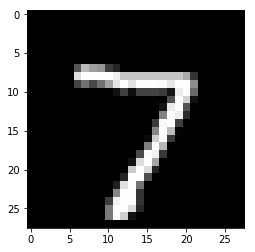

Model prediction: {'probabilities': array([  1.69095983e-06,   1.96614081e-07,   5.50877012e-05,
         2.48609285e-04,   5.38686109e-08,   2.10491135e-06,
         8.64628091e-10,   9.99617934e-01,   9.24944175e-07,
         7.34561108e-05], dtype=float32), 'classes': 7}


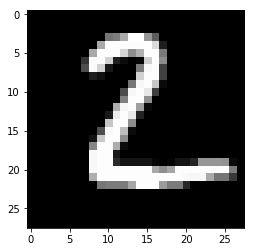

Model prediction: {'probabilities': array([  3.09943825e-05,   4.93465865e-04,   9.98963594e-01,
         3.77529446e-04,   1.16071579e-08,   8.11859991e-06,
         7.19960226e-05,   1.91425786e-09,   5.42652269e-05,
         6.57075228e-11], dtype=float32), 'classes': 2}


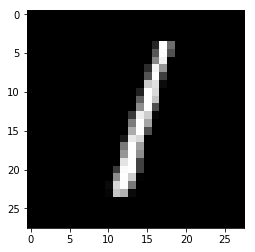

Model prediction: {'probabilities': array([  1.78922943e-04,   9.91000831e-01,   1.40697975e-03,
         8.92214186e-04,   8.69891548e-04,   3.98072851e-04,
         1.83283666e-03,   9.56807693e-04,   2.22475803e-03,
         2.38662789e-04], dtype=float32), 'classes': 1}


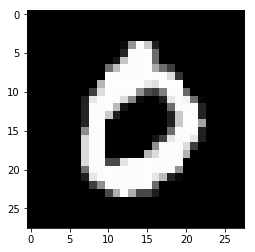

Model prediction: {'probabilities': array([  9.99702394e-01,   5.06669089e-08,   5.17320768e-05,
         8.14795931e-06,   4.81793734e-07,   1.10413341e-04,
         6.93508482e-05,   3.43191459e-05,   9.58952910e-07,
         2.21472237e-05], dtype=float32), 'classes': 0}


In [13]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(mnist_classifier.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])